# Stereoscope applied to left ventricule data

- Developed by Carlos Talavera-López Ph.D, WSI, edited by Romain Lopez
- Version: 210301

In this notebook, we present the workflow to run Stereoscope within the scvi-tools codebase. We map the adult heart cell atlas data from [Litviňuková et al (2020)](https://www.nature.com/articles/s41586-020-2797-4). This experiment takes around one hour to run on Colab.

You can access the raw count matrices as 'anndata' objects at www.heartcellatlas.org.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/env/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.external import RNAStereoscope, SpatialStereoscope

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Download single-cell data

Read in expression data. This is a subset of the data you want to map. Here I use a balanced subset of cells from the left ventricle (~ 50K). You can create your own subset according to what you are interested in.

In [5]:
adata_path = os.path.join(save_dir.name, "adata.h5ad")

sc_adata = sc.read(
    adata_path,
    backup_url="https://ndownloader.figshare.com/files/26153564",
)
sc_adata

  0%|          | 0.00/124M [00:00<?, ?B/s]

/env/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 35928 × 33538
    obs: 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'version', 'cell_states'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45'
    obsm: 'X_pca', 'X_umap'

## Preprocess single-cell data

In [6]:
sc.pp.filter_genes(sc_adata, min_counts=10)
sc_adata

AnnData object with n_obs × n_vars = 35928 × 25145
    obs: 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'version', 'cell_states'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    obsm: 'X_pca', 'X_umap'

In [7]:
sc_adata.obs["combined"] = [
    sc_adata.obs.loc[i, "cell_source"] + sc_adata.obs.loc[i, "donor"]
    for i in sc_adata.obs_names
]
sc_adata

AnnData object with n_obs × n_vars = 35928 × 25145
    obs: 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'version', 'cell_states', 'combined'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    obsm: 'X_pca', 'X_umap'

Remove mitochondrial genes

In [8]:
non_mito_genes_list = [
    name for name in sc_adata.var_names if not name.startswith("MT-")
]
sc_adata = sc_adata[:, non_mito_genes_list]
sc_adata

View of AnnData object with n_obs × n_vars = 35928 × 25132
    obs: 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'version', 'cell_states', 'combined'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    obsm: 'X_pca', 'X_umap'

Normalize data on a different layer, because Stereoscope works with raw counts. We did not see better results by using all the genes, so for computational purposed we cut here to 7,000 genes.

In [9]:
sc_adata.layers["counts"] = sc_adata.X.copy()
sc.pp.normalize_total(sc_adata, target_sum=1e5)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

/tmp/ipykernel_158/60512395.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  sc_adata.layers["counts"] = sc_adata.X.copy()


In [10]:
sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes=7000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="combined",
    span=1,
)

Examine the cell type labels

In [11]:
sc_adata.obs["cell_states"].value_counts()

cell_states
EC5_art        2000
PC3_str        2000
EC2_cap        2000
EC1_cap        2000
vCM1           2000
FB1            2000
SMC1_basic     2000
PC1_vent       2000
vCM2           2000
vCM3           2000
vCM4           2000
FB4            1912
EC3_cap        1712
EC6_ven        1292
DOCK4+MØ1       970
EC4_immune      751
CD4+T_cytox     642
NC1             524
Mast            453
FB3             436
CD8+T_cytox     429
LYVE1+MØ1       394
LYVE1+MØ2       390
CD8+T_tem       368
SMC2_art        323
NK              322
FB2             308
FB5             245
vCM5            235
CD16+Mo         234
Mo_pi           227
NKT             224
LYVE1+MØ3       223
CD4+T_tem       170
DC              143
CD14+Mo         132
Adip1           126
MØ_AgP          116
B_cells         112
NC2             102
DOCK4+MØ2        99
EC8_ln           90
NC4              59
MØ_mod           48
NC3              39
Meso             30
Adip2            15
Adip4            11
Adip3             8
NØ      

## Read in visium data

In [12]:
st_adata = sc.datasets.visium_sge(sample_id="V1_Human_Heart")
st_adata.var_names_make_unique()

  0%|          | 0.00/8.78M [00:00<?, ?B/s]

  0%|          | 0.00/11.6M [00:00<?, ?B/s]

/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [13]:
st_adata.var["mt"] = st_adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(st_adata, qc_vars=["mt"], inplace=True)
st_adata

AnnData object with n_obs × n_vars = 4247 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

- Clean up data based on QC values

/tmp/ipykernel_158/2459342404.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(st_adata.obs["total_counts"], kde=False, ax=axs[0])
/tmp/ipykernel_158/2459342404.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/tmp/ipykernel_158/2459342404.py:9: UserWarning: 

`distplot` is a deprecated f

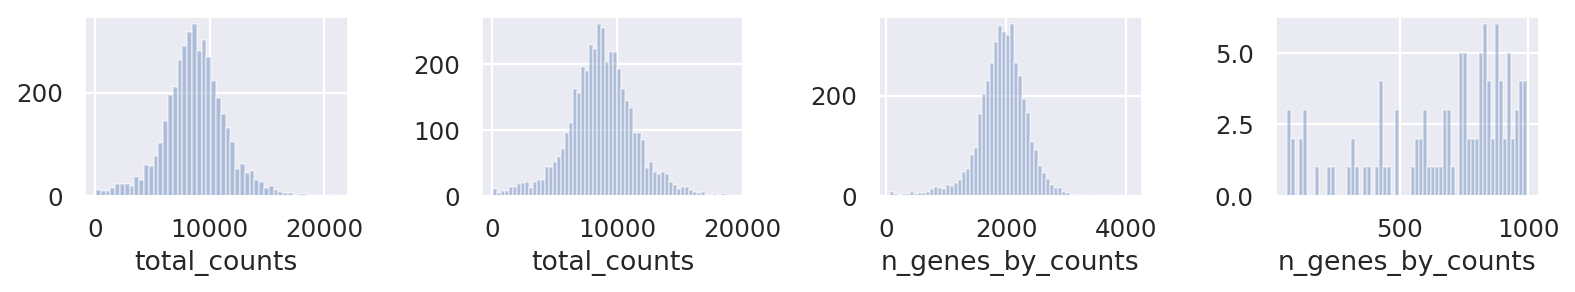

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2))
sns.distplot(st_adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(
    st_adata.obs["total_counts"][st_adata.obs["total_counts"] < 20000],
    kde=False,
    bins=60,
    ax=axs[1],
)
sns.distplot(st_adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(
    st_adata.obs["n_genes_by_counts"][st_adata.obs["n_genes_by_counts"] < 1000],
    kde=False,
    bins=60,
    ax=axs[3],
)
plt.tight_layout()
plt.show()

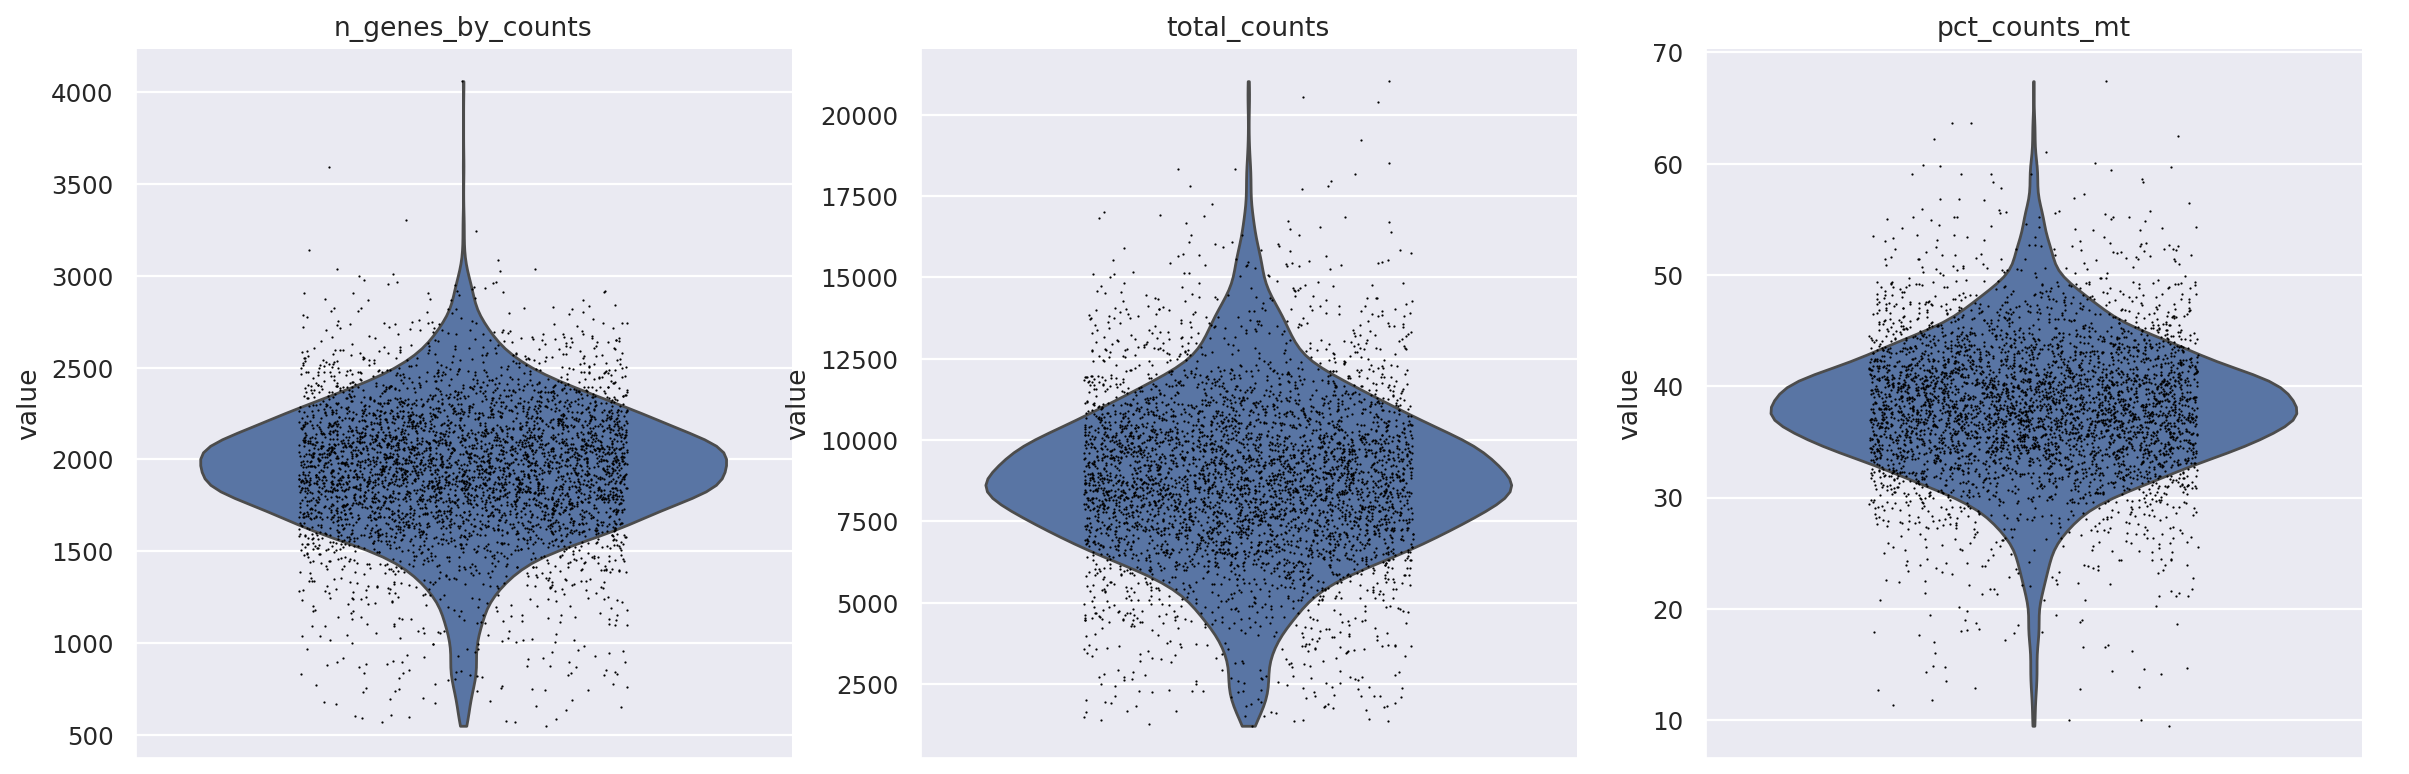

AnnData object with n_obs × n_vars = 4218 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [15]:
sc.pp.filter_cells(st_adata, min_counts=500)
sc.pp.filter_cells(st_adata, min_genes=500)
sc.pl.violin(
    st_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.25,
    multi_panel=True,
)
st_adata

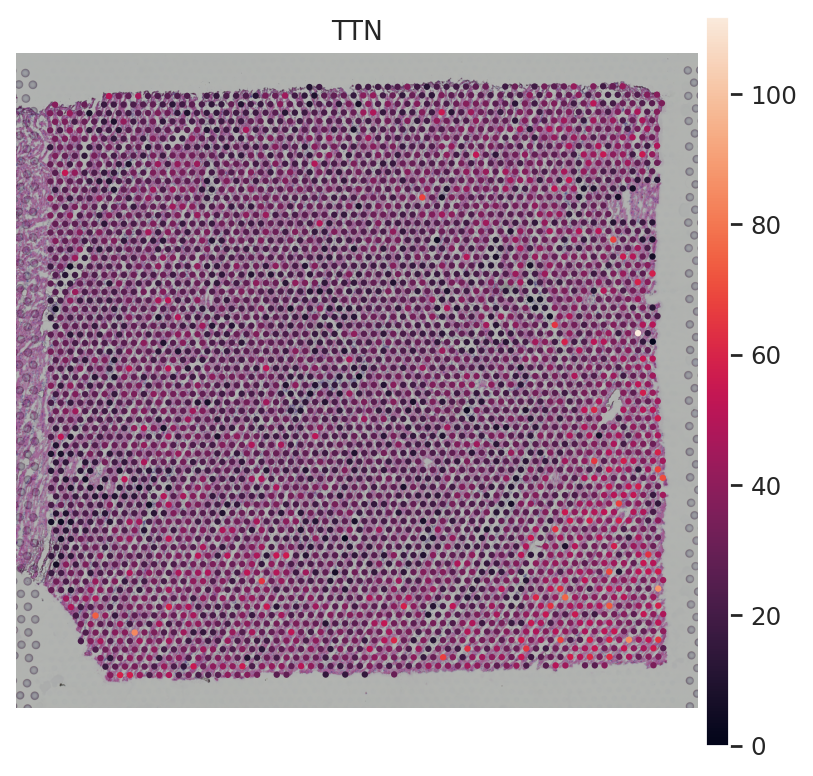

In [16]:
sc.pl.spatial(st_adata, img_key="hires", color=["TTN"])

## Learn cell-type specific gene expression from scRNA-seq data

Filter genes to be the same on the spatial data

In [17]:
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()

Setup the AnnData object

In [18]:
RNAStereoscope.setup_anndata(sc_adata, layer="counts", labels_key="cell_states")

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

/env/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:183: UserWarning: Category 39 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


Train the _scRNA-Seq_ model

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   1%|          | 1/100 [00:00<01:30,  1.09it/s]

Epoch 1/100:   1%|          | 1/100 [00:00<01:30,  1.09it/s, v_num=1, train_loss_step=9.02e+7, train_loss_epoch=4.19e+8]

Epoch 2/100:   1%|          | 1/100 [00:00<01:30,  1.09it/s, v_num=1, train_loss_step=9.02e+7, train_loss_epoch=4.19e+8]

Epoch 2/100:   2%|▏         | 2/100 [00:01<01:28,  1.10it/s, v_num=1, train_loss_step=9.02e+7, train_loss_epoch=4.19e+8]

Epoch 2/100:   2%|▏         | 2/100 [00:01<01:28,  1.10it/s, v_num=1, train_loss_step=3.03e+7, train_loss_epoch=7.32e+7]

Epoch 3/100:   2%|▏         | 2/100 [00:01<01:28,  1.10it/s, v_num=1, train_loss_step=3.03e+7, train_loss_epoch=7.32e+7]

Epoch 3/100:   3%|▎         | 3/100 [00:02<01:27,  1.11it/s, v_num=1, train_loss_step=3.03e+7, train_loss_epoch=7.32e+7]

Epoch 3/100:   3%|▎         | 3/100 [00:02<01:27,  1.11it/s, v_num=1, train_loss_step=1.55e+7, train_loss_epoch=2.99e+7]

Epoch 4/100:   3%|▎         | 3/100 [00:02<01:27,  1.11it/s, v_num=1, train_loss_step=1.55e+7, train_loss_epoch=2.99e+7]

Epoch 4/100:   4%|▍         | 4/100 [00:03<01:26,  1.11it/s, v_num=1, train_loss_step=1.55e+7, train_loss_epoch=2.99e+7]

Epoch 4/100:   4%|▍         | 4/100 [00:03<01:26,  1.11it/s, v_num=1, train_loss_step=7.39e+6, train_loss_epoch=1.64e+7]

Epoch 5/100:   4%|▍         | 4/100 [00:03<01:26,  1.11it/s, v_num=1, train_loss_step=7.39e+6, train_loss_epoch=1.64e+7]

Epoch 5/100:   5%|▌         | 5/100 [00:04<01:25,  1.11it/s, v_num=1, train_loss_step=7.39e+6, train_loss_epoch=1.64e+7]

Epoch 5/100:   5%|▌         | 5/100 [00:04<01:25,  1.11it/s, v_num=1, train_loss_step=6.08e+6, train_loss_epoch=1.03e+7]

Epoch 6/100:   5%|▌         | 5/100 [00:04<01:25,  1.11it/s, v_num=1, train_loss_step=6.08e+6, train_loss_epoch=1.03e+7]

Epoch 6/100:   6%|▌         | 6/100 [00:05<01:24,  1.11it/s, v_num=1, train_loss_step=6.08e+6, train_loss_epoch=1.03e+7]

Epoch 6/100:   6%|▌         | 6/100 [00:05<01:24,  1.11it/s, v_num=1, train_loss_step=4.46e+6, train_loss_epoch=7.1e+6] 

Epoch 7/100:   6%|▌         | 6/100 [00:05<01:24,  1.11it/s, v_num=1, train_loss_step=4.46e+6, train_loss_epoch=7.1e+6]

Epoch 7/100:   7%|▋         | 7/100 [00:06<01:23,  1.11it/s, v_num=1, train_loss_step=4.46e+6, train_loss_epoch=7.1e+6]

Epoch 7/100:   7%|▋         | 7/100 [00:06<01:23,  1.11it/s, v_num=1, train_loss_step=2.75e+6, train_loss_epoch=5.16e+6]

Epoch 8/100:   7%|▋         | 7/100 [00:06<01:23,  1.11it/s, v_num=1, train_loss_step=2.75e+6, train_loss_epoch=5.16e+6]

Epoch 8/100:   8%|▊         | 8/100 [00:07<01:22,  1.11it/s, v_num=1, train_loss_step=2.75e+6, train_loss_epoch=5.16e+6]

Epoch 8/100:   8%|▊         | 8/100 [00:07<01:22,  1.11it/s, v_num=1, train_loss_step=3.02e+6, train_loss_epoch=3.91e+6]

Epoch 9/100:   8%|▊         | 8/100 [00:07<01:22,  1.11it/s, v_num=1, train_loss_step=3.02e+6, train_loss_epoch=3.91e+6]

Epoch 9/100:   9%|▉         | 9/100 [00:08<01:21,  1.11it/s, v_num=1, train_loss_step=3.02e+6, train_loss_epoch=3.91e+6]

Epoch 9/100:   9%|▉         | 9/100 [00:08<01:21,  1.11it/s, v_num=1, train_loss_step=1.75e+6, train_loss_epoch=3.05e+6]

Epoch 10/100:   9%|▉         | 9/100 [00:08<01:21,  1.11it/s, v_num=1, train_loss_step=1.75e+6, train_loss_epoch=3.05e+6]

Epoch 10/100:  10%|█         | 10/100 [00:08<01:20,  1.12it/s, v_num=1, train_loss_step=1.75e+6, train_loss_epoch=3.05e+6]

Epoch 10/100:  10%|█         | 10/100 [00:08<01:20,  1.12it/s, v_num=1, train_loss_step=1.72e+6, train_loss_epoch=2.44e+6]

Epoch 11/100:  10%|█         | 10/100 [00:08<01:20,  1.12it/s, v_num=1, train_loss_step=1.72e+6, train_loss_epoch=2.44e+6]

Epoch 11/100:  11%|█         | 11/100 [00:09<01:19,  1.12it/s, v_num=1, train_loss_step=1.72e+6, train_loss_epoch=2.44e+6]

Epoch 11/100:  11%|█         | 11/100 [00:09<01:19,  1.12it/s, v_num=1, train_loss_step=1.01e+6, train_loss_epoch=1.99e+6]

Epoch 12/100:  11%|█         | 11/100 [00:09<01:19,  1.12it/s, v_num=1, train_loss_step=1.01e+6, train_loss_epoch=1.99e+6]

Epoch 12/100:  12%|█▏        | 12/100 [00:10<01:18,  1.13it/s, v_num=1, train_loss_step=1.01e+6, train_loss_epoch=1.99e+6]

Epoch 12/100:  12%|█▏        | 12/100 [00:10<01:18,  1.13it/s, v_num=1, train_loss_step=1.03e+6, train_loss_epoch=1.65e+6]

Epoch 13/100:  12%|█▏        | 12/100 [00:10<01:18,  1.13it/s, v_num=1, train_loss_step=1.03e+6, train_loss_epoch=1.65e+6]

Epoch 13/100:  13%|█▎        | 13/100 [00:11<01:17,  1.12it/s, v_num=1, train_loss_step=1.03e+6, train_loss_epoch=1.65e+6]

Epoch 13/100:  13%|█▎        | 13/100 [00:11<01:17,  1.12it/s, v_num=1, train_loss_step=8.95e+5, train_loss_epoch=1.39e+6]

Epoch 14/100:  13%|█▎        | 13/100 [00:11<01:17,  1.12it/s, v_num=1, train_loss_step=8.95e+5, train_loss_epoch=1.39e+6]

Epoch 14/100:  14%|█▍        | 14/100 [00:12<01:16,  1.12it/s, v_num=1, train_loss_step=8.95e+5, train_loss_epoch=1.39e+6]

Epoch 14/100:  14%|█▍        | 14/100 [00:12<01:16,  1.12it/s, v_num=1, train_loss_step=7.76e+5, train_loss_epoch=1.18e+6]

Epoch 15/100:  14%|█▍        | 14/100 [00:12<01:16,  1.12it/s, v_num=1, train_loss_step=7.76e+5, train_loss_epoch=1.18e+6]

Epoch 15/100:  15%|█▌        | 15/100 [00:13<01:16,  1.11it/s, v_num=1, train_loss_step=7.76e+5, train_loss_epoch=1.18e+6]

Epoch 15/100:  15%|█▌        | 15/100 [00:13<01:16,  1.11it/s, v_num=1, train_loss_step=7.4e+5, train_loss_epoch=1.02e+6] 

Epoch 16/100:  15%|█▌        | 15/100 [00:13<01:16,  1.11it/s, v_num=1, train_loss_step=7.4e+5, train_loss_epoch=1.02e+6]

Epoch 16/100:  16%|█▌        | 16/100 [00:14<01:15,  1.11it/s, v_num=1, train_loss_step=7.4e+5, train_loss_epoch=1.02e+6]

Epoch 16/100:  16%|█▌        | 16/100 [00:14<01:15,  1.11it/s, v_num=1, train_loss_step=7.14e+5, train_loss_epoch=8.91e+5]

Epoch 17/100:  16%|█▌        | 16/100 [00:14<01:15,  1.11it/s, v_num=1, train_loss_step=7.14e+5, train_loss_epoch=8.91e+5]

Epoch 17/100:  17%|█▋        | 17/100 [00:15<01:14,  1.11it/s, v_num=1, train_loss_step=7.14e+5, train_loss_epoch=8.91e+5]

Epoch 17/100:  17%|█▋        | 17/100 [00:15<01:14,  1.11it/s, v_num=1, train_loss_step=4.77e+5, train_loss_epoch=7.87e+5]

Epoch 18/100:  17%|█▋        | 17/100 [00:15<01:14,  1.11it/s, v_num=1, train_loss_step=4.77e+5, train_loss_epoch=7.87e+5]

Epoch 18/100:  18%|█▊        | 18/100 [00:16<01:14,  1.11it/s, v_num=1, train_loss_step=4.77e+5, train_loss_epoch=7.87e+5]

Epoch 18/100:  18%|█▊        | 18/100 [00:16<01:14,  1.11it/s, v_num=1, train_loss_step=4.61e+5, train_loss_epoch=7.02e+5]

Epoch 19/100:  18%|█▊        | 18/100 [00:16<01:14,  1.11it/s, v_num=1, train_loss_step=4.61e+5, train_loss_epoch=7.02e+5]

Epoch 19/100:  19%|█▉        | 19/100 [00:17<01:13,  1.10it/s, v_num=1, train_loss_step=4.61e+5, train_loss_epoch=7.02e+5]

Epoch 19/100:  19%|█▉        | 19/100 [00:17<01:13,  1.10it/s, v_num=1, train_loss_step=3.91e+5, train_loss_epoch=6.33e+5]

Epoch 20/100:  19%|█▉        | 19/100 [00:17<01:13,  1.10it/s, v_num=1, train_loss_step=3.91e+5, train_loss_epoch=6.33e+5]

Epoch 20/100:  20%|██        | 20/100 [00:17<01:12,  1.10it/s, v_num=1, train_loss_step=3.91e+5, train_loss_epoch=6.33e+5]

Epoch 20/100:  20%|██        | 20/100 [00:18<01:12,  1.10it/s, v_num=1, train_loss_step=3.82e+5, train_loss_epoch=5.76e+5]

Epoch 21/100:  20%|██        | 20/100 [00:18<01:12,  1.10it/s, v_num=1, train_loss_step=3.82e+5, train_loss_epoch=5.76e+5]

Epoch 21/100:  21%|██        | 21/100 [00:18<01:11,  1.10it/s, v_num=1, train_loss_step=3.82e+5, train_loss_epoch=5.76e+5]

Epoch 21/100:  21%|██        | 21/100 [00:18<01:11,  1.10it/s, v_num=1, train_loss_step=3.56e+5, train_loss_epoch=5.29e+5]

Epoch 22/100:  21%|██        | 21/100 [00:18<01:11,  1.10it/s, v_num=1, train_loss_step=3.56e+5, train_loss_epoch=5.29e+5]

Epoch 22/100:  22%|██▏       | 22/100 [00:19<01:11,  1.10it/s, v_num=1, train_loss_step=3.56e+5, train_loss_epoch=5.29e+5]

Epoch 22/100:  22%|██▏       | 22/100 [00:19<01:11,  1.10it/s, v_num=1, train_loss_step=3.12e+5, train_loss_epoch=4.9e+5] 

Epoch 23/100:  22%|██▏       | 22/100 [00:19<01:11,  1.10it/s, v_num=1, train_loss_step=3.12e+5, train_loss_epoch=4.9e+5]

Epoch 23/100:  23%|██▎       | 23/100 [00:20<01:10,  1.09it/s, v_num=1, train_loss_step=3.12e+5, train_loss_epoch=4.9e+5]

Epoch 23/100:  23%|██▎       | 23/100 [00:20<01:10,  1.09it/s, v_num=1, train_loss_step=3.17e+5, train_loss_epoch=4.57e+5]

Epoch 24/100:  23%|██▎       | 23/100 [00:20<01:10,  1.09it/s, v_num=1, train_loss_step=3.17e+5, train_loss_epoch=4.57e+5]

Epoch 24/100:  24%|██▍       | 24/100 [00:21<01:09,  1.09it/s, v_num=1, train_loss_step=3.17e+5, train_loss_epoch=4.57e+5]

Epoch 24/100:  24%|██▍       | 24/100 [00:21<01:09,  1.09it/s, v_num=1, train_loss_step=2.64e+5, train_loss_epoch=4.3e+5] 

Epoch 25/100:  24%|██▍       | 24/100 [00:21<01:09,  1.09it/s, v_num=1, train_loss_step=2.64e+5, train_loss_epoch=4.3e+5]

Epoch 25/100:  25%|██▌       | 25/100 [00:22<01:09,  1.08it/s, v_num=1, train_loss_step=2.64e+5, train_loss_epoch=4.3e+5]

Epoch 25/100:  25%|██▌       | 25/100 [00:22<01:09,  1.08it/s, v_num=1, train_loss_step=2.94e+5, train_loss_epoch=4.08e+5]

Epoch 26/100:  25%|██▌       | 25/100 [00:22<01:09,  1.08it/s, v_num=1, train_loss_step=2.94e+5, train_loss_epoch=4.08e+5]

Epoch 26/100:  26%|██▌       | 26/100 [00:23<01:08,  1.08it/s, v_num=1, train_loss_step=2.94e+5, train_loss_epoch=4.08e+5]

Epoch 26/100:  26%|██▌       | 26/100 [00:23<01:08,  1.08it/s, v_num=1, train_loss_step=2.48e+5, train_loss_epoch=3.89e+5]

Epoch 27/100:  26%|██▌       | 26/100 [00:23<01:08,  1.08it/s, v_num=1, train_loss_step=2.48e+5, train_loss_epoch=3.89e+5]

Epoch 27/100:  27%|██▋       | 27/100 [00:24<01:07,  1.08it/s, v_num=1, train_loss_step=2.48e+5, train_loss_epoch=3.89e+5]

Epoch 27/100:  27%|██▋       | 27/100 [00:24<01:07,  1.08it/s, v_num=1, train_loss_step=2.33e+5, train_loss_epoch=3.73e+5]

Epoch 28/100:  27%|██▋       | 27/100 [00:24<01:07,  1.08it/s, v_num=1, train_loss_step=2.33e+5, train_loss_epoch=3.73e+5]

Epoch 28/100:  28%|██▊       | 28/100 [00:25<01:06,  1.08it/s, v_num=1, train_loss_step=2.33e+5, train_loss_epoch=3.73e+5]

Epoch 28/100:  28%|██▊       | 28/100 [00:25<01:06,  1.08it/s, v_num=1, train_loss_step=2.34e+5, train_loss_epoch=3.6e+5] 

Epoch 29/100:  28%|██▊       | 28/100 [00:25<01:06,  1.08it/s, v_num=1, train_loss_step=2.34e+5, train_loss_epoch=3.6e+5]

Epoch 29/100:  29%|██▉       | 29/100 [00:26<01:06,  1.08it/s, v_num=1, train_loss_step=2.34e+5, train_loss_epoch=3.6e+5]

Epoch 29/100:  29%|██▉       | 29/100 [00:26<01:06,  1.08it/s, v_num=1, train_loss_step=2.62e+5, train_loss_epoch=3.49e+5]

Epoch 30/100:  29%|██▉       | 29/100 [00:26<01:06,  1.08it/s, v_num=1, train_loss_step=2.62e+5, train_loss_epoch=3.49e+5]

Epoch 30/100:  30%|███       | 30/100 [00:27<01:04,  1.08it/s, v_num=1, train_loss_step=2.62e+5, train_loss_epoch=3.49e+5]

Epoch 30/100:  30%|███       | 30/100 [00:27<01:04,  1.08it/s, v_num=1, train_loss_step=2.29e+5, train_loss_epoch=3.39e+5]

Epoch 31/100:  30%|███       | 30/100 [00:27<01:04,  1.08it/s, v_num=1, train_loss_step=2.29e+5, train_loss_epoch=3.39e+5]

Epoch 31/100:  31%|███       | 31/100 [00:28<01:03,  1.08it/s, v_num=1, train_loss_step=2.29e+5, train_loss_epoch=3.39e+5]

Epoch 31/100:  31%|███       | 31/100 [00:28<01:03,  1.08it/s, v_num=1, train_loss_step=2.46e+5, train_loss_epoch=3.31e+5]

Epoch 32/100:  31%|███       | 31/100 [00:28<01:03,  1.08it/s, v_num=1, train_loss_step=2.46e+5, train_loss_epoch=3.31e+5]

Epoch 32/100:  32%|███▏      | 32/100 [00:29<01:02,  1.08it/s, v_num=1, train_loss_step=2.46e+5, train_loss_epoch=3.31e+5]

Epoch 32/100:  32%|███▏      | 32/100 [00:29<01:02,  1.08it/s, v_num=1, train_loss_step=2.05e+5, train_loss_epoch=3.25e+5]

Epoch 33/100:  32%|███▏      | 32/100 [00:29<01:02,  1.08it/s, v_num=1, train_loss_step=2.05e+5, train_loss_epoch=3.25e+5]

Epoch 33/100:  33%|███▎      | 33/100 [00:30<01:02,  1.08it/s, v_num=1, train_loss_step=2.05e+5, train_loss_epoch=3.25e+5]

Epoch 33/100:  33%|███▎      | 33/100 [00:30<01:02,  1.08it/s, v_num=1, train_loss_step=2.06e+5, train_loss_epoch=3.19e+5]

Epoch 34/100:  33%|███▎      | 33/100 [00:30<01:02,  1.08it/s, v_num=1, train_loss_step=2.06e+5, train_loss_epoch=3.19e+5]

Epoch 34/100:  34%|███▍      | 34/100 [00:30<01:01,  1.07it/s, v_num=1, train_loss_step=2.06e+5, train_loss_epoch=3.19e+5]

Epoch 34/100:  34%|███▍      | 34/100 [00:30<01:01,  1.07it/s, v_num=1, train_loss_step=2.19e+5, train_loss_epoch=3.15e+5]

Epoch 35/100:  34%|███▍      | 34/100 [00:30<01:01,  1.07it/s, v_num=1, train_loss_step=2.19e+5, train_loss_epoch=3.15e+5]

Epoch 35/100:  35%|███▌      | 35/100 [00:31<01:00,  1.08it/s, v_num=1, train_loss_step=2.19e+5, train_loss_epoch=3.15e+5]

Epoch 35/100:  35%|███▌      | 35/100 [00:31<01:00,  1.08it/s, v_num=1, train_loss_step=2.1e+5, train_loss_epoch=3.11e+5] 

Epoch 36/100:  35%|███▌      | 35/100 [00:31<01:00,  1.08it/s, v_num=1, train_loss_step=2.1e+5, train_loss_epoch=3.11e+5]

Epoch 36/100:  36%|███▌      | 36/100 [00:32<00:58,  1.09it/s, v_num=1, train_loss_step=2.1e+5, train_loss_epoch=3.11e+5]

Epoch 36/100:  36%|███▌      | 36/100 [00:32<00:58,  1.09it/s, v_num=1, train_loss_step=2.02e+5, train_loss_epoch=3.08e+5]

Epoch 37/100:  36%|███▌      | 36/100 [00:32<00:58,  1.09it/s, v_num=1, train_loss_step=2.02e+5, train_loss_epoch=3.08e+5]

Epoch 37/100:  37%|███▋      | 37/100 [00:33<00:57,  1.10it/s, v_num=1, train_loss_step=2.02e+5, train_loss_epoch=3.08e+5]

Epoch 37/100:  37%|███▋      | 37/100 [00:33<00:57,  1.10it/s, v_num=1, train_loss_step=2.13e+5, train_loss_epoch=3.05e+5]

Epoch 38/100:  37%|███▋      | 37/100 [00:33<00:57,  1.10it/s, v_num=1, train_loss_step=2.13e+5, train_loss_epoch=3.05e+5]

Epoch 38/100:  38%|███▊      | 38/100 [00:34<00:55,  1.11it/s, v_num=1, train_loss_step=2.13e+5, train_loss_epoch=3.05e+5]

Epoch 38/100:  38%|███▊      | 38/100 [00:34<00:55,  1.11it/s, v_num=1, train_loss_step=2.19e+5, train_loss_epoch=3.02e+5]

Epoch 39/100:  38%|███▊      | 38/100 [00:34<00:55,  1.11it/s, v_num=1, train_loss_step=2.19e+5, train_loss_epoch=3.02e+5]

Epoch 39/100:  39%|███▉      | 39/100 [00:35<00:55,  1.11it/s, v_num=1, train_loss_step=2.19e+5, train_loss_epoch=3.02e+5]

Epoch 39/100:  39%|███▉      | 39/100 [00:35<00:55,  1.11it/s, v_num=1, train_loss_step=2.02e+5, train_loss_epoch=3e+5]   

Epoch 40/100:  39%|███▉      | 39/100 [00:35<00:55,  1.11it/s, v_num=1, train_loss_step=2.02e+5, train_loss_epoch=3e+5]

Epoch 40/100:  40%|████      | 40/100 [00:36<00:54,  1.10it/s, v_num=1, train_loss_step=2.02e+5, train_loss_epoch=3e+5]

Epoch 40/100:  40%|████      | 40/100 [00:36<00:54,  1.10it/s, v_num=1, train_loss_step=1.97e+5, train_loss_epoch=2.99e+5]

Epoch 41/100:  40%|████      | 40/100 [00:36<00:54,  1.10it/s, v_num=1, train_loss_step=1.97e+5, train_loss_epoch=2.99e+5]

Epoch 41/100:  41%|████      | 41/100 [00:37<00:53,  1.10it/s, v_num=1, train_loss_step=1.97e+5, train_loss_epoch=2.99e+5]

Epoch 41/100:  41%|████      | 41/100 [00:37<00:53,  1.10it/s, v_num=1, train_loss_step=1.94e+5, train_loss_epoch=2.97e+5]

Epoch 42/100:  41%|████      | 41/100 [00:37<00:53,  1.10it/s, v_num=1, train_loss_step=1.94e+5, train_loss_epoch=2.97e+5]

Epoch 42/100:  42%|████▏     | 42/100 [00:38<00:53,  1.09it/s, v_num=1, train_loss_step=1.94e+5, train_loss_epoch=2.97e+5]

Epoch 42/100:  42%|████▏     | 42/100 [00:38<00:53,  1.09it/s, v_num=1, train_loss_step=1.93e+5, train_loss_epoch=2.96e+5]

Epoch 43/100:  42%|████▏     | 42/100 [00:38<00:53,  1.09it/s, v_num=1, train_loss_step=1.93e+5, train_loss_epoch=2.96e+5]

Epoch 43/100:  43%|████▎     | 43/100 [00:39<00:52,  1.08it/s, v_num=1, train_loss_step=1.93e+5, train_loss_epoch=2.96e+5]

Epoch 43/100:  43%|████▎     | 43/100 [00:39<00:52,  1.08it/s, v_num=1, train_loss_step=2.06e+5, train_loss_epoch=2.95e+5]

Epoch 44/100:  43%|████▎     | 43/100 [00:39<00:52,  1.08it/s, v_num=1, train_loss_step=2.06e+5, train_loss_epoch=2.95e+5]

Epoch 44/100:  44%|████▍     | 44/100 [00:40<00:51,  1.08it/s, v_num=1, train_loss_step=2.06e+5, train_loss_epoch=2.95e+5]

Epoch 44/100:  44%|████▍     | 44/100 [00:40<00:51,  1.08it/s, v_num=1, train_loss_step=1.96e+5, train_loss_epoch=2.94e+5]

Epoch 45/100:  44%|████▍     | 44/100 [00:40<00:51,  1.08it/s, v_num=1, train_loss_step=1.96e+5, train_loss_epoch=2.94e+5]

Epoch 45/100:  45%|████▌     | 45/100 [00:41<00:50,  1.08it/s, v_num=1, train_loss_step=1.96e+5, train_loss_epoch=2.94e+5]

Epoch 45/100:  45%|████▌     | 45/100 [00:41<00:50,  1.08it/s, v_num=1, train_loss_step=1.96e+5, train_loss_epoch=2.93e+5]

Epoch 46/100:  45%|████▌     | 45/100 [00:41<00:50,  1.08it/s, v_num=1, train_loss_step=1.96e+5, train_loss_epoch=2.93e+5]

Epoch 46/100:  46%|████▌     | 46/100 [00:41<00:50,  1.08it/s, v_num=1, train_loss_step=1.96e+5, train_loss_epoch=2.93e+5]

Epoch 46/100:  46%|████▌     | 46/100 [00:41<00:50,  1.08it/s, v_num=1, train_loss_step=1.87e+5, train_loss_epoch=2.92e+5]

Epoch 47/100:  46%|████▌     | 46/100 [00:41<00:50,  1.08it/s, v_num=1, train_loss_step=1.87e+5, train_loss_epoch=2.92e+5]

Epoch 47/100:  47%|████▋     | 47/100 [00:42<00:49,  1.08it/s, v_num=1, train_loss_step=1.87e+5, train_loss_epoch=2.92e+5]

Epoch 47/100:  47%|████▋     | 47/100 [00:42<00:49,  1.08it/s, v_num=1, train_loss_step=1.9e+5, train_loss_epoch=2.92e+5] 

Epoch 48/100:  47%|████▋     | 47/100 [00:42<00:49,  1.08it/s, v_num=1, train_loss_step=1.9e+5, train_loss_epoch=2.92e+5]

Epoch 48/100:  48%|████▊     | 48/100 [00:43<00:48,  1.08it/s, v_num=1, train_loss_step=1.9e+5, train_loss_epoch=2.92e+5]

Epoch 48/100:  48%|████▊     | 48/100 [00:43<00:48,  1.08it/s, v_num=1, train_loss_step=1.76e+5, train_loss_epoch=2.91e+5]

Epoch 49/100:  48%|████▊     | 48/100 [00:43<00:48,  1.08it/s, v_num=1, train_loss_step=1.76e+5, train_loss_epoch=2.91e+5]

Epoch 49/100:  49%|████▉     | 49/100 [00:44<00:47,  1.08it/s, v_num=1, train_loss_step=1.76e+5, train_loss_epoch=2.91e+5]

Epoch 49/100:  49%|████▉     | 49/100 [00:44<00:47,  1.08it/s, v_num=1, train_loss_step=2.04e+5, train_loss_epoch=2.91e+5]

Epoch 50/100:  49%|████▉     | 49/100 [00:44<00:47,  1.08it/s, v_num=1, train_loss_step=2.04e+5, train_loss_epoch=2.91e+5]

Epoch 50/100:  50%|█████     | 50/100 [00:45<00:46,  1.09it/s, v_num=1, train_loss_step=2.04e+5, train_loss_epoch=2.91e+5]

Epoch 50/100:  50%|█████     | 50/100 [00:45<00:46,  1.09it/s, v_num=1, train_loss_step=1.97e+5, train_loss_epoch=2.91e+5]

Epoch 51/100:  50%|█████     | 50/100 [00:45<00:46,  1.09it/s, v_num=1, train_loss_step=1.97e+5, train_loss_epoch=2.91e+5]

Epoch 51/100:  51%|█████     | 51/100 [00:46<00:44,  1.09it/s, v_num=1, train_loss_step=1.97e+5, train_loss_epoch=2.91e+5]

Epoch 51/100:  51%|█████     | 51/100 [00:46<00:44,  1.09it/s, v_num=1, train_loss_step=2.09e+5, train_loss_epoch=2.9e+5] 

Epoch 52/100:  51%|█████     | 51/100 [00:46<00:44,  1.09it/s, v_num=1, train_loss_step=2.09e+5, train_loss_epoch=2.9e+5]

Epoch 52/100:  52%|█████▏    | 52/100 [00:47<00:43,  1.09it/s, v_num=1, train_loss_step=2.09e+5, train_loss_epoch=2.9e+5]

Epoch 52/100:  52%|█████▏    | 52/100 [00:47<00:43,  1.09it/s, v_num=1, train_loss_step=2.11e+5, train_loss_epoch=2.9e+5]

Epoch 53/100:  52%|█████▏    | 52/100 [00:47<00:43,  1.09it/s, v_num=1, train_loss_step=2.11e+5, train_loss_epoch=2.9e+5]

Epoch 53/100:  53%|█████▎    | 53/100 [00:48<00:42,  1.09it/s, v_num=1, train_loss_step=2.11e+5, train_loss_epoch=2.9e+5]

Epoch 53/100:  53%|█████▎    | 53/100 [00:48<00:42,  1.09it/s, v_num=1, train_loss_step=2.02e+5, train_loss_epoch=2.9e+5]

Epoch 54/100:  53%|█████▎    | 53/100 [00:48<00:42,  1.09it/s, v_num=1, train_loss_step=2.02e+5, train_loss_epoch=2.9e+5]

Epoch 54/100:  54%|█████▍    | 54/100 [00:49<00:42,  1.09it/s, v_num=1, train_loss_step=2.02e+5, train_loss_epoch=2.9e+5]

Epoch 54/100:  54%|█████▍    | 54/100 [00:49<00:42,  1.09it/s, v_num=1, train_loss_step=2.05e+5, train_loss_epoch=2.89e+5]

Epoch 55/100:  54%|█████▍    | 54/100 [00:49<00:42,  1.09it/s, v_num=1, train_loss_step=2.05e+5, train_loss_epoch=2.89e+5]

Epoch 55/100:  55%|█████▌    | 55/100 [00:50<00:41,  1.10it/s, v_num=1, train_loss_step=2.05e+5, train_loss_epoch=2.89e+5]

Epoch 55/100:  55%|█████▌    | 55/100 [00:50<00:41,  1.10it/s, v_num=1, train_loss_step=1.95e+5, train_loss_epoch=2.89e+5]

Epoch 56/100:  55%|█████▌    | 55/100 [00:50<00:41,  1.10it/s, v_num=1, train_loss_step=1.95e+5, train_loss_epoch=2.89e+5]

Epoch 56/100:  56%|█████▌    | 56/100 [00:51<00:40,  1.10it/s, v_num=1, train_loss_step=1.95e+5, train_loss_epoch=2.89e+5]

Epoch 56/100:  56%|█████▌    | 56/100 [00:51<00:40,  1.10it/s, v_num=1, train_loss_step=2.12e+5, train_loss_epoch=2.89e+5]

Epoch 57/100:  56%|█████▌    | 56/100 [00:51<00:40,  1.10it/s, v_num=1, train_loss_step=2.12e+5, train_loss_epoch=2.89e+5]

Epoch 57/100:  57%|█████▋    | 57/100 [00:52<00:39,  1.09it/s, v_num=1, train_loss_step=2.12e+5, train_loss_epoch=2.89e+5]

Epoch 57/100:  57%|█████▋    | 57/100 [00:52<00:39,  1.09it/s, v_num=1, train_loss_step=2.01e+5, train_loss_epoch=2.89e+5]

Epoch 58/100:  57%|█████▋    | 57/100 [00:52<00:39,  1.09it/s, v_num=1, train_loss_step=2.01e+5, train_loss_epoch=2.89e+5]

Epoch 58/100:  58%|█████▊    | 58/100 [00:52<00:38,  1.09it/s, v_num=1, train_loss_step=2.01e+5, train_loss_epoch=2.89e+5]

Epoch 58/100:  58%|█████▊    | 58/100 [00:52<00:38,  1.09it/s, v_num=1, train_loss_step=2.01e+5, train_loss_epoch=2.89e+5]

Epoch 59/100:  58%|█████▊    | 58/100 [00:52<00:38,  1.09it/s, v_num=1, train_loss_step=2.01e+5, train_loss_epoch=2.89e+5]

Epoch 59/100:  59%|█████▉    | 59/100 [00:53<00:37,  1.10it/s, v_num=1, train_loss_step=2.01e+5, train_loss_epoch=2.89e+5]

Epoch 59/100:  59%|█████▉    | 59/100 [00:53<00:37,  1.10it/s, v_num=1, train_loss_step=2e+5, train_loss_epoch=2.88e+5]   

Epoch 60/100:  59%|█████▉    | 59/100 [00:53<00:37,  1.10it/s, v_num=1, train_loss_step=2e+5, train_loss_epoch=2.88e+5]

Epoch 60/100:  60%|██████    | 60/100 [00:54<00:36,  1.10it/s, v_num=1, train_loss_step=2e+5, train_loss_epoch=2.88e+5]

Epoch 60/100:  60%|██████    | 60/100 [00:54<00:36,  1.10it/s, v_num=1, train_loss_step=2.15e+5, train_loss_epoch=2.88e+5]

Epoch 61/100:  60%|██████    | 60/100 [00:54<00:36,  1.10it/s, v_num=1, train_loss_step=2.15e+5, train_loss_epoch=2.88e+5]

Epoch 61/100:  61%|██████    | 61/100 [00:55<00:35,  1.10it/s, v_num=1, train_loss_step=2.15e+5, train_loss_epoch=2.88e+5]

Epoch 61/100:  61%|██████    | 61/100 [00:55<00:35,  1.10it/s, v_num=1, train_loss_step=2.15e+5, train_loss_epoch=2.88e+5]

Epoch 62/100:  61%|██████    | 61/100 [00:55<00:35,  1.10it/s, v_num=1, train_loss_step=2.15e+5, train_loss_epoch=2.88e+5]

Epoch 62/100:  62%|██████▏   | 62/100 [00:56<00:34,  1.10it/s, v_num=1, train_loss_step=2.15e+5, train_loss_epoch=2.88e+5]

Epoch 62/100:  62%|██████▏   | 62/100 [00:56<00:34,  1.10it/s, v_num=1, train_loss_step=1.92e+5, train_loss_epoch=2.88e+5]

Epoch 63/100:  62%|██████▏   | 62/100 [00:56<00:34,  1.10it/s, v_num=1, train_loss_step=1.92e+5, train_loss_epoch=2.88e+5]

Epoch 63/100:  63%|██████▎   | 63/100 [00:57<00:33,  1.10it/s, v_num=1, train_loss_step=1.92e+5, train_loss_epoch=2.88e+5]

Epoch 63/100:  63%|██████▎   | 63/100 [00:57<00:33,  1.10it/s, v_num=1, train_loss_step=1.95e+5, train_loss_epoch=2.88e+5]

Epoch 64/100:  63%|██████▎   | 63/100 [00:57<00:33,  1.10it/s, v_num=1, train_loss_step=1.95e+5, train_loss_epoch=2.88e+5]

Epoch 64/100:  64%|██████▍   | 64/100 [00:58<00:32,  1.10it/s, v_num=1, train_loss_step=1.95e+5, train_loss_epoch=2.88e+5]

Epoch 64/100:  64%|██████▍   | 64/100 [00:58<00:32,  1.10it/s, v_num=1, train_loss_step=1.96e+5, train_loss_epoch=2.87e+5]

Epoch 65/100:  64%|██████▍   | 64/100 [00:58<00:32,  1.10it/s, v_num=1, train_loss_step=1.96e+5, train_loss_epoch=2.87e+5]

Epoch 65/100:  65%|██████▌   | 65/100 [00:59<00:31,  1.10it/s, v_num=1, train_loss_step=1.96e+5, train_loss_epoch=2.87e+5]

Epoch 65/100:  65%|██████▌   | 65/100 [00:59<00:31,  1.10it/s, v_num=1, train_loss_step=1.9e+5, train_loss_epoch=2.87e+5] 

Epoch 66/100:  65%|██████▌   | 65/100 [00:59<00:31,  1.10it/s, v_num=1, train_loss_step=1.9e+5, train_loss_epoch=2.87e+5]

Epoch 66/100:  66%|██████▌   | 66/100 [01:00<00:30,  1.10it/s, v_num=1, train_loss_step=1.9e+5, train_loss_epoch=2.87e+5]

Epoch 66/100:  66%|██████▌   | 66/100 [01:00<00:30,  1.10it/s, v_num=1, train_loss_step=1.88e+5, train_loss_epoch=2.87e+5]

Epoch 67/100:  66%|██████▌   | 66/100 [01:00<00:30,  1.10it/s, v_num=1, train_loss_step=1.88e+5, train_loss_epoch=2.87e+5]

Epoch 67/100:  67%|██████▋   | 67/100 [01:01<00:30,  1.10it/s, v_num=1, train_loss_step=1.88e+5, train_loss_epoch=2.87e+5]

Epoch 67/100:  67%|██████▋   | 67/100 [01:01<00:30,  1.10it/s, v_num=1, train_loss_step=1.9e+5, train_loss_epoch=2.87e+5] 

Epoch 68/100:  67%|██████▋   | 67/100 [01:01<00:30,  1.10it/s, v_num=1, train_loss_step=1.9e+5, train_loss_epoch=2.87e+5]

Epoch 68/100:  68%|██████▊   | 68/100 [01:02<00:29,  1.10it/s, v_num=1, train_loss_step=1.9e+5, train_loss_epoch=2.87e+5]

Epoch 68/100:  68%|██████▊   | 68/100 [01:02<00:29,  1.10it/s, v_num=1, train_loss_step=1.81e+5, train_loss_epoch=2.86e+5]

Epoch 69/100:  68%|██████▊   | 68/100 [01:02<00:29,  1.10it/s, v_num=1, train_loss_step=1.81e+5, train_loss_epoch=2.86e+5]

Epoch 69/100:  69%|██████▉   | 69/100 [01:02<00:28,  1.10it/s, v_num=1, train_loss_step=1.81e+5, train_loss_epoch=2.86e+5]

Epoch 69/100:  69%|██████▉   | 69/100 [01:02<00:28,  1.10it/s, v_num=1, train_loss_step=1.83e+5, train_loss_epoch=2.86e+5]

Epoch 70/100:  69%|██████▉   | 69/100 [01:02<00:28,  1.10it/s, v_num=1, train_loss_step=1.83e+5, train_loss_epoch=2.86e+5]

Epoch 70/100:  70%|███████   | 70/100 [01:03<00:27,  1.10it/s, v_num=1, train_loss_step=1.83e+5, train_loss_epoch=2.86e+5]

Epoch 70/100:  70%|███████   | 70/100 [01:03<00:27,  1.10it/s, v_num=1, train_loss_step=2.1e+5, train_loss_epoch=2.86e+5] 

Epoch 71/100:  70%|███████   | 70/100 [01:03<00:27,  1.10it/s, v_num=1, train_loss_step=2.1e+5, train_loss_epoch=2.86e+5]

Epoch 71/100:  71%|███████   | 71/100 [01:04<00:26,  1.10it/s, v_num=1, train_loss_step=2.1e+5, train_loss_epoch=2.86e+5]

Epoch 71/100:  71%|███████   | 71/100 [01:04<00:26,  1.10it/s, v_num=1, train_loss_step=2.01e+5, train_loss_epoch=2.85e+5]

Epoch 72/100:  71%|███████   | 71/100 [01:04<00:26,  1.10it/s, v_num=1, train_loss_step=2.01e+5, train_loss_epoch=2.85e+5]

Epoch 72/100:  72%|███████▏  | 72/100 [01:05<00:25,  1.11it/s, v_num=1, train_loss_step=2.01e+5, train_loss_epoch=2.85e+5]

Epoch 72/100:  72%|███████▏  | 72/100 [01:05<00:25,  1.11it/s, v_num=1, train_loss_step=1.94e+5, train_loss_epoch=2.85e+5]

Epoch 73/100:  72%|███████▏  | 72/100 [01:05<00:25,  1.11it/s, v_num=1, train_loss_step=1.94e+5, train_loss_epoch=2.85e+5]

Epoch 73/100:  73%|███████▎  | 73/100 [01:06<00:24,  1.11it/s, v_num=1, train_loss_step=1.94e+5, train_loss_epoch=2.85e+5]

Epoch 73/100:  73%|███████▎  | 73/100 [01:06<00:24,  1.11it/s, v_num=1, train_loss_step=1.98e+5, train_loss_epoch=2.85e+5]

Epoch 74/100:  73%|███████▎  | 73/100 [01:06<00:24,  1.11it/s, v_num=1, train_loss_step=1.98e+5, train_loss_epoch=2.85e+5]

Epoch 74/100:  74%|███████▍  | 74/100 [01:07<00:23,  1.11it/s, v_num=1, train_loss_step=1.98e+5, train_loss_epoch=2.85e+5]

Epoch 74/100:  74%|███████▍  | 74/100 [01:07<00:23,  1.11it/s, v_num=1, train_loss_step=1.78e+5, train_loss_epoch=2.85e+5]

Epoch 75/100:  74%|███████▍  | 74/100 [01:07<00:23,  1.11it/s, v_num=1, train_loss_step=1.78e+5, train_loss_epoch=2.85e+5]

Epoch 75/100:  75%|███████▌  | 75/100 [01:08<00:22,  1.12it/s, v_num=1, train_loss_step=1.78e+5, train_loss_epoch=2.85e+5]

Epoch 75/100:  75%|███████▌  | 75/100 [01:08<00:22,  1.12it/s, v_num=1, train_loss_step=1.86e+5, train_loss_epoch=2.85e+5]

Epoch 76/100:  75%|███████▌  | 75/100 [01:08<00:22,  1.12it/s, v_num=1, train_loss_step=1.86e+5, train_loss_epoch=2.85e+5]

Epoch 76/100:  76%|███████▌  | 76/100 [01:09<00:21,  1.12it/s, v_num=1, train_loss_step=1.86e+5, train_loss_epoch=2.85e+5]

Epoch 76/100:  76%|███████▌  | 76/100 [01:09<00:21,  1.12it/s, v_num=1, train_loss_step=1.86e+5, train_loss_epoch=2.84e+5]

Epoch 77/100:  76%|███████▌  | 76/100 [01:09<00:21,  1.12it/s, v_num=1, train_loss_step=1.86e+5, train_loss_epoch=2.84e+5]

Epoch 77/100:  77%|███████▋  | 77/100 [01:10<00:20,  1.12it/s, v_num=1, train_loss_step=1.86e+5, train_loss_epoch=2.84e+5]

Epoch 77/100:  77%|███████▋  | 77/100 [01:10<00:20,  1.12it/s, v_num=1, train_loss_step=2.04e+5, train_loss_epoch=2.84e+5]

Epoch 78/100:  77%|███████▋  | 77/100 [01:10<00:20,  1.12it/s, v_num=1, train_loss_step=2.04e+5, train_loss_epoch=2.84e+5]

Epoch 78/100:  78%|███████▊  | 78/100 [01:11<00:19,  1.12it/s, v_num=1, train_loss_step=2.04e+5, train_loss_epoch=2.84e+5]

Epoch 78/100:  78%|███████▊  | 78/100 [01:11<00:19,  1.12it/s, v_num=1, train_loss_step=2.06e+5, train_loss_epoch=2.84e+5]

Epoch 79/100:  78%|███████▊  | 78/100 [01:11<00:19,  1.12it/s, v_num=1, train_loss_step=2.06e+5, train_loss_epoch=2.84e+5]

Epoch 79/100:  79%|███████▉  | 79/100 [01:11<00:18,  1.12it/s, v_num=1, train_loss_step=2.06e+5, train_loss_epoch=2.84e+5]

Epoch 79/100:  79%|███████▉  | 79/100 [01:11<00:18,  1.12it/s, v_num=1, train_loss_step=2.11e+5, train_loss_epoch=2.84e+5]

Epoch 80/100:  79%|███████▉  | 79/100 [01:11<00:18,  1.12it/s, v_num=1, train_loss_step=2.11e+5, train_loss_epoch=2.84e+5]

Epoch 80/100:  80%|████████  | 80/100 [01:12<00:17,  1.12it/s, v_num=1, train_loss_step=2.11e+5, train_loss_epoch=2.84e+5]

Epoch 80/100:  80%|████████  | 80/100 [01:12<00:17,  1.12it/s, v_num=1, train_loss_step=1.95e+5, train_loss_epoch=2.84e+5]

Epoch 81/100:  80%|████████  | 80/100 [01:12<00:17,  1.12it/s, v_num=1, train_loss_step=1.95e+5, train_loss_epoch=2.84e+5]

Epoch 81/100:  81%|████████  | 81/100 [01:13<00:16,  1.12it/s, v_num=1, train_loss_step=1.95e+5, train_loss_epoch=2.84e+5]

Epoch 81/100:  81%|████████  | 81/100 [01:13<00:16,  1.12it/s, v_num=1, train_loss_step=2.02e+5, train_loss_epoch=2.83e+5]

Epoch 82/100:  81%|████████  | 81/100 [01:13<00:16,  1.12it/s, v_num=1, train_loss_step=2.02e+5, train_loss_epoch=2.83e+5]

Epoch 82/100:  82%|████████▏ | 82/100 [01:14<00:16,  1.12it/s, v_num=1, train_loss_step=2.02e+5, train_loss_epoch=2.83e+5]

Epoch 82/100:  82%|████████▏ | 82/100 [01:14<00:16,  1.12it/s, v_num=1, train_loss_step=2.17e+5, train_loss_epoch=2.83e+5]

Epoch 83/100:  82%|████████▏ | 82/100 [01:14<00:16,  1.12it/s, v_num=1, train_loss_step=2.17e+5, train_loss_epoch=2.83e+5]

Epoch 83/100:  83%|████████▎ | 83/100 [01:15<00:15,  1.12it/s, v_num=1, train_loss_step=2.17e+5, train_loss_epoch=2.83e+5]

Epoch 83/100:  83%|████████▎ | 83/100 [01:15<00:15,  1.12it/s, v_num=1, train_loss_step=1.91e+5, train_loss_epoch=2.83e+5]

Epoch 84/100:  83%|████████▎ | 83/100 [01:15<00:15,  1.12it/s, v_num=1, train_loss_step=1.91e+5, train_loss_epoch=2.83e+5]

Epoch 84/100:  84%|████████▍ | 84/100 [01:16<00:14,  1.12it/s, v_num=1, train_loss_step=1.91e+5, train_loss_epoch=2.83e+5]

Epoch 84/100:  84%|████████▍ | 84/100 [01:16<00:14,  1.12it/s, v_num=1, train_loss_step=1.9e+5, train_loss_epoch=2.83e+5] 

Epoch 85/100:  84%|████████▍ | 84/100 [01:16<00:14,  1.12it/s, v_num=1, train_loss_step=1.9e+5, train_loss_epoch=2.83e+5]

Epoch 85/100:  85%|████████▌ | 85/100 [01:17<00:13,  1.12it/s, v_num=1, train_loss_step=1.9e+5, train_loss_epoch=2.83e+5]

Epoch 85/100:  85%|████████▌ | 85/100 [01:17<00:13,  1.12it/s, v_num=1, train_loss_step=2.03e+5, train_loss_epoch=2.83e+5]

Epoch 86/100:  85%|████████▌ | 85/100 [01:17<00:13,  1.12it/s, v_num=1, train_loss_step=2.03e+5, train_loss_epoch=2.83e+5]

Epoch 86/100:  86%|████████▌ | 86/100 [01:18<00:12,  1.12it/s, v_num=1, train_loss_step=2.03e+5, train_loss_epoch=2.83e+5]

Epoch 86/100:  86%|████████▌ | 86/100 [01:18<00:12,  1.12it/s, v_num=1, train_loss_step=1.97e+5, train_loss_epoch=2.83e+5]

Epoch 87/100:  86%|████████▌ | 86/100 [01:18<00:12,  1.12it/s, v_num=1, train_loss_step=1.97e+5, train_loss_epoch=2.83e+5]

Epoch 87/100:  87%|████████▋ | 87/100 [01:19<00:11,  1.12it/s, v_num=1, train_loss_step=1.97e+5, train_loss_epoch=2.83e+5]

Epoch 87/100:  87%|████████▋ | 87/100 [01:19<00:11,  1.12it/s, v_num=1, train_loss_step=1.9e+5, train_loss_epoch=2.82e+5] 

Epoch 88/100:  87%|████████▋ | 87/100 [01:19<00:11,  1.12it/s, v_num=1, train_loss_step=1.9e+5, train_loss_epoch=2.82e+5]

Epoch 88/100:  88%|████████▊ | 88/100 [01:19<00:10,  1.12it/s, v_num=1, train_loss_step=1.9e+5, train_loss_epoch=2.82e+5]

Epoch 88/100:  88%|████████▊ | 88/100 [01:19<00:10,  1.12it/s, v_num=1, train_loss_step=1.89e+5, train_loss_epoch=2.82e+5]

Epoch 89/100:  88%|████████▊ | 88/100 [01:19<00:10,  1.12it/s, v_num=1, train_loss_step=1.89e+5, train_loss_epoch=2.82e+5]

Epoch 89/100:  89%|████████▉ | 89/100 [01:20<00:09,  1.12it/s, v_num=1, train_loss_step=1.89e+5, train_loss_epoch=2.82e+5]

Epoch 89/100:  89%|████████▉ | 89/100 [01:20<00:09,  1.12it/s, v_num=1, train_loss_step=2e+5, train_loss_epoch=2.82e+5]   

Epoch 90/100:  89%|████████▉ | 89/100 [01:20<00:09,  1.12it/s, v_num=1, train_loss_step=2e+5, train_loss_epoch=2.82e+5]

Epoch 90/100:  90%|█████████ | 90/100 [01:21<00:08,  1.12it/s, v_num=1, train_loss_step=2e+5, train_loss_epoch=2.82e+5]

Epoch 90/100:  90%|█████████ | 90/100 [01:21<00:08,  1.12it/s, v_num=1, train_loss_step=1.9e+5, train_loss_epoch=2.82e+5]

Epoch 91/100:  90%|█████████ | 90/100 [01:21<00:08,  1.12it/s, v_num=1, train_loss_step=1.9e+5, train_loss_epoch=2.82e+5]

Epoch 91/100:  91%|█████████ | 91/100 [01:22<00:08,  1.12it/s, v_num=1, train_loss_step=1.9e+5, train_loss_epoch=2.82e+5]

Epoch 91/100:  91%|█████████ | 91/100 [01:22<00:08,  1.12it/s, v_num=1, train_loss_step=2.08e+5, train_loss_epoch=2.82e+5]

Epoch 92/100:  91%|█████████ | 91/100 [01:22<00:08,  1.12it/s, v_num=1, train_loss_step=2.08e+5, train_loss_epoch=2.82e+5]

Epoch 92/100:  92%|█████████▏| 92/100 [01:23<00:07,  1.12it/s, v_num=1, train_loss_step=2.08e+5, train_loss_epoch=2.82e+5]

Epoch 92/100:  92%|█████████▏| 92/100 [01:23<00:07,  1.12it/s, v_num=1, train_loss_step=1.99e+5, train_loss_epoch=2.82e+5]

Epoch 93/100:  92%|█████████▏| 92/100 [01:23<00:07,  1.12it/s, v_num=1, train_loss_step=1.99e+5, train_loss_epoch=2.82e+5]

Epoch 93/100:  93%|█████████▎| 93/100 [01:24<00:06,  1.12it/s, v_num=1, train_loss_step=1.99e+5, train_loss_epoch=2.82e+5]

Epoch 93/100:  93%|█████████▎| 93/100 [01:24<00:06,  1.12it/s, v_num=1, train_loss_step=1.98e+5, train_loss_epoch=2.82e+5]

Epoch 94/100:  93%|█████████▎| 93/100 [01:24<00:06,  1.12it/s, v_num=1, train_loss_step=1.98e+5, train_loss_epoch=2.82e+5]

Epoch 94/100:  94%|█████████▍| 94/100 [01:25<00:05,  1.12it/s, v_num=1, train_loss_step=1.98e+5, train_loss_epoch=2.82e+5]

Epoch 94/100:  94%|█████████▍| 94/100 [01:25<00:05,  1.12it/s, v_num=1, train_loss_step=1.97e+5, train_loss_epoch=2.81e+5]

Epoch 95/100:  94%|█████████▍| 94/100 [01:25<00:05,  1.12it/s, v_num=1, train_loss_step=1.97e+5, train_loss_epoch=2.81e+5]

Epoch 95/100:  95%|█████████▌| 95/100 [01:26<00:04,  1.12it/s, v_num=1, train_loss_step=1.97e+5, train_loss_epoch=2.81e+5]

Epoch 95/100:  95%|█████████▌| 95/100 [01:26<00:04,  1.12it/s, v_num=1, train_loss_step=1.95e+5, train_loss_epoch=2.81e+5]

Epoch 96/100:  95%|█████████▌| 95/100 [01:26<00:04,  1.12it/s, v_num=1, train_loss_step=1.95e+5, train_loss_epoch=2.81e+5]

Epoch 96/100:  96%|█████████▌| 96/100 [01:27<00:03,  1.12it/s, v_num=1, train_loss_step=1.95e+5, train_loss_epoch=2.81e+5]

Epoch 96/100:  96%|█████████▌| 96/100 [01:27<00:03,  1.12it/s, v_num=1, train_loss_step=1.85e+5, train_loss_epoch=2.81e+5]

Epoch 97/100:  96%|█████████▌| 96/100 [01:27<00:03,  1.12it/s, v_num=1, train_loss_step=1.85e+5, train_loss_epoch=2.81e+5]

Epoch 97/100:  97%|█████████▋| 97/100 [01:27<00:02,  1.12it/s, v_num=1, train_loss_step=1.85e+5, train_loss_epoch=2.81e+5]

Epoch 97/100:  97%|█████████▋| 97/100 [01:27<00:02,  1.12it/s, v_num=1, train_loss_step=1.97e+5, train_loss_epoch=2.81e+5]

Epoch 98/100:  97%|█████████▋| 97/100 [01:27<00:02,  1.12it/s, v_num=1, train_loss_step=1.97e+5, train_loss_epoch=2.81e+5]

Epoch 98/100:  98%|█████████▊| 98/100 [01:28<00:01,  1.12it/s, v_num=1, train_loss_step=1.97e+5, train_loss_epoch=2.81e+5]

Epoch 98/100:  98%|█████████▊| 98/100 [01:28<00:01,  1.12it/s, v_num=1, train_loss_step=2e+5, train_loss_epoch=2.81e+5]   

Epoch 99/100:  98%|█████████▊| 98/100 [01:28<00:01,  1.12it/s, v_num=1, train_loss_step=2e+5, train_loss_epoch=2.81e+5]

Epoch 99/100:  99%|█████████▉| 99/100 [01:29<00:00,  1.12it/s, v_num=1, train_loss_step=2e+5, train_loss_epoch=2.81e+5]

Epoch 99/100:  99%|█████████▉| 99/100 [01:29<00:00,  1.12it/s, v_num=1, train_loss_step=2.1e+5, train_loss_epoch=2.81e+5]

Epoch 100/100:  99%|█████████▉| 99/100 [01:29<00:00,  1.12it/s, v_num=1, train_loss_step=2.1e+5, train_loss_epoch=2.81e+5]

Epoch 100/100: 100%|██████████| 100/100 [01:30<00:00,  1.12it/s, v_num=1, train_loss_step=2.1e+5, train_loss_epoch=2.81e+5]

Epoch 100/100: 100%|██████████| 100/100 [01:30<00:00,  1.12it/s, v_num=1, train_loss_step=1.99e+5, train_loss_epoch=2.8e+5]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [01:30<00:00,  1.10it/s, v_num=1, train_loss_step=1.99e+5, train_loss_epoch=2.8e+5]

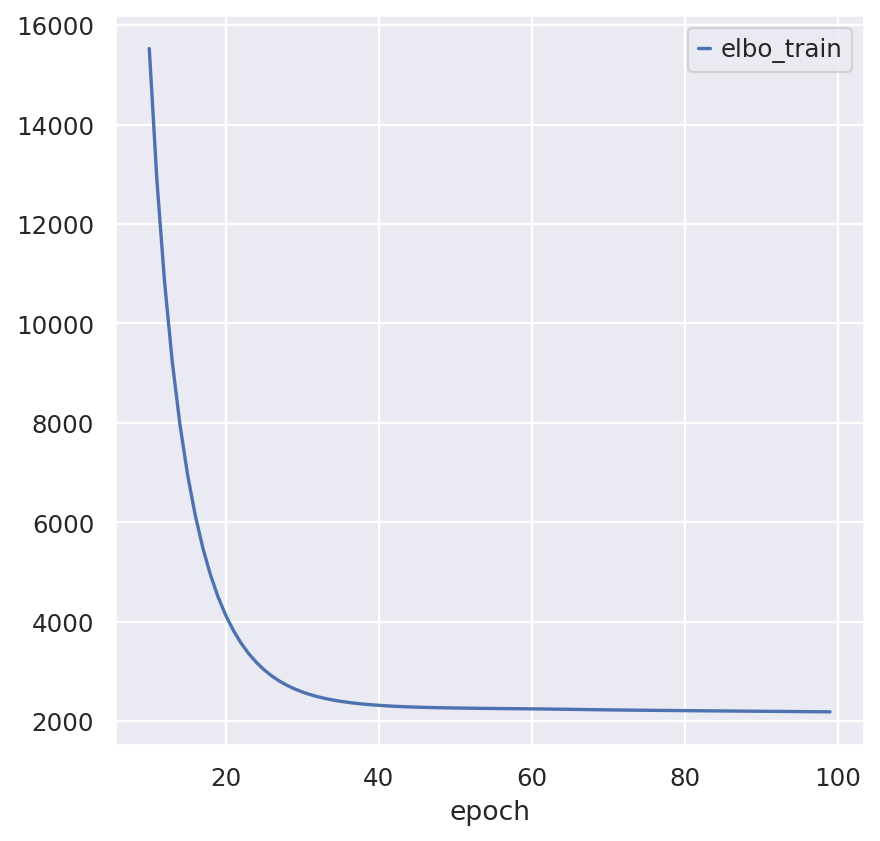

In [19]:
sc_model_path = os.path.join(save_dir.name, "sc_model")

sc_model = RNAStereoscope(sc_adata)
sc_model.train(max_epochs=100)
sc_model.history["elbo_train"][10:].plot()
sc_model.save(sc_model_path, overwrite=True)

## Infer proportion for spatial data

In [20]:
st_adata.layers["counts"] = st_adata.X.copy()
SpatialStereoscope.setup_anndata(st_adata, layer="counts")

Train _Visium_ model

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1/2000:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1/2000:   0%|          | 1/2000 [00:00<21:44,  1.53it/s]

Epoch 1/2000:   0%|          | 1/2000 [00:00<21:44,  1.53it/s, v_num=1, train_loss_step=5.28e+7, train_loss_epoch=5.48e+7]

Epoch 2/2000:   0%|          | 1/2000 [00:00<21:44,  1.53it/s, v_num=1, train_loss_step=5.28e+7, train_loss_epoch=5.48e+7]

Epoch 2/2000:   0%|          | 2/2000 [00:00<11:22,  2.93it/s, v_num=1, train_loss_step=5.28e+7, train_loss_epoch=5.48e+7]

Epoch 2/2000:   0%|          | 2/2000 [00:00<11:22,  2.93it/s, v_num=1, train_loss_step=5.15e+7, train_loss_epoch=5.33e+7]

Epoch 3/2000:   0%|          | 2/2000 [00:00<11:22,  2.93it/s, v_num=1, train_loss_step=5.15e+7, train_loss_epoch=5.33e+7]

Epoch 3/2000:   0%|          | 3/2000 [00:00<08:01,  4.15it/s, v_num=1, train_loss_step=5.15e+7, train_loss_epoch=5.33e+7]

Epoch 3/2000:   0%|          | 3/2000 [00:00<08:01,  4.15it/s, v_num=1, train_loss_step=5.05e+7, train_loss_epoch=5.18e+7]

Epoch 4/2000:   0%|          | 3/2000 [00:00<08:01,  4.15it/s, v_num=1, train_loss_step=5.05e+7, train_loss_epoch=5.18e+7]

Epoch 4/2000:   0%|          | 4/2000 [00:01<06:27,  5.15it/s, v_num=1, train_loss_step=5.05e+7, train_loss_epoch=5.18e+7]

Epoch 4/2000:   0%|          | 4/2000 [00:01<06:27,  5.15it/s, v_num=1, train_loss_step=4.78e+7, train_loss_epoch=5.04e+7]

Epoch 5/2000:   0%|          | 4/2000 [00:01<06:27,  5.15it/s, v_num=1, train_loss_step=4.78e+7, train_loss_epoch=5.04e+7]

Epoch 5/2000:   0%|          | 5/2000 [00:01<05:35,  5.95it/s, v_num=1, train_loss_step=4.78e+7, train_loss_epoch=5.04e+7]

Epoch 5/2000:   0%|          | 5/2000 [00:01<05:35,  5.95it/s, v_num=1, train_loss_step=4.87e+7, train_loss_epoch=4.9e+7] 

Epoch 6/2000:   0%|          | 5/2000 [00:01<05:35,  5.95it/s, v_num=1, train_loss_step=4.87e+7, train_loss_epoch=4.9e+7]

Epoch 6/2000:   0%|          | 6/2000 [00:01<05:03,  6.57it/s, v_num=1, train_loss_step=4.87e+7, train_loss_epoch=4.9e+7]

Epoch 6/2000:   0%|          | 6/2000 [00:01<05:03,  6.57it/s, v_num=1, train_loss_step=4.74e+7, train_loss_epoch=4.77e+7]

Epoch 7/2000:   0%|          | 6/2000 [00:01<05:03,  6.57it/s, v_num=1, train_loss_step=4.74e+7, train_loss_epoch=4.77e+7]

Epoch 7/2000:   0%|          | 7/2000 [00:01<04:43,  7.03it/s, v_num=1, train_loss_step=4.74e+7, train_loss_epoch=4.77e+7]

Epoch 7/2000:   0%|          | 7/2000 [00:01<04:43,  7.03it/s, v_num=1, train_loss_step=4.55e+7, train_loss_epoch=4.65e+7]

Epoch 8/2000:   0%|          | 7/2000 [00:01<04:43,  7.03it/s, v_num=1, train_loss_step=4.55e+7, train_loss_epoch=4.65e+7]

Epoch 8/2000:   0%|          | 8/2000 [00:01<04:30,  7.37it/s, v_num=1, train_loss_step=4.55e+7, train_loss_epoch=4.65e+7]

Epoch 8/2000:   0%|          | 8/2000 [00:01<04:30,  7.37it/s, v_num=1, train_loss_step=4.49e+7, train_loss_epoch=4.54e+7]

Epoch 9/2000:   0%|          | 8/2000 [00:01<04:30,  7.37it/s, v_num=1, train_loss_step=4.49e+7, train_loss_epoch=4.54e+7]

Epoch 9/2000:   0%|          | 9/2000 [00:01<04:21,  7.60it/s, v_num=1, train_loss_step=4.49e+7, train_loss_epoch=4.54e+7]

Epoch 9/2000:   0%|          | 9/2000 [00:01<04:21,  7.60it/s, v_num=1, train_loss_step=4.41e+7, train_loss_epoch=4.43e+7]

Epoch 10/2000:   0%|          | 9/2000 [00:01<04:21,  7.60it/s, v_num=1, train_loss_step=4.41e+7, train_loss_epoch=4.43e+7]

Epoch 10/2000:   0%|          | 10/2000 [00:01<04:15,  7.78it/s, v_num=1, train_loss_step=4.41e+7, train_loss_epoch=4.43e+7]

Epoch 10/2000:   0%|          | 10/2000 [00:01<04:15,  7.78it/s, v_num=1, train_loss_step=4.17e+7, train_loss_epoch=4.34e+7]

Epoch 11/2000:   0%|          | 10/2000 [00:01<04:15,  7.78it/s, v_num=1, train_loss_step=4.17e+7, train_loss_epoch=4.34e+7]

Epoch 11/2000:   1%|          | 11/2000 [00:01<04:11,  7.90it/s, v_num=1, train_loss_step=4.17e+7, train_loss_epoch=4.34e+7]

Epoch 11/2000:   1%|          | 11/2000 [00:01<04:11,  7.90it/s, v_num=1, train_loss_step=4.31e+7, train_loss_epoch=4.24e+7]

Epoch 12/2000:   1%|          | 11/2000 [00:01<04:11,  7.90it/s, v_num=1, train_loss_step=4.31e+7, train_loss_epoch=4.24e+7]

Epoch 12/2000:   1%|          | 12/2000 [00:01<04:08,  7.99it/s, v_num=1, train_loss_step=4.31e+7, train_loss_epoch=4.24e+7]

Epoch 12/2000:   1%|          | 12/2000 [00:01<04:08,  7.99it/s, v_num=1, train_loss_step=4.32e+7, train_loss_epoch=4.16e+7]

Epoch 13/2000:   1%|          | 12/2000 [00:01<04:08,  7.99it/s, v_num=1, train_loss_step=4.32e+7, train_loss_epoch=4.16e+7]

Epoch 13/2000:   1%|          | 13/2000 [00:02<04:07,  8.04it/s, v_num=1, train_loss_step=4.32e+7, train_loss_epoch=4.16e+7]

Epoch 13/2000:   1%|          | 13/2000 [00:02<04:07,  8.04it/s, v_num=1, train_loss_step=3.89e+7, train_loss_epoch=4.07e+7]

Epoch 14/2000:   1%|          | 13/2000 [00:02<04:07,  8.04it/s, v_num=1, train_loss_step=3.89e+7, train_loss_epoch=4.07e+7]

Epoch 14/2000:   1%|          | 14/2000 [00:02<04:05,  8.09it/s, v_num=1, train_loss_step=3.89e+7, train_loss_epoch=4.07e+7]

Epoch 14/2000:   1%|          | 14/2000 [00:02<04:05,  8.09it/s, v_num=1, train_loss_step=3.97e+7, train_loss_epoch=3.99e+7]

Epoch 15/2000:   1%|          | 14/2000 [00:02<04:05,  8.09it/s, v_num=1, train_loss_step=3.97e+7, train_loss_epoch=3.99e+7]

Epoch 15/2000:   1%|          | 15/2000 [00:02<04:04,  8.13it/s, v_num=1, train_loss_step=3.97e+7, train_loss_epoch=3.99e+7]

Epoch 15/2000:   1%|          | 15/2000 [00:02<04:04,  8.13it/s, v_num=1, train_loss_step=3.82e+7, train_loss_epoch=3.92e+7]

Epoch 16/2000:   1%|          | 15/2000 [00:02<04:04,  8.13it/s, v_num=1, train_loss_step=3.82e+7, train_loss_epoch=3.92e+7]

Epoch 16/2000:   1%|          | 16/2000 [00:02<04:03,  8.15it/s, v_num=1, train_loss_step=3.82e+7, train_loss_epoch=3.92e+7]

Epoch 16/2000:   1%|          | 16/2000 [00:02<04:03,  8.15it/s, v_num=1, train_loss_step=3.76e+7, train_loss_epoch=3.85e+7]

Epoch 17/2000:   1%|          | 16/2000 [00:02<04:03,  8.15it/s, v_num=1, train_loss_step=3.76e+7, train_loss_epoch=3.85e+7]

Epoch 17/2000:   1%|          | 17/2000 [00:02<04:02,  8.16it/s, v_num=1, train_loss_step=3.76e+7, train_loss_epoch=3.85e+7]

Epoch 17/2000:   1%|          | 17/2000 [00:02<04:02,  8.16it/s, v_num=1, train_loss_step=3.81e+7, train_loss_epoch=3.78e+7]

Epoch 18/2000:   1%|          | 17/2000 [00:02<04:02,  8.16it/s, v_num=1, train_loss_step=3.81e+7, train_loss_epoch=3.78e+7]

Epoch 18/2000:   1%|          | 18/2000 [00:02<04:02,  8.18it/s, v_num=1, train_loss_step=3.81e+7, train_loss_epoch=3.78e+7]

Epoch 18/2000:   1%|          | 18/2000 [00:02<04:02,  8.18it/s, v_num=1, train_loss_step=3.82e+7, train_loss_epoch=3.72e+7]

Epoch 19/2000:   1%|          | 18/2000 [00:02<04:02,  8.18it/s, v_num=1, train_loss_step=3.82e+7, train_loss_epoch=3.72e+7]

Epoch 19/2000:   1%|          | 19/2000 [00:02<04:01,  8.19it/s, v_num=1, train_loss_step=3.82e+7, train_loss_epoch=3.72e+7]

Epoch 19/2000:   1%|          | 19/2000 [00:02<04:01,  8.19it/s, v_num=1, train_loss_step=3.79e+7, train_loss_epoch=3.65e+7]

Epoch 20/2000:   1%|          | 19/2000 [00:02<04:01,  8.19it/s, v_num=1, train_loss_step=3.79e+7, train_loss_epoch=3.65e+7]

Epoch 20/2000:   1%|          | 20/2000 [00:02<04:01,  8.20it/s, v_num=1, train_loss_step=3.79e+7, train_loss_epoch=3.65e+7]

Epoch 20/2000:   1%|          | 20/2000 [00:02<04:01,  8.20it/s, v_num=1, train_loss_step=3.63e+7, train_loss_epoch=3.59e+7]

Epoch 21/2000:   1%|          | 20/2000 [00:02<04:01,  8.20it/s, v_num=1, train_loss_step=3.63e+7, train_loss_epoch=3.59e+7]

Epoch 21/2000:   1%|          | 21/2000 [00:03<04:01,  8.19it/s, v_num=1, train_loss_step=3.63e+7, train_loss_epoch=3.59e+7]

Epoch 21/2000:   1%|          | 21/2000 [00:03<04:01,  8.19it/s, v_num=1, train_loss_step=3.7e+7, train_loss_epoch=3.54e+7] 

Epoch 22/2000:   1%|          | 21/2000 [00:03<04:01,  8.19it/s, v_num=1, train_loss_step=3.7e+7, train_loss_epoch=3.54e+7]

Epoch 22/2000:   1%|          | 22/2000 [00:03<04:01,  8.20it/s, v_num=1, train_loss_step=3.7e+7, train_loss_epoch=3.54e+7]

Epoch 22/2000:   1%|          | 22/2000 [00:03<04:01,  8.20it/s, v_num=1, train_loss_step=3.51e+7, train_loss_epoch=3.48e+7]

Epoch 23/2000:   1%|          | 22/2000 [00:03<04:01,  8.20it/s, v_num=1, train_loss_step=3.51e+7, train_loss_epoch=3.48e+7]

Epoch 23/2000:   1%|          | 23/2000 [00:03<04:04,  8.07it/s, v_num=1, train_loss_step=3.51e+7, train_loss_epoch=3.48e+7]

Epoch 23/2000:   1%|          | 23/2000 [00:03<04:04,  8.07it/s, v_num=1, train_loss_step=3.42e+7, train_loss_epoch=3.43e+7]

Epoch 24/2000:   1%|          | 23/2000 [00:03<04:04,  8.07it/s, v_num=1, train_loss_step=3.42e+7, train_loss_epoch=3.43e+7]

Epoch 24/2000:   1%|          | 24/2000 [00:03<04:07,  8.00it/s, v_num=1, train_loss_step=3.42e+7, train_loss_epoch=3.43e+7]

Epoch 24/2000:   1%|          | 24/2000 [00:03<04:07,  8.00it/s, v_num=1, train_loss_step=3.38e+7, train_loss_epoch=3.38e+7]

Epoch 25/2000:   1%|          | 24/2000 [00:03<04:07,  8.00it/s, v_num=1, train_loss_step=3.38e+7, train_loss_epoch=3.38e+7]

Epoch 25/2000:   1%|▏         | 25/2000 [00:03<04:08,  7.95it/s, v_num=1, train_loss_step=3.38e+7, train_loss_epoch=3.38e+7]

Epoch 25/2000:   1%|▏         | 25/2000 [00:03<04:08,  7.95it/s, v_num=1, train_loss_step=3.39e+7, train_loss_epoch=3.33e+7]

Epoch 26/2000:   1%|▏         | 25/2000 [00:03<04:08,  7.95it/s, v_num=1, train_loss_step=3.39e+7, train_loss_epoch=3.33e+7]

Epoch 26/2000:   1%|▏         | 26/2000 [00:03<04:09,  7.91it/s, v_num=1, train_loss_step=3.39e+7, train_loss_epoch=3.33e+7]

Epoch 26/2000:   1%|▏         | 26/2000 [00:03<04:09,  7.91it/s, v_num=1, train_loss_step=3.21e+7, train_loss_epoch=3.28e+7]

Epoch 27/2000:   1%|▏         | 26/2000 [00:03<04:09,  7.91it/s, v_num=1, train_loss_step=3.21e+7, train_loss_epoch=3.28e+7]

Epoch 27/2000:   1%|▏         | 27/2000 [00:03<04:10,  7.88it/s, v_num=1, train_loss_step=3.21e+7, train_loss_epoch=3.28e+7]

Epoch 27/2000:   1%|▏         | 27/2000 [00:03<04:10,  7.88it/s, v_num=1, train_loss_step=3.17e+7, train_loss_epoch=3.23e+7]

Epoch 28/2000:   1%|▏         | 27/2000 [00:03<04:10,  7.88it/s, v_num=1, train_loss_step=3.17e+7, train_loss_epoch=3.23e+7]

Epoch 28/2000:   1%|▏         | 28/2000 [00:03<04:10,  7.86it/s, v_num=1, train_loss_step=3.17e+7, train_loss_epoch=3.23e+7]

Epoch 28/2000:   1%|▏         | 28/2000 [00:03<04:10,  7.86it/s, v_num=1, train_loss_step=3.26e+7, train_loss_epoch=3.19e+7]

Epoch 29/2000:   1%|▏         | 28/2000 [00:03<04:10,  7.86it/s, v_num=1, train_loss_step=3.26e+7, train_loss_epoch=3.19e+7]

Epoch 29/2000:   1%|▏         | 29/2000 [00:04<04:11,  7.83it/s, v_num=1, train_loss_step=3.26e+7, train_loss_epoch=3.19e+7]

Epoch 29/2000:   1%|▏         | 29/2000 [00:04<04:11,  7.83it/s, v_num=1, train_loss_step=3.3e+7, train_loss_epoch=3.15e+7] 

Epoch 30/2000:   1%|▏         | 29/2000 [00:04<04:11,  7.83it/s, v_num=1, train_loss_step=3.3e+7, train_loss_epoch=3.15e+7]

Epoch 30/2000:   2%|▏         | 30/2000 [00:04<04:11,  7.83it/s, v_num=1, train_loss_step=3.3e+7, train_loss_epoch=3.15e+7]

Epoch 30/2000:   2%|▏         | 30/2000 [00:04<04:11,  7.83it/s, v_num=1, train_loss_step=3.02e+7, train_loss_epoch=3.1e+7]

Epoch 31/2000:   2%|▏         | 30/2000 [00:04<04:11,  7.83it/s, v_num=1, train_loss_step=3.02e+7, train_loss_epoch=3.1e+7]

Epoch 31/2000:   2%|▏         | 31/2000 [00:04<04:11,  7.83it/s, v_num=1, train_loss_step=3.02e+7, train_loss_epoch=3.1e+7]

Epoch 31/2000:   2%|▏         | 31/2000 [00:04<04:11,  7.83it/s, v_num=1, train_loss_step=3.17e+7, train_loss_epoch=3.06e+7]

Epoch 32/2000:   2%|▏         | 31/2000 [00:04<04:11,  7.83it/s, v_num=1, train_loss_step=3.17e+7, train_loss_epoch=3.06e+7]

Epoch 32/2000:   2%|▏         | 32/2000 [00:04<04:11,  7.82it/s, v_num=1, train_loss_step=3.17e+7, train_loss_epoch=3.06e+7]

Epoch 32/2000:   2%|▏         | 32/2000 [00:04<04:11,  7.82it/s, v_num=1, train_loss_step=3.08e+7, train_loss_epoch=3.02e+7]

Epoch 33/2000:   2%|▏         | 32/2000 [00:04<04:11,  7.82it/s, v_num=1, train_loss_step=3.08e+7, train_loss_epoch=3.02e+7]

Epoch 33/2000:   2%|▏         | 33/2000 [00:04<04:11,  7.83it/s, v_num=1, train_loss_step=3.08e+7, train_loss_epoch=3.02e+7]

Epoch 33/2000:   2%|▏         | 33/2000 [00:04<04:11,  7.83it/s, v_num=1, train_loss_step=2.89e+7, train_loss_epoch=2.98e+7]

Epoch 34/2000:   2%|▏         | 33/2000 [00:04<04:11,  7.83it/s, v_num=1, train_loss_step=2.89e+7, train_loss_epoch=2.98e+7]

Epoch 34/2000:   2%|▏         | 34/2000 [00:04<04:11,  7.82it/s, v_num=1, train_loss_step=2.89e+7, train_loss_epoch=2.98e+7]

Epoch 34/2000:   2%|▏         | 34/2000 [00:04<04:11,  7.82it/s, v_num=1, train_loss_step=2.97e+7, train_loss_epoch=2.95e+7]

Epoch 35/2000:   2%|▏         | 34/2000 [00:04<04:11,  7.82it/s, v_num=1, train_loss_step=2.97e+7, train_loss_epoch=2.95e+7]

Epoch 35/2000:   2%|▏         | 35/2000 [00:04<04:11,  7.82it/s, v_num=1, train_loss_step=2.97e+7, train_loss_epoch=2.95e+7]

Epoch 35/2000:   2%|▏         | 35/2000 [00:04<04:11,  7.82it/s, v_num=1, train_loss_step=2.94e+7, train_loss_epoch=2.91e+7]

Epoch 36/2000:   2%|▏         | 35/2000 [00:04<04:11,  7.82it/s, v_num=1, train_loss_step=2.94e+7, train_loss_epoch=2.91e+7]

Epoch 36/2000:   2%|▏         | 36/2000 [00:05<04:11,  7.82it/s, v_num=1, train_loss_step=2.94e+7, train_loss_epoch=2.91e+7]

Epoch 36/2000:   2%|▏         | 36/2000 [00:05<04:11,  7.82it/s, v_num=1, train_loss_step=2.89e+7, train_loss_epoch=2.88e+7]

Epoch 37/2000:   2%|▏         | 36/2000 [00:05<04:11,  7.82it/s, v_num=1, train_loss_step=2.89e+7, train_loss_epoch=2.88e+7]

Epoch 37/2000:   2%|▏         | 37/2000 [00:05<04:11,  7.82it/s, v_num=1, train_loss_step=2.89e+7, train_loss_epoch=2.88e+7]

Epoch 37/2000:   2%|▏         | 37/2000 [00:05<04:11,  7.82it/s, v_num=1, train_loss_step=2.85e+7, train_loss_epoch=2.84e+7]

Epoch 38/2000:   2%|▏         | 37/2000 [00:05<04:11,  7.82it/s, v_num=1, train_loss_step=2.85e+7, train_loss_epoch=2.84e+7]

Epoch 38/2000:   2%|▏         | 38/2000 [00:05<04:10,  7.82it/s, v_num=1, train_loss_step=2.85e+7, train_loss_epoch=2.84e+7]

Epoch 38/2000:   2%|▏         | 38/2000 [00:05<04:10,  7.82it/s, v_num=1, train_loss_step=2.87e+7, train_loss_epoch=2.81e+7]

Epoch 39/2000:   2%|▏         | 38/2000 [00:05<04:10,  7.82it/s, v_num=1, train_loss_step=2.87e+7, train_loss_epoch=2.81e+7]

Epoch 39/2000:   2%|▏         | 39/2000 [00:05<04:10,  7.82it/s, v_num=1, train_loss_step=2.87e+7, train_loss_epoch=2.81e+7]

Epoch 39/2000:   2%|▏         | 39/2000 [00:05<04:10,  7.82it/s, v_num=1, train_loss_step=2.67e+7, train_loss_epoch=2.78e+7]

Epoch 40/2000:   2%|▏         | 39/2000 [00:05<04:10,  7.82it/s, v_num=1, train_loss_step=2.67e+7, train_loss_epoch=2.78e+7]

Epoch 40/2000:   2%|▏         | 40/2000 [00:05<04:10,  7.82it/s, v_num=1, train_loss_step=2.67e+7, train_loss_epoch=2.78e+7]

Epoch 40/2000:   2%|▏         | 40/2000 [00:05<04:10,  7.82it/s, v_num=1, train_loss_step=2.75e+7, train_loss_epoch=2.75e+7]

Epoch 41/2000:   2%|▏         | 40/2000 [00:05<04:10,  7.82it/s, v_num=1, train_loss_step=2.75e+7, train_loss_epoch=2.75e+7]

Epoch 41/2000:   2%|▏         | 41/2000 [00:05<04:10,  7.82it/s, v_num=1, train_loss_step=2.75e+7, train_loss_epoch=2.75e+7]

Epoch 41/2000:   2%|▏         | 41/2000 [00:05<04:10,  7.82it/s, v_num=1, train_loss_step=2.76e+7, train_loss_epoch=2.72e+7]

Epoch 42/2000:   2%|▏         | 41/2000 [00:05<04:10,  7.82it/s, v_num=1, train_loss_step=2.76e+7, train_loss_epoch=2.72e+7]

Epoch 42/2000:   2%|▏         | 42/2000 [00:05<04:10,  7.82it/s, v_num=1, train_loss_step=2.76e+7, train_loss_epoch=2.72e+7]

Epoch 42/2000:   2%|▏         | 42/2000 [00:05<04:10,  7.82it/s, v_num=1, train_loss_step=2.73e+7, train_loss_epoch=2.69e+7]

Epoch 43/2000:   2%|▏         | 42/2000 [00:05<04:10,  7.82it/s, v_num=1, train_loss_step=2.73e+7, train_loss_epoch=2.69e+7]

Epoch 43/2000:   2%|▏         | 43/2000 [00:05<04:10,  7.82it/s, v_num=1, train_loss_step=2.73e+7, train_loss_epoch=2.69e+7]

Epoch 43/2000:   2%|▏         | 43/2000 [00:05<04:10,  7.82it/s, v_num=1, train_loss_step=2.6e+7, train_loss_epoch=2.66e+7] 

Epoch 44/2000:   2%|▏         | 43/2000 [00:05<04:10,  7.82it/s, v_num=1, train_loss_step=2.6e+7, train_loss_epoch=2.66e+7]

Epoch 44/2000:   2%|▏         | 44/2000 [00:06<04:10,  7.81it/s, v_num=1, train_loss_step=2.6e+7, train_loss_epoch=2.66e+7]

Epoch 44/2000:   2%|▏         | 44/2000 [00:06<04:10,  7.81it/s, v_num=1, train_loss_step=2.63e+7, train_loss_epoch=2.63e+7]

Epoch 45/2000:   2%|▏         | 44/2000 [00:06<04:10,  7.81it/s, v_num=1, train_loss_step=2.63e+7, train_loss_epoch=2.63e+7]

Epoch 45/2000:   2%|▏         | 45/2000 [00:06<04:10,  7.81it/s, v_num=1, train_loss_step=2.63e+7, train_loss_epoch=2.63e+7]

Epoch 45/2000:   2%|▏         | 45/2000 [00:06<04:10,  7.81it/s, v_num=1, train_loss_step=2.64e+7, train_loss_epoch=2.6e+7] 

Epoch 46/2000:   2%|▏         | 45/2000 [00:06<04:10,  7.81it/s, v_num=1, train_loss_step=2.64e+7, train_loss_epoch=2.6e+7]

Epoch 46/2000:   2%|▏         | 46/2000 [00:06<04:10,  7.81it/s, v_num=1, train_loss_step=2.64e+7, train_loss_epoch=2.6e+7]

Epoch 46/2000:   2%|▏         | 46/2000 [00:06<04:10,  7.81it/s, v_num=1, train_loss_step=2.62e+7, train_loss_epoch=2.58e+7]

Epoch 47/2000:   2%|▏         | 46/2000 [00:06<04:10,  7.81it/s, v_num=1, train_loss_step=2.62e+7, train_loss_epoch=2.58e+7]

Epoch 47/2000:   2%|▏         | 47/2000 [00:06<04:10,  7.81it/s, v_num=1, train_loss_step=2.62e+7, train_loss_epoch=2.58e+7]

Epoch 47/2000:   2%|▏         | 47/2000 [00:06<04:10,  7.81it/s, v_num=1, train_loss_step=2.62e+7, train_loss_epoch=2.55e+7]

Epoch 48/2000:   2%|▏         | 47/2000 [00:06<04:10,  7.81it/s, v_num=1, train_loss_step=2.62e+7, train_loss_epoch=2.55e+7]

Epoch 48/2000:   2%|▏         | 48/2000 [00:06<04:10,  7.81it/s, v_num=1, train_loss_step=2.62e+7, train_loss_epoch=2.55e+7]

Epoch 48/2000:   2%|▏         | 48/2000 [00:06<04:10,  7.81it/s, v_num=1, train_loss_step=2.46e+7, train_loss_epoch=2.53e+7]

Epoch 49/2000:   2%|▏         | 48/2000 [00:06<04:10,  7.81it/s, v_num=1, train_loss_step=2.46e+7, train_loss_epoch=2.53e+7]

Epoch 49/2000:   2%|▏         | 49/2000 [00:06<04:09,  7.81it/s, v_num=1, train_loss_step=2.46e+7, train_loss_epoch=2.53e+7]

Epoch 49/2000:   2%|▏         | 49/2000 [00:06<04:09,  7.81it/s, v_num=1, train_loss_step=2.55e+7, train_loss_epoch=2.5e+7] 

Epoch 50/2000:   2%|▏         | 49/2000 [00:06<04:09,  7.81it/s, v_num=1, train_loss_step=2.55e+7, train_loss_epoch=2.5e+7]

Epoch 50/2000:   2%|▎         | 50/2000 [00:06<04:09,  7.81it/s, v_num=1, train_loss_step=2.55e+7, train_loss_epoch=2.5e+7]

Epoch 50/2000:   2%|▎         | 50/2000 [00:06<04:09,  7.81it/s, v_num=1, train_loss_step=2.57e+7, train_loss_epoch=2.48e+7]

Epoch 51/2000:   2%|▎         | 50/2000 [00:06<04:09,  7.81it/s, v_num=1, train_loss_step=2.57e+7, train_loss_epoch=2.48e+7]

Epoch 51/2000:   3%|▎         | 51/2000 [00:06<04:09,  7.81it/s, v_num=1, train_loss_step=2.57e+7, train_loss_epoch=2.48e+7]

Epoch 51/2000:   3%|▎         | 51/2000 [00:06<04:09,  7.81it/s, v_num=1, train_loss_step=2.47e+7, train_loss_epoch=2.46e+7]

Epoch 52/2000:   3%|▎         | 51/2000 [00:06<04:09,  7.81it/s, v_num=1, train_loss_step=2.47e+7, train_loss_epoch=2.46e+7]

Epoch 52/2000:   3%|▎         | 52/2000 [00:07<04:09,  7.82it/s, v_num=1, train_loss_step=2.47e+7, train_loss_epoch=2.46e+7]

Epoch 52/2000:   3%|▎         | 52/2000 [00:07<04:09,  7.82it/s, v_num=1, train_loss_step=2.37e+7, train_loss_epoch=2.43e+7]

Epoch 53/2000:   3%|▎         | 52/2000 [00:07<04:09,  7.82it/s, v_num=1, train_loss_step=2.37e+7, train_loss_epoch=2.43e+7]

Epoch 53/2000:   3%|▎         | 53/2000 [00:07<04:08,  7.82it/s, v_num=1, train_loss_step=2.37e+7, train_loss_epoch=2.43e+7]

Epoch 53/2000:   3%|▎         | 53/2000 [00:07<04:08,  7.82it/s, v_num=1, train_loss_step=2.41e+7, train_loss_epoch=2.41e+7]

Epoch 54/2000:   3%|▎         | 53/2000 [00:07<04:08,  7.82it/s, v_num=1, train_loss_step=2.41e+7, train_loss_epoch=2.41e+7]

Epoch 54/2000:   3%|▎         | 54/2000 [00:07<04:08,  7.82it/s, v_num=1, train_loss_step=2.41e+7, train_loss_epoch=2.41e+7]

Epoch 54/2000:   3%|▎         | 54/2000 [00:07<04:08,  7.82it/s, v_num=1, train_loss_step=2.48e+7, train_loss_epoch=2.39e+7]

Epoch 55/2000:   3%|▎         | 54/2000 [00:07<04:08,  7.82it/s, v_num=1, train_loss_step=2.48e+7, train_loss_epoch=2.39e+7]

Epoch 55/2000:   3%|▎         | 55/2000 [00:07<04:08,  7.82it/s, v_num=1, train_loss_step=2.48e+7, train_loss_epoch=2.39e+7]

Epoch 55/2000:   3%|▎         | 55/2000 [00:07<04:08,  7.82it/s, v_num=1, train_loss_step=2.34e+7, train_loss_epoch=2.37e+7]

Epoch 56/2000:   3%|▎         | 55/2000 [00:07<04:08,  7.82it/s, v_num=1, train_loss_step=2.34e+7, train_loss_epoch=2.37e+7]

Epoch 56/2000:   3%|▎         | 56/2000 [00:07<04:08,  7.83it/s, v_num=1, train_loss_step=2.34e+7, train_loss_epoch=2.37e+7]

Epoch 56/2000:   3%|▎         | 56/2000 [00:07<04:08,  7.83it/s, v_num=1, train_loss_step=2.3e+7, train_loss_epoch=2.35e+7] 

Epoch 57/2000:   3%|▎         | 56/2000 [00:07<04:08,  7.83it/s, v_num=1, train_loss_step=2.3e+7, train_loss_epoch=2.35e+7]

Epoch 57/2000:   3%|▎         | 57/2000 [00:07<04:08,  7.83it/s, v_num=1, train_loss_step=2.3e+7, train_loss_epoch=2.35e+7]

Epoch 57/2000:   3%|▎         | 57/2000 [00:07<04:08,  7.83it/s, v_num=1, train_loss_step=2.32e+7, train_loss_epoch=2.33e+7]

Epoch 58/2000:   3%|▎         | 57/2000 [00:07<04:08,  7.83it/s, v_num=1, train_loss_step=2.32e+7, train_loss_epoch=2.33e+7]

Epoch 58/2000:   3%|▎         | 58/2000 [00:07<04:08,  7.83it/s, v_num=1, train_loss_step=2.32e+7, train_loss_epoch=2.33e+7]

Epoch 58/2000:   3%|▎         | 58/2000 [00:07<04:08,  7.83it/s, v_num=1, train_loss_step=2.37e+7, train_loss_epoch=2.31e+7]

Epoch 59/2000:   3%|▎         | 58/2000 [00:07<04:08,  7.83it/s, v_num=1, train_loss_step=2.37e+7, train_loss_epoch=2.31e+7]

Epoch 59/2000:   3%|▎         | 59/2000 [00:07<04:08,  7.82it/s, v_num=1, train_loss_step=2.37e+7, train_loss_epoch=2.31e+7]

Epoch 59/2000:   3%|▎         | 59/2000 [00:07<04:08,  7.82it/s, v_num=1, train_loss_step=2.4e+7, train_loss_epoch=2.29e+7] 

Epoch 60/2000:   3%|▎         | 59/2000 [00:07<04:08,  7.82it/s, v_num=1, train_loss_step=2.4e+7, train_loss_epoch=2.29e+7]

Epoch 60/2000:   3%|▎         | 60/2000 [00:08<04:08,  7.81it/s, v_num=1, train_loss_step=2.4e+7, train_loss_epoch=2.29e+7]

Epoch 60/2000:   3%|▎         | 60/2000 [00:08<04:08,  7.81it/s, v_num=1, train_loss_step=2.41e+7, train_loss_epoch=2.27e+7]

Epoch 61/2000:   3%|▎         | 60/2000 [00:08<04:08,  7.81it/s, v_num=1, train_loss_step=2.41e+7, train_loss_epoch=2.27e+7]

Epoch 61/2000:   3%|▎         | 61/2000 [00:08<04:08,  7.81it/s, v_num=1, train_loss_step=2.41e+7, train_loss_epoch=2.27e+7]

Epoch 61/2000:   3%|▎         | 61/2000 [00:08<04:08,  7.81it/s, v_num=1, train_loss_step=2.25e+7, train_loss_epoch=2.25e+7]

Epoch 62/2000:   3%|▎         | 61/2000 [00:08<04:08,  7.81it/s, v_num=1, train_loss_step=2.25e+7, train_loss_epoch=2.25e+7]

Epoch 62/2000:   3%|▎         | 62/2000 [00:08<04:08,  7.81it/s, v_num=1, train_loss_step=2.25e+7, train_loss_epoch=2.25e+7]

Epoch 62/2000:   3%|▎         | 62/2000 [00:08<04:08,  7.81it/s, v_num=1, train_loss_step=2.23e+7, train_loss_epoch=2.24e+7]

Epoch 63/2000:   3%|▎         | 62/2000 [00:08<04:08,  7.81it/s, v_num=1, train_loss_step=2.23e+7, train_loss_epoch=2.24e+7]

Epoch 63/2000:   3%|▎         | 63/2000 [00:08<04:07,  7.81it/s, v_num=1, train_loss_step=2.23e+7, train_loss_epoch=2.24e+7]

Epoch 63/2000:   3%|▎         | 63/2000 [00:08<04:07,  7.81it/s, v_num=1, train_loss_step=2.35e+7, train_loss_epoch=2.22e+7]

Epoch 64/2000:   3%|▎         | 63/2000 [00:08<04:07,  7.81it/s, v_num=1, train_loss_step=2.35e+7, train_loss_epoch=2.22e+7]

Epoch 64/2000:   3%|▎         | 64/2000 [00:08<04:07,  7.81it/s, v_num=1, train_loss_step=2.35e+7, train_loss_epoch=2.22e+7]

Epoch 64/2000:   3%|▎         | 64/2000 [00:08<04:07,  7.81it/s, v_num=1, train_loss_step=2.21e+7, train_loss_epoch=2.2e+7] 

Epoch 65/2000:   3%|▎         | 64/2000 [00:08<04:07,  7.81it/s, v_num=1, train_loss_step=2.21e+7, train_loss_epoch=2.2e+7]

Epoch 65/2000:   3%|▎         | 65/2000 [00:08<04:07,  7.82it/s, v_num=1, train_loss_step=2.21e+7, train_loss_epoch=2.2e+7]

Epoch 65/2000:   3%|▎         | 65/2000 [00:08<04:07,  7.82it/s, v_num=1, train_loss_step=2.05e+7, train_loss_epoch=2.19e+7]

Epoch 66/2000:   3%|▎         | 65/2000 [00:08<04:07,  7.82it/s, v_num=1, train_loss_step=2.05e+7, train_loss_epoch=2.19e+7]

Epoch 66/2000:   3%|▎         | 66/2000 [00:08<04:07,  7.82it/s, v_num=1, train_loss_step=2.05e+7, train_loss_epoch=2.19e+7]

Epoch 66/2000:   3%|▎         | 66/2000 [00:08<04:07,  7.82it/s, v_num=1, train_loss_step=2.16e+7, train_loss_epoch=2.17e+7]

Epoch 67/2000:   3%|▎         | 66/2000 [00:08<04:07,  7.82it/s, v_num=1, train_loss_step=2.16e+7, train_loss_epoch=2.17e+7]

Epoch 67/2000:   3%|▎         | 67/2000 [00:08<04:07,  7.81it/s, v_num=1, train_loss_step=2.16e+7, train_loss_epoch=2.17e+7]

Epoch 67/2000:   3%|▎         | 67/2000 [00:08<04:07,  7.81it/s, v_num=1, train_loss_step=2.05e+7, train_loss_epoch=2.15e+7]

Epoch 68/2000:   3%|▎         | 67/2000 [00:08<04:07,  7.81it/s, v_num=1, train_loss_step=2.05e+7, train_loss_epoch=2.15e+7]

Epoch 68/2000:   3%|▎         | 68/2000 [00:09<04:07,  7.82it/s, v_num=1, train_loss_step=2.05e+7, train_loss_epoch=2.15e+7]

Epoch 68/2000:   3%|▎         | 68/2000 [00:09<04:07,  7.82it/s, v_num=1, train_loss_step=2.17e+7, train_loss_epoch=2.14e+7]

Epoch 69/2000:   3%|▎         | 68/2000 [00:09<04:07,  7.82it/s, v_num=1, train_loss_step=2.17e+7, train_loss_epoch=2.14e+7]

Epoch 69/2000:   3%|▎         | 69/2000 [00:09<04:06,  7.82it/s, v_num=1, train_loss_step=2.17e+7, train_loss_epoch=2.14e+7]

Epoch 69/2000:   3%|▎         | 69/2000 [00:09<04:06,  7.82it/s, v_num=1, train_loss_step=2.16e+7, train_loss_epoch=2.12e+7]

Epoch 70/2000:   3%|▎         | 69/2000 [00:09<04:06,  7.82it/s, v_num=1, train_loss_step=2.16e+7, train_loss_epoch=2.12e+7]

Epoch 70/2000:   4%|▎         | 70/2000 [00:09<04:06,  7.83it/s, v_num=1, train_loss_step=2.16e+7, train_loss_epoch=2.12e+7]

Epoch 70/2000:   4%|▎         | 70/2000 [00:09<04:06,  7.83it/s, v_num=1, train_loss_step=2.05e+7, train_loss_epoch=2.11e+7]

Epoch 71/2000:   4%|▎         | 70/2000 [00:09<04:06,  7.83it/s, v_num=1, train_loss_step=2.05e+7, train_loss_epoch=2.11e+7]

Epoch 71/2000:   4%|▎         | 71/2000 [00:09<04:06,  7.82it/s, v_num=1, train_loss_step=2.05e+7, train_loss_epoch=2.11e+7]

Epoch 71/2000:   4%|▎         | 71/2000 [00:09<04:06,  7.82it/s, v_num=1, train_loss_step=2.05e+7, train_loss_epoch=2.09e+7]

Epoch 72/2000:   4%|▎         | 71/2000 [00:09<04:06,  7.82it/s, v_num=1, train_loss_step=2.05e+7, train_loss_epoch=2.09e+7]

Epoch 72/2000:   4%|▎         | 72/2000 [00:09<04:06,  7.82it/s, v_num=1, train_loss_step=2.05e+7, train_loss_epoch=2.09e+7]

Epoch 72/2000:   4%|▎         | 72/2000 [00:09<04:06,  7.82it/s, v_num=1, train_loss_step=2.08e+7, train_loss_epoch=2.08e+7]

Epoch 73/2000:   4%|▎         | 72/2000 [00:09<04:06,  7.82it/s, v_num=1, train_loss_step=2.08e+7, train_loss_epoch=2.08e+7]

Epoch 73/2000:   4%|▎         | 73/2000 [00:09<04:06,  7.83it/s, v_num=1, train_loss_step=2.08e+7, train_loss_epoch=2.08e+7]

Epoch 73/2000:   4%|▎         | 73/2000 [00:09<04:06,  7.83it/s, v_num=1, train_loss_step=2.01e+7, train_loss_epoch=2.07e+7]

Epoch 74/2000:   4%|▎         | 73/2000 [00:09<04:06,  7.83it/s, v_num=1, train_loss_step=2.01e+7, train_loss_epoch=2.07e+7]

Epoch 74/2000:   4%|▎         | 74/2000 [00:09<04:06,  7.83it/s, v_num=1, train_loss_step=2.01e+7, train_loss_epoch=2.07e+7]

Epoch 74/2000:   4%|▎         | 74/2000 [00:09<04:06,  7.83it/s, v_num=1, train_loss_step=2.06e+7, train_loss_epoch=2.05e+7]

Epoch 75/2000:   4%|▎         | 74/2000 [00:09<04:06,  7.83it/s, v_num=1, train_loss_step=2.06e+7, train_loss_epoch=2.05e+7]

Epoch 75/2000:   4%|▍         | 75/2000 [00:09<04:05,  7.83it/s, v_num=1, train_loss_step=2.06e+7, train_loss_epoch=2.05e+7]

Epoch 75/2000:   4%|▍         | 75/2000 [00:09<04:05,  7.83it/s, v_num=1, train_loss_step=2.05e+7, train_loss_epoch=2.04e+7]

Epoch 76/2000:   4%|▍         | 75/2000 [00:09<04:05,  7.83it/s, v_num=1, train_loss_step=2.05e+7, train_loss_epoch=2.04e+7]

Epoch 76/2000:   4%|▍         | 76/2000 [00:10<04:06,  7.81it/s, v_num=1, train_loss_step=2.05e+7, train_loss_epoch=2.04e+7]

Epoch 76/2000:   4%|▍         | 76/2000 [00:10<04:06,  7.81it/s, v_num=1, train_loss_step=1.91e+7, train_loss_epoch=2.03e+7]

Epoch 77/2000:   4%|▍         | 76/2000 [00:10<04:06,  7.81it/s, v_num=1, train_loss_step=1.91e+7, train_loss_epoch=2.03e+7]

Epoch 77/2000:   4%|▍         | 77/2000 [00:10<04:06,  7.81it/s, v_num=1, train_loss_step=1.91e+7, train_loss_epoch=2.03e+7]

Epoch 77/2000:   4%|▍         | 77/2000 [00:10<04:06,  7.81it/s, v_num=1, train_loss_step=2e+7, train_loss_epoch=2.01e+7]   

Epoch 78/2000:   4%|▍         | 77/2000 [00:10<04:06,  7.81it/s, v_num=1, train_loss_step=2e+7, train_loss_epoch=2.01e+7]

Epoch 78/2000:   4%|▍         | 78/2000 [00:10<04:05,  7.82it/s, v_num=1, train_loss_step=2e+7, train_loss_epoch=2.01e+7]

Epoch 78/2000:   4%|▍         | 78/2000 [00:10<04:05,  7.82it/s, v_num=1, train_loss_step=2.1e+7, train_loss_epoch=2e+7] 

Epoch 79/2000:   4%|▍         | 78/2000 [00:10<04:05,  7.82it/s, v_num=1, train_loss_step=2.1e+7, train_loss_epoch=2e+7]

Epoch 79/2000:   4%|▍         | 79/2000 [00:10<04:05,  7.82it/s, v_num=1, train_loss_step=2.1e+7, train_loss_epoch=2e+7]

Epoch 79/2000:   4%|▍         | 79/2000 [00:10<04:05,  7.82it/s, v_num=1, train_loss_step=2.03e+7, train_loss_epoch=1.99e+7]

Epoch 80/2000:   4%|▍         | 79/2000 [00:10<04:05,  7.82it/s, v_num=1, train_loss_step=2.03e+7, train_loss_epoch=1.99e+7]

Epoch 80/2000:   4%|▍         | 80/2000 [00:10<04:05,  7.82it/s, v_num=1, train_loss_step=2.03e+7, train_loss_epoch=1.99e+7]

Epoch 80/2000:   4%|▍         | 80/2000 [00:10<04:05,  7.82it/s, v_num=1, train_loss_step=1.94e+7, train_loss_epoch=1.98e+7]

Epoch 81/2000:   4%|▍         | 80/2000 [00:10<04:05,  7.82it/s, v_num=1, train_loss_step=1.94e+7, train_loss_epoch=1.98e+7]

Epoch 81/2000:   4%|▍         | 81/2000 [00:10<04:05,  7.81it/s, v_num=1, train_loss_step=1.94e+7, train_loss_epoch=1.98e+7]

Epoch 81/2000:   4%|▍         | 81/2000 [00:10<04:05,  7.81it/s, v_num=1, train_loss_step=1.96e+7, train_loss_epoch=1.97e+7]

Epoch 82/2000:   4%|▍         | 81/2000 [00:10<04:05,  7.81it/s, v_num=1, train_loss_step=1.96e+7, train_loss_epoch=1.97e+7]

Epoch 82/2000:   4%|▍         | 82/2000 [00:10<04:05,  7.82it/s, v_num=1, train_loss_step=1.96e+7, train_loss_epoch=1.97e+7]

Epoch 82/2000:   4%|▍         | 82/2000 [00:10<04:05,  7.82it/s, v_num=1, train_loss_step=1.96e+7, train_loss_epoch=1.95e+7]

Epoch 83/2000:   4%|▍         | 82/2000 [00:10<04:05,  7.82it/s, v_num=1, train_loss_step=1.96e+7, train_loss_epoch=1.95e+7]

Epoch 83/2000:   4%|▍         | 83/2000 [00:11<04:05,  7.81it/s, v_num=1, train_loss_step=1.96e+7, train_loss_epoch=1.95e+7]

Epoch 83/2000:   4%|▍         | 83/2000 [00:11<04:05,  7.81it/s, v_num=1, train_loss_step=1.97e+7, train_loss_epoch=1.94e+7]

Epoch 84/2000:   4%|▍         | 83/2000 [00:11<04:05,  7.81it/s, v_num=1, train_loss_step=1.97e+7, train_loss_epoch=1.94e+7]

Epoch 84/2000:   4%|▍         | 84/2000 [00:11<04:05,  7.81it/s, v_num=1, train_loss_step=1.97e+7, train_loss_epoch=1.94e+7]

Epoch 84/2000:   4%|▍         | 84/2000 [00:11<04:05,  7.81it/s, v_num=1, train_loss_step=1.92e+7, train_loss_epoch=1.93e+7]

Epoch 85/2000:   4%|▍         | 84/2000 [00:11<04:05,  7.81it/s, v_num=1, train_loss_step=1.92e+7, train_loss_epoch=1.93e+7]

Epoch 85/2000:   4%|▍         | 85/2000 [00:11<04:05,  7.81it/s, v_num=1, train_loss_step=1.92e+7, train_loss_epoch=1.93e+7]

Epoch 85/2000:   4%|▍         | 85/2000 [00:11<04:05,  7.81it/s, v_num=1, train_loss_step=2.01e+7, train_loss_epoch=1.92e+7]

Epoch 86/2000:   4%|▍         | 85/2000 [00:11<04:05,  7.81it/s, v_num=1, train_loss_step=2.01e+7, train_loss_epoch=1.92e+7]

Epoch 86/2000:   4%|▍         | 86/2000 [00:11<04:04,  7.81it/s, v_num=1, train_loss_step=2.01e+7, train_loss_epoch=1.92e+7]

Epoch 86/2000:   4%|▍         | 86/2000 [00:11<04:04,  7.81it/s, v_num=1, train_loss_step=1.9e+7, train_loss_epoch=1.91e+7] 

Epoch 87/2000:   4%|▍         | 86/2000 [00:11<04:04,  7.81it/s, v_num=1, train_loss_step=1.9e+7, train_loss_epoch=1.91e+7]

Epoch 87/2000:   4%|▍         | 87/2000 [00:11<04:04,  7.81it/s, v_num=1, train_loss_step=1.9e+7, train_loss_epoch=1.91e+7]

Epoch 87/2000:   4%|▍         | 87/2000 [00:11<04:04,  7.81it/s, v_num=1, train_loss_step=1.93e+7, train_loss_epoch=1.9e+7]

Epoch 88/2000:   4%|▍         | 87/2000 [00:11<04:04,  7.81it/s, v_num=1, train_loss_step=1.93e+7, train_loss_epoch=1.9e+7]

Epoch 88/2000:   4%|▍         | 88/2000 [00:11<04:04,  7.82it/s, v_num=1, train_loss_step=1.93e+7, train_loss_epoch=1.9e+7]

Epoch 88/2000:   4%|▍         | 88/2000 [00:11<04:04,  7.82it/s, v_num=1, train_loss_step=1.9e+7, train_loss_epoch=1.89e+7]

Epoch 89/2000:   4%|▍         | 88/2000 [00:11<04:04,  7.82it/s, v_num=1, train_loss_step=1.9e+7, train_loss_epoch=1.89e+7]

Epoch 89/2000:   4%|▍         | 89/2000 [00:11<04:04,  7.82it/s, v_num=1, train_loss_step=1.9e+7, train_loss_epoch=1.89e+7]

Epoch 89/2000:   4%|▍         | 89/2000 [00:11<04:04,  7.82it/s, v_num=1, train_loss_step=1.86e+7, train_loss_epoch=1.88e+7]

Epoch 90/2000:   4%|▍         | 89/2000 [00:11<04:04,  7.82it/s, v_num=1, train_loss_step=1.86e+7, train_loss_epoch=1.88e+7]

Epoch 90/2000:   4%|▍         | 90/2000 [00:11<04:04,  7.81it/s, v_num=1, train_loss_step=1.86e+7, train_loss_epoch=1.88e+7]

Epoch 90/2000:   4%|▍         | 90/2000 [00:11<04:04,  7.81it/s, v_num=1, train_loss_step=1.95e+7, train_loss_epoch=1.87e+7]

Epoch 91/2000:   4%|▍         | 90/2000 [00:11<04:04,  7.81it/s, v_num=1, train_loss_step=1.95e+7, train_loss_epoch=1.87e+7]

Epoch 91/2000:   5%|▍         | 91/2000 [00:12<04:04,  7.81it/s, v_num=1, train_loss_step=1.95e+7, train_loss_epoch=1.87e+7]

Epoch 91/2000:   5%|▍         | 91/2000 [00:12<04:04,  7.81it/s, v_num=1, train_loss_step=1.86e+7, train_loss_epoch=1.86e+7]

Epoch 92/2000:   5%|▍         | 91/2000 [00:12<04:04,  7.81it/s, v_num=1, train_loss_step=1.86e+7, train_loss_epoch=1.86e+7]

Epoch 92/2000:   5%|▍         | 92/2000 [00:12<04:04,  7.80it/s, v_num=1, train_loss_step=1.86e+7, train_loss_epoch=1.86e+7]

Epoch 92/2000:   5%|▍         | 92/2000 [00:12<04:04,  7.80it/s, v_num=1, train_loss_step=1.83e+7, train_loss_epoch=1.85e+7]

Epoch 93/2000:   5%|▍         | 92/2000 [00:12<04:04,  7.80it/s, v_num=1, train_loss_step=1.83e+7, train_loss_epoch=1.85e+7]

Epoch 93/2000:   5%|▍         | 93/2000 [00:12<04:04,  7.81it/s, v_num=1, train_loss_step=1.83e+7, train_loss_epoch=1.85e+7]

Epoch 93/2000:   5%|▍         | 93/2000 [00:12<04:04,  7.81it/s, v_num=1, train_loss_step=1.84e+7, train_loss_epoch=1.84e+7]

Epoch 94/2000:   5%|▍         | 93/2000 [00:12<04:04,  7.81it/s, v_num=1, train_loss_step=1.84e+7, train_loss_epoch=1.84e+7]

Epoch 94/2000:   5%|▍         | 94/2000 [00:12<04:04,  7.81it/s, v_num=1, train_loss_step=1.84e+7, train_loss_epoch=1.84e+7]

Epoch 94/2000:   5%|▍         | 94/2000 [00:12<04:04,  7.81it/s, v_num=1, train_loss_step=1.89e+7, train_loss_epoch=1.83e+7]

Epoch 95/2000:   5%|▍         | 94/2000 [00:12<04:04,  7.81it/s, v_num=1, train_loss_step=1.89e+7, train_loss_epoch=1.83e+7]

Epoch 95/2000:   5%|▍         | 95/2000 [00:12<04:03,  7.81it/s, v_num=1, train_loss_step=1.89e+7, train_loss_epoch=1.83e+7]

Epoch 95/2000:   5%|▍         | 95/2000 [00:12<04:03,  7.81it/s, v_num=1, train_loss_step=1.85e+7, train_loss_epoch=1.82e+7]

Epoch 96/2000:   5%|▍         | 95/2000 [00:12<04:03,  7.81it/s, v_num=1, train_loss_step=1.85e+7, train_loss_epoch=1.82e+7]

Epoch 96/2000:   5%|▍         | 96/2000 [00:12<04:03,  7.81it/s, v_num=1, train_loss_step=1.85e+7, train_loss_epoch=1.82e+7]

Epoch 96/2000:   5%|▍         | 96/2000 [00:12<04:03,  7.81it/s, v_num=1, train_loss_step=1.78e+7, train_loss_epoch=1.81e+7]

Epoch 97/2000:   5%|▍         | 96/2000 [00:12<04:03,  7.81it/s, v_num=1, train_loss_step=1.78e+7, train_loss_epoch=1.81e+7]

Epoch 97/2000:   5%|▍         | 97/2000 [00:12<04:03,  7.82it/s, v_num=1, train_loss_step=1.78e+7, train_loss_epoch=1.81e+7]

Epoch 97/2000:   5%|▍         | 97/2000 [00:12<04:03,  7.82it/s, v_num=1, train_loss_step=1.76e+7, train_loss_epoch=1.8e+7] 

Epoch 98/2000:   5%|▍         | 97/2000 [00:12<04:03,  7.82it/s, v_num=1, train_loss_step=1.76e+7, train_loss_epoch=1.8e+7]

Epoch 98/2000:   5%|▍         | 98/2000 [00:12<04:03,  7.82it/s, v_num=1, train_loss_step=1.76e+7, train_loss_epoch=1.8e+7]

Epoch 98/2000:   5%|▍         | 98/2000 [00:12<04:03,  7.82it/s, v_num=1, train_loss_step=1.79e+7, train_loss_epoch=1.8e+7]

Epoch 99/2000:   5%|▍         | 98/2000 [00:12<04:03,  7.82it/s, v_num=1, train_loss_step=1.79e+7, train_loss_epoch=1.8e+7]

Epoch 99/2000:   5%|▍         | 99/2000 [00:13<04:03,  7.81it/s, v_num=1, train_loss_step=1.79e+7, train_loss_epoch=1.8e+7]

Epoch 99/2000:   5%|▍         | 99/2000 [00:13<04:03,  7.81it/s, v_num=1, train_loss_step=1.72e+7, train_loss_epoch=1.79e+7]

Epoch 100/2000:   5%|▍         | 99/2000 [00:13<04:03,  7.81it/s, v_num=1, train_loss_step=1.72e+7, train_loss_epoch=1.79e+7]

Epoch 100/2000:   5%|▌         | 100/2000 [00:13<04:03,  7.81it/s, v_num=1, train_loss_step=1.72e+7, train_loss_epoch=1.79e+7]

Epoch 100/2000:   5%|▌         | 100/2000 [00:13<04:03,  7.81it/s, v_num=1, train_loss_step=1.78e+7, train_loss_epoch=1.78e+7]

Epoch 101/2000:   5%|▌         | 100/2000 [00:13<04:03,  7.81it/s, v_num=1, train_loss_step=1.78e+7, train_loss_epoch=1.78e+7]

Epoch 101/2000:   5%|▌         | 101/2000 [00:13<04:03,  7.80it/s, v_num=1, train_loss_step=1.78e+7, train_loss_epoch=1.78e+7]

Epoch 101/2000:   5%|▌         | 101/2000 [00:13<04:03,  7.80it/s, v_num=1, train_loss_step=1.7e+7, train_loss_epoch=1.77e+7] 

Epoch 102/2000:   5%|▌         | 101/2000 [00:13<04:03,  7.80it/s, v_num=1, train_loss_step=1.7e+7, train_loss_epoch=1.77e+7]

Epoch 102/2000:   5%|▌         | 102/2000 [00:13<04:03,  7.81it/s, v_num=1, train_loss_step=1.7e+7, train_loss_epoch=1.77e+7]

Epoch 102/2000:   5%|▌         | 102/2000 [00:13<04:03,  7.81it/s, v_num=1, train_loss_step=1.86e+7, train_loss_epoch=1.76e+7]

Epoch 103/2000:   5%|▌         | 102/2000 [00:13<04:03,  7.81it/s, v_num=1, train_loss_step=1.86e+7, train_loss_epoch=1.76e+7]

Epoch 103/2000:   5%|▌         | 103/2000 [00:13<04:02,  7.81it/s, v_num=1, train_loss_step=1.86e+7, train_loss_epoch=1.76e+7]

Epoch 103/2000:   5%|▌         | 103/2000 [00:13<04:02,  7.81it/s, v_num=1, train_loss_step=1.79e+7, train_loss_epoch=1.76e+7]

Epoch 104/2000:   5%|▌         | 103/2000 [00:13<04:02,  7.81it/s, v_num=1, train_loss_step=1.79e+7, train_loss_epoch=1.76e+7]

Epoch 104/2000:   5%|▌         | 104/2000 [00:13<04:02,  7.81it/s, v_num=1, train_loss_step=1.79e+7, train_loss_epoch=1.76e+7]

Epoch 104/2000:   5%|▌         | 104/2000 [00:13<04:02,  7.81it/s, v_num=1, train_loss_step=1.71e+7, train_loss_epoch=1.75e+7]

Epoch 105/2000:   5%|▌         | 104/2000 [00:13<04:02,  7.81it/s, v_num=1, train_loss_step=1.71e+7, train_loss_epoch=1.75e+7]

Epoch 105/2000:   5%|▌         | 105/2000 [00:13<04:02,  7.80it/s, v_num=1, train_loss_step=1.71e+7, train_loss_epoch=1.75e+7]

Epoch 105/2000:   5%|▌         | 105/2000 [00:13<04:02,  7.80it/s, v_num=1, train_loss_step=1.72e+7, train_loss_epoch=1.74e+7]

Epoch 106/2000:   5%|▌         | 105/2000 [00:13<04:02,  7.80it/s, v_num=1, train_loss_step=1.72e+7, train_loss_epoch=1.74e+7]

Epoch 106/2000:   5%|▌         | 106/2000 [00:13<04:02,  7.81it/s, v_num=1, train_loss_step=1.72e+7, train_loss_epoch=1.74e+7]

Epoch 106/2000:   5%|▌         | 106/2000 [00:13<04:02,  7.81it/s, v_num=1, train_loss_step=1.77e+7, train_loss_epoch=1.73e+7]

Epoch 107/2000:   5%|▌         | 106/2000 [00:13<04:02,  7.81it/s, v_num=1, train_loss_step=1.77e+7, train_loss_epoch=1.73e+7]

Epoch 107/2000:   5%|▌         | 107/2000 [00:14<04:03,  7.79it/s, v_num=1, train_loss_step=1.77e+7, train_loss_epoch=1.73e+7]

Epoch 107/2000:   5%|▌         | 107/2000 [00:14<04:03,  7.79it/s, v_num=1, train_loss_step=1.8e+7, train_loss_epoch=1.73e+7] 

Epoch 108/2000:   5%|▌         | 107/2000 [00:14<04:03,  7.79it/s, v_num=1, train_loss_step=1.8e+7, train_loss_epoch=1.73e+7]

Epoch 108/2000:   5%|▌         | 108/2000 [00:14<04:02,  7.79it/s, v_num=1, train_loss_step=1.8e+7, train_loss_epoch=1.73e+7]

Epoch 108/2000:   5%|▌         | 108/2000 [00:14<04:02,  7.79it/s, v_num=1, train_loss_step=1.69e+7, train_loss_epoch=1.72e+7]

Epoch 109/2000:   5%|▌         | 108/2000 [00:14<04:02,  7.79it/s, v_num=1, train_loss_step=1.69e+7, train_loss_epoch=1.72e+7]

Epoch 109/2000:   5%|▌         | 109/2000 [00:14<04:02,  7.78it/s, v_num=1, train_loss_step=1.69e+7, train_loss_epoch=1.72e+7]

Epoch 109/2000:   5%|▌         | 109/2000 [00:14<04:02,  7.78it/s, v_num=1, train_loss_step=1.72e+7, train_loss_epoch=1.71e+7]

Epoch 110/2000:   5%|▌         | 109/2000 [00:14<04:02,  7.78it/s, v_num=1, train_loss_step=1.72e+7, train_loss_epoch=1.71e+7]

Epoch 110/2000:   6%|▌         | 110/2000 [00:14<04:04,  7.75it/s, v_num=1, train_loss_step=1.72e+7, train_loss_epoch=1.71e+7]

Epoch 110/2000:   6%|▌         | 110/2000 [00:14<04:04,  7.75it/s, v_num=1, train_loss_step=1.76e+7, train_loss_epoch=1.7e+7] 

Epoch 111/2000:   6%|▌         | 110/2000 [00:14<04:04,  7.75it/s, v_num=1, train_loss_step=1.76e+7, train_loss_epoch=1.7e+7]

Epoch 111/2000:   6%|▌         | 111/2000 [00:14<04:04,  7.73it/s, v_num=1, train_loss_step=1.76e+7, train_loss_epoch=1.7e+7]

Epoch 111/2000:   6%|▌         | 111/2000 [00:14<04:04,  7.73it/s, v_num=1, train_loss_step=1.67e+7, train_loss_epoch=1.7e+7]

Epoch 112/2000:   6%|▌         | 111/2000 [00:14<04:04,  7.73it/s, v_num=1, train_loss_step=1.67e+7, train_loss_epoch=1.7e+7]

Epoch 112/2000:   6%|▌         | 112/2000 [00:14<04:03,  7.76it/s, v_num=1, train_loss_step=1.67e+7, train_loss_epoch=1.7e+7]

Epoch 112/2000:   6%|▌         | 112/2000 [00:14<04:03,  7.76it/s, v_num=1, train_loss_step=1.68e+7, train_loss_epoch=1.69e+7]

Epoch 113/2000:   6%|▌         | 112/2000 [00:14<04:03,  7.76it/s, v_num=1, train_loss_step=1.68e+7, train_loss_epoch=1.69e+7]

Epoch 113/2000:   6%|▌         | 113/2000 [00:14<04:02,  7.78it/s, v_num=1, train_loss_step=1.68e+7, train_loss_epoch=1.69e+7]

Epoch 113/2000:   6%|▌         | 113/2000 [00:14<04:02,  7.78it/s, v_num=1, train_loss_step=1.62e+7, train_loss_epoch=1.68e+7]

Epoch 114/2000:   6%|▌         | 113/2000 [00:14<04:02,  7.78it/s, v_num=1, train_loss_step=1.62e+7, train_loss_epoch=1.68e+7]

Epoch 114/2000:   6%|▌         | 114/2000 [00:14<04:02,  7.78it/s, v_num=1, train_loss_step=1.62e+7, train_loss_epoch=1.68e+7]

Epoch 114/2000:   6%|▌         | 114/2000 [00:14<04:02,  7.78it/s, v_num=1, train_loss_step=1.63e+7, train_loss_epoch=1.68e+7]

Epoch 115/2000:   6%|▌         | 114/2000 [00:14<04:02,  7.78it/s, v_num=1, train_loss_step=1.63e+7, train_loss_epoch=1.68e+7]

Epoch 115/2000:   6%|▌         | 115/2000 [00:15<04:02,  7.78it/s, v_num=1, train_loss_step=1.63e+7, train_loss_epoch=1.68e+7]

Epoch 115/2000:   6%|▌         | 115/2000 [00:15<04:02,  7.78it/s, v_num=1, train_loss_step=1.64e+7, train_loss_epoch=1.67e+7]

Epoch 116/2000:   6%|▌         | 115/2000 [00:15<04:02,  7.78it/s, v_num=1, train_loss_step=1.64e+7, train_loss_epoch=1.67e+7]

Epoch 116/2000:   6%|▌         | 116/2000 [00:15<04:02,  7.77it/s, v_num=1, train_loss_step=1.64e+7, train_loss_epoch=1.67e+7]

Epoch 116/2000:   6%|▌         | 116/2000 [00:15<04:02,  7.77it/s, v_num=1, train_loss_step=1.6e+7, train_loss_epoch=1.66e+7] 

Epoch 117/2000:   6%|▌         | 116/2000 [00:15<04:02,  7.77it/s, v_num=1, train_loss_step=1.6e+7, train_loss_epoch=1.66e+7]

Epoch 117/2000:   6%|▌         | 117/2000 [00:15<04:02,  7.77it/s, v_num=1, train_loss_step=1.6e+7, train_loss_epoch=1.66e+7]

Epoch 117/2000:   6%|▌         | 117/2000 [00:15<04:02,  7.77it/s, v_num=1, train_loss_step=1.7e+7, train_loss_epoch=1.66e+7]

Epoch 118/2000:   6%|▌         | 117/2000 [00:15<04:02,  7.77it/s, v_num=1, train_loss_step=1.7e+7, train_loss_epoch=1.66e+7]

Epoch 118/2000:   6%|▌         | 118/2000 [00:15<04:01,  7.78it/s, v_num=1, train_loss_step=1.7e+7, train_loss_epoch=1.66e+7]

Epoch 118/2000:   6%|▌         | 118/2000 [00:15<04:01,  7.78it/s, v_num=1, train_loss_step=1.61e+7, train_loss_epoch=1.65e+7]

Epoch 119/2000:   6%|▌         | 118/2000 [00:15<04:01,  7.78it/s, v_num=1, train_loss_step=1.61e+7, train_loss_epoch=1.65e+7]

Epoch 119/2000:   6%|▌         | 119/2000 [00:15<04:01,  7.78it/s, v_num=1, train_loss_step=1.61e+7, train_loss_epoch=1.65e+7]

Epoch 119/2000:   6%|▌         | 119/2000 [00:15<04:01,  7.78it/s, v_num=1, train_loss_step=1.63e+7, train_loss_epoch=1.65e+7]

Epoch 120/2000:   6%|▌         | 119/2000 [00:15<04:01,  7.78it/s, v_num=1, train_loss_step=1.63e+7, train_loss_epoch=1.65e+7]

Epoch 120/2000:   6%|▌         | 120/2000 [00:15<04:01,  7.78it/s, v_num=1, train_loss_step=1.63e+7, train_loss_epoch=1.65e+7]

Epoch 120/2000:   6%|▌         | 120/2000 [00:15<04:01,  7.78it/s, v_num=1, train_loss_step=1.65e+7, train_loss_epoch=1.64e+7]

Epoch 121/2000:   6%|▌         | 120/2000 [00:15<04:01,  7.78it/s, v_num=1, train_loss_step=1.65e+7, train_loss_epoch=1.64e+7]

Epoch 121/2000:   6%|▌         | 121/2000 [00:15<04:01,  7.79it/s, v_num=1, train_loss_step=1.65e+7, train_loss_epoch=1.64e+7]

Epoch 121/2000:   6%|▌         | 121/2000 [00:15<04:01,  7.79it/s, v_num=1, train_loss_step=1.64e+7, train_loss_epoch=1.63e+7]

Epoch 122/2000:   6%|▌         | 121/2000 [00:15<04:01,  7.79it/s, v_num=1, train_loss_step=1.64e+7, train_loss_epoch=1.63e+7]

Epoch 122/2000:   6%|▌         | 122/2000 [00:16<04:01,  7.78it/s, v_num=1, train_loss_step=1.64e+7, train_loss_epoch=1.63e+7]

Epoch 122/2000:   6%|▌         | 122/2000 [00:16<04:01,  7.78it/s, v_num=1, train_loss_step=1.64e+7, train_loss_epoch=1.63e+7]

Epoch 123/2000:   6%|▌         | 122/2000 [00:16<04:01,  7.78it/s, v_num=1, train_loss_step=1.64e+7, train_loss_epoch=1.63e+7]

Epoch 123/2000:   6%|▌         | 123/2000 [00:16<04:01,  7.78it/s, v_num=1, train_loss_step=1.64e+7, train_loss_epoch=1.63e+7]

Epoch 123/2000:   6%|▌         | 123/2000 [00:16<04:01,  7.78it/s, v_num=1, train_loss_step=1.73e+7, train_loss_epoch=1.62e+7]

Epoch 124/2000:   6%|▌         | 123/2000 [00:16<04:01,  7.78it/s, v_num=1, train_loss_step=1.73e+7, train_loss_epoch=1.62e+7]

Epoch 124/2000:   6%|▌         | 124/2000 [00:16<04:01,  7.78it/s, v_num=1, train_loss_step=1.73e+7, train_loss_epoch=1.62e+7]

Epoch 124/2000:   6%|▌         | 124/2000 [00:16<04:01,  7.78it/s, v_num=1, train_loss_step=1.64e+7, train_loss_epoch=1.62e+7]

Epoch 125/2000:   6%|▌         | 124/2000 [00:16<04:01,  7.78it/s, v_num=1, train_loss_step=1.64e+7, train_loss_epoch=1.62e+7]

Epoch 125/2000:   6%|▋         | 125/2000 [00:16<04:00,  7.79it/s, v_num=1, train_loss_step=1.64e+7, train_loss_epoch=1.62e+7]

Epoch 125/2000:   6%|▋         | 125/2000 [00:16<04:00,  7.79it/s, v_num=1, train_loss_step=1.65e+7, train_loss_epoch=1.61e+7]

Epoch 126/2000:   6%|▋         | 125/2000 [00:16<04:00,  7.79it/s, v_num=1, train_loss_step=1.65e+7, train_loss_epoch=1.61e+7]

Epoch 126/2000:   6%|▋         | 126/2000 [00:16<04:00,  7.79it/s, v_num=1, train_loss_step=1.65e+7, train_loss_epoch=1.61e+7]

Epoch 126/2000:   6%|▋         | 126/2000 [00:16<04:00,  7.79it/s, v_num=1, train_loss_step=1.67e+7, train_loss_epoch=1.61e+7]

Epoch 127/2000:   6%|▋         | 126/2000 [00:16<04:00,  7.79it/s, v_num=1, train_loss_step=1.67e+7, train_loss_epoch=1.61e+7]

Epoch 127/2000:   6%|▋         | 127/2000 [00:16<04:00,  7.79it/s, v_num=1, train_loss_step=1.67e+7, train_loss_epoch=1.61e+7]

Epoch 127/2000:   6%|▋         | 127/2000 [00:16<04:00,  7.79it/s, v_num=1, train_loss_step=1.59e+7, train_loss_epoch=1.6e+7] 

Epoch 128/2000:   6%|▋         | 127/2000 [00:16<04:00,  7.79it/s, v_num=1, train_loss_step=1.59e+7, train_loss_epoch=1.6e+7]

Epoch 128/2000:   6%|▋         | 128/2000 [00:16<04:00,  7.80it/s, v_num=1, train_loss_step=1.59e+7, train_loss_epoch=1.6e+7]

Epoch 128/2000:   6%|▋         | 128/2000 [00:16<04:00,  7.80it/s, v_num=1, train_loss_step=1.6e+7, train_loss_epoch=1.59e+7]

Epoch 129/2000:   6%|▋         | 128/2000 [00:16<04:00,  7.80it/s, v_num=1, train_loss_step=1.6e+7, train_loss_epoch=1.59e+7]

Epoch 129/2000:   6%|▋         | 129/2000 [00:16<03:59,  7.80it/s, v_num=1, train_loss_step=1.6e+7, train_loss_epoch=1.59e+7]

Epoch 129/2000:   6%|▋         | 129/2000 [00:16<03:59,  7.80it/s, v_num=1, train_loss_step=1.57e+7, train_loss_epoch=1.59e+7]

Epoch 130/2000:   6%|▋         | 129/2000 [00:16<03:59,  7.80it/s, v_num=1, train_loss_step=1.57e+7, train_loss_epoch=1.59e+7]

Epoch 130/2000:   6%|▋         | 130/2000 [00:17<03:59,  7.79it/s, v_num=1, train_loss_step=1.57e+7, train_loss_epoch=1.59e+7]

Epoch 130/2000:   6%|▋         | 130/2000 [00:17<03:59,  7.79it/s, v_num=1, train_loss_step=1.58e+7, train_loss_epoch=1.58e+7]

Epoch 131/2000:   6%|▋         | 130/2000 [00:17<03:59,  7.79it/s, v_num=1, train_loss_step=1.58e+7, train_loss_epoch=1.58e+7]

Epoch 131/2000:   7%|▋         | 131/2000 [00:17<04:00,  7.78it/s, v_num=1, train_loss_step=1.58e+7, train_loss_epoch=1.58e+7]

Epoch 131/2000:   7%|▋         | 131/2000 [00:17<04:00,  7.78it/s, v_num=1, train_loss_step=1.61e+7, train_loss_epoch=1.58e+7]

Epoch 132/2000:   7%|▋         | 131/2000 [00:17<04:00,  7.78it/s, v_num=1, train_loss_step=1.61e+7, train_loss_epoch=1.58e+7]

Epoch 132/2000:   7%|▋         | 132/2000 [00:17<04:00,  7.78it/s, v_num=1, train_loss_step=1.61e+7, train_loss_epoch=1.58e+7]

Epoch 132/2000:   7%|▋         | 132/2000 [00:17<04:00,  7.78it/s, v_num=1, train_loss_step=1.52e+7, train_loss_epoch=1.57e+7]

Epoch 133/2000:   7%|▋         | 132/2000 [00:17<04:00,  7.78it/s, v_num=1, train_loss_step=1.52e+7, train_loss_epoch=1.57e+7]

Epoch 133/2000:   7%|▋         | 133/2000 [00:17<04:00,  7.76it/s, v_num=1, train_loss_step=1.52e+7, train_loss_epoch=1.57e+7]

Epoch 133/2000:   7%|▋         | 133/2000 [00:17<04:00,  7.76it/s, v_num=1, train_loss_step=1.49e+7, train_loss_epoch=1.57e+7]

Epoch 134/2000:   7%|▋         | 133/2000 [00:17<04:00,  7.76it/s, v_num=1, train_loss_step=1.49e+7, train_loss_epoch=1.57e+7]

Epoch 134/2000:   7%|▋         | 134/2000 [00:17<04:00,  7.77it/s, v_num=1, train_loss_step=1.49e+7, train_loss_epoch=1.57e+7]

Epoch 134/2000:   7%|▋         | 134/2000 [00:17<04:00,  7.77it/s, v_num=1, train_loss_step=1.59e+7, train_loss_epoch=1.56e+7]

Epoch 135/2000:   7%|▋         | 134/2000 [00:17<04:00,  7.77it/s, v_num=1, train_loss_step=1.59e+7, train_loss_epoch=1.56e+7]

Epoch 135/2000:   7%|▋         | 135/2000 [00:17<04:00,  7.76it/s, v_num=1, train_loss_step=1.59e+7, train_loss_epoch=1.56e+7]

Epoch 135/2000:   7%|▋         | 135/2000 [00:17<04:00,  7.76it/s, v_num=1, train_loss_step=1.55e+7, train_loss_epoch=1.56e+7]

Epoch 136/2000:   7%|▋         | 135/2000 [00:17<04:00,  7.76it/s, v_num=1, train_loss_step=1.55e+7, train_loss_epoch=1.56e+7]

Epoch 136/2000:   7%|▋         | 136/2000 [00:17<04:00,  7.75it/s, v_num=1, train_loss_step=1.55e+7, train_loss_epoch=1.56e+7]

Epoch 136/2000:   7%|▋         | 136/2000 [00:17<04:00,  7.75it/s, v_num=1, train_loss_step=1.58e+7, train_loss_epoch=1.55e+7]

Epoch 137/2000:   7%|▋         | 136/2000 [00:17<04:00,  7.75it/s, v_num=1, train_loss_step=1.58e+7, train_loss_epoch=1.55e+7]

Epoch 137/2000:   7%|▋         | 137/2000 [00:17<03:59,  7.76it/s, v_num=1, train_loss_step=1.58e+7, train_loss_epoch=1.55e+7]

Epoch 137/2000:   7%|▋         | 137/2000 [00:17<03:59,  7.76it/s, v_num=1, train_loss_step=1.57e+7, train_loss_epoch=1.55e+7]

Epoch 138/2000:   7%|▋         | 137/2000 [00:17<03:59,  7.76it/s, v_num=1, train_loss_step=1.57e+7, train_loss_epoch=1.55e+7]

Epoch 138/2000:   7%|▋         | 138/2000 [00:18<03:59,  7.78it/s, v_num=1, train_loss_step=1.57e+7, train_loss_epoch=1.55e+7]

Epoch 138/2000:   7%|▋         | 138/2000 [00:18<03:59,  7.78it/s, v_num=1, train_loss_step=1.55e+7, train_loss_epoch=1.54e+7]

Epoch 139/2000:   7%|▋         | 138/2000 [00:18<03:59,  7.78it/s, v_num=1, train_loss_step=1.55e+7, train_loss_epoch=1.54e+7]

Epoch 139/2000:   7%|▋         | 139/2000 [00:18<03:59,  7.78it/s, v_num=1, train_loss_step=1.55e+7, train_loss_epoch=1.54e+7]

Epoch 139/2000:   7%|▋         | 139/2000 [00:18<03:59,  7.78it/s, v_num=1, train_loss_step=1.51e+7, train_loss_epoch=1.54e+7]

Epoch 140/2000:   7%|▋         | 139/2000 [00:18<03:59,  7.78it/s, v_num=1, train_loss_step=1.51e+7, train_loss_epoch=1.54e+7]

Epoch 140/2000:   7%|▋         | 140/2000 [00:18<03:58,  7.78it/s, v_num=1, train_loss_step=1.51e+7, train_loss_epoch=1.54e+7]

Epoch 140/2000:   7%|▋         | 140/2000 [00:18<03:58,  7.78it/s, v_num=1, train_loss_step=1.47e+7, train_loss_epoch=1.54e+7]

Epoch 141/2000:   7%|▋         | 140/2000 [00:18<03:58,  7.78it/s, v_num=1, train_loss_step=1.47e+7, train_loss_epoch=1.54e+7]

Epoch 141/2000:   7%|▋         | 141/2000 [00:18<03:58,  7.79it/s, v_num=1, train_loss_step=1.47e+7, train_loss_epoch=1.54e+7]

Epoch 141/2000:   7%|▋         | 141/2000 [00:18<03:58,  7.79it/s, v_num=1, train_loss_step=1.52e+7, train_loss_epoch=1.53e+7]

Epoch 142/2000:   7%|▋         | 141/2000 [00:18<03:58,  7.79it/s, v_num=1, train_loss_step=1.52e+7, train_loss_epoch=1.53e+7]

Epoch 142/2000:   7%|▋         | 142/2000 [00:18<03:58,  7.79it/s, v_num=1, train_loss_step=1.52e+7, train_loss_epoch=1.53e+7]

Epoch 142/2000:   7%|▋         | 142/2000 [00:18<03:58,  7.79it/s, v_num=1, train_loss_step=1.48e+7, train_loss_epoch=1.53e+7]

Epoch 143/2000:   7%|▋         | 142/2000 [00:18<03:58,  7.79it/s, v_num=1, train_loss_step=1.48e+7, train_loss_epoch=1.53e+7]

Epoch 143/2000:   7%|▋         | 143/2000 [00:18<03:58,  7.80it/s, v_num=1, train_loss_step=1.48e+7, train_loss_epoch=1.53e+7]

Epoch 143/2000:   7%|▋         | 143/2000 [00:18<03:58,  7.80it/s, v_num=1, train_loss_step=1.51e+7, train_loss_epoch=1.52e+7]

Epoch 144/2000:   7%|▋         | 143/2000 [00:18<03:58,  7.80it/s, v_num=1, train_loss_step=1.51e+7, train_loss_epoch=1.52e+7]

Epoch 144/2000:   7%|▋         | 144/2000 [00:18<03:58,  7.80it/s, v_num=1, train_loss_step=1.51e+7, train_loss_epoch=1.52e+7]

Epoch 144/2000:   7%|▋         | 144/2000 [00:18<03:58,  7.80it/s, v_num=1, train_loss_step=1.49e+7, train_loss_epoch=1.52e+7]

Epoch 145/2000:   7%|▋         | 144/2000 [00:18<03:58,  7.80it/s, v_num=1, train_loss_step=1.49e+7, train_loss_epoch=1.52e+7]

Epoch 145/2000:   7%|▋         | 145/2000 [00:18<03:57,  7.80it/s, v_num=1, train_loss_step=1.49e+7, train_loss_epoch=1.52e+7]

Epoch 145/2000:   7%|▋         | 145/2000 [00:18<03:57,  7.80it/s, v_num=1, train_loss_step=1.53e+7, train_loss_epoch=1.51e+7]

Epoch 146/2000:   7%|▋         | 145/2000 [00:18<03:57,  7.80it/s, v_num=1, train_loss_step=1.53e+7, train_loss_epoch=1.51e+7]

Epoch 146/2000:   7%|▋         | 146/2000 [00:19<03:57,  7.80it/s, v_num=1, train_loss_step=1.53e+7, train_loss_epoch=1.51e+7]

Epoch 146/2000:   7%|▋         | 146/2000 [00:19<03:57,  7.80it/s, v_num=1, train_loss_step=1.46e+7, train_loss_epoch=1.51e+7]

Epoch 147/2000:   7%|▋         | 146/2000 [00:19<03:57,  7.80it/s, v_num=1, train_loss_step=1.46e+7, train_loss_epoch=1.51e+7]

Epoch 147/2000:   7%|▋         | 147/2000 [00:19<03:57,  7.80it/s, v_num=1, train_loss_step=1.46e+7, train_loss_epoch=1.51e+7]

Epoch 147/2000:   7%|▋         | 147/2000 [00:19<03:57,  7.80it/s, v_num=1, train_loss_step=1.5e+7, train_loss_epoch=1.51e+7] 

Epoch 148/2000:   7%|▋         | 147/2000 [00:19<03:57,  7.80it/s, v_num=1, train_loss_step=1.5e+7, train_loss_epoch=1.51e+7]

Epoch 148/2000:   7%|▋         | 148/2000 [00:19<03:57,  7.81it/s, v_num=1, train_loss_step=1.5e+7, train_loss_epoch=1.51e+7]

Epoch 148/2000:   7%|▋         | 148/2000 [00:19<03:57,  7.81it/s, v_num=1, train_loss_step=1.5e+7, train_loss_epoch=1.5e+7] 

Epoch 149/2000:   7%|▋         | 148/2000 [00:19<03:57,  7.81it/s, v_num=1, train_loss_step=1.5e+7, train_loss_epoch=1.5e+7]

Epoch 149/2000:   7%|▋         | 149/2000 [00:19<03:57,  7.81it/s, v_num=1, train_loss_step=1.5e+7, train_loss_epoch=1.5e+7]

Epoch 149/2000:   7%|▋         | 149/2000 [00:19<03:57,  7.81it/s, v_num=1, train_loss_step=1.48e+7, train_loss_epoch=1.5e+7]

Epoch 150/2000:   7%|▋         | 149/2000 [00:19<03:57,  7.81it/s, v_num=1, train_loss_step=1.48e+7, train_loss_epoch=1.5e+7]

Epoch 150/2000:   8%|▊         | 150/2000 [00:19<03:57,  7.80it/s, v_num=1, train_loss_step=1.48e+7, train_loss_epoch=1.5e+7]

Epoch 150/2000:   8%|▊         | 150/2000 [00:19<03:57,  7.80it/s, v_num=1, train_loss_step=1.44e+7, train_loss_epoch=1.49e+7]

Epoch 151/2000:   8%|▊         | 150/2000 [00:19<03:57,  7.80it/s, v_num=1, train_loss_step=1.44e+7, train_loss_epoch=1.49e+7]

Epoch 151/2000:   8%|▊         | 151/2000 [00:19<03:56,  7.81it/s, v_num=1, train_loss_step=1.44e+7, train_loss_epoch=1.49e+7]

Epoch 151/2000:   8%|▊         | 151/2000 [00:19<03:56,  7.81it/s, v_num=1, train_loss_step=1.53e+7, train_loss_epoch=1.49e+7]

Epoch 152/2000:   8%|▊         | 151/2000 [00:19<03:56,  7.81it/s, v_num=1, train_loss_step=1.53e+7, train_loss_epoch=1.49e+7]

Epoch 152/2000:   8%|▊         | 152/2000 [00:19<03:56,  7.81it/s, v_num=1, train_loss_step=1.53e+7, train_loss_epoch=1.49e+7]

Epoch 152/2000:   8%|▊         | 152/2000 [00:19<03:56,  7.81it/s, v_num=1, train_loss_step=1.49e+7, train_loss_epoch=1.49e+7]

Epoch 153/2000:   8%|▊         | 152/2000 [00:19<03:56,  7.81it/s, v_num=1, train_loss_step=1.49e+7, train_loss_epoch=1.49e+7]

Epoch 153/2000:   8%|▊         | 153/2000 [00:20<03:56,  7.80it/s, v_num=1, train_loss_step=1.49e+7, train_loss_epoch=1.49e+7]

Epoch 153/2000:   8%|▊         | 153/2000 [00:20<03:56,  7.80it/s, v_num=1, train_loss_step=1.45e+7, train_loss_epoch=1.48e+7]

Epoch 154/2000:   8%|▊         | 153/2000 [00:20<03:56,  7.80it/s, v_num=1, train_loss_step=1.45e+7, train_loss_epoch=1.48e+7]

Epoch 154/2000:   8%|▊         | 154/2000 [00:20<03:56,  7.80it/s, v_num=1, train_loss_step=1.45e+7, train_loss_epoch=1.48e+7]

Epoch 154/2000:   8%|▊         | 154/2000 [00:20<03:56,  7.80it/s, v_num=1, train_loss_step=1.51e+7, train_loss_epoch=1.48e+7]

Epoch 155/2000:   8%|▊         | 154/2000 [00:20<03:56,  7.80it/s, v_num=1, train_loss_step=1.51e+7, train_loss_epoch=1.48e+7]

Epoch 155/2000:   8%|▊         | 155/2000 [00:20<03:56,  7.80it/s, v_num=1, train_loss_step=1.51e+7, train_loss_epoch=1.48e+7]

Epoch 155/2000:   8%|▊         | 155/2000 [00:20<03:56,  7.80it/s, v_num=1, train_loss_step=1.51e+7, train_loss_epoch=1.47e+7]

Epoch 156/2000:   8%|▊         | 155/2000 [00:20<03:56,  7.80it/s, v_num=1, train_loss_step=1.51e+7, train_loss_epoch=1.47e+7]

Epoch 156/2000:   8%|▊         | 156/2000 [00:20<03:56,  7.80it/s, v_num=1, train_loss_step=1.51e+7, train_loss_epoch=1.47e+7]

Epoch 156/2000:   8%|▊         | 156/2000 [00:20<03:56,  7.80it/s, v_num=1, train_loss_step=1.5e+7, train_loss_epoch=1.47e+7] 

Epoch 157/2000:   8%|▊         | 156/2000 [00:20<03:56,  7.80it/s, v_num=1, train_loss_step=1.5e+7, train_loss_epoch=1.47e+7]

Epoch 157/2000:   8%|▊         | 157/2000 [00:20<03:56,  7.80it/s, v_num=1, train_loss_step=1.5e+7, train_loss_epoch=1.47e+7]

Epoch 157/2000:   8%|▊         | 157/2000 [00:20<03:56,  7.80it/s, v_num=1, train_loss_step=1.49e+7, train_loss_epoch=1.47e+7]

Epoch 158/2000:   8%|▊         | 157/2000 [00:20<03:56,  7.80it/s, v_num=1, train_loss_step=1.49e+7, train_loss_epoch=1.47e+7]

Epoch 158/2000:   8%|▊         | 158/2000 [00:20<03:56,  7.80it/s, v_num=1, train_loss_step=1.49e+7, train_loss_epoch=1.47e+7]

Epoch 158/2000:   8%|▊         | 158/2000 [00:20<03:56,  7.80it/s, v_num=1, train_loss_step=1.5e+7, train_loss_epoch=1.46e+7] 

Epoch 159/2000:   8%|▊         | 158/2000 [00:20<03:56,  7.80it/s, v_num=1, train_loss_step=1.5e+7, train_loss_epoch=1.46e+7]

Epoch 159/2000:   8%|▊         | 159/2000 [00:20<03:56,  7.79it/s, v_num=1, train_loss_step=1.5e+7, train_loss_epoch=1.46e+7]

Epoch 159/2000:   8%|▊         | 159/2000 [00:20<03:56,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.46e+7]

Epoch 160/2000:   8%|▊         | 159/2000 [00:20<03:56,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.46e+7]

Epoch 160/2000:   8%|▊         | 160/2000 [00:20<03:56,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.46e+7]

Epoch 160/2000:   8%|▊         | 160/2000 [00:20<03:56,  7.79it/s, v_num=1, train_loss_step=1.41e+7, train_loss_epoch=1.46e+7]

Epoch 161/2000:   8%|▊         | 160/2000 [00:20<03:56,  7.79it/s, v_num=1, train_loss_step=1.41e+7, train_loss_epoch=1.46e+7]

Epoch 161/2000:   8%|▊         | 161/2000 [00:21<03:56,  7.79it/s, v_num=1, train_loss_step=1.41e+7, train_loss_epoch=1.46e+7]

Epoch 161/2000:   8%|▊         | 161/2000 [00:21<03:56,  7.79it/s, v_num=1, train_loss_step=1.43e+7, train_loss_epoch=1.45e+7]

Epoch 162/2000:   8%|▊         | 161/2000 [00:21<03:56,  7.79it/s, v_num=1, train_loss_step=1.43e+7, train_loss_epoch=1.45e+7]

Epoch 162/2000:   8%|▊         | 162/2000 [00:21<03:55,  7.80it/s, v_num=1, train_loss_step=1.43e+7, train_loss_epoch=1.45e+7]

Epoch 162/2000:   8%|▊         | 162/2000 [00:21<03:55,  7.80it/s, v_num=1, train_loss_step=1.43e+7, train_loss_epoch=1.45e+7]

Epoch 163/2000:   8%|▊         | 162/2000 [00:21<03:55,  7.80it/s, v_num=1, train_loss_step=1.43e+7, train_loss_epoch=1.45e+7]

Epoch 163/2000:   8%|▊         | 163/2000 [00:21<03:55,  7.80it/s, v_num=1, train_loss_step=1.43e+7, train_loss_epoch=1.45e+7]

Epoch 163/2000:   8%|▊         | 163/2000 [00:21<03:55,  7.80it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.45e+7] 

Epoch 164/2000:   8%|▊         | 163/2000 [00:21<03:55,  7.80it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.45e+7]

Epoch 164/2000:   8%|▊         | 164/2000 [00:21<03:55,  7.80it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.45e+7]

Epoch 164/2000:   8%|▊         | 164/2000 [00:21<03:55,  7.80it/s, v_num=1, train_loss_step=1.45e+7, train_loss_epoch=1.44e+7]

Epoch 165/2000:   8%|▊         | 164/2000 [00:21<03:55,  7.80it/s, v_num=1, train_loss_step=1.45e+7, train_loss_epoch=1.44e+7]

Epoch 165/2000:   8%|▊         | 165/2000 [00:21<03:55,  7.80it/s, v_num=1, train_loss_step=1.45e+7, train_loss_epoch=1.44e+7]

Epoch 165/2000:   8%|▊         | 165/2000 [00:21<03:55,  7.80it/s, v_num=1, train_loss_step=1.42e+7, train_loss_epoch=1.44e+7]

Epoch 166/2000:   8%|▊         | 165/2000 [00:21<03:55,  7.80it/s, v_num=1, train_loss_step=1.42e+7, train_loss_epoch=1.44e+7]

Epoch 166/2000:   8%|▊         | 166/2000 [00:21<03:55,  7.80it/s, v_num=1, train_loss_step=1.42e+7, train_loss_epoch=1.44e+7]

Epoch 166/2000:   8%|▊         | 166/2000 [00:21<03:55,  7.80it/s, v_num=1, train_loss_step=1.44e+7, train_loss_epoch=1.44e+7]

Epoch 167/2000:   8%|▊         | 166/2000 [00:21<03:55,  7.80it/s, v_num=1, train_loss_step=1.44e+7, train_loss_epoch=1.44e+7]

Epoch 167/2000:   8%|▊         | 167/2000 [00:21<03:55,  7.79it/s, v_num=1, train_loss_step=1.44e+7, train_loss_epoch=1.44e+7]

Epoch 167/2000:   8%|▊         | 167/2000 [00:21<03:55,  7.79it/s, v_num=1, train_loss_step=1.49e+7, train_loss_epoch=1.43e+7]

Epoch 168/2000:   8%|▊         | 167/2000 [00:21<03:55,  7.79it/s, v_num=1, train_loss_step=1.49e+7, train_loss_epoch=1.43e+7]

Epoch 168/2000:   8%|▊         | 168/2000 [00:21<03:55,  7.79it/s, v_num=1, train_loss_step=1.49e+7, train_loss_epoch=1.43e+7]

Epoch 168/2000:   8%|▊         | 168/2000 [00:21<03:55,  7.79it/s, v_num=1, train_loss_step=1.39e+7, train_loss_epoch=1.43e+7]

Epoch 169/2000:   8%|▊         | 168/2000 [00:21<03:55,  7.79it/s, v_num=1, train_loss_step=1.39e+7, train_loss_epoch=1.43e+7]

Epoch 169/2000:   8%|▊         | 169/2000 [00:22<03:55,  7.79it/s, v_num=1, train_loss_step=1.39e+7, train_loss_epoch=1.43e+7]

Epoch 169/2000:   8%|▊         | 169/2000 [00:22<03:55,  7.79it/s, v_num=1, train_loss_step=1.41e+7, train_loss_epoch=1.43e+7]

Epoch 170/2000:   8%|▊         | 169/2000 [00:22<03:55,  7.79it/s, v_num=1, train_loss_step=1.41e+7, train_loss_epoch=1.43e+7]

Epoch 170/2000:   8%|▊         | 170/2000 [00:22<03:55,  7.78it/s, v_num=1, train_loss_step=1.41e+7, train_loss_epoch=1.43e+7]

Epoch 170/2000:   8%|▊         | 170/2000 [00:22<03:55,  7.78it/s, v_num=1, train_loss_step=1.42e+7, train_loss_epoch=1.42e+7]

Epoch 171/2000:   8%|▊         | 170/2000 [00:22<03:55,  7.78it/s, v_num=1, train_loss_step=1.42e+7, train_loss_epoch=1.42e+7]

Epoch 171/2000:   9%|▊         | 171/2000 [00:22<03:54,  7.79it/s, v_num=1, train_loss_step=1.42e+7, train_loss_epoch=1.42e+7]

Epoch 171/2000:   9%|▊         | 171/2000 [00:22<03:54,  7.79it/s, v_num=1, train_loss_step=1.39e+7, train_loss_epoch=1.42e+7]

Epoch 172/2000:   9%|▊         | 171/2000 [00:22<03:54,  7.79it/s, v_num=1, train_loss_step=1.39e+7, train_loss_epoch=1.42e+7]

Epoch 172/2000:   9%|▊         | 172/2000 [00:22<03:54,  7.79it/s, v_num=1, train_loss_step=1.39e+7, train_loss_epoch=1.42e+7]

Epoch 172/2000:   9%|▊         | 172/2000 [00:22<03:54,  7.79it/s, v_num=1, train_loss_step=1.42e+7, train_loss_epoch=1.42e+7]

Epoch 173/2000:   9%|▊         | 172/2000 [00:22<03:54,  7.79it/s, v_num=1, train_loss_step=1.42e+7, train_loss_epoch=1.42e+7]

Epoch 173/2000:   9%|▊         | 173/2000 [00:22<03:54,  7.79it/s, v_num=1, train_loss_step=1.42e+7, train_loss_epoch=1.42e+7]

Epoch 173/2000:   9%|▊         | 173/2000 [00:22<03:54,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.42e+7] 

Epoch 174/2000:   9%|▊         | 173/2000 [00:22<03:54,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.42e+7]

Epoch 174/2000:   9%|▊         | 174/2000 [00:22<03:54,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.42e+7]

Epoch 174/2000:   9%|▊         | 174/2000 [00:22<03:54,  7.79it/s, v_num=1, train_loss_step=1.37e+7, train_loss_epoch=1.41e+7]

Epoch 175/2000:   9%|▊         | 174/2000 [00:22<03:54,  7.79it/s, v_num=1, train_loss_step=1.37e+7, train_loss_epoch=1.41e+7]

Epoch 175/2000:   9%|▉         | 175/2000 [00:22<03:54,  7.80it/s, v_num=1, train_loss_step=1.37e+7, train_loss_epoch=1.41e+7]

Epoch 175/2000:   9%|▉         | 175/2000 [00:22<03:54,  7.80it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.41e+7] 

Epoch 176/2000:   9%|▉         | 175/2000 [00:22<03:54,  7.80it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.41e+7]

Epoch 176/2000:   9%|▉         | 176/2000 [00:22<03:54,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.41e+7]

Epoch 176/2000:   9%|▉         | 176/2000 [00:22<03:54,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.41e+7]

Epoch 177/2000:   9%|▉         | 176/2000 [00:22<03:54,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.41e+7]

Epoch 177/2000:   9%|▉         | 177/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.41e+7]

Epoch 177/2000:   9%|▉         | 177/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.43e+7, train_loss_epoch=1.4e+7]

Epoch 178/2000:   9%|▉         | 177/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.43e+7, train_loss_epoch=1.4e+7]

Epoch 178/2000:   9%|▉         | 178/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.43e+7, train_loss_epoch=1.4e+7]

Epoch 178/2000:   9%|▉         | 178/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.37e+7, train_loss_epoch=1.4e+7]

Epoch 179/2000:   9%|▉         | 178/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.37e+7, train_loss_epoch=1.4e+7]

Epoch 179/2000:   9%|▉         | 179/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.37e+7, train_loss_epoch=1.4e+7]

Epoch 179/2000:   9%|▉         | 179/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.4e+7] 

Epoch 180/2000:   9%|▉         | 179/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.4e+7]

Epoch 180/2000:   9%|▉         | 180/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.4e+7]

Epoch 180/2000:   9%|▉         | 180/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.38e+7, train_loss_epoch=1.4e+7]

Epoch 181/2000:   9%|▉         | 180/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.38e+7, train_loss_epoch=1.4e+7]

Epoch 181/2000:   9%|▉         | 181/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.38e+7, train_loss_epoch=1.4e+7]

Epoch 181/2000:   9%|▉         | 181/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.37e+7, train_loss_epoch=1.39e+7]

Epoch 182/2000:   9%|▉         | 181/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.37e+7, train_loss_epoch=1.39e+7]

Epoch 182/2000:   9%|▉         | 182/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.37e+7, train_loss_epoch=1.39e+7]

Epoch 182/2000:   9%|▉         | 182/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.43e+7, train_loss_epoch=1.39e+7]

Epoch 183/2000:   9%|▉         | 182/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.43e+7, train_loss_epoch=1.39e+7]

Epoch 183/2000:   9%|▉         | 183/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.43e+7, train_loss_epoch=1.39e+7]

Epoch 183/2000:   9%|▉         | 183/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.44e+7, train_loss_epoch=1.39e+7]

Epoch 184/2000:   9%|▉         | 183/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.44e+7, train_loss_epoch=1.39e+7]

Epoch 184/2000:   9%|▉         | 184/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.44e+7, train_loss_epoch=1.39e+7]

Epoch 184/2000:   9%|▉         | 184/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.39e+7, train_loss_epoch=1.38e+7]

Epoch 185/2000:   9%|▉         | 184/2000 [00:23<03:53,  7.79it/s, v_num=1, train_loss_step=1.39e+7, train_loss_epoch=1.38e+7]

Epoch 185/2000:   9%|▉         | 185/2000 [00:24<03:53,  7.79it/s, v_num=1, train_loss_step=1.39e+7, train_loss_epoch=1.38e+7]

Epoch 185/2000:   9%|▉         | 185/2000 [00:24<03:53,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.38e+7] 

Epoch 186/2000:   9%|▉         | 185/2000 [00:24<03:53,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.38e+7]

Epoch 186/2000:   9%|▉         | 186/2000 [00:24<03:52,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.38e+7]

Epoch 186/2000:   9%|▉         | 186/2000 [00:24<03:52,  7.79it/s, v_num=1, train_loss_step=1.36e+7, train_loss_epoch=1.38e+7]

Epoch 187/2000:   9%|▉         | 186/2000 [00:24<03:52,  7.79it/s, v_num=1, train_loss_step=1.36e+7, train_loss_epoch=1.38e+7]

Epoch 187/2000:   9%|▉         | 187/2000 [00:24<03:52,  7.79it/s, v_num=1, train_loss_step=1.36e+7, train_loss_epoch=1.38e+7]

Epoch 187/2000:   9%|▉         | 187/2000 [00:24<03:52,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.38e+7] 

Epoch 188/2000:   9%|▉         | 187/2000 [00:24<03:52,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.38e+7]

Epoch 188/2000:   9%|▉         | 188/2000 [00:24<03:52,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.38e+7]

Epoch 188/2000:   9%|▉         | 188/2000 [00:24<03:52,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.37e+7]

Epoch 189/2000:   9%|▉         | 188/2000 [00:24<03:52,  7.79it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.37e+7]

Epoch 189/2000:   9%|▉         | 189/2000 [00:24<03:52,  7.80it/s, v_num=1, train_loss_step=1.4e+7, train_loss_epoch=1.37e+7]

Epoch 189/2000:   9%|▉         | 189/2000 [00:24<03:52,  7.80it/s, v_num=1, train_loss_step=1.39e+7, train_loss_epoch=1.37e+7]

Epoch 190/2000:   9%|▉         | 189/2000 [00:24<03:52,  7.80it/s, v_num=1, train_loss_step=1.39e+7, train_loss_epoch=1.37e+7]

Epoch 190/2000:  10%|▉         | 190/2000 [00:24<03:52,  7.80it/s, v_num=1, train_loss_step=1.39e+7, train_loss_epoch=1.37e+7]

Epoch 190/2000:  10%|▉         | 190/2000 [00:24<03:52,  7.80it/s, v_num=1, train_loss_step=1.42e+7, train_loss_epoch=1.37e+7]

Epoch 191/2000:  10%|▉         | 190/2000 [00:24<03:52,  7.80it/s, v_num=1, train_loss_step=1.42e+7, train_loss_epoch=1.37e+7]

Epoch 191/2000:  10%|▉         | 191/2000 [00:24<03:51,  7.80it/s, v_num=1, train_loss_step=1.42e+7, train_loss_epoch=1.37e+7]

Epoch 191/2000:  10%|▉         | 191/2000 [00:24<03:51,  7.80it/s, v_num=1, train_loss_step=1.37e+7, train_loss_epoch=1.37e+7]

Epoch 192/2000:  10%|▉         | 191/2000 [00:24<03:51,  7.80it/s, v_num=1, train_loss_step=1.37e+7, train_loss_epoch=1.37e+7]

Epoch 192/2000:  10%|▉         | 192/2000 [00:25<03:51,  7.80it/s, v_num=1, train_loss_step=1.37e+7, train_loss_epoch=1.37e+7]

Epoch 192/2000:  10%|▉         | 192/2000 [00:25<03:51,  7.80it/s, v_num=1, train_loss_step=1.36e+7, train_loss_epoch=1.36e+7]

Epoch 193/2000:  10%|▉         | 192/2000 [00:25<03:51,  7.80it/s, v_num=1, train_loss_step=1.36e+7, train_loss_epoch=1.36e+7]

Epoch 193/2000:  10%|▉         | 193/2000 [00:25<03:51,  7.80it/s, v_num=1, train_loss_step=1.36e+7, train_loss_epoch=1.36e+7]

Epoch 193/2000:  10%|▉         | 193/2000 [00:25<03:51,  7.80it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=1.36e+7]

Epoch 194/2000:  10%|▉         | 193/2000 [00:25<03:51,  7.80it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=1.36e+7]

Epoch 194/2000:  10%|▉         | 194/2000 [00:25<03:51,  7.80it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=1.36e+7]

Epoch 194/2000:  10%|▉         | 194/2000 [00:25<03:51,  7.80it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.36e+7]

Epoch 195/2000:  10%|▉         | 194/2000 [00:25<03:51,  7.80it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.36e+7]

Epoch 195/2000:  10%|▉         | 195/2000 [00:25<03:51,  7.80it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.36e+7]

Epoch 195/2000:  10%|▉         | 195/2000 [00:25<03:51,  7.80it/s, v_num=1, train_loss_step=1.38e+7, train_loss_epoch=1.36e+7]

Epoch 196/2000:  10%|▉         | 195/2000 [00:25<03:51,  7.80it/s, v_num=1, train_loss_step=1.38e+7, train_loss_epoch=1.36e+7]

Epoch 196/2000:  10%|▉         | 196/2000 [00:25<03:51,  7.79it/s, v_num=1, train_loss_step=1.38e+7, train_loss_epoch=1.36e+7]

Epoch 196/2000:  10%|▉         | 196/2000 [00:25<03:51,  7.79it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.36e+7]

Epoch 197/2000:  10%|▉         | 196/2000 [00:25<03:51,  7.79it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.36e+7]

Epoch 197/2000:  10%|▉         | 197/2000 [00:25<03:51,  7.79it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.36e+7]

Epoch 197/2000:  10%|▉         | 197/2000 [00:25<03:51,  7.79it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=1.35e+7]

Epoch 198/2000:  10%|▉         | 197/2000 [00:25<03:51,  7.79it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=1.35e+7]

Epoch 198/2000:  10%|▉         | 198/2000 [00:25<03:51,  7.80it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=1.35e+7]

Epoch 198/2000:  10%|▉         | 198/2000 [00:25<03:51,  7.80it/s, v_num=1, train_loss_step=1.38e+7, train_loss_epoch=1.35e+7]

Epoch 199/2000:  10%|▉         | 198/2000 [00:25<03:51,  7.80it/s, v_num=1, train_loss_step=1.38e+7, train_loss_epoch=1.35e+7]

Epoch 199/2000:  10%|▉         | 199/2000 [00:25<03:51,  7.80it/s, v_num=1, train_loss_step=1.38e+7, train_loss_epoch=1.35e+7]

Epoch 199/2000:  10%|▉         | 199/2000 [00:25<03:51,  7.80it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.35e+7]

Epoch 200/2000:  10%|▉         | 199/2000 [00:25<03:51,  7.80it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.35e+7]

Epoch 200/2000:  10%|█         | 200/2000 [00:26<03:51,  7.79it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.35e+7]

Epoch 200/2000:  10%|█         | 200/2000 [00:26<03:51,  7.79it/s, v_num=1, train_loss_step=1.36e+7, train_loss_epoch=1.35e+7]

Epoch 201/2000:  10%|█         | 200/2000 [00:26<03:51,  7.79it/s, v_num=1, train_loss_step=1.36e+7, train_loss_epoch=1.35e+7]

Epoch 201/2000:  10%|█         | 201/2000 [00:26<03:50,  7.79it/s, v_num=1, train_loss_step=1.36e+7, train_loss_epoch=1.35e+7]

Epoch 201/2000:  10%|█         | 201/2000 [00:26<03:50,  7.79it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=1.34e+7]

Epoch 202/2000:  10%|█         | 201/2000 [00:26<03:50,  7.79it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=1.34e+7]

Epoch 202/2000:  10%|█         | 202/2000 [00:26<03:50,  7.79it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=1.34e+7]

Epoch 202/2000:  10%|█         | 202/2000 [00:26<03:50,  7.79it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.34e+7]

Epoch 203/2000:  10%|█         | 202/2000 [00:26<03:50,  7.79it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.34e+7]

Epoch 203/2000:  10%|█         | 203/2000 [00:26<03:50,  7.80it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.34e+7]

Epoch 203/2000:  10%|█         | 203/2000 [00:26<03:50,  7.80it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=1.34e+7]

Epoch 204/2000:  10%|█         | 203/2000 [00:26<03:50,  7.80it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=1.34e+7]

Epoch 204/2000:  10%|█         | 204/2000 [00:26<03:50,  7.80it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=1.34e+7]

Epoch 204/2000:  10%|█         | 204/2000 [00:26<03:50,  7.80it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.34e+7]

Epoch 205/2000:  10%|█         | 204/2000 [00:26<03:50,  7.80it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.34e+7]

Epoch 205/2000:  10%|█         | 205/2000 [00:26<03:50,  7.80it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.34e+7]

Epoch 205/2000:  10%|█         | 205/2000 [00:26<03:50,  7.80it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.34e+7] 

Epoch 206/2000:  10%|█         | 205/2000 [00:26<03:50,  7.80it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.34e+7]

Epoch 206/2000:  10%|█         | 206/2000 [00:26<03:49,  7.80it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.34e+7]

Epoch 206/2000:  10%|█         | 206/2000 [00:26<03:49,  7.80it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=1.33e+7]

Epoch 207/2000:  10%|█         | 206/2000 [00:26<03:49,  7.80it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=1.33e+7]

Epoch 207/2000:  10%|█         | 207/2000 [00:26<03:50,  7.79it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=1.33e+7]

Epoch 207/2000:  10%|█         | 207/2000 [00:26<03:50,  7.79it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.33e+7]

Epoch 208/2000:  10%|█         | 207/2000 [00:26<03:50,  7.79it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.33e+7]

Epoch 208/2000:  10%|█         | 208/2000 [00:27<03:49,  7.80it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.33e+7]

Epoch 208/2000:  10%|█         | 208/2000 [00:27<03:49,  7.80it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.33e+7] 

Epoch 209/2000:  10%|█         | 208/2000 [00:27<03:49,  7.80it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.33e+7]

Epoch 209/2000:  10%|█         | 209/2000 [00:27<03:49,  7.80it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.33e+7]

Epoch 209/2000:  10%|█         | 209/2000 [00:27<03:49,  7.80it/s, v_num=1, train_loss_step=1.36e+7, train_loss_epoch=1.33e+7]

Epoch 210/2000:  10%|█         | 209/2000 [00:27<03:49,  7.80it/s, v_num=1, train_loss_step=1.36e+7, train_loss_epoch=1.33e+7]

Epoch 210/2000:  10%|█         | 210/2000 [00:27<03:49,  7.80it/s, v_num=1, train_loss_step=1.36e+7, train_loss_epoch=1.33e+7]

Epoch 210/2000:  10%|█         | 210/2000 [00:27<03:49,  7.80it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=1.33e+7]

Epoch 211/2000:  10%|█         | 210/2000 [00:27<03:49,  7.80it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=1.33e+7]

Epoch 211/2000:  11%|█         | 211/2000 [00:27<03:49,  7.80it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=1.33e+7]

Epoch 211/2000:  11%|█         | 211/2000 [00:27<03:49,  7.80it/s, v_num=1, train_loss_step=1.37e+7, train_loss_epoch=1.32e+7]

Epoch 212/2000:  11%|█         | 211/2000 [00:27<03:49,  7.80it/s, v_num=1, train_loss_step=1.37e+7, train_loss_epoch=1.32e+7]

Epoch 212/2000:  11%|█         | 212/2000 [00:27<03:49,  7.80it/s, v_num=1, train_loss_step=1.37e+7, train_loss_epoch=1.32e+7]

Epoch 212/2000:  11%|█         | 212/2000 [00:27<03:49,  7.80it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.32e+7] 

Epoch 213/2000:  11%|█         | 212/2000 [00:27<03:49,  7.80it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.32e+7]

Epoch 213/2000:  11%|█         | 213/2000 [00:27<03:48,  7.81it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.32e+7]

Epoch 213/2000:  11%|█         | 213/2000 [00:27<03:48,  7.81it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=1.32e+7]

Epoch 214/2000:  11%|█         | 213/2000 [00:27<03:48,  7.81it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=1.32e+7]

Epoch 214/2000:  11%|█         | 214/2000 [00:27<03:48,  7.80it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=1.32e+7]

Epoch 214/2000:  11%|█         | 214/2000 [00:27<03:48,  7.80it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.32e+7] 

Epoch 215/2000:  11%|█         | 214/2000 [00:27<03:48,  7.80it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.32e+7]

Epoch 215/2000:  11%|█         | 215/2000 [00:27<03:48,  7.80it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.32e+7]

Epoch 215/2000:  11%|█         | 215/2000 [00:27<03:48,  7.80it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.32e+7]

Epoch 216/2000:  11%|█         | 215/2000 [00:27<03:48,  7.80it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.32e+7]

Epoch 216/2000:  11%|█         | 216/2000 [00:28<03:48,  7.79it/s, v_num=1, train_loss_step=1.35e+7, train_loss_epoch=1.32e+7]

Epoch 216/2000:  11%|█         | 216/2000 [00:28<03:48,  7.79it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=1.31e+7]

Epoch 217/2000:  11%|█         | 216/2000 [00:28<03:48,  7.79it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=1.31e+7]

Epoch 217/2000:  11%|█         | 217/2000 [00:28<03:49,  7.78it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=1.31e+7]

Epoch 217/2000:  11%|█         | 217/2000 [00:28<03:49,  7.78it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.31e+7] 

Epoch 218/2000:  11%|█         | 217/2000 [00:28<03:49,  7.78it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.31e+7]

Epoch 218/2000:  11%|█         | 218/2000 [00:28<03:48,  7.78it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.31e+7]

Epoch 218/2000:  11%|█         | 218/2000 [00:28<03:48,  7.78it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=1.31e+7]

Epoch 219/2000:  11%|█         | 218/2000 [00:28<03:48,  7.78it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=1.31e+7]

Epoch 219/2000:  11%|█         | 219/2000 [00:28<03:48,  7.79it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=1.31e+7]

Epoch 219/2000:  11%|█         | 219/2000 [00:28<03:48,  7.79it/s, v_num=1, train_loss_step=1.33e+7, train_loss_epoch=1.31e+7]

Epoch 220/2000:  11%|█         | 219/2000 [00:28<03:48,  7.79it/s, v_num=1, train_loss_step=1.33e+7, train_loss_epoch=1.31e+7]

Epoch 220/2000:  11%|█         | 220/2000 [00:28<03:48,  7.79it/s, v_num=1, train_loss_step=1.33e+7, train_loss_epoch=1.31e+7]

Epoch 220/2000:  11%|█         | 220/2000 [00:28<03:48,  7.79it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=1.31e+7]

Epoch 221/2000:  11%|█         | 220/2000 [00:28<03:48,  7.79it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=1.31e+7]

Epoch 221/2000:  11%|█         | 221/2000 [00:28<03:48,  7.79it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=1.31e+7]

Epoch 221/2000:  11%|█         | 221/2000 [00:28<03:48,  7.79it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=1.31e+7]

Epoch 222/2000:  11%|█         | 221/2000 [00:28<03:48,  7.79it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=1.31e+7]

Epoch 222/2000:  11%|█         | 222/2000 [00:28<03:48,  7.79it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=1.31e+7]

Epoch 222/2000:  11%|█         | 222/2000 [00:28<03:48,  7.79it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=1.3e+7] 

Epoch 223/2000:  11%|█         | 222/2000 [00:28<03:48,  7.79it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=1.3e+7]

Epoch 223/2000:  11%|█         | 223/2000 [00:28<03:48,  7.79it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=1.3e+7]

Epoch 223/2000:  11%|█         | 223/2000 [00:28<03:48,  7.79it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=1.3e+7]

Epoch 224/2000:  11%|█         | 223/2000 [00:28<03:48,  7.79it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=1.3e+7]

Epoch 224/2000:  11%|█         | 224/2000 [00:29<03:48,  7.79it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=1.3e+7]

Epoch 224/2000:  11%|█         | 224/2000 [00:29<03:48,  7.79it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.3e+7] 

Epoch 225/2000:  11%|█         | 224/2000 [00:29<03:48,  7.79it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.3e+7]

Epoch 225/2000:  11%|█▏        | 225/2000 [00:29<03:47,  7.79it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.3e+7]

Epoch 225/2000:  11%|█▏        | 225/2000 [00:29<03:47,  7.79it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=1.3e+7]

Epoch 226/2000:  11%|█▏        | 225/2000 [00:29<03:47,  7.79it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=1.3e+7]

Epoch 226/2000:  11%|█▏        | 226/2000 [00:29<03:47,  7.79it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=1.3e+7]

Epoch 226/2000:  11%|█▏        | 226/2000 [00:29<03:47,  7.79it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.3e+7] 

Epoch 227/2000:  11%|█▏        | 226/2000 [00:29<03:47,  7.79it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.3e+7]

Epoch 227/2000:  11%|█▏        | 227/2000 [00:29<03:47,  7.79it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.3e+7]

Epoch 227/2000:  11%|█▏        | 227/2000 [00:29<03:47,  7.79it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=1.3e+7]

Epoch 228/2000:  11%|█▏        | 227/2000 [00:29<03:47,  7.79it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=1.3e+7]

Epoch 228/2000:  11%|█▏        | 228/2000 [00:29<03:47,  7.79it/s, v_num=1, train_loss_step=1.31e+7, train_loss_epoch=1.3e+7]

Epoch 228/2000:  11%|█▏        | 228/2000 [00:29<03:47,  7.79it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=1.29e+7]

Epoch 229/2000:  11%|█▏        | 228/2000 [00:29<03:47,  7.79it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=1.29e+7]

Epoch 229/2000:  11%|█▏        | 229/2000 [00:29<03:47,  7.79it/s, v_num=1, train_loss_step=1.29e+7, train_loss_epoch=1.29e+7]

Epoch 229/2000:  11%|█▏        | 229/2000 [00:29<03:47,  7.79it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=1.29e+7]

Epoch 230/2000:  11%|█▏        | 229/2000 [00:29<03:47,  7.79it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=1.29e+7]

Epoch 230/2000:  12%|█▏        | 230/2000 [00:29<03:47,  7.79it/s, v_num=1, train_loss_step=1.34e+7, train_loss_epoch=1.29e+7]

Epoch 230/2000:  12%|█▏        | 230/2000 [00:29<03:47,  7.79it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.29e+7] 

Epoch 231/2000:  12%|█▏        | 230/2000 [00:29<03:47,  7.79it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.29e+7]

Epoch 231/2000:  12%|█▏        | 231/2000 [00:30<03:46,  7.79it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.29e+7]

Epoch 231/2000:  12%|█▏        | 231/2000 [00:30<03:46,  7.79it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.29e+7]

Epoch 232/2000:  12%|█▏        | 231/2000 [00:30<03:46,  7.79it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.29e+7]

Epoch 232/2000:  12%|█▏        | 232/2000 [00:30<03:46,  7.80it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.29e+7]

Epoch 232/2000:  12%|█▏        | 232/2000 [00:30<03:46,  7.80it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.29e+7] 

Epoch 233/2000:  12%|█▏        | 232/2000 [00:30<03:46,  7.80it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.29e+7]

Epoch 233/2000:  12%|█▏        | 233/2000 [00:30<03:46,  7.80it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.29e+7]

Epoch 233/2000:  12%|█▏        | 233/2000 [00:30<03:46,  7.80it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.29e+7]

Epoch 234/2000:  12%|█▏        | 233/2000 [00:30<03:46,  7.80it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.29e+7]

Epoch 234/2000:  12%|█▏        | 234/2000 [00:30<03:46,  7.80it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.29e+7]

Epoch 234/2000:  12%|█▏        | 234/2000 [00:30<03:46,  7.80it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.28e+7]

Epoch 235/2000:  12%|█▏        | 234/2000 [00:30<03:46,  7.80it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.28e+7]

Epoch 235/2000:  12%|█▏        | 235/2000 [00:30<03:46,  7.80it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.28e+7]

Epoch 235/2000:  12%|█▏        | 235/2000 [00:30<03:46,  7.80it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=1.28e+7]

Epoch 236/2000:  12%|█▏        | 235/2000 [00:30<03:46,  7.80it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=1.28e+7]

Epoch 236/2000:  12%|█▏        | 236/2000 [00:30<03:46,  7.80it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=1.28e+7]

Epoch 236/2000:  12%|█▏        | 236/2000 [00:30<03:46,  7.80it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=1.28e+7]

Epoch 237/2000:  12%|█▏        | 236/2000 [00:30<03:46,  7.80it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=1.28e+7]

Epoch 237/2000:  12%|█▏        | 237/2000 [00:30<03:46,  7.79it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=1.28e+7]

Epoch 237/2000:  12%|█▏        | 237/2000 [00:30<03:46,  7.79it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=1.28e+7]

Epoch 238/2000:  12%|█▏        | 237/2000 [00:30<03:46,  7.79it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=1.28e+7]

Epoch 238/2000:  12%|█▏        | 238/2000 [00:30<03:46,  7.79it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=1.28e+7]

Epoch 238/2000:  12%|█▏        | 238/2000 [00:30<03:46,  7.79it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.28e+7]

Epoch 239/2000:  12%|█▏        | 238/2000 [00:30<03:46,  7.79it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.28e+7]

Epoch 239/2000:  12%|█▏        | 239/2000 [00:31<03:46,  7.79it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.28e+7]

Epoch 239/2000:  12%|█▏        | 239/2000 [00:31<03:46,  7.79it/s, v_num=1, train_loss_step=1.33e+7, train_loss_epoch=1.28e+7]

Epoch 240/2000:  12%|█▏        | 239/2000 [00:31<03:46,  7.79it/s, v_num=1, train_loss_step=1.33e+7, train_loss_epoch=1.28e+7]

Epoch 240/2000:  12%|█▏        | 240/2000 [00:31<03:46,  7.78it/s, v_num=1, train_loss_step=1.33e+7, train_loss_epoch=1.28e+7]

Epoch 240/2000:  12%|█▏        | 240/2000 [00:31<03:46,  7.78it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.28e+7]

Epoch 241/2000:  12%|█▏        | 240/2000 [00:31<03:46,  7.78it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.28e+7]

Epoch 241/2000:  12%|█▏        | 241/2000 [00:31<03:45,  7.78it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.28e+7]

Epoch 241/2000:  12%|█▏        | 241/2000 [00:31<03:45,  7.78it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.27e+7]

Epoch 242/2000:  12%|█▏        | 241/2000 [00:31<03:45,  7.78it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.27e+7]

Epoch 242/2000:  12%|█▏        | 242/2000 [00:31<03:45,  7.79it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.27e+7]

Epoch 242/2000:  12%|█▏        | 242/2000 [00:31<03:45,  7.79it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.27e+7] 

Epoch 243/2000:  12%|█▏        | 242/2000 [00:31<03:45,  7.79it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.27e+7]

Epoch 243/2000:  12%|█▏        | 243/2000 [00:31<03:45,  7.79it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.27e+7]

Epoch 243/2000:  12%|█▏        | 243/2000 [00:31<03:45,  7.79it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.27e+7]

Epoch 244/2000:  12%|█▏        | 243/2000 [00:31<03:45,  7.79it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.27e+7]

Epoch 244/2000:  12%|█▏        | 244/2000 [00:31<03:45,  7.79it/s, v_num=1, train_loss_step=1.3e+7, train_loss_epoch=1.27e+7]

Epoch 244/2000:  12%|█▏        | 244/2000 [00:31<03:45,  7.79it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.27e+7]

Epoch 245/2000:  12%|█▏        | 244/2000 [00:31<03:45,  7.79it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.27e+7]

Epoch 245/2000:  12%|█▏        | 245/2000 [00:31<03:45,  7.79it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.27e+7]

Epoch 245/2000:  12%|█▏        | 245/2000 [00:31<03:45,  7.79it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.27e+7]

Epoch 246/2000:  12%|█▏        | 245/2000 [00:31<03:45,  7.79it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.27e+7]

Epoch 246/2000:  12%|█▏        | 246/2000 [00:31<03:45,  7.79it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.27e+7]

Epoch 246/2000:  12%|█▏        | 246/2000 [00:31<03:45,  7.79it/s, v_num=1, train_loss_step=1.33e+7, train_loss_epoch=1.27e+7]

Epoch 247/2000:  12%|█▏        | 246/2000 [00:31<03:45,  7.79it/s, v_num=1, train_loss_step=1.33e+7, train_loss_epoch=1.27e+7]

Epoch 247/2000:  12%|█▏        | 247/2000 [00:32<03:44,  7.79it/s, v_num=1, train_loss_step=1.33e+7, train_loss_epoch=1.27e+7]

Epoch 247/2000:  12%|█▏        | 247/2000 [00:32<03:44,  7.79it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.27e+7]

Epoch 248/2000:  12%|█▏        | 247/2000 [00:32<03:44,  7.79it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.27e+7]

Epoch 248/2000:  12%|█▏        | 248/2000 [00:32<03:43,  7.83it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.27e+7]

Epoch 248/2000:  12%|█▏        | 248/2000 [00:32<03:43,  7.83it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.26e+7]

Epoch 249/2000:  12%|█▏        | 248/2000 [00:32<03:43,  7.83it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.26e+7]

Epoch 249/2000:  12%|█▏        | 249/2000 [00:32<03:40,  7.93it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.26e+7]

Epoch 249/2000:  12%|█▏        | 249/2000 [00:32<03:40,  7.93it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.26e+7]

Epoch 250/2000:  12%|█▏        | 249/2000 [00:32<03:40,  7.93it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.26e+7]

Epoch 250/2000:  12%|█▎        | 250/2000 [00:32<03:39,  7.98it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.26e+7]

Epoch 250/2000:  12%|█▎        | 250/2000 [00:32<03:39,  7.98it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.26e+7]

Epoch 251/2000:  12%|█▎        | 250/2000 [00:32<03:39,  7.98it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.26e+7]

Epoch 251/2000:  13%|█▎        | 251/2000 [00:32<03:37,  8.03it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.26e+7]

Epoch 251/2000:  13%|█▎        | 251/2000 [00:32<03:37,  8.03it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.26e+7]

Epoch 252/2000:  13%|█▎        | 251/2000 [00:32<03:37,  8.03it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.26e+7]

Epoch 252/2000:  13%|█▎        | 252/2000 [00:32<03:36,  8.07it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.26e+7]

Epoch 252/2000:  13%|█▎        | 252/2000 [00:32<03:36,  8.07it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.26e+7]

Epoch 253/2000:  13%|█▎        | 252/2000 [00:32<03:36,  8.07it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.26e+7]

Epoch 253/2000:  13%|█▎        | 253/2000 [00:32<03:35,  8.09it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.26e+7]

Epoch 253/2000:  13%|█▎        | 253/2000 [00:32<03:35,  8.09it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.26e+7]

Epoch 254/2000:  13%|█▎        | 253/2000 [00:32<03:35,  8.09it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.26e+7]

Epoch 254/2000:  13%|█▎        | 254/2000 [00:32<03:35,  8.11it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.26e+7]

Epoch 254/2000:  13%|█▎        | 254/2000 [00:32<03:35,  8.11it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.26e+7]

Epoch 255/2000:  13%|█▎        | 254/2000 [00:32<03:35,  8.11it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.26e+7]

Epoch 255/2000:  13%|█▎        | 255/2000 [00:33<03:34,  8.12it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.26e+7]

Epoch 255/2000:  13%|█▎        | 255/2000 [00:33<03:34,  8.12it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.26e+7]

Epoch 256/2000:  13%|█▎        | 255/2000 [00:33<03:34,  8.12it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.26e+7]

Epoch 256/2000:  13%|█▎        | 256/2000 [00:33<03:34,  8.14it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.26e+7]

Epoch 256/2000:  13%|█▎        | 256/2000 [00:33<03:34,  8.14it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=1.25e+7]

Epoch 257/2000:  13%|█▎        | 256/2000 [00:33<03:34,  8.14it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=1.25e+7]

Epoch 257/2000:  13%|█▎        | 257/2000 [00:33<03:33,  8.15it/s, v_num=1, train_loss_step=1.27e+7, train_loss_epoch=1.25e+7]

Epoch 257/2000:  13%|█▎        | 257/2000 [00:33<03:33,  8.15it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.25e+7]

Epoch 258/2000:  13%|█▎        | 257/2000 [00:33<03:33,  8.15it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.25e+7]

Epoch 258/2000:  13%|█▎        | 258/2000 [00:33<03:33,  8.14it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.25e+7]

Epoch 258/2000:  13%|█▎        | 258/2000 [00:33<03:33,  8.14it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.25e+7]

Epoch 259/2000:  13%|█▎        | 258/2000 [00:33<03:33,  8.14it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.25e+7]

Epoch 259/2000:  13%|█▎        | 259/2000 [00:33<03:33,  8.15it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.25e+7]

Epoch 259/2000:  13%|█▎        | 259/2000 [00:33<03:33,  8.15it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.25e+7]

Epoch 260/2000:  13%|█▎        | 259/2000 [00:33<03:33,  8.15it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.25e+7]

Epoch 260/2000:  13%|█▎        | 260/2000 [00:33<03:34,  8.11it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.25e+7]

Epoch 260/2000:  13%|█▎        | 260/2000 [00:33<03:34,  8.11it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=1.25e+7]

Epoch 261/2000:  13%|█▎        | 260/2000 [00:33<03:34,  8.11it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=1.25e+7]

Epoch 261/2000:  13%|█▎        | 261/2000 [00:33<03:34,  8.12it/s, v_num=1, train_loss_step=1.32e+7, train_loss_epoch=1.25e+7]

Epoch 261/2000:  13%|█▎        | 261/2000 [00:33<03:34,  8.12it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.25e+7]

Epoch 262/2000:  13%|█▎        | 261/2000 [00:33<03:34,  8.12it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.25e+7]

Epoch 262/2000:  13%|█▎        | 262/2000 [00:33<03:34,  8.12it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.25e+7]

Epoch 262/2000:  13%|█▎        | 262/2000 [00:33<03:34,  8.12it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.25e+7]

Epoch 263/2000:  13%|█▎        | 262/2000 [00:33<03:34,  8.12it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.25e+7]

Epoch 263/2000:  13%|█▎        | 263/2000 [00:34<03:34,  8.11it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.25e+7]

Epoch 263/2000:  13%|█▎        | 263/2000 [00:34<03:34,  8.11it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.25e+7]

Epoch 264/2000:  13%|█▎        | 263/2000 [00:34<03:34,  8.11it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.25e+7]

Epoch 264/2000:  13%|█▎        | 264/2000 [00:34<03:34,  8.10it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.25e+7]

Epoch 264/2000:  13%|█▎        | 264/2000 [00:34<03:34,  8.10it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.24e+7]

Epoch 265/2000:  13%|█▎        | 264/2000 [00:34<03:34,  8.10it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.24e+7]

Epoch 265/2000:  13%|█▎        | 265/2000 [00:34<03:33,  8.12it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.24e+7]

Epoch 265/2000:  13%|█▎        | 265/2000 [00:34<03:33,  8.12it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.24e+7]

Epoch 266/2000:  13%|█▎        | 265/2000 [00:34<03:33,  8.12it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.24e+7]

Epoch 266/2000:  13%|█▎        | 266/2000 [00:34<03:33,  8.13it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.24e+7]

Epoch 266/2000:  13%|█▎        | 266/2000 [00:34<03:33,  8.13it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.24e+7]

Epoch 267/2000:  13%|█▎        | 266/2000 [00:34<03:33,  8.13it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.24e+7]

Epoch 267/2000:  13%|█▎        | 267/2000 [00:34<03:33,  8.13it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.24e+7]

Epoch 267/2000:  13%|█▎        | 267/2000 [00:34<03:33,  8.13it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.24e+7]

Epoch 268/2000:  13%|█▎        | 267/2000 [00:34<03:33,  8.13it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.24e+7]

Epoch 268/2000:  13%|█▎        | 268/2000 [00:34<03:32,  8.14it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.24e+7]

Epoch 268/2000:  13%|█▎        | 268/2000 [00:34<03:32,  8.14it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.24e+7]

Epoch 269/2000:  13%|█▎        | 268/2000 [00:34<03:32,  8.14it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.24e+7]

Epoch 269/2000:  13%|█▎        | 269/2000 [00:34<03:32,  8.14it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.24e+7]

Epoch 269/2000:  13%|█▎        | 269/2000 [00:34<03:32,  8.14it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.24e+7]

Epoch 270/2000:  13%|█▎        | 269/2000 [00:34<03:32,  8.14it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.24e+7]

Epoch 270/2000:  14%|█▎        | 270/2000 [00:34<03:32,  8.14it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.24e+7]

Epoch 270/2000:  14%|█▎        | 270/2000 [00:34<03:32,  8.14it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.24e+7] 

Epoch 271/2000:  14%|█▎        | 270/2000 [00:34<03:32,  8.14it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.24e+7]

Epoch 271/2000:  14%|█▎        | 271/2000 [00:35<03:32,  8.15it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.24e+7]

Epoch 271/2000:  14%|█▎        | 271/2000 [00:35<03:32,  8.15it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.24e+7]

Epoch 272/2000:  14%|█▎        | 271/2000 [00:35<03:32,  8.15it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.24e+7]

Epoch 272/2000:  14%|█▎        | 272/2000 [00:35<03:31,  8.16it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.24e+7]

Epoch 272/2000:  14%|█▎        | 272/2000 [00:35<03:31,  8.16it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.24e+7]

Epoch 273/2000:  14%|█▎        | 272/2000 [00:35<03:31,  8.16it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.24e+7]

Epoch 273/2000:  14%|█▎        | 273/2000 [00:35<03:31,  8.16it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.24e+7]

Epoch 273/2000:  14%|█▎        | 273/2000 [00:35<03:31,  8.16it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.24e+7]

Epoch 274/2000:  14%|█▎        | 273/2000 [00:35<03:31,  8.16it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.24e+7]

Epoch 274/2000:  14%|█▎        | 274/2000 [00:35<03:31,  8.15it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.24e+7]

Epoch 274/2000:  14%|█▎        | 274/2000 [00:35<03:31,  8.15it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.23e+7]

Epoch 275/2000:  14%|█▎        | 274/2000 [00:35<03:31,  8.15it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.23e+7]

Epoch 275/2000:  14%|█▍        | 275/2000 [00:35<03:31,  8.15it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.23e+7]

Epoch 275/2000:  14%|█▍        | 275/2000 [00:35<03:31,  8.15it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.23e+7]

Epoch 276/2000:  14%|█▍        | 275/2000 [00:35<03:31,  8.15it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.23e+7]

Epoch 276/2000:  14%|█▍        | 276/2000 [00:35<03:31,  8.16it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.23e+7]

Epoch 276/2000:  14%|█▍        | 276/2000 [00:35<03:31,  8.16it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.23e+7]

Epoch 277/2000:  14%|█▍        | 276/2000 [00:35<03:31,  8.16it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.23e+7]

Epoch 277/2000:  14%|█▍        | 277/2000 [00:35<03:31,  8.15it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.23e+7]

Epoch 277/2000:  14%|█▍        | 277/2000 [00:35<03:31,  8.15it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.23e+7]

Epoch 278/2000:  14%|█▍        | 277/2000 [00:35<03:31,  8.15it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.23e+7]

Epoch 278/2000:  14%|█▍        | 278/2000 [00:35<03:31,  8.15it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.23e+7]

Epoch 278/2000:  14%|█▍        | 278/2000 [00:35<03:31,  8.15it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.23e+7]

Epoch 279/2000:  14%|█▍        | 278/2000 [00:35<03:31,  8.15it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.23e+7]

Epoch 279/2000:  14%|█▍        | 279/2000 [00:35<03:31,  8.15it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.23e+7]

Epoch 279/2000:  14%|█▍        | 279/2000 [00:35<03:31,  8.15it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.23e+7]

Epoch 280/2000:  14%|█▍        | 279/2000 [00:35<03:31,  8.15it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.23e+7]

Epoch 280/2000:  14%|█▍        | 280/2000 [00:36<03:31,  8.14it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.23e+7]

Epoch 280/2000:  14%|█▍        | 280/2000 [00:36<03:31,  8.14it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.23e+7]

Epoch 281/2000:  14%|█▍        | 280/2000 [00:36<03:31,  8.14it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.23e+7]

Epoch 281/2000:  14%|█▍        | 281/2000 [00:36<03:34,  8.02it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.23e+7]

Epoch 281/2000:  14%|█▍        | 281/2000 [00:36<03:34,  8.02it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.23e+7]

Epoch 282/2000:  14%|█▍        | 281/2000 [00:36<03:34,  8.02it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.23e+7]

Epoch 282/2000:  14%|█▍        | 282/2000 [00:36<03:36,  7.95it/s, v_num=1, train_loss_step=1.26e+7, train_loss_epoch=1.23e+7]

Epoch 282/2000:  14%|█▍        | 282/2000 [00:36<03:36,  7.95it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.23e+7]

Epoch 283/2000:  14%|█▍        | 282/2000 [00:36<03:36,  7.95it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.23e+7]

Epoch 283/2000:  14%|█▍        | 283/2000 [00:36<03:37,  7.90it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.23e+7]

Epoch 283/2000:  14%|█▍        | 283/2000 [00:36<03:37,  7.90it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.23e+7]

Epoch 284/2000:  14%|█▍        | 283/2000 [00:36<03:37,  7.90it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.23e+7]

Epoch 284/2000:  14%|█▍        | 284/2000 [00:36<03:38,  7.87it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.23e+7]

Epoch 284/2000:  14%|█▍        | 284/2000 [00:36<03:38,  7.87it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.22e+7]

Epoch 285/2000:  14%|█▍        | 284/2000 [00:36<03:38,  7.87it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.22e+7]

Epoch 285/2000:  14%|█▍        | 285/2000 [00:36<03:38,  7.85it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.22e+7]

Epoch 285/2000:  14%|█▍        | 285/2000 [00:36<03:38,  7.85it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.22e+7] 

Epoch 286/2000:  14%|█▍        | 285/2000 [00:36<03:38,  7.85it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.22e+7]

Epoch 286/2000:  14%|█▍        | 286/2000 [00:36<03:38,  7.83it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.22e+7]

Epoch 286/2000:  14%|█▍        | 286/2000 [00:36<03:38,  7.83it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.22e+7]

Epoch 287/2000:  14%|█▍        | 286/2000 [00:36<03:38,  7.83it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.22e+7]

Epoch 287/2000:  14%|█▍        | 287/2000 [00:37<03:39,  7.82it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.22e+7]

Epoch 287/2000:  14%|█▍        | 287/2000 [00:37<03:39,  7.82it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.22e+7]

Epoch 288/2000:  14%|█▍        | 287/2000 [00:37<03:39,  7.82it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.22e+7]

Epoch 288/2000:  14%|█▍        | 288/2000 [00:37<03:39,  7.81it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.22e+7]

Epoch 288/2000:  14%|█▍        | 288/2000 [00:37<03:39,  7.81it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.22e+7]

Epoch 289/2000:  14%|█▍        | 288/2000 [00:37<03:39,  7.81it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.22e+7]

Epoch 289/2000:  14%|█▍        | 289/2000 [00:37<03:39,  7.80it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.22e+7]

Epoch 289/2000:  14%|█▍        | 289/2000 [00:37<03:39,  7.80it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.22e+7]

Epoch 290/2000:  14%|█▍        | 289/2000 [00:37<03:39,  7.80it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.22e+7]

Epoch 290/2000:  14%|█▍        | 290/2000 [00:37<03:39,  7.80it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.22e+7]

Epoch 290/2000:  14%|█▍        | 290/2000 [00:37<03:39,  7.80it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.22e+7]

Epoch 291/2000:  14%|█▍        | 290/2000 [00:37<03:39,  7.80it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.22e+7]

Epoch 291/2000:  15%|█▍        | 291/2000 [00:37<03:39,  7.79it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.22e+7]

Epoch 291/2000:  15%|█▍        | 291/2000 [00:37<03:39,  7.79it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.22e+7]

Epoch 292/2000:  15%|█▍        | 291/2000 [00:37<03:39,  7.79it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.22e+7]

Epoch 292/2000:  15%|█▍        | 292/2000 [00:37<03:39,  7.78it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.22e+7]

Epoch 292/2000:  15%|█▍        | 292/2000 [00:37<03:39,  7.78it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.22e+7]

Epoch 293/2000:  15%|█▍        | 292/2000 [00:37<03:39,  7.78it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.22e+7]

Epoch 293/2000:  15%|█▍        | 293/2000 [00:37<03:39,  7.78it/s, v_num=1, train_loss_step=1.28e+7, train_loss_epoch=1.22e+7]

Epoch 293/2000:  15%|█▍        | 293/2000 [00:37<03:39,  7.78it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.22e+7]

Epoch 294/2000:  15%|█▍        | 293/2000 [00:37<03:39,  7.78it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.22e+7]

Epoch 294/2000:  15%|█▍        | 294/2000 [00:37<03:39,  7.78it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.22e+7]

Epoch 294/2000:  15%|█▍        | 294/2000 [00:37<03:39,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.22e+7] 

Epoch 295/2000:  15%|█▍        | 294/2000 [00:37<03:39,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.22e+7]

Epoch 295/2000:  15%|█▍        | 295/2000 [00:38<03:39,  7.77it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.22e+7]

Epoch 295/2000:  15%|█▍        | 295/2000 [00:38<03:39,  7.77it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.21e+7]

Epoch 296/2000:  15%|█▍        | 295/2000 [00:38<03:39,  7.77it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.21e+7]

Epoch 296/2000:  15%|█▍        | 296/2000 [00:38<03:39,  7.77it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.21e+7]

Epoch 296/2000:  15%|█▍        | 296/2000 [00:38<03:39,  7.77it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.21e+7]

Epoch 297/2000:  15%|█▍        | 296/2000 [00:38<03:39,  7.77it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.21e+7]

Epoch 297/2000:  15%|█▍        | 297/2000 [00:38<03:39,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.21e+7]

Epoch 297/2000:  15%|█▍        | 297/2000 [00:38<03:39,  7.78it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.21e+7]

Epoch 298/2000:  15%|█▍        | 297/2000 [00:38<03:39,  7.78it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.21e+7]

Epoch 298/2000:  15%|█▍        | 298/2000 [00:38<03:38,  7.78it/s, v_num=1, train_loss_step=1.23e+7, train_loss_epoch=1.21e+7]

Epoch 298/2000:  15%|█▍        | 298/2000 [00:38<03:38,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.21e+7] 

Epoch 299/2000:  15%|█▍        | 298/2000 [00:38<03:38,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.21e+7]

Epoch 299/2000:  15%|█▍        | 299/2000 [00:38<03:38,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.21e+7]

Epoch 299/2000:  15%|█▍        | 299/2000 [00:38<03:38,  7.78it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.21e+7]

Epoch 300/2000:  15%|█▍        | 299/2000 [00:38<03:38,  7.78it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.21e+7]

Epoch 300/2000:  15%|█▌        | 300/2000 [00:38<03:38,  7.78it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.21e+7]

Epoch 300/2000:  15%|█▌        | 300/2000 [00:38<03:38,  7.78it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.21e+7]

Epoch 301/2000:  15%|█▌        | 300/2000 [00:38<03:38,  7.78it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.21e+7]

Epoch 301/2000:  15%|█▌        | 301/2000 [00:38<03:38,  7.78it/s, v_num=1, train_loss_step=1.25e+7, train_loss_epoch=1.21e+7]

Epoch 301/2000:  15%|█▌        | 301/2000 [00:38<03:38,  7.78it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.21e+7]

Epoch 302/2000:  15%|█▌        | 301/2000 [00:38<03:38,  7.78it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.21e+7]

Epoch 302/2000:  15%|█▌        | 302/2000 [00:38<03:38,  7.78it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.21e+7]

Epoch 302/2000:  15%|█▌        | 302/2000 [00:38<03:38,  7.78it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.21e+7]

Epoch 303/2000:  15%|█▌        | 302/2000 [00:38<03:38,  7.78it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.21e+7]

Epoch 303/2000:  15%|█▌        | 303/2000 [00:39<03:38,  7.78it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.21e+7]

Epoch 303/2000:  15%|█▌        | 303/2000 [00:39<03:38,  7.78it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.21e+7]

Epoch 304/2000:  15%|█▌        | 303/2000 [00:39<03:38,  7.78it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.21e+7]

Epoch 304/2000:  15%|█▌        | 304/2000 [00:39<03:38,  7.78it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.21e+7]

Epoch 304/2000:  15%|█▌        | 304/2000 [00:39<03:38,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.21e+7] 

Epoch 305/2000:  15%|█▌        | 304/2000 [00:39<03:38,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.21e+7]

Epoch 305/2000:  15%|█▌        | 305/2000 [00:39<03:37,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.21e+7]

Epoch 305/2000:  15%|█▌        | 305/2000 [00:39<03:37,  7.78it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.21e+7]

Epoch 306/2000:  15%|█▌        | 305/2000 [00:39<03:37,  7.78it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.21e+7]

Epoch 306/2000:  15%|█▌        | 306/2000 [00:39<03:37,  7.78it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.21e+7]

Epoch 306/2000:  15%|█▌        | 306/2000 [00:39<03:37,  7.78it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.21e+7]

Epoch 307/2000:  15%|█▌        | 306/2000 [00:39<03:37,  7.78it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.21e+7]

Epoch 307/2000:  15%|█▌        | 307/2000 [00:39<03:37,  7.78it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.21e+7]

Epoch 307/2000:  15%|█▌        | 307/2000 [00:39<03:37,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.2e+7] 

Epoch 308/2000:  15%|█▌        | 307/2000 [00:39<03:37,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.2e+7]

Epoch 308/2000:  15%|█▌        | 308/2000 [00:39<03:37,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.2e+7]

Epoch 308/2000:  15%|█▌        | 308/2000 [00:39<03:37,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.2e+7] 

Epoch 309/2000:  15%|█▌        | 308/2000 [00:39<03:37,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.2e+7]

Epoch 309/2000:  15%|█▌        | 309/2000 [00:39<03:37,  7.79it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.2e+7]

Epoch 309/2000:  15%|█▌        | 309/2000 [00:39<03:37,  7.79it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.2e+7]

Epoch 310/2000:  15%|█▌        | 309/2000 [00:39<03:37,  7.79it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.2e+7]

Epoch 310/2000:  16%|█▌        | 310/2000 [00:39<03:37,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.2e+7]

Epoch 310/2000:  16%|█▌        | 310/2000 [00:39<03:37,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.2e+7] 

Epoch 311/2000:  16%|█▌        | 310/2000 [00:39<03:37,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.2e+7]

Epoch 311/2000:  16%|█▌        | 311/2000 [00:40<03:36,  7.79it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.2e+7]

Epoch 311/2000:  16%|█▌        | 311/2000 [00:40<03:36,  7.79it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.2e+7]

Epoch 312/2000:  16%|█▌        | 311/2000 [00:40<03:36,  7.79it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.2e+7]

Epoch 312/2000:  16%|█▌        | 312/2000 [00:40<03:36,  7.79it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.2e+7]

Epoch 312/2000:  16%|█▌        | 312/2000 [00:40<03:36,  7.79it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.2e+7]

Epoch 313/2000:  16%|█▌        | 312/2000 [00:40<03:36,  7.79it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.2e+7]

Epoch 313/2000:  16%|█▌        | 313/2000 [00:40<03:36,  7.79it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.2e+7]

Epoch 313/2000:  16%|█▌        | 313/2000 [00:40<03:36,  7.79it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.2e+7]

Epoch 314/2000:  16%|█▌        | 313/2000 [00:40<03:36,  7.79it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.2e+7]

Epoch 314/2000:  16%|█▌        | 314/2000 [00:40<03:36,  7.79it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.2e+7]

Epoch 314/2000:  16%|█▌        | 314/2000 [00:40<03:36,  7.79it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.2e+7]

Epoch 315/2000:  16%|█▌        | 314/2000 [00:40<03:36,  7.79it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.2e+7]

Epoch 315/2000:  16%|█▌        | 315/2000 [00:40<03:36,  7.79it/s, v_num=1, train_loss_step=1.24e+7, train_loss_epoch=1.2e+7]

Epoch 315/2000:  16%|█▌        | 315/2000 [00:40<03:36,  7.79it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.2e+7]

Epoch 316/2000:  16%|█▌        | 315/2000 [00:40<03:36,  7.79it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.2e+7]

Epoch 316/2000:  16%|█▌        | 316/2000 [00:40<03:36,  7.79it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.2e+7]

Epoch 316/2000:  16%|█▌        | 316/2000 [00:40<03:36,  7.79it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.2e+7] 

Epoch 317/2000:  16%|█▌        | 316/2000 [00:40<03:36,  7.79it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.2e+7]

Epoch 317/2000:  16%|█▌        | 317/2000 [00:40<03:36,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.2e+7]

Epoch 317/2000:  16%|█▌        | 317/2000 [00:40<03:36,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.2e+7]

Epoch 318/2000:  16%|█▌        | 317/2000 [00:40<03:36,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.2e+7]

Epoch 318/2000:  16%|█▌        | 318/2000 [00:41<03:36,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.2e+7]

Epoch 318/2000:  16%|█▌        | 318/2000 [00:41<03:36,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.2e+7]

Epoch 319/2000:  16%|█▌        | 318/2000 [00:41<03:36,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.2e+7]

Epoch 319/2000:  16%|█▌        | 319/2000 [00:41<03:35,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.2e+7]

Epoch 319/2000:  16%|█▌        | 319/2000 [00:41<03:35,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.2e+7] 

Epoch 320/2000:  16%|█▌        | 319/2000 [00:41<03:35,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.2e+7]

Epoch 320/2000:  16%|█▌        | 320/2000 [00:41<03:35,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.2e+7]

Epoch 320/2000:  16%|█▌        | 320/2000 [00:41<03:35,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.2e+7]

Epoch 321/2000:  16%|█▌        | 320/2000 [00:41<03:35,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.2e+7]

Epoch 321/2000:  16%|█▌        | 321/2000 [00:41<03:35,  7.79it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.2e+7]

Epoch 321/2000:  16%|█▌        | 321/2000 [00:41<03:35,  7.79it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.19e+7]

Epoch 322/2000:  16%|█▌        | 321/2000 [00:41<03:35,  7.79it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.19e+7]

Epoch 322/2000:  16%|█▌        | 322/2000 [00:41<03:35,  7.79it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.19e+7]

Epoch 322/2000:  16%|█▌        | 322/2000 [00:41<03:35,  7.79it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.19e+7]

Epoch 323/2000:  16%|█▌        | 322/2000 [00:41<03:35,  7.79it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.19e+7]

Epoch 323/2000:  16%|█▌        | 323/2000 [00:41<03:35,  7.79it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.19e+7]

Epoch 323/2000:  16%|█▌        | 323/2000 [00:41<03:35,  7.79it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.19e+7]

Epoch 324/2000:  16%|█▌        | 323/2000 [00:41<03:35,  7.79it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.19e+7]

Epoch 324/2000:  16%|█▌        | 324/2000 [00:41<03:35,  7.79it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.19e+7]

Epoch 324/2000:  16%|█▌        | 324/2000 [00:41<03:35,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.19e+7]

Epoch 325/2000:  16%|█▌        | 324/2000 [00:41<03:35,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.19e+7]

Epoch 325/2000:  16%|█▋        | 325/2000 [00:41<03:34,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.19e+7]

Epoch 325/2000:  16%|█▋        | 325/2000 [00:41<03:34,  7.79it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.19e+7]

Epoch 326/2000:  16%|█▋        | 325/2000 [00:41<03:34,  7.79it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.19e+7]

Epoch 326/2000:  16%|█▋        | 326/2000 [00:42<03:35,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.19e+7]

Epoch 326/2000:  16%|█▋        | 326/2000 [00:42<03:35,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.19e+7]

Epoch 327/2000:  16%|█▋        | 326/2000 [00:42<03:35,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.19e+7]

Epoch 327/2000:  16%|█▋        | 327/2000 [00:42<03:35,  7.76it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.19e+7]

Epoch 327/2000:  16%|█▋        | 327/2000 [00:42<03:35,  7.76it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.19e+7]

Epoch 328/2000:  16%|█▋        | 327/2000 [00:42<03:35,  7.76it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.19e+7]

Epoch 328/2000:  16%|█▋        | 328/2000 [00:42<03:35,  7.76it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.19e+7]

Epoch 328/2000:  16%|█▋        | 328/2000 [00:42<03:35,  7.76it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.19e+7]

Epoch 329/2000:  16%|█▋        | 328/2000 [00:42<03:35,  7.76it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.19e+7]

Epoch 329/2000:  16%|█▋        | 329/2000 [00:42<03:35,  7.77it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.19e+7]

Epoch 329/2000:  16%|█▋        | 329/2000 [00:42<03:35,  7.77it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.19e+7]

Epoch 330/2000:  16%|█▋        | 329/2000 [00:42<03:35,  7.77it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.19e+7]

Epoch 330/2000:  16%|█▋        | 330/2000 [00:42<03:35,  7.76it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.19e+7]

Epoch 330/2000:  16%|█▋        | 330/2000 [00:42<03:35,  7.76it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.19e+7]

Epoch 331/2000:  16%|█▋        | 330/2000 [00:42<03:35,  7.76it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.19e+7]

Epoch 331/2000:  17%|█▋        | 331/2000 [00:42<03:34,  7.77it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.19e+7]

Epoch 331/2000:  17%|█▋        | 331/2000 [00:42<03:34,  7.77it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.19e+7]

Epoch 332/2000:  17%|█▋        | 331/2000 [00:42<03:34,  7.77it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.19e+7]

Epoch 332/2000:  17%|█▋        | 332/2000 [00:42<03:34,  7.77it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.19e+7]

Epoch 332/2000:  17%|█▋        | 332/2000 [00:42<03:34,  7.77it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.19e+7]

Epoch 333/2000:  17%|█▋        | 332/2000 [00:42<03:34,  7.77it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.19e+7]

Epoch 333/2000:  17%|█▋        | 333/2000 [00:42<03:34,  7.77it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.19e+7]

Epoch 333/2000:  17%|█▋        | 333/2000 [00:42<03:34,  7.77it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.19e+7] 

Epoch 334/2000:  17%|█▋        | 333/2000 [00:42<03:34,  7.77it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.19e+7]

Epoch 334/2000:  17%|█▋        | 334/2000 [00:43<03:34,  7.77it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.19e+7]

Epoch 334/2000:  17%|█▋        | 334/2000 [00:43<03:34,  7.77it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.19e+7]

Epoch 335/2000:  17%|█▋        | 334/2000 [00:43<03:34,  7.77it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.19e+7]

Epoch 335/2000:  17%|█▋        | 335/2000 [00:43<03:34,  7.77it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.19e+7]

Epoch 335/2000:  17%|█▋        | 335/2000 [00:43<03:34,  7.77it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.19e+7] 

Epoch 336/2000:  17%|█▋        | 335/2000 [00:43<03:34,  7.77it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.19e+7]

Epoch 336/2000:  17%|█▋        | 336/2000 [00:43<03:33,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.19e+7]

Epoch 336/2000:  17%|█▋        | 336/2000 [00:43<03:33,  7.78it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.18e+7]

Epoch 337/2000:  17%|█▋        | 336/2000 [00:43<03:33,  7.78it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.18e+7]

Epoch 337/2000:  17%|█▋        | 337/2000 [00:43<03:33,  7.78it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.18e+7]

Epoch 337/2000:  17%|█▋        | 337/2000 [00:43<03:33,  7.78it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.18e+7]

Epoch 338/2000:  17%|█▋        | 337/2000 [00:43<03:33,  7.78it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.18e+7]

Epoch 338/2000:  17%|█▋        | 338/2000 [00:43<03:33,  7.77it/s, v_num=1, train_loss_step=1.22e+7, train_loss_epoch=1.18e+7]

Epoch 338/2000:  17%|█▋        | 338/2000 [00:43<03:33,  7.77it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.18e+7]

Epoch 339/2000:  17%|█▋        | 338/2000 [00:43<03:33,  7.77it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.18e+7]

Epoch 339/2000:  17%|█▋        | 339/2000 [00:43<03:33,  7.77it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.18e+7]

Epoch 339/2000:  17%|█▋        | 339/2000 [00:43<03:33,  7.77it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.18e+7]

Epoch 340/2000:  17%|█▋        | 339/2000 [00:43<03:33,  7.77it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.18e+7]

Epoch 340/2000:  17%|█▋        | 340/2000 [00:43<03:34,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.18e+7]

Epoch 340/2000:  17%|█▋        | 340/2000 [00:43<03:34,  7.76it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.18e+7]

Epoch 341/2000:  17%|█▋        | 340/2000 [00:43<03:34,  7.76it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.18e+7]

Epoch 341/2000:  17%|█▋        | 341/2000 [00:43<03:34,  7.75it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.18e+7]

Epoch 341/2000:  17%|█▋        | 341/2000 [00:43<03:34,  7.75it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.18e+7]

Epoch 342/2000:  17%|█▋        | 341/2000 [00:43<03:34,  7.75it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.18e+7]

Epoch 342/2000:  17%|█▋        | 342/2000 [00:44<03:33,  7.76it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.18e+7]

Epoch 342/2000:  17%|█▋        | 342/2000 [00:44<03:33,  7.76it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.18e+7]

Epoch 343/2000:  17%|█▋        | 342/2000 [00:44<03:33,  7.76it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.18e+7]

Epoch 343/2000:  17%|█▋        | 343/2000 [00:44<03:33,  7.77it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.18e+7]

Epoch 343/2000:  17%|█▋        | 343/2000 [00:44<03:33,  7.77it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.18e+7]

Epoch 344/2000:  17%|█▋        | 343/2000 [00:44<03:33,  7.77it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.18e+7]

Epoch 344/2000:  17%|█▋        | 344/2000 [00:44<03:33,  7.77it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.18e+7]

Epoch 344/2000:  17%|█▋        | 344/2000 [00:44<03:33,  7.77it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.18e+7]

Epoch 345/2000:  17%|█▋        | 344/2000 [00:44<03:33,  7.77it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.18e+7]

Epoch 345/2000:  17%|█▋        | 345/2000 [00:44<03:32,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.18e+7]

Epoch 345/2000:  17%|█▋        | 345/2000 [00:44<03:32,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.18e+7]

Epoch 346/2000:  17%|█▋        | 345/2000 [00:44<03:32,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.18e+7]

Epoch 346/2000:  17%|█▋        | 346/2000 [00:44<03:32,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.18e+7]

Epoch 346/2000:  17%|█▋        | 346/2000 [00:44<03:32,  7.78it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.18e+7]

Epoch 347/2000:  17%|█▋        | 346/2000 [00:44<03:32,  7.78it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.18e+7]

Epoch 347/2000:  17%|█▋        | 347/2000 [00:44<03:32,  7.78it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.18e+7]

Epoch 347/2000:  17%|█▋        | 347/2000 [00:44<03:32,  7.78it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.18e+7]

Epoch 348/2000:  17%|█▋        | 347/2000 [00:44<03:32,  7.78it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.18e+7]

Epoch 348/2000:  17%|█▋        | 348/2000 [00:44<03:32,  7.77it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.18e+7]

Epoch 348/2000:  17%|█▋        | 348/2000 [00:44<03:32,  7.77it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.18e+7]

Epoch 349/2000:  17%|█▋        | 348/2000 [00:44<03:32,  7.77it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.18e+7]

Epoch 349/2000:  17%|█▋        | 349/2000 [00:44<03:32,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.18e+7]

Epoch 349/2000:  17%|█▋        | 349/2000 [00:44<03:32,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.18e+7]

Epoch 350/2000:  17%|█▋        | 349/2000 [00:44<03:32,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.18e+7]

Epoch 350/2000:  18%|█▊        | 350/2000 [00:45<03:32,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.18e+7]

Epoch 350/2000:  18%|█▊        | 350/2000 [00:45<03:32,  7.78it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.18e+7]

Epoch 351/2000:  18%|█▊        | 350/2000 [00:45<03:32,  7.78it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.18e+7]

Epoch 351/2000:  18%|█▊        | 351/2000 [00:45<03:31,  7.78it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.18e+7]

Epoch 351/2000:  18%|█▊        | 351/2000 [00:45<03:31,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.18e+7]

Epoch 352/2000:  18%|█▊        | 351/2000 [00:45<03:31,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.18e+7]

Epoch 352/2000:  18%|█▊        | 352/2000 [00:45<03:31,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.18e+7]

Epoch 352/2000:  18%|█▊        | 352/2000 [00:45<03:31,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.18e+7]

Epoch 353/2000:  18%|█▊        | 352/2000 [00:45<03:31,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.18e+7]

Epoch 353/2000:  18%|█▊        | 353/2000 [00:45<03:31,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.18e+7]

Epoch 353/2000:  18%|█▊        | 353/2000 [00:45<03:31,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.18e+7] 

Epoch 354/2000:  18%|█▊        | 353/2000 [00:45<03:31,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.18e+7]

Epoch 354/2000:  18%|█▊        | 354/2000 [00:45<03:31,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.18e+7]

Epoch 354/2000:  18%|█▊        | 354/2000 [00:45<03:31,  7.78it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.18e+7]

Epoch 355/2000:  18%|█▊        | 354/2000 [00:45<03:31,  7.78it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.18e+7]

Epoch 355/2000:  18%|█▊        | 355/2000 [00:45<03:31,  7.79it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.18e+7]

Epoch 355/2000:  18%|█▊        | 355/2000 [00:45<03:31,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.17e+7]

Epoch 356/2000:  18%|█▊        | 355/2000 [00:45<03:31,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.17e+7]

Epoch 356/2000:  18%|█▊        | 356/2000 [00:45<03:31,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.17e+7]

Epoch 356/2000:  18%|█▊        | 356/2000 [00:45<03:31,  7.79it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.17e+7]

Epoch 357/2000:  18%|█▊        | 356/2000 [00:45<03:31,  7.79it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.17e+7]

Epoch 357/2000:  18%|█▊        | 357/2000 [00:46<03:31,  7.79it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.17e+7]

Epoch 357/2000:  18%|█▊        | 357/2000 [00:46<03:31,  7.79it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.17e+7]

Epoch 358/2000:  18%|█▊        | 357/2000 [00:46<03:31,  7.79it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.17e+7]

Epoch 358/2000:  18%|█▊        | 358/2000 [00:46<03:31,  7.78it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.17e+7]

Epoch 358/2000:  18%|█▊        | 358/2000 [00:46<03:31,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 359/2000:  18%|█▊        | 358/2000 [00:46<03:31,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 359/2000:  18%|█▊        | 359/2000 [00:46<03:31,  7.77it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 359/2000:  18%|█▊        | 359/2000 [00:46<03:31,  7.77it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 360/2000:  18%|█▊        | 359/2000 [00:46<03:31,  7.77it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 360/2000:  18%|█▊        | 360/2000 [00:46<03:31,  7.77it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 360/2000:  18%|█▊        | 360/2000 [00:46<03:31,  7.77it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.17e+7]

Epoch 361/2000:  18%|█▊        | 360/2000 [00:46<03:31,  7.77it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.17e+7]

Epoch 361/2000:  18%|█▊        | 361/2000 [00:46<03:30,  7.77it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.17e+7]

Epoch 361/2000:  18%|█▊        | 361/2000 [00:46<03:30,  7.77it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 362/2000:  18%|█▊        | 361/2000 [00:46<03:30,  7.77it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 362/2000:  18%|█▊        | 362/2000 [00:46<03:30,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 362/2000:  18%|█▊        | 362/2000 [00:46<03:30,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 363/2000:  18%|█▊        | 362/2000 [00:46<03:30,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 363/2000:  18%|█▊        | 363/2000 [00:46<03:30,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 363/2000:  18%|█▊        | 363/2000 [00:46<03:30,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 364/2000:  18%|█▊        | 363/2000 [00:46<03:30,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 364/2000:  18%|█▊        | 364/2000 [00:46<03:30,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 364/2000:  18%|█▊        | 364/2000 [00:46<03:30,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 365/2000:  18%|█▊        | 364/2000 [00:46<03:30,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 365/2000:  18%|█▊        | 365/2000 [00:47<03:30,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 365/2000:  18%|█▊        | 365/2000 [00:47<03:30,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.17e+7]

Epoch 366/2000:  18%|█▊        | 365/2000 [00:47<03:30,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.17e+7]

Epoch 366/2000:  18%|█▊        | 366/2000 [00:47<03:29,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.17e+7]

Epoch 366/2000:  18%|█▊        | 366/2000 [00:47<03:29,  7.78it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.17e+7]

Epoch 367/2000:  18%|█▊        | 366/2000 [00:47<03:29,  7.78it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.17e+7]

Epoch 367/2000:  18%|█▊        | 367/2000 [00:47<03:29,  7.78it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.17e+7]

Epoch 367/2000:  18%|█▊        | 367/2000 [00:47<03:29,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 368/2000:  18%|█▊        | 367/2000 [00:47<03:29,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 368/2000:  18%|█▊        | 368/2000 [00:47<03:29,  7.79it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 368/2000:  18%|█▊        | 368/2000 [00:47<03:29,  7.79it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.17e+7]

Epoch 369/2000:  18%|█▊        | 368/2000 [00:47<03:29,  7.79it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.17e+7]

Epoch 369/2000:  18%|█▊        | 369/2000 [00:47<03:29,  7.79it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.17e+7]

Epoch 369/2000:  18%|█▊        | 369/2000 [00:47<03:29,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.17e+7]

Epoch 370/2000:  18%|█▊        | 369/2000 [00:47<03:29,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.17e+7]

Epoch 370/2000:  18%|█▊        | 370/2000 [00:47<03:29,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.17e+7]

Epoch 370/2000:  18%|█▊        | 370/2000 [00:47<03:29,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.17e+7]

Epoch 371/2000:  18%|█▊        | 370/2000 [00:47<03:29,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.17e+7]

Epoch 371/2000:  19%|█▊        | 371/2000 [00:47<03:29,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.17e+7]

Epoch 371/2000:  19%|█▊        | 371/2000 [00:47<03:29,  7.78it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.17e+7]

Epoch 372/2000:  19%|█▊        | 371/2000 [00:47<03:29,  7.78it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.17e+7]

Epoch 372/2000:  19%|█▊        | 372/2000 [00:47<03:29,  7.78it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.17e+7]

Epoch 372/2000:  19%|█▊        | 372/2000 [00:47<03:29,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.17e+7]

Epoch 373/2000:  19%|█▊        | 372/2000 [00:47<03:29,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.17e+7]

Epoch 373/2000:  19%|█▊        | 373/2000 [00:48<03:28,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.17e+7]

Epoch 373/2000:  19%|█▊        | 373/2000 [00:48<03:28,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.17e+7]

Epoch 374/2000:  19%|█▊        | 373/2000 [00:48<03:28,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.17e+7]

Epoch 374/2000:  19%|█▊        | 374/2000 [00:48<03:28,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.17e+7]

Epoch 374/2000:  19%|█▊        | 374/2000 [00:48<03:28,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 375/2000:  19%|█▊        | 374/2000 [00:48<03:28,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 375/2000:  19%|█▉        | 375/2000 [00:48<03:28,  7.79it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 375/2000:  19%|█▉        | 375/2000 [00:48<03:28,  7.79it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 376/2000:  19%|█▉        | 375/2000 [00:48<03:28,  7.79it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 376/2000:  19%|█▉        | 376/2000 [00:48<03:28,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.17e+7]

Epoch 376/2000:  19%|█▉        | 376/2000 [00:48<03:28,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.16e+7] 

Epoch 377/2000:  19%|█▉        | 376/2000 [00:48<03:28,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.16e+7]

Epoch 377/2000:  19%|█▉        | 377/2000 [00:48<03:28,  7.78it/s, v_num=1, train_loss_step=1.2e+7, train_loss_epoch=1.16e+7]

Epoch 377/2000:  19%|█▉        | 377/2000 [00:48<03:28,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.16e+7]

Epoch 378/2000:  19%|█▉        | 377/2000 [00:48<03:28,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.16e+7]

Epoch 378/2000:  19%|█▉        | 378/2000 [00:48<03:28,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.16e+7]

Epoch 378/2000:  19%|█▉        | 378/2000 [00:48<03:28,  7.79it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.16e+7]

Epoch 379/2000:  19%|█▉        | 378/2000 [00:48<03:28,  7.79it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.16e+7]

Epoch 379/2000:  19%|█▉        | 379/2000 [00:48<03:28,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.16e+7]

Epoch 379/2000:  19%|█▉        | 379/2000 [00:48<03:28,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.16e+7]

Epoch 380/2000:  19%|█▉        | 379/2000 [00:48<03:28,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.16e+7]

Epoch 380/2000:  19%|█▉        | 380/2000 [00:48<03:28,  7.79it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.16e+7]

Epoch 380/2000:  19%|█▉        | 380/2000 [00:48<03:28,  7.79it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.16e+7]

Epoch 381/2000:  19%|█▉        | 380/2000 [00:48<03:28,  7.79it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.16e+7]

Epoch 381/2000:  19%|█▉        | 381/2000 [00:49<03:28,  7.78it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.16e+7]

Epoch 381/2000:  19%|█▉        | 381/2000 [00:49<03:28,  7.78it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.16e+7]

Epoch 382/2000:  19%|█▉        | 381/2000 [00:49<03:28,  7.78it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.16e+7]

Epoch 382/2000:  19%|█▉        | 382/2000 [00:49<03:27,  7.79it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.16e+7]

Epoch 382/2000:  19%|█▉        | 382/2000 [00:49<03:27,  7.79it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.16e+7]

Epoch 383/2000:  19%|█▉        | 382/2000 [00:49<03:27,  7.79it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.16e+7]

Epoch 383/2000:  19%|█▉        | 383/2000 [00:49<03:27,  7.79it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.16e+7]

Epoch 383/2000:  19%|█▉        | 383/2000 [00:49<03:27,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.16e+7]

Epoch 384/2000:  19%|█▉        | 383/2000 [00:49<03:27,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.16e+7]

Epoch 384/2000:  19%|█▉        | 384/2000 [00:49<03:27,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.16e+7]

Epoch 384/2000:  19%|█▉        | 384/2000 [00:49<03:27,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.16e+7]

Epoch 385/2000:  19%|█▉        | 384/2000 [00:49<03:27,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.16e+7]

Epoch 385/2000:  19%|█▉        | 385/2000 [00:49<03:27,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.16e+7]

Epoch 385/2000:  19%|█▉        | 385/2000 [00:49<03:27,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.16e+7]

Epoch 386/2000:  19%|█▉        | 385/2000 [00:49<03:27,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.16e+7]

Epoch 386/2000:  19%|█▉        | 386/2000 [00:49<03:27,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.16e+7]

Epoch 386/2000:  19%|█▉        | 386/2000 [00:49<03:27,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.16e+7]

Epoch 387/2000:  19%|█▉        | 386/2000 [00:49<03:27,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.16e+7]

Epoch 387/2000:  19%|█▉        | 387/2000 [00:49<03:27,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.16e+7]

Epoch 387/2000:  19%|█▉        | 387/2000 [00:49<03:27,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.16e+7]

Epoch 388/2000:  19%|█▉        | 387/2000 [00:49<03:27,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.16e+7]

Epoch 388/2000:  19%|█▉        | 388/2000 [00:50<03:27,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.16e+7]

Epoch 388/2000:  19%|█▉        | 388/2000 [00:50<03:27,  7.78it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.16e+7]

Epoch 389/2000:  19%|█▉        | 388/2000 [00:50<03:27,  7.78it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.16e+7]

Epoch 389/2000:  19%|█▉        | 389/2000 [00:50<03:26,  7.79it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.16e+7]

Epoch 389/2000:  19%|█▉        | 389/2000 [00:50<03:26,  7.79it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.16e+7]

Epoch 390/2000:  19%|█▉        | 389/2000 [00:50<03:26,  7.79it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.16e+7]

Epoch 390/2000:  20%|█▉        | 390/2000 [00:50<03:26,  7.78it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.16e+7]

Epoch 390/2000:  20%|█▉        | 390/2000 [00:50<03:26,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.16e+7]

Epoch 391/2000:  20%|█▉        | 390/2000 [00:50<03:26,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.16e+7]

Epoch 391/2000:  20%|█▉        | 391/2000 [00:50<03:26,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.16e+7]

Epoch 391/2000:  20%|█▉        | 391/2000 [00:50<03:26,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.16e+7]

Epoch 392/2000:  20%|█▉        | 391/2000 [00:50<03:26,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.16e+7]

Epoch 392/2000:  20%|█▉        | 392/2000 [00:50<03:26,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.16e+7]

Epoch 392/2000:  20%|█▉        | 392/2000 [00:50<03:26,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.16e+7]

Epoch 393/2000:  20%|█▉        | 392/2000 [00:50<03:26,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.16e+7]

Epoch 393/2000:  20%|█▉        | 393/2000 [00:50<03:26,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.16e+7]

Epoch 393/2000:  20%|█▉        | 393/2000 [00:50<03:26,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.16e+7]

Epoch 394/2000:  20%|█▉        | 393/2000 [00:50<03:26,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.16e+7]

Epoch 394/2000:  20%|█▉        | 394/2000 [00:50<03:26,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.16e+7]

Epoch 394/2000:  20%|█▉        | 394/2000 [00:50<03:26,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.16e+7]

Epoch 395/2000:  20%|█▉        | 394/2000 [00:50<03:26,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.16e+7]

Epoch 395/2000:  20%|█▉        | 395/2000 [00:50<03:26,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.16e+7]

Epoch 395/2000:  20%|█▉        | 395/2000 [00:50<03:26,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.16e+7]

Epoch 396/2000:  20%|█▉        | 395/2000 [00:50<03:26,  7.78it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.16e+7]

Epoch 396/2000:  20%|█▉        | 396/2000 [00:51<03:26,  7.76it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.16e+7]

Epoch 396/2000:  20%|█▉        | 396/2000 [00:51<03:26,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.16e+7]

Epoch 397/2000:  20%|█▉        | 396/2000 [00:51<03:26,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.16e+7]

Epoch 397/2000:  20%|█▉        | 397/2000 [00:51<03:26,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.16e+7]

Epoch 397/2000:  20%|█▉        | 397/2000 [00:51<03:26,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.16e+7]

Epoch 398/2000:  20%|█▉        | 397/2000 [00:51<03:26,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.16e+7]

Epoch 398/2000:  20%|█▉        | 398/2000 [00:51<03:26,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.16e+7]

Epoch 398/2000:  20%|█▉        | 398/2000 [00:51<03:26,  7.76it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.16e+7]

Epoch 399/2000:  20%|█▉        | 398/2000 [00:51<03:26,  7.76it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.16e+7]

Epoch 399/2000:  20%|█▉        | 399/2000 [00:51<03:26,  7.76it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.16e+7]

Epoch 399/2000:  20%|█▉        | 399/2000 [00:51<03:26,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.16e+7]

Epoch 400/2000:  20%|█▉        | 399/2000 [00:51<03:26,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.16e+7]

Epoch 400/2000:  20%|██        | 400/2000 [00:51<03:26,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.16e+7]

Epoch 400/2000:  20%|██        | 400/2000 [00:51<03:26,  7.74it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.16e+7]

Epoch 401/2000:  20%|██        | 400/2000 [00:51<03:26,  7.74it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.16e+7]

Epoch 401/2000:  20%|██        | 401/2000 [00:51<03:26,  7.73it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.16e+7]

Epoch 401/2000:  20%|██        | 401/2000 [00:51<03:26,  7.73it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.16e+7]

Epoch 402/2000:  20%|██        | 401/2000 [00:51<03:26,  7.73it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.16e+7]

Epoch 402/2000:  20%|██        | 402/2000 [00:51<03:26,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.16e+7]

Epoch 402/2000:  20%|██        | 402/2000 [00:51<03:26,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.16e+7]

Epoch 403/2000:  20%|██        | 402/2000 [00:51<03:26,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.16e+7]

Epoch 403/2000:  20%|██        | 403/2000 [00:51<03:26,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.16e+7]

Epoch 403/2000:  20%|██        | 403/2000 [00:51<03:26,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.16e+7]

Epoch 404/2000:  20%|██        | 403/2000 [00:51<03:26,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.16e+7]

Epoch 404/2000:  20%|██        | 404/2000 [00:52<03:26,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.16e+7]

Epoch 404/2000:  20%|██        | 404/2000 [00:52<03:26,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 405/2000:  20%|██        | 404/2000 [00:52<03:26,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 405/2000:  20%|██        | 405/2000 [00:52<03:26,  7.74it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 405/2000:  20%|██        | 405/2000 [00:52<03:26,  7.74it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.15e+7]

Epoch 406/2000:  20%|██        | 405/2000 [00:52<03:26,  7.74it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.15e+7]

Epoch 406/2000:  20%|██        | 406/2000 [00:52<03:25,  7.74it/s, v_num=1, train_loss_step=1.21e+7, train_loss_epoch=1.15e+7]

Epoch 406/2000:  20%|██        | 406/2000 [00:52<03:25,  7.74it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.15e+7]

Epoch 407/2000:  20%|██        | 406/2000 [00:52<03:25,  7.74it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.15e+7]

Epoch 407/2000:  20%|██        | 407/2000 [00:52<03:25,  7.74it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.15e+7]

Epoch 407/2000:  20%|██        | 407/2000 [00:52<03:25,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.15e+7]

Epoch 408/2000:  20%|██        | 407/2000 [00:52<03:25,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.15e+7]

Epoch 408/2000:  20%|██        | 408/2000 [00:52<03:25,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.15e+7]

Epoch 408/2000:  20%|██        | 408/2000 [00:52<03:25,  7.75it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.15e+7]

Epoch 409/2000:  20%|██        | 408/2000 [00:52<03:25,  7.75it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.15e+7]

Epoch 409/2000:  20%|██        | 409/2000 [00:52<03:25,  7.76it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.15e+7]

Epoch 409/2000:  20%|██        | 409/2000 [00:52<03:25,  7.76it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.15e+7]

Epoch 410/2000:  20%|██        | 409/2000 [00:52<03:25,  7.76it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.15e+7]

Epoch 410/2000:  20%|██        | 410/2000 [00:52<03:24,  7.76it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.15e+7]

Epoch 410/2000:  20%|██        | 410/2000 [00:52<03:24,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 411/2000:  20%|██        | 410/2000 [00:52<03:24,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 411/2000:  21%|██        | 411/2000 [00:52<03:24,  7.77it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 411/2000:  21%|██        | 411/2000 [00:52<03:24,  7.77it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.15e+7]

Epoch 412/2000:  21%|██        | 411/2000 [00:52<03:24,  7.77it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.15e+7]

Epoch 412/2000:  21%|██        | 412/2000 [00:53<03:24,  7.76it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.15e+7]

Epoch 412/2000:  21%|██        | 412/2000 [00:53<03:24,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 413/2000:  21%|██        | 412/2000 [00:53<03:24,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 413/2000:  21%|██        | 413/2000 [00:53<03:24,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 413/2000:  21%|██        | 413/2000 [00:53<03:24,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 414/2000:  21%|██        | 413/2000 [00:53<03:24,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 414/2000:  21%|██        | 414/2000 [00:53<03:24,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 414/2000:  21%|██        | 414/2000 [00:53<03:24,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 415/2000:  21%|██        | 414/2000 [00:53<03:24,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 415/2000:  21%|██        | 415/2000 [00:53<03:24,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 415/2000:  21%|██        | 415/2000 [00:53<03:24,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 416/2000:  21%|██        | 415/2000 [00:53<03:24,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 416/2000:  21%|██        | 416/2000 [00:53<03:24,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 416/2000:  21%|██        | 416/2000 [00:53<03:24,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 417/2000:  21%|██        | 416/2000 [00:53<03:24,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 417/2000:  21%|██        | 417/2000 [00:53<03:24,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 417/2000:  21%|██        | 417/2000 [00:53<03:24,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 418/2000:  21%|██        | 417/2000 [00:53<03:24,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 418/2000:  21%|██        | 418/2000 [00:53<03:24,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 418/2000:  21%|██        | 418/2000 [00:53<03:24,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.15e+7]

Epoch 419/2000:  21%|██        | 418/2000 [00:53<03:24,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.15e+7]

Epoch 419/2000:  21%|██        | 419/2000 [00:53<03:24,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.15e+7]

Epoch 419/2000:  21%|██        | 419/2000 [00:53<03:24,  7.75it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.15e+7]

Epoch 420/2000:  21%|██        | 419/2000 [00:54<03:24,  7.75it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.15e+7]

Epoch 420/2000:  21%|██        | 420/2000 [00:54<03:24,  7.74it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.15e+7]

Epoch 420/2000:  21%|██        | 420/2000 [00:54<03:24,  7.74it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 421/2000:  21%|██        | 420/2000 [00:54<03:24,  7.74it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 421/2000:  21%|██        | 421/2000 [00:54<03:23,  7.74it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 421/2000:  21%|██        | 421/2000 [00:54<03:23,  7.74it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.15e+7]

Epoch 422/2000:  21%|██        | 421/2000 [00:54<03:23,  7.74it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.15e+7]

Epoch 422/2000:  21%|██        | 422/2000 [00:54<03:23,  7.75it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.15e+7]

Epoch 422/2000:  21%|██        | 422/2000 [00:54<03:23,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 423/2000:  21%|██        | 422/2000 [00:54<03:23,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 423/2000:  21%|██        | 423/2000 [00:54<03:23,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 423/2000:  21%|██        | 423/2000 [00:54<03:23,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 424/2000:  21%|██        | 423/2000 [00:54<03:23,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 424/2000:  21%|██        | 424/2000 [00:54<03:23,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 424/2000:  21%|██        | 424/2000 [00:54<03:23,  7.76it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.15e+7]

Epoch 425/2000:  21%|██        | 424/2000 [00:54<03:23,  7.76it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.15e+7]

Epoch 425/2000:  21%|██▏       | 425/2000 [00:54<03:23,  7.76it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.15e+7]

Epoch 425/2000:  21%|██▏       | 425/2000 [00:54<03:23,  7.76it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.15e+7]

Epoch 426/2000:  21%|██▏       | 425/2000 [00:54<03:23,  7.76it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.15e+7]

Epoch 426/2000:  21%|██▏       | 426/2000 [00:54<03:22,  7.76it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.15e+7]

Epoch 426/2000:  21%|██▏       | 426/2000 [00:54<03:22,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 427/2000:  21%|██▏       | 426/2000 [00:54<03:22,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 427/2000:  21%|██▏       | 427/2000 [00:55<03:23,  7.74it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 427/2000:  21%|██▏       | 427/2000 [00:55<03:23,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.15e+7]

Epoch 428/2000:  21%|██▏       | 427/2000 [00:55<03:23,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.15e+7]

Epoch 428/2000:  21%|██▏       | 428/2000 [00:55<03:23,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.15e+7]

Epoch 428/2000:  21%|██▏       | 428/2000 [00:55<03:23,  7.74it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 429/2000:  21%|██▏       | 428/2000 [00:55<03:23,  7.74it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 429/2000:  21%|██▏       | 429/2000 [00:55<03:22,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 429/2000:  21%|██▏       | 429/2000 [00:55<03:22,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.15e+7]

Epoch 430/2000:  21%|██▏       | 429/2000 [00:55<03:22,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.15e+7]

Epoch 430/2000:  22%|██▏       | 430/2000 [00:55<03:22,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.15e+7]

Epoch 430/2000:  22%|██▏       | 430/2000 [00:55<03:22,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 431/2000:  22%|██▏       | 430/2000 [00:55<03:22,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 431/2000:  22%|██▏       | 431/2000 [00:55<03:22,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 431/2000:  22%|██▏       | 431/2000 [00:55<03:22,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 432/2000:  22%|██▏       | 431/2000 [00:55<03:22,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 432/2000:  22%|██▏       | 432/2000 [00:55<03:22,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.15e+7]

Epoch 432/2000:  22%|██▏       | 432/2000 [00:55<03:22,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 433/2000:  22%|██▏       | 432/2000 [00:55<03:22,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 433/2000:  22%|██▏       | 433/2000 [00:55<03:21,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 433/2000:  22%|██▏       | 433/2000 [00:55<03:21,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 434/2000:  22%|██▏       | 433/2000 [00:55<03:21,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 434/2000:  22%|██▏       | 434/2000 [00:55<03:21,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.15e+7]

Epoch 434/2000:  22%|██▏       | 434/2000 [00:55<03:21,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.15e+7]

Epoch 435/2000:  22%|██▏       | 434/2000 [00:55<03:21,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.15e+7]

Epoch 435/2000:  22%|██▏       | 435/2000 [00:56<03:21,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.15e+7]

Epoch 435/2000:  22%|██▏       | 435/2000 [00:56<03:21,  7.75it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.15e+7]

Epoch 436/2000:  22%|██▏       | 435/2000 [00:56<03:21,  7.75it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.15e+7]

Epoch 436/2000:  22%|██▏       | 436/2000 [00:56<03:22,  7.72it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.15e+7]

Epoch 436/2000:  22%|██▏       | 436/2000 [00:56<03:22,  7.72it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.15e+7]

Epoch 437/2000:  22%|██▏       | 436/2000 [00:56<03:22,  7.72it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.15e+7]

Epoch 437/2000:  22%|██▏       | 437/2000 [00:56<03:22,  7.73it/s, v_num=1, train_loss_step=1.19e+7, train_loss_epoch=1.15e+7]

Epoch 437/2000:  22%|██▏       | 437/2000 [00:56<03:22,  7.73it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.15e+7]

Epoch 438/2000:  22%|██▏       | 437/2000 [00:56<03:22,  7.73it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.15e+7]

Epoch 438/2000:  22%|██▏       | 438/2000 [00:56<03:21,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.15e+7]

Epoch 438/2000:  22%|██▏       | 438/2000 [00:56<03:21,  7.74it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.15e+7]

Epoch 439/2000:  22%|██▏       | 438/2000 [00:56<03:21,  7.74it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.15e+7]

Epoch 439/2000:  22%|██▏       | 439/2000 [00:56<03:21,  7.75it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.15e+7]

Epoch 439/2000:  22%|██▏       | 439/2000 [00:56<03:21,  7.75it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.14e+7]

Epoch 440/2000:  22%|██▏       | 439/2000 [00:56<03:21,  7.75it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.14e+7]

Epoch 440/2000:  22%|██▏       | 440/2000 [00:56<03:21,  7.75it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.14e+7]

Epoch 440/2000:  22%|██▏       | 440/2000 [00:56<03:21,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 441/2000:  22%|██▏       | 440/2000 [00:56<03:21,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 441/2000:  22%|██▏       | 441/2000 [00:56<03:21,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 441/2000:  22%|██▏       | 441/2000 [00:56<03:21,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 442/2000:  22%|██▏       | 441/2000 [00:56<03:21,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 442/2000:  22%|██▏       | 442/2000 [00:56<03:20,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 442/2000:  22%|██▏       | 442/2000 [00:56<03:20,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 443/2000:  22%|██▏       | 442/2000 [00:56<03:20,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 443/2000:  22%|██▏       | 443/2000 [00:57<03:20,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 443/2000:  22%|██▏       | 443/2000 [00:57<03:20,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 444/2000:  22%|██▏       | 443/2000 [00:57<03:20,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 444/2000:  22%|██▏       | 444/2000 [00:57<03:20,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 444/2000:  22%|██▏       | 444/2000 [00:57<03:20,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 445/2000:  22%|██▏       | 444/2000 [00:57<03:20,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 445/2000:  22%|██▏       | 445/2000 [00:57<03:20,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 445/2000:  22%|██▏       | 445/2000 [00:57<03:20,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 446/2000:  22%|██▏       | 445/2000 [00:57<03:20,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 446/2000:  22%|██▏       | 446/2000 [00:57<03:20,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 446/2000:  22%|██▏       | 446/2000 [00:57<03:20,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 447/2000:  22%|██▏       | 446/2000 [00:57<03:20,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 447/2000:  22%|██▏       | 447/2000 [00:57<03:20,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 447/2000:  22%|██▏       | 447/2000 [00:57<03:20,  7.76it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.14e+7]

Epoch 448/2000:  22%|██▏       | 447/2000 [00:57<03:20,  7.76it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.14e+7]

Epoch 448/2000:  22%|██▏       | 448/2000 [00:57<03:20,  7.76it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.14e+7]

Epoch 448/2000:  22%|██▏       | 448/2000 [00:57<03:20,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 449/2000:  22%|██▏       | 448/2000 [00:57<03:20,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 449/2000:  22%|██▏       | 449/2000 [00:57<03:20,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 449/2000:  22%|██▏       | 449/2000 [00:57<03:20,  7.75it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.14e+7]

Epoch 450/2000:  22%|██▏       | 449/2000 [00:57<03:20,  7.75it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.14e+7]

Epoch 450/2000:  22%|██▎       | 450/2000 [00:57<03:20,  7.75it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.14e+7]

Epoch 450/2000:  22%|██▎       | 450/2000 [00:57<03:20,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 451/2000:  22%|██▎       | 450/2000 [00:58<03:20,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 451/2000:  23%|██▎       | 451/2000 [00:58<03:20,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 451/2000:  23%|██▎       | 451/2000 [00:58<03:20,  7.74it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 452/2000:  23%|██▎       | 451/2000 [00:58<03:20,  7.74it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 452/2000:  23%|██▎       | 452/2000 [00:58<03:19,  7.74it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 452/2000:  23%|██▎       | 452/2000 [00:58<03:19,  7.74it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 453/2000:  23%|██▎       | 452/2000 [00:58<03:19,  7.74it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 453/2000:  23%|██▎       | 453/2000 [00:58<03:19,  7.74it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 453/2000:  23%|██▎       | 453/2000 [00:58<03:19,  7.74it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.14e+7]

Epoch 454/2000:  23%|██▎       | 453/2000 [00:58<03:19,  7.74it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.14e+7]

Epoch 454/2000:  23%|██▎       | 454/2000 [00:58<03:19,  7.75it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.14e+7]

Epoch 454/2000:  23%|██▎       | 454/2000 [00:58<03:19,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.14e+7]

Epoch 455/2000:  23%|██▎       | 454/2000 [00:58<03:19,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.14e+7]

Epoch 455/2000:  23%|██▎       | 455/2000 [00:58<03:19,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.14e+7]

Epoch 455/2000:  23%|██▎       | 455/2000 [00:58<03:19,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 456/2000:  23%|██▎       | 455/2000 [00:58<03:19,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 456/2000:  23%|██▎       | 456/2000 [00:58<03:18,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 456/2000:  23%|██▎       | 456/2000 [00:58<03:18,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 457/2000:  23%|██▎       | 456/2000 [00:58<03:18,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 457/2000:  23%|██▎       | 457/2000 [00:58<03:18,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 457/2000:  23%|██▎       | 457/2000 [00:58<03:18,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 458/2000:  23%|██▎       | 457/2000 [00:58<03:18,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 458/2000:  23%|██▎       | 458/2000 [00:59<03:18,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 458/2000:  23%|██▎       | 458/2000 [00:59<03:18,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 459/2000:  23%|██▎       | 458/2000 [00:59<03:18,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 459/2000:  23%|██▎       | 459/2000 [00:59<03:18,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 459/2000:  23%|██▎       | 459/2000 [00:59<03:18,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.14e+7]

Epoch 460/2000:  23%|██▎       | 459/2000 [00:59<03:18,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.14e+7]

Epoch 460/2000:  23%|██▎       | 460/2000 [00:59<03:18,  7.75it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.14e+7]

Epoch 460/2000:  23%|██▎       | 460/2000 [00:59<03:18,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 461/2000:  23%|██▎       | 460/2000 [00:59<03:18,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 461/2000:  23%|██▎       | 461/2000 [00:59<03:18,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 461/2000:  23%|██▎       | 461/2000 [00:59<03:18,  7.74it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.14e+7]

Epoch 462/2000:  23%|██▎       | 461/2000 [00:59<03:18,  7.74it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.14e+7]

Epoch 462/2000:  23%|██▎       | 462/2000 [00:59<03:18,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.14e+7]

Epoch 462/2000:  23%|██▎       | 462/2000 [00:59<03:18,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 463/2000:  23%|██▎       | 462/2000 [00:59<03:18,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 463/2000:  23%|██▎       | 463/2000 [00:59<03:18,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 463/2000:  23%|██▎       | 463/2000 [00:59<03:18,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 464/2000:  23%|██▎       | 463/2000 [00:59<03:18,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 464/2000:  23%|██▎       | 464/2000 [00:59<03:18,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 464/2000:  23%|██▎       | 464/2000 [00:59<03:18,  7.75it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.14e+7]

Epoch 465/2000:  23%|██▎       | 464/2000 [00:59<03:18,  7.75it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.14e+7]

Epoch 465/2000:  23%|██▎       | 465/2000 [00:59<03:18,  7.75it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.14e+7]

Epoch 465/2000:  23%|██▎       | 465/2000 [00:59<03:18,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 466/2000:  23%|██▎       | 465/2000 [00:59<03:18,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 466/2000:  23%|██▎       | 466/2000 [01:00<03:17,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 466/2000:  23%|██▎       | 466/2000 [01:00<03:17,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 467/2000:  23%|██▎       | 466/2000 [01:00<03:17,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 467/2000:  23%|██▎       | 467/2000 [01:00<03:18,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 467/2000:  23%|██▎       | 467/2000 [01:00<03:18,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 468/2000:  23%|██▎       | 467/2000 [01:00<03:18,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 468/2000:  23%|██▎       | 468/2000 [01:00<03:17,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 468/2000:  23%|██▎       | 468/2000 [01:00<03:17,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 469/2000:  23%|██▎       | 468/2000 [01:00<03:17,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 469/2000:  23%|██▎       | 469/2000 [01:00<03:17,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 469/2000:  23%|██▎       | 469/2000 [01:00<03:17,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 470/2000:  23%|██▎       | 469/2000 [01:00<03:17,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 470/2000:  24%|██▎       | 470/2000 [01:00<03:17,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 470/2000:  24%|██▎       | 470/2000 [01:00<03:17,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 471/2000:  24%|██▎       | 470/2000 [01:00<03:17,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 471/2000:  24%|██▎       | 471/2000 [01:00<03:17,  7.74it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 471/2000:  24%|██▎       | 471/2000 [01:00<03:17,  7.74it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.14e+7]

Epoch 472/2000:  24%|██▎       | 471/2000 [01:00<03:17,  7.74it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.14e+7]

Epoch 472/2000:  24%|██▎       | 472/2000 [01:00<03:16,  7.76it/s, v_num=1, train_loss_step=1.18e+7, train_loss_epoch=1.14e+7]

Epoch 472/2000:  24%|██▎       | 472/2000 [01:00<03:16,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 473/2000:  24%|██▎       | 472/2000 [01:00<03:16,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 473/2000:  24%|██▎       | 473/2000 [01:00<03:16,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 473/2000:  24%|██▎       | 473/2000 [01:00<03:16,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.14e+7]

Epoch 474/2000:  24%|██▎       | 473/2000 [01:00<03:16,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.14e+7]

Epoch 474/2000:  24%|██▎       | 474/2000 [01:01<03:16,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.14e+7]

Epoch 474/2000:  24%|██▎       | 474/2000 [01:01<03:16,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 475/2000:  24%|██▎       | 474/2000 [01:01<03:16,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 475/2000:  24%|██▍       | 475/2000 [01:01<03:16,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 475/2000:  24%|██▍       | 475/2000 [01:01<03:16,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 476/2000:  24%|██▍       | 475/2000 [01:01<03:16,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 476/2000:  24%|██▍       | 476/2000 [01:01<03:16,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 476/2000:  24%|██▍       | 476/2000 [01:01<03:16,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 477/2000:  24%|██▍       | 476/2000 [01:01<03:16,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 477/2000:  24%|██▍       | 477/2000 [01:01<03:16,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 477/2000:  24%|██▍       | 477/2000 [01:01<03:16,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.14e+7]

Epoch 478/2000:  24%|██▍       | 477/2000 [01:01<03:16,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.14e+7]

Epoch 478/2000:  24%|██▍       | 478/2000 [01:01<03:16,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.14e+7]

Epoch 478/2000:  24%|██▍       | 478/2000 [01:01<03:16,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 479/2000:  24%|██▍       | 478/2000 [01:01<03:16,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 479/2000:  24%|██▍       | 479/2000 [01:01<03:16,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.14e+7]

Epoch 479/2000:  24%|██▍       | 479/2000 [01:01<03:16,  7.75it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.14e+7]

Epoch 480/2000:  24%|██▍       | 479/2000 [01:01<03:16,  7.75it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.14e+7]

Epoch 480/2000:  24%|██▍       | 480/2000 [01:01<03:16,  7.75it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.14e+7]

Epoch 480/2000:  24%|██▍       | 480/2000 [01:01<03:16,  7.75it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.14e+7]

Epoch 481/2000:  24%|██▍       | 480/2000 [01:01<03:16,  7.75it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.14e+7]

Epoch 481/2000:  24%|██▍       | 481/2000 [01:01<03:16,  7.75it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.14e+7]

Epoch 481/2000:  24%|██▍       | 481/2000 [01:01<03:16,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 482/2000:  24%|██▍       | 481/2000 [01:01<03:16,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 482/2000:  24%|██▍       | 482/2000 [01:02<03:16,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 482/2000:  24%|██▍       | 482/2000 [01:02<03:16,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 483/2000:  24%|██▍       | 482/2000 [01:02<03:16,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 483/2000:  24%|██▍       | 483/2000 [01:02<03:16,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 483/2000:  24%|██▍       | 483/2000 [01:02<03:16,  7.74it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.14e+7]

Epoch 484/2000:  24%|██▍       | 483/2000 [01:02<03:16,  7.74it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.14e+7]

Epoch 484/2000:  24%|██▍       | 484/2000 [01:02<03:15,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.14e+7]

Epoch 484/2000:  24%|██▍       | 484/2000 [01:02<03:15,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 485/2000:  24%|██▍       | 484/2000 [01:02<03:15,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 485/2000:  24%|██▍       | 485/2000 [01:02<03:15,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 485/2000:  24%|██▍       | 485/2000 [01:02<03:15,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 486/2000:  24%|██▍       | 485/2000 [01:02<03:15,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 486/2000:  24%|██▍       | 486/2000 [01:02<03:15,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 486/2000:  24%|██▍       | 486/2000 [01:02<03:15,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 487/2000:  24%|██▍       | 486/2000 [01:02<03:15,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 487/2000:  24%|██▍       | 487/2000 [01:02<03:15,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 487/2000:  24%|██▍       | 487/2000 [01:02<03:15,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 488/2000:  24%|██▍       | 487/2000 [01:02<03:15,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 488/2000:  24%|██▍       | 488/2000 [01:02<03:15,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.14e+7]

Epoch 488/2000:  24%|██▍       | 488/2000 [01:02<03:15,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 489/2000:  24%|██▍       | 488/2000 [01:02<03:15,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 489/2000:  24%|██▍       | 489/2000 [01:03<03:15,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 489/2000:  24%|██▍       | 489/2000 [01:03<03:15,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 490/2000:  24%|██▍       | 489/2000 [01:03<03:15,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 490/2000:  24%|██▍       | 490/2000 [01:03<03:15,  7.73it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.14e+7]

Epoch 490/2000:  24%|██▍       | 490/2000 [01:03<03:15,  7.73it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.14e+7]

Epoch 491/2000:  24%|██▍       | 490/2000 [01:03<03:15,  7.73it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.14e+7]

Epoch 491/2000:  25%|██▍       | 491/2000 [01:03<03:14,  7.74it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.14e+7]

Epoch 491/2000:  25%|██▍       | 491/2000 [01:03<03:14,  7.74it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.14e+7]

Epoch 492/2000:  25%|██▍       | 491/2000 [01:03<03:14,  7.74it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.14e+7]

Epoch 492/2000:  25%|██▍       | 492/2000 [01:03<03:14,  7.74it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.14e+7]

Epoch 492/2000:  25%|██▍       | 492/2000 [01:03<03:14,  7.74it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 493/2000:  25%|██▍       | 492/2000 [01:03<03:14,  7.74it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 493/2000:  25%|██▍       | 493/2000 [01:03<03:14,  7.74it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 493/2000:  25%|██▍       | 493/2000 [01:03<03:14,  7.74it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.13e+7]

Epoch 494/2000:  25%|██▍       | 493/2000 [01:03<03:14,  7.74it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.13e+7]

Epoch 494/2000:  25%|██▍       | 494/2000 [01:03<03:14,  7.74it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.13e+7]

Epoch 494/2000:  25%|██▍       | 494/2000 [01:03<03:14,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 495/2000:  25%|██▍       | 494/2000 [01:03<03:14,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 495/2000:  25%|██▍       | 495/2000 [01:03<03:14,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 495/2000:  25%|██▍       | 495/2000 [01:03<03:14,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 496/2000:  25%|██▍       | 495/2000 [01:03<03:14,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 496/2000:  25%|██▍       | 496/2000 [01:03<03:14,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 496/2000:  25%|██▍       | 496/2000 [01:03<03:14,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 497/2000:  25%|██▍       | 496/2000 [01:03<03:14,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 497/2000:  25%|██▍       | 497/2000 [01:04<03:14,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 497/2000:  25%|██▍       | 497/2000 [01:04<03:14,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 498/2000:  25%|██▍       | 497/2000 [01:04<03:14,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 498/2000:  25%|██▍       | 498/2000 [01:04<03:13,  7.74it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 498/2000:  25%|██▍       | 498/2000 [01:04<03:13,  7.74it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.13e+7]

Epoch 499/2000:  25%|██▍       | 498/2000 [01:04<03:13,  7.74it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.13e+7]

Epoch 499/2000:  25%|██▍       | 499/2000 [01:04<03:13,  7.75it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.13e+7]

Epoch 499/2000:  25%|██▍       | 499/2000 [01:04<03:13,  7.75it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 500/2000:  25%|██▍       | 499/2000 [01:04<03:13,  7.75it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 500/2000:  25%|██▌       | 500/2000 [01:04<03:13,  7.75it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 500/2000:  25%|██▌       | 500/2000 [01:04<03:13,  7.75it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7] 

Epoch 501/2000:  25%|██▌       | 500/2000 [01:04<03:13,  7.75it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 501/2000:  25%|██▌       | 501/2000 [01:04<03:13,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 501/2000:  25%|██▌       | 501/2000 [01:04<03:13,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 502/2000:  25%|██▌       | 501/2000 [01:04<03:13,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 502/2000:  25%|██▌       | 502/2000 [01:04<03:13,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 502/2000:  25%|██▌       | 502/2000 [01:04<03:13,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 503/2000:  25%|██▌       | 502/2000 [01:04<03:13,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 503/2000:  25%|██▌       | 503/2000 [01:04<03:12,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 503/2000:  25%|██▌       | 503/2000 [01:04<03:12,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 504/2000:  25%|██▌       | 503/2000 [01:04<03:12,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 504/2000:  25%|██▌       | 504/2000 [01:04<03:12,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 504/2000:  25%|██▌       | 504/2000 [01:04<03:12,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 505/2000:  25%|██▌       | 504/2000 [01:04<03:12,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 505/2000:  25%|██▌       | 505/2000 [01:05<03:12,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 505/2000:  25%|██▌       | 505/2000 [01:05<03:12,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 506/2000:  25%|██▌       | 505/2000 [01:05<03:12,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 506/2000:  25%|██▌       | 506/2000 [01:05<03:12,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 506/2000:  25%|██▌       | 506/2000 [01:05<03:12,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 507/2000:  25%|██▌       | 506/2000 [01:05<03:12,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 507/2000:  25%|██▌       | 507/2000 [01:05<03:12,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 507/2000:  25%|██▌       | 507/2000 [01:05<03:12,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 508/2000:  25%|██▌       | 507/2000 [01:05<03:12,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 508/2000:  25%|██▌       | 508/2000 [01:05<03:12,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 508/2000:  25%|██▌       | 508/2000 [01:05<03:12,  7.75it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.13e+7]

Epoch 509/2000:  25%|██▌       | 508/2000 [01:05<03:12,  7.75it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.13e+7]

Epoch 509/2000:  25%|██▌       | 509/2000 [01:05<03:12,  7.76it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.13e+7]

Epoch 509/2000:  25%|██▌       | 509/2000 [01:05<03:12,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 510/2000:  25%|██▌       | 509/2000 [01:05<03:12,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 510/2000:  26%|██▌       | 510/2000 [01:05<03:12,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 510/2000:  26%|██▌       | 510/2000 [01:05<03:12,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 511/2000:  26%|██▌       | 510/2000 [01:05<03:12,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 511/2000:  26%|██▌       | 511/2000 [01:05<03:11,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 511/2000:  26%|██▌       | 511/2000 [01:05<03:11,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 512/2000:  26%|██▌       | 511/2000 [01:05<03:11,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 512/2000:  26%|██▌       | 512/2000 [01:05<03:11,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 512/2000:  26%|██▌       | 512/2000 [01:05<03:11,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 513/2000:  26%|██▌       | 512/2000 [01:06<03:11,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 513/2000:  26%|██▌       | 513/2000 [01:06<03:12,  7.74it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 513/2000:  26%|██▌       | 513/2000 [01:06<03:12,  7.74it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 514/2000:  26%|██▌       | 513/2000 [01:06<03:12,  7.74it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 514/2000:  26%|██▌       | 514/2000 [01:06<03:11,  7.74it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 514/2000:  26%|██▌       | 514/2000 [01:06<03:11,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 515/2000:  26%|██▌       | 514/2000 [01:06<03:11,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 515/2000:  26%|██▌       | 515/2000 [01:06<03:11,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 515/2000:  26%|██▌       | 515/2000 [01:06<03:11,  7.74it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 516/2000:  26%|██▌       | 515/2000 [01:06<03:11,  7.74it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 516/2000:  26%|██▌       | 516/2000 [01:06<03:11,  7.75it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 516/2000:  26%|██▌       | 516/2000 [01:06<03:11,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 517/2000:  26%|██▌       | 516/2000 [01:06<03:11,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 517/2000:  26%|██▌       | 517/2000 [01:06<03:11,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 517/2000:  26%|██▌       | 517/2000 [01:06<03:11,  7.75it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 518/2000:  26%|██▌       | 517/2000 [01:06<03:11,  7.75it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 518/2000:  26%|██▌       | 518/2000 [01:06<03:11,  7.75it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 518/2000:  26%|██▌       | 518/2000 [01:06<03:11,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 519/2000:  26%|██▌       | 518/2000 [01:06<03:11,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 519/2000:  26%|██▌       | 519/2000 [01:06<03:10,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 519/2000:  26%|██▌       | 519/2000 [01:06<03:10,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 520/2000:  26%|██▌       | 519/2000 [01:06<03:10,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 520/2000:  26%|██▌       | 520/2000 [01:07<03:10,  7.75it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 520/2000:  26%|██▌       | 520/2000 [01:07<03:10,  7.75it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 521/2000:  26%|██▌       | 520/2000 [01:07<03:10,  7.75it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 521/2000:  26%|██▌       | 521/2000 [01:07<03:10,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 521/2000:  26%|██▌       | 521/2000 [01:07<03:10,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 522/2000:  26%|██▌       | 521/2000 [01:07<03:10,  7.76it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 522/2000:  26%|██▌       | 522/2000 [01:07<03:10,  7.77it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 522/2000:  26%|██▌       | 522/2000 [01:07<03:10,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 523/2000:  26%|██▌       | 522/2000 [01:07<03:10,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 523/2000:  26%|██▌       | 523/2000 [01:07<03:10,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 523/2000:  26%|██▌       | 523/2000 [01:07<03:10,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 524/2000:  26%|██▌       | 523/2000 [01:07<03:10,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 524/2000:  26%|██▌       | 524/2000 [01:07<03:10,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 524/2000:  26%|██▌       | 524/2000 [01:07<03:10,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 525/2000:  26%|██▌       | 524/2000 [01:07<03:10,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 525/2000:  26%|██▋       | 525/2000 [01:07<03:10,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 525/2000:  26%|██▋       | 525/2000 [01:07<03:10,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7] 

Epoch 526/2000:  26%|██▋       | 525/2000 [01:07<03:10,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 526/2000:  26%|██▋       | 526/2000 [01:07<03:10,  7.75it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 526/2000:  26%|██▋       | 526/2000 [01:07<03:10,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 527/2000:  26%|██▋       | 526/2000 [01:07<03:10,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 527/2000:  26%|██▋       | 527/2000 [01:07<03:09,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 527/2000:  26%|██▋       | 527/2000 [01:07<03:09,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 528/2000:  26%|██▋       | 527/2000 [01:07<03:09,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 528/2000:  26%|██▋       | 528/2000 [01:08<03:09,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 528/2000:  26%|██▋       | 528/2000 [01:08<03:09,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 529/2000:  26%|██▋       | 528/2000 [01:08<03:09,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 529/2000:  26%|██▋       | 529/2000 [01:08<03:09,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 529/2000:  26%|██▋       | 529/2000 [01:08<03:09,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 530/2000:  26%|██▋       | 529/2000 [01:08<03:09,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 530/2000:  26%|██▋       | 530/2000 [01:08<03:09,  7.75it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 530/2000:  26%|██▋       | 530/2000 [01:08<03:09,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 531/2000:  26%|██▋       | 530/2000 [01:08<03:09,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 531/2000:  27%|██▋       | 531/2000 [01:08<03:09,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 531/2000:  27%|██▋       | 531/2000 [01:08<03:09,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 532/2000:  27%|██▋       | 531/2000 [01:08<03:09,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 532/2000:  27%|██▋       | 532/2000 [01:08<03:09,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 532/2000:  27%|██▋       | 532/2000 [01:08<03:09,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 533/2000:  27%|██▋       | 532/2000 [01:08<03:09,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 533/2000:  27%|██▋       | 533/2000 [01:08<03:08,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 533/2000:  27%|██▋       | 533/2000 [01:08<03:08,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 534/2000:  27%|██▋       | 533/2000 [01:08<03:08,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 534/2000:  27%|██▋       | 534/2000 [01:08<03:08,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 534/2000:  27%|██▋       | 534/2000 [01:08<03:08,  7.77it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.13e+7]

Epoch 535/2000:  27%|██▋       | 534/2000 [01:08<03:08,  7.77it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.13e+7]

Epoch 535/2000:  27%|██▋       | 535/2000 [01:08<03:08,  7.77it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.13e+7]

Epoch 535/2000:  27%|██▋       | 535/2000 [01:08<03:08,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 536/2000:  27%|██▋       | 535/2000 [01:08<03:08,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 536/2000:  27%|██▋       | 536/2000 [01:09<03:08,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 536/2000:  27%|██▋       | 536/2000 [01:09<03:08,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 537/2000:  27%|██▋       | 536/2000 [01:09<03:08,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 537/2000:  27%|██▋       | 537/2000 [01:09<03:08,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 537/2000:  27%|██▋       | 537/2000 [01:09<03:08,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 538/2000:  27%|██▋       | 537/2000 [01:09<03:08,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 538/2000:  27%|██▋       | 538/2000 [01:09<03:08,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 538/2000:  27%|██▋       | 538/2000 [01:09<03:08,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 539/2000:  27%|██▋       | 538/2000 [01:09<03:08,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 539/2000:  27%|██▋       | 539/2000 [01:09<03:08,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 539/2000:  27%|██▋       | 539/2000 [01:09<03:08,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.13e+7]

Epoch 540/2000:  27%|██▋       | 539/2000 [01:09<03:08,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.13e+7]

Epoch 540/2000:  27%|██▋       | 540/2000 [01:09<03:08,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.13e+7]

Epoch 540/2000:  27%|██▋       | 540/2000 [01:09<03:08,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7] 

Epoch 541/2000:  27%|██▋       | 540/2000 [01:09<03:08,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 541/2000:  27%|██▋       | 541/2000 [01:09<03:08,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 541/2000:  27%|██▋       | 541/2000 [01:09<03:08,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 542/2000:  27%|██▋       | 541/2000 [01:09<03:08,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 542/2000:  27%|██▋       | 542/2000 [01:09<03:07,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 542/2000:  27%|██▋       | 542/2000 [01:09<03:07,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 543/2000:  27%|██▋       | 542/2000 [01:09<03:07,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 543/2000:  27%|██▋       | 543/2000 [01:09<03:07,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 543/2000:  27%|██▋       | 543/2000 [01:09<03:07,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7] 

Epoch 544/2000:  27%|██▋       | 543/2000 [01:09<03:07,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 544/2000:  27%|██▋       | 544/2000 [01:10<03:08,  7.74it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 544/2000:  27%|██▋       | 544/2000 [01:10<03:08,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 545/2000:  27%|██▋       | 544/2000 [01:10<03:08,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 545/2000:  27%|██▋       | 545/2000 [01:10<03:07,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 545/2000:  27%|██▋       | 545/2000 [01:10<03:07,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 546/2000:  27%|██▋       | 545/2000 [01:10<03:07,  7.75it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 546/2000:  27%|██▋       | 546/2000 [01:10<03:07,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 546/2000:  27%|██▋       | 546/2000 [01:10<03:07,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 547/2000:  27%|██▋       | 546/2000 [01:10<03:07,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 547/2000:  27%|██▋       | 547/2000 [01:10<03:07,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 547/2000:  27%|██▋       | 547/2000 [01:10<03:07,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 548/2000:  27%|██▋       | 547/2000 [01:10<03:07,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 548/2000:  27%|██▋       | 548/2000 [01:10<03:06,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 548/2000:  27%|██▋       | 548/2000 [01:10<03:06,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 549/2000:  27%|██▋       | 548/2000 [01:10<03:06,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 549/2000:  27%|██▋       | 549/2000 [01:10<03:06,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 549/2000:  27%|██▋       | 549/2000 [01:10<03:06,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 550/2000:  27%|██▋       | 549/2000 [01:10<03:06,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 550/2000:  28%|██▊       | 550/2000 [01:10<03:06,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 550/2000:  28%|██▊       | 550/2000 [01:10<03:06,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 551/2000:  28%|██▊       | 550/2000 [01:10<03:06,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 551/2000:  28%|██▊       | 551/2000 [01:11<03:06,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 551/2000:  28%|██▊       | 551/2000 [01:11<03:06,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 552/2000:  28%|██▊       | 551/2000 [01:11<03:06,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 552/2000:  28%|██▊       | 552/2000 [01:11<03:06,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 552/2000:  28%|██▊       | 552/2000 [01:11<03:06,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 553/2000:  28%|██▊       | 552/2000 [01:11<03:06,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 553/2000:  28%|██▊       | 553/2000 [01:11<03:06,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 553/2000:  28%|██▊       | 553/2000 [01:11<03:06,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 554/2000:  28%|██▊       | 553/2000 [01:11<03:06,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 554/2000:  28%|██▊       | 554/2000 [01:11<03:06,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 554/2000:  28%|██▊       | 554/2000 [01:11<03:06,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 555/2000:  28%|██▊       | 554/2000 [01:11<03:06,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 555/2000:  28%|██▊       | 555/2000 [01:11<03:05,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 555/2000:  28%|██▊       | 555/2000 [01:11<03:05,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 556/2000:  28%|██▊       | 555/2000 [01:11<03:05,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 556/2000:  28%|██▊       | 556/2000 [01:11<03:05,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 556/2000:  28%|██▊       | 556/2000 [01:11<03:05,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 557/2000:  28%|██▊       | 556/2000 [01:11<03:05,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 557/2000:  28%|██▊       | 557/2000 [01:11<03:05,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 557/2000:  28%|██▊       | 557/2000 [01:11<03:05,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 558/2000:  28%|██▊       | 557/2000 [01:11<03:05,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 558/2000:  28%|██▊       | 558/2000 [01:11<03:05,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 558/2000:  28%|██▊       | 558/2000 [01:11<03:05,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 559/2000:  28%|██▊       | 558/2000 [01:11<03:05,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 559/2000:  28%|██▊       | 559/2000 [01:12<03:05,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 559/2000:  28%|██▊       | 559/2000 [01:12<03:05,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 560/2000:  28%|██▊       | 559/2000 [01:12<03:05,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 560/2000:  28%|██▊       | 560/2000 [01:12<03:05,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 560/2000:  28%|██▊       | 560/2000 [01:12<03:05,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.13e+7]

Epoch 561/2000:  28%|██▊       | 560/2000 [01:12<03:05,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.13e+7]

Epoch 561/2000:  28%|██▊       | 561/2000 [01:12<03:05,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.13e+7]

Epoch 561/2000:  28%|██▊       | 561/2000 [01:12<03:05,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7] 

Epoch 562/2000:  28%|██▊       | 561/2000 [01:12<03:05,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 562/2000:  28%|██▊       | 562/2000 [01:12<03:04,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 562/2000:  28%|██▊       | 562/2000 [01:12<03:04,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 563/2000:  28%|██▊       | 562/2000 [01:12<03:04,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 563/2000:  28%|██▊       | 563/2000 [01:12<03:04,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 563/2000:  28%|██▊       | 563/2000 [01:12<03:04,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 564/2000:  28%|██▊       | 563/2000 [01:12<03:04,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 564/2000:  28%|██▊       | 564/2000 [01:12<03:04,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 564/2000:  28%|██▊       | 564/2000 [01:12<03:04,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 565/2000:  28%|██▊       | 564/2000 [01:12<03:04,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 565/2000:  28%|██▊       | 565/2000 [01:12<03:04,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 565/2000:  28%|██▊       | 565/2000 [01:12<03:04,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 566/2000:  28%|██▊       | 565/2000 [01:12<03:04,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 566/2000:  28%|██▊       | 566/2000 [01:12<03:04,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 566/2000:  28%|██▊       | 566/2000 [01:12<03:04,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 567/2000:  28%|██▊       | 566/2000 [01:12<03:04,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 567/2000:  28%|██▊       | 567/2000 [01:13<03:04,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 567/2000:  28%|██▊       | 567/2000 [01:13<03:04,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 568/2000:  28%|██▊       | 567/2000 [01:13<03:04,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 568/2000:  28%|██▊       | 568/2000 [01:13<03:03,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 568/2000:  28%|██▊       | 568/2000 [01:13<03:03,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 569/2000:  28%|██▊       | 568/2000 [01:13<03:03,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 569/2000:  28%|██▊       | 569/2000 [01:13<03:03,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 569/2000:  28%|██▊       | 569/2000 [01:13<03:03,  7.79it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 570/2000:  28%|██▊       | 569/2000 [01:13<03:03,  7.79it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 570/2000:  28%|██▊       | 570/2000 [01:13<03:03,  7.78it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 570/2000:  28%|██▊       | 570/2000 [01:13<03:03,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 571/2000:  28%|██▊       | 570/2000 [01:13<03:03,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 571/2000:  29%|██▊       | 571/2000 [01:13<03:03,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 571/2000:  29%|██▊       | 571/2000 [01:13<03:03,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 572/2000:  29%|██▊       | 571/2000 [01:13<03:03,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 572/2000:  29%|██▊       | 572/2000 [01:13<03:03,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 572/2000:  29%|██▊       | 572/2000 [01:13<03:03,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 573/2000:  29%|██▊       | 572/2000 [01:13<03:03,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 573/2000:  29%|██▊       | 573/2000 [01:13<03:03,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 573/2000:  29%|██▊       | 573/2000 [01:13<03:03,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 574/2000:  29%|██▊       | 573/2000 [01:13<03:03,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 574/2000:  29%|██▊       | 574/2000 [01:13<03:03,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 574/2000:  29%|██▊       | 574/2000 [01:13<03:03,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 575/2000:  29%|██▊       | 574/2000 [01:13<03:03,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 575/2000:  29%|██▉       | 575/2000 [01:14<03:02,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 575/2000:  29%|██▉       | 575/2000 [01:14<03:02,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.13e+7]

Epoch 576/2000:  29%|██▉       | 575/2000 [01:14<03:02,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.13e+7]

Epoch 576/2000:  29%|██▉       | 576/2000 [01:14<03:02,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.13e+7]

Epoch 576/2000:  29%|██▉       | 576/2000 [01:14<03:02,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 577/2000:  29%|██▉       | 576/2000 [01:14<03:02,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 577/2000:  29%|██▉       | 577/2000 [01:14<03:02,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 577/2000:  29%|██▉       | 577/2000 [01:14<03:02,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 578/2000:  29%|██▉       | 577/2000 [01:14<03:02,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 578/2000:  29%|██▉       | 578/2000 [01:14<03:02,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 578/2000:  29%|██▉       | 578/2000 [01:14<03:02,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7] 

Epoch 579/2000:  29%|██▉       | 578/2000 [01:14<03:02,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 579/2000:  29%|██▉       | 579/2000 [01:14<03:02,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 579/2000:  29%|██▉       | 579/2000 [01:14<03:02,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 580/2000:  29%|██▉       | 579/2000 [01:14<03:02,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 580/2000:  29%|██▉       | 580/2000 [01:14<03:02,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 580/2000:  29%|██▉       | 580/2000 [01:14<03:02,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 581/2000:  29%|██▉       | 580/2000 [01:14<03:02,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 581/2000:  29%|██▉       | 581/2000 [01:14<03:02,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 581/2000:  29%|██▉       | 581/2000 [01:14<03:02,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 582/2000:  29%|██▉       | 581/2000 [01:14<03:02,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 582/2000:  29%|██▉       | 582/2000 [01:15<03:02,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 582/2000:  29%|██▉       | 582/2000 [01:15<03:02,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 583/2000:  29%|██▉       | 582/2000 [01:15<03:02,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 583/2000:  29%|██▉       | 583/2000 [01:15<03:02,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 583/2000:  29%|██▉       | 583/2000 [01:15<03:02,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7] 

Epoch 584/2000:  29%|██▉       | 583/2000 [01:15<03:02,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 584/2000:  29%|██▉       | 584/2000 [01:15<03:02,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 584/2000:  29%|██▉       | 584/2000 [01:15<03:02,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 585/2000:  29%|██▉       | 584/2000 [01:15<03:02,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 585/2000:  29%|██▉       | 585/2000 [01:15<03:01,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 585/2000:  29%|██▉       | 585/2000 [01:15<03:01,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 586/2000:  29%|██▉       | 585/2000 [01:15<03:01,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 586/2000:  29%|██▉       | 586/2000 [01:15<03:01,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 586/2000:  29%|██▉       | 586/2000 [01:15<03:01,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 587/2000:  29%|██▉       | 586/2000 [01:15<03:01,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 587/2000:  29%|██▉       | 587/2000 [01:15<03:01,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 587/2000:  29%|██▉       | 587/2000 [01:15<03:01,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 588/2000:  29%|██▉       | 587/2000 [01:15<03:01,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 588/2000:  29%|██▉       | 588/2000 [01:15<03:01,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 588/2000:  29%|██▉       | 588/2000 [01:15<03:01,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 589/2000:  29%|██▉       | 588/2000 [01:15<03:01,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 589/2000:  29%|██▉       | 589/2000 [01:15<03:01,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 589/2000:  29%|██▉       | 589/2000 [01:15<03:01,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 590/2000:  29%|██▉       | 589/2000 [01:15<03:01,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 590/2000:  30%|██▉       | 590/2000 [01:16<03:01,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 590/2000:  30%|██▉       | 590/2000 [01:16<03:01,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 591/2000:  30%|██▉       | 590/2000 [01:16<03:01,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 591/2000:  30%|██▉       | 591/2000 [01:16<03:01,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 591/2000:  30%|██▉       | 591/2000 [01:16<03:01,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 592/2000:  30%|██▉       | 591/2000 [01:16<03:01,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 592/2000:  30%|██▉       | 592/2000 [01:16<03:01,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 592/2000:  30%|██▉       | 592/2000 [01:16<03:01,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 593/2000:  30%|██▉       | 592/2000 [01:16<03:01,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 593/2000:  30%|██▉       | 593/2000 [01:16<03:01,  7.74it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 593/2000:  30%|██▉       | 593/2000 [01:16<03:01,  7.74it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 594/2000:  30%|██▉       | 593/2000 [01:16<03:01,  7.74it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 594/2000:  30%|██▉       | 594/2000 [01:16<03:01,  7.75it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.13e+7]

Epoch 594/2000:  30%|██▉       | 594/2000 [01:16<03:01,  7.75it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 595/2000:  30%|██▉       | 594/2000 [01:16<03:01,  7.75it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 595/2000:  30%|██▉       | 595/2000 [01:16<03:01,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 595/2000:  30%|██▉       | 595/2000 [01:16<03:01,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 596/2000:  30%|██▉       | 595/2000 [01:16<03:01,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 596/2000:  30%|██▉       | 596/2000 [01:16<03:01,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.13e+7]

Epoch 596/2000:  30%|██▉       | 596/2000 [01:16<03:01,  7.76it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.13e+7]

Epoch 597/2000:  30%|██▉       | 596/2000 [01:16<03:01,  7.76it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.13e+7]

Epoch 597/2000:  30%|██▉       | 597/2000 [01:16<02:59,  7.83it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.13e+7]

Epoch 597/2000:  30%|██▉       | 597/2000 [01:16<02:59,  7.83it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.13e+7]

Epoch 598/2000:  30%|██▉       | 597/2000 [01:16<02:59,  7.83it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.13e+7]

Epoch 598/2000:  30%|██▉       | 598/2000 [01:17<02:56,  7.93it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.13e+7]

Epoch 598/2000:  30%|██▉       | 598/2000 [01:17<02:56,  7.93it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 599/2000:  30%|██▉       | 598/2000 [01:17<02:56,  7.93it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 599/2000:  30%|██▉       | 599/2000 [01:17<02:55,  7.99it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 599/2000:  30%|██▉       | 599/2000 [01:17<02:55,  7.99it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 600/2000:  30%|██▉       | 599/2000 [01:17<02:55,  7.99it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 600/2000:  30%|███       | 600/2000 [01:17<02:54,  8.04it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.13e+7]

Epoch 600/2000:  30%|███       | 600/2000 [01:17<02:54,  8.04it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 601/2000:  30%|███       | 600/2000 [01:17<02:54,  8.04it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 601/2000:  30%|███       | 601/2000 [01:17<02:53,  8.08it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 601/2000:  30%|███       | 601/2000 [01:17<02:53,  8.08it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7] 

Epoch 602/2000:  30%|███       | 601/2000 [01:17<02:53,  8.08it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 602/2000:  30%|███       | 602/2000 [01:17<02:52,  8.10it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.13e+7]

Epoch 602/2000:  30%|███       | 602/2000 [01:17<02:52,  8.10it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 603/2000:  30%|███       | 602/2000 [01:17<02:52,  8.10it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 603/2000:  30%|███       | 603/2000 [01:17<02:52,  8.12it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.13e+7]

Epoch 603/2000:  30%|███       | 603/2000 [01:17<02:52,  8.12it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 604/2000:  30%|███       | 603/2000 [01:17<02:52,  8.12it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 604/2000:  30%|███       | 604/2000 [01:17<02:51,  8.13it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.13e+7]

Epoch 604/2000:  30%|███       | 604/2000 [01:17<02:51,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 605/2000:  30%|███       | 604/2000 [01:17<02:51,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 605/2000:  30%|███       | 605/2000 [01:17<02:51,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.13e+7]

Epoch 605/2000:  30%|███       | 605/2000 [01:17<02:51,  8.13it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 606/2000:  30%|███       | 605/2000 [01:17<02:51,  8.13it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 606/2000:  30%|███       | 606/2000 [01:18<02:51,  8.13it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 606/2000:  30%|███       | 606/2000 [01:18<02:51,  8.13it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 607/2000:  30%|███       | 606/2000 [01:18<02:51,  8.13it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 607/2000:  30%|███       | 607/2000 [01:18<02:51,  8.13it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 607/2000:  30%|███       | 607/2000 [01:18<02:51,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 608/2000:  30%|███       | 607/2000 [01:18<02:51,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 608/2000:  30%|███       | 608/2000 [01:18<02:51,  8.12it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 608/2000:  30%|███       | 608/2000 [01:18<02:51,  8.12it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 609/2000:  30%|███       | 608/2000 [01:18<02:51,  8.12it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 609/2000:  30%|███       | 609/2000 [01:18<02:50,  8.14it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 609/2000:  30%|███       | 609/2000 [01:18<02:50,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 610/2000:  30%|███       | 609/2000 [01:18<02:50,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 610/2000:  30%|███       | 610/2000 [01:18<02:50,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 610/2000:  30%|███       | 610/2000 [01:18<02:50,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 611/2000:  30%|███       | 610/2000 [01:18<02:50,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 611/2000:  31%|███       | 611/2000 [01:18<02:50,  8.16it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 611/2000:  31%|███       | 611/2000 [01:18<02:50,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 612/2000:  31%|███       | 611/2000 [01:18<02:50,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 612/2000:  31%|███       | 612/2000 [01:18<02:50,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 612/2000:  31%|███       | 612/2000 [01:18<02:50,  8.16it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 613/2000:  31%|███       | 612/2000 [01:18<02:50,  8.16it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 613/2000:  31%|███       | 613/2000 [01:18<02:49,  8.16it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 613/2000:  31%|███       | 613/2000 [01:18<02:49,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 614/2000:  31%|███       | 613/2000 [01:18<02:49,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 614/2000:  31%|███       | 614/2000 [01:19<02:50,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 614/2000:  31%|███       | 614/2000 [01:19<02:50,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 615/2000:  31%|███       | 614/2000 [01:19<02:50,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 615/2000:  31%|███       | 615/2000 [01:19<02:50,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 615/2000:  31%|███       | 615/2000 [01:19<02:50,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 616/2000:  31%|███       | 615/2000 [01:19<02:50,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 616/2000:  31%|███       | 616/2000 [01:19<02:50,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 616/2000:  31%|███       | 616/2000 [01:19<02:50,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 617/2000:  31%|███       | 616/2000 [01:19<02:50,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 617/2000:  31%|███       | 617/2000 [01:19<02:50,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 617/2000:  31%|███       | 617/2000 [01:19<02:50,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 618/2000:  31%|███       | 617/2000 [01:19<02:50,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 618/2000:  31%|███       | 618/2000 [01:19<02:49,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 618/2000:  31%|███       | 618/2000 [01:19<02:49,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 619/2000:  31%|███       | 618/2000 [01:19<02:49,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 619/2000:  31%|███       | 619/2000 [01:19<02:49,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 619/2000:  31%|███       | 619/2000 [01:19<02:49,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 620/2000:  31%|███       | 619/2000 [01:19<02:49,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 620/2000:  31%|███       | 620/2000 [01:19<02:49,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 620/2000:  31%|███       | 620/2000 [01:19<02:49,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 621/2000:  31%|███       | 620/2000 [01:19<02:49,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 621/2000:  31%|███       | 621/2000 [01:19<02:49,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 621/2000:  31%|███       | 621/2000 [01:19<02:49,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 622/2000:  31%|███       | 621/2000 [01:19<02:49,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 622/2000:  31%|███       | 622/2000 [01:20<02:48,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 622/2000:  31%|███       | 622/2000 [01:20<02:48,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 623/2000:  31%|███       | 622/2000 [01:20<02:48,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 623/2000:  31%|███       | 623/2000 [01:20<02:49,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 623/2000:  31%|███       | 623/2000 [01:20<02:49,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 624/2000:  31%|███       | 623/2000 [01:20<02:49,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 624/2000:  31%|███       | 624/2000 [01:20<02:49,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 624/2000:  31%|███       | 624/2000 [01:20<02:49,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 625/2000:  31%|███       | 624/2000 [01:20<02:49,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 625/2000:  31%|███▏      | 625/2000 [01:20<02:48,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 625/2000:  31%|███▏      | 625/2000 [01:20<02:48,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 626/2000:  31%|███▏      | 625/2000 [01:20<02:48,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 626/2000:  31%|███▏      | 626/2000 [01:20<02:48,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 626/2000:  31%|███▏      | 626/2000 [01:20<02:48,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 627/2000:  31%|███▏      | 626/2000 [01:20<02:48,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 627/2000:  31%|███▏      | 627/2000 [01:20<02:48,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 627/2000:  31%|███▏      | 627/2000 [01:20<02:48,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 628/2000:  31%|███▏      | 627/2000 [01:20<02:48,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 628/2000:  31%|███▏      | 628/2000 [01:20<02:48,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 628/2000:  31%|███▏      | 628/2000 [01:20<02:48,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 629/2000:  31%|███▏      | 628/2000 [01:20<02:48,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 629/2000:  31%|███▏      | 629/2000 [01:20<02:48,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 629/2000:  31%|███▏      | 629/2000 [01:20<02:48,  8.12it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 630/2000:  31%|███▏      | 629/2000 [01:20<02:48,  8.12it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 630/2000:  32%|███▏      | 630/2000 [01:20<02:48,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 630/2000:  32%|███▏      | 630/2000 [01:20<02:48,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 631/2000:  32%|███▏      | 630/2000 [01:20<02:48,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 631/2000:  32%|███▏      | 631/2000 [01:21<02:48,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 631/2000:  32%|███▏      | 631/2000 [01:21<02:48,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 632/2000:  32%|███▏      | 631/2000 [01:21<02:48,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 632/2000:  32%|███▏      | 632/2000 [01:21<02:48,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 632/2000:  32%|███▏      | 632/2000 [01:21<02:48,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 633/2000:  32%|███▏      | 632/2000 [01:21<02:48,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 633/2000:  32%|███▏      | 633/2000 [01:21<02:47,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 633/2000:  32%|███▏      | 633/2000 [01:21<02:47,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 634/2000:  32%|███▏      | 633/2000 [01:21<02:47,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 634/2000:  32%|███▏      | 634/2000 [01:21<02:47,  8.13it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 634/2000:  32%|███▏      | 634/2000 [01:21<02:47,  8.13it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 635/2000:  32%|███▏      | 634/2000 [01:21<02:47,  8.13it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 635/2000:  32%|███▏      | 635/2000 [01:21<02:47,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 635/2000:  32%|███▏      | 635/2000 [01:21<02:47,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 636/2000:  32%|███▏      | 635/2000 [01:21<02:47,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 636/2000:  32%|███▏      | 636/2000 [01:21<02:47,  8.12it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 636/2000:  32%|███▏      | 636/2000 [01:21<02:47,  8.12it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 637/2000:  32%|███▏      | 636/2000 [01:21<02:47,  8.12it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 637/2000:  32%|███▏      | 637/2000 [01:21<02:47,  8.12it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 637/2000:  32%|███▏      | 637/2000 [01:21<02:47,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 638/2000:  32%|███▏      | 637/2000 [01:21<02:47,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 638/2000:  32%|███▏      | 638/2000 [01:21<02:47,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 638/2000:  32%|███▏      | 638/2000 [01:21<02:47,  8.12it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 639/2000:  32%|███▏      | 638/2000 [01:21<02:47,  8.12it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 639/2000:  32%|███▏      | 639/2000 [01:22<02:47,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 639/2000:  32%|███▏      | 639/2000 [01:22<02:47,  8.13it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 640/2000:  32%|███▏      | 639/2000 [01:22<02:47,  8.13it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 640/2000:  32%|███▏      | 640/2000 [01:22<02:47,  8.12it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 640/2000:  32%|███▏      | 640/2000 [01:22<02:47,  8.12it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 641/2000:  32%|███▏      | 640/2000 [01:22<02:47,  8.12it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 641/2000:  32%|███▏      | 641/2000 [01:22<02:47,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 641/2000:  32%|███▏      | 641/2000 [01:22<02:47,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 642/2000:  32%|███▏      | 641/2000 [01:22<02:47,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 642/2000:  32%|███▏      | 642/2000 [01:22<02:46,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 642/2000:  32%|███▏      | 642/2000 [01:22<02:46,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 643/2000:  32%|███▏      | 642/2000 [01:22<02:46,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 643/2000:  32%|███▏      | 643/2000 [01:22<02:46,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 643/2000:  32%|███▏      | 643/2000 [01:22<02:46,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 644/2000:  32%|███▏      | 643/2000 [01:22<02:46,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 644/2000:  32%|███▏      | 644/2000 [01:22<02:46,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 644/2000:  32%|███▏      | 644/2000 [01:22<02:46,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 645/2000:  32%|███▏      | 644/2000 [01:22<02:46,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 645/2000:  32%|███▏      | 645/2000 [01:22<02:46,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 645/2000:  32%|███▏      | 645/2000 [01:22<02:46,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 646/2000:  32%|███▏      | 645/2000 [01:22<02:46,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 646/2000:  32%|███▏      | 646/2000 [01:22<02:46,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 646/2000:  32%|███▏      | 646/2000 [01:22<02:46,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 647/2000:  32%|███▏      | 646/2000 [01:22<02:46,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 647/2000:  32%|███▏      | 647/2000 [01:23<02:46,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 647/2000:  32%|███▏      | 647/2000 [01:23<02:46,  8.14it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 648/2000:  32%|███▏      | 647/2000 [01:23<02:46,  8.14it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 648/2000:  32%|███▏      | 648/2000 [01:23<02:46,  8.13it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 648/2000:  32%|███▏      | 648/2000 [01:23<02:46,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 649/2000:  32%|███▏      | 648/2000 [01:23<02:46,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 649/2000:  32%|███▏      | 649/2000 [01:23<02:46,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 649/2000:  32%|███▏      | 649/2000 [01:23<02:46,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 650/2000:  32%|███▏      | 649/2000 [01:23<02:46,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 650/2000:  32%|███▎      | 650/2000 [01:23<02:45,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 650/2000:  32%|███▎      | 650/2000 [01:23<02:45,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 651/2000:  32%|███▎      | 650/2000 [01:23<02:45,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 651/2000:  33%|███▎      | 651/2000 [01:23<02:45,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 651/2000:  33%|███▎      | 651/2000 [01:23<02:45,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 652/2000:  33%|███▎      | 651/2000 [01:23<02:45,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 652/2000:  33%|███▎      | 652/2000 [01:23<02:45,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 652/2000:  33%|███▎      | 652/2000 [01:23<02:45,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 653/2000:  33%|███▎      | 652/2000 [01:23<02:45,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 653/2000:  33%|███▎      | 653/2000 [01:23<02:45,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 653/2000:  33%|███▎      | 653/2000 [01:23<02:45,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 654/2000:  33%|███▎      | 653/2000 [01:23<02:45,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 654/2000:  33%|███▎      | 654/2000 [01:23<02:45,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 654/2000:  33%|███▎      | 654/2000 [01:23<02:45,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 655/2000:  33%|███▎      | 654/2000 [01:23<02:45,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 655/2000:  33%|███▎      | 655/2000 [01:24<02:45,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 655/2000:  33%|███▎      | 655/2000 [01:24<02:45,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 656/2000:  33%|███▎      | 655/2000 [01:24<02:45,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 656/2000:  33%|███▎      | 656/2000 [01:24<02:45,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 656/2000:  33%|███▎      | 656/2000 [01:24<02:45,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 657/2000:  33%|███▎      | 656/2000 [01:24<02:45,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 657/2000:  33%|███▎      | 657/2000 [01:24<02:45,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 657/2000:  33%|███▎      | 657/2000 [01:24<02:45,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 658/2000:  33%|███▎      | 657/2000 [01:24<02:45,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 658/2000:  33%|███▎      | 658/2000 [01:24<02:44,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 658/2000:  33%|███▎      | 658/2000 [01:24<02:44,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 659/2000:  33%|███▎      | 658/2000 [01:24<02:44,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 659/2000:  33%|███▎      | 659/2000 [01:24<02:44,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 659/2000:  33%|███▎      | 659/2000 [01:24<02:44,  8.15it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.12e+7]

Epoch 660/2000:  33%|███▎      | 659/2000 [01:24<02:44,  8.15it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.12e+7]

Epoch 660/2000:  33%|███▎      | 660/2000 [01:24<02:44,  8.16it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.12e+7]

Epoch 660/2000:  33%|███▎      | 660/2000 [01:24<02:44,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 661/2000:  33%|███▎      | 660/2000 [01:24<02:44,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 661/2000:  33%|███▎      | 661/2000 [01:24<02:44,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 661/2000:  33%|███▎      | 661/2000 [01:24<02:44,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 662/2000:  33%|███▎      | 661/2000 [01:24<02:44,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 662/2000:  33%|███▎      | 662/2000 [01:24<02:44,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 662/2000:  33%|███▎      | 662/2000 [01:24<02:44,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 663/2000:  33%|███▎      | 662/2000 [01:24<02:44,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 663/2000:  33%|███▎      | 663/2000 [01:25<02:43,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 663/2000:  33%|███▎      | 663/2000 [01:25<02:43,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 664/2000:  33%|███▎      | 663/2000 [01:25<02:43,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 664/2000:  33%|███▎      | 664/2000 [01:25<02:43,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 664/2000:  33%|███▎      | 664/2000 [01:25<02:43,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 665/2000:  33%|███▎      | 664/2000 [01:25<02:43,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 665/2000:  33%|███▎      | 665/2000 [01:25<02:43,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 665/2000:  33%|███▎      | 665/2000 [01:25<02:43,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 666/2000:  33%|███▎      | 665/2000 [01:25<02:43,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 666/2000:  33%|███▎      | 666/2000 [01:25<02:43,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 666/2000:  33%|███▎      | 666/2000 [01:25<02:43,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 667/2000:  33%|███▎      | 666/2000 [01:25<02:43,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 667/2000:  33%|███▎      | 667/2000 [01:25<02:43,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 667/2000:  33%|███▎      | 667/2000 [01:25<02:43,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 668/2000:  33%|███▎      | 667/2000 [01:25<02:43,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 668/2000:  33%|███▎      | 668/2000 [01:25<02:43,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 668/2000:  33%|███▎      | 668/2000 [01:25<02:43,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 669/2000:  33%|███▎      | 668/2000 [01:25<02:43,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 669/2000:  33%|███▎      | 669/2000 [01:25<02:42,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 669/2000:  33%|███▎      | 669/2000 [01:25<02:42,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 670/2000:  33%|███▎      | 669/2000 [01:25<02:42,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 670/2000:  34%|███▎      | 670/2000 [01:25<02:42,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 670/2000:  34%|███▎      | 670/2000 [01:25<02:42,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 671/2000:  34%|███▎      | 670/2000 [01:25<02:42,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 671/2000:  34%|███▎      | 671/2000 [01:26<02:42,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 671/2000:  34%|███▎      | 671/2000 [01:26<02:42,  8.15it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.12e+7]

Epoch 672/2000:  34%|███▎      | 671/2000 [01:26<02:42,  8.15it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.12e+7]

Epoch 672/2000:  34%|███▎      | 672/2000 [01:26<02:43,  8.13it/s, v_num=1, train_loss_step=1.17e+7, train_loss_epoch=1.12e+7]

Epoch 672/2000:  34%|███▎      | 672/2000 [01:26<02:43,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 673/2000:  34%|███▎      | 672/2000 [01:26<02:43,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 673/2000:  34%|███▎      | 673/2000 [01:26<02:43,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 673/2000:  34%|███▎      | 673/2000 [01:26<02:43,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 674/2000:  34%|███▎      | 673/2000 [01:26<02:43,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 674/2000:  34%|███▎      | 674/2000 [01:26<02:42,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 674/2000:  34%|███▎      | 674/2000 [01:26<02:42,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 675/2000:  34%|███▎      | 674/2000 [01:26<02:42,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 675/2000:  34%|███▍      | 675/2000 [01:26<02:42,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 675/2000:  34%|███▍      | 675/2000 [01:26<02:42,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 676/2000:  34%|███▍      | 675/2000 [01:26<02:42,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 676/2000:  34%|███▍      | 676/2000 [01:26<02:42,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 676/2000:  34%|███▍      | 676/2000 [01:26<02:42,  8.13it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 677/2000:  34%|███▍      | 676/2000 [01:26<02:42,  8.13it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 677/2000:  34%|███▍      | 677/2000 [01:26<02:42,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 677/2000:  34%|███▍      | 677/2000 [01:26<02:42,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 678/2000:  34%|███▍      | 677/2000 [01:26<02:42,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 678/2000:  34%|███▍      | 678/2000 [01:26<02:42,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 678/2000:  34%|███▍      | 678/2000 [01:26<02:42,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 679/2000:  34%|███▍      | 678/2000 [01:26<02:42,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 679/2000:  34%|███▍      | 679/2000 [01:27<02:42,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 679/2000:  34%|███▍      | 679/2000 [01:27<02:42,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 680/2000:  34%|███▍      | 679/2000 [01:27<02:42,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 680/2000:  34%|███▍      | 680/2000 [01:27<02:42,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 680/2000:  34%|███▍      | 680/2000 [01:27<02:42,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 681/2000:  34%|███▍      | 680/2000 [01:27<02:42,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 681/2000:  34%|███▍      | 681/2000 [01:27<02:41,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 681/2000:  34%|███▍      | 681/2000 [01:27<02:41,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 682/2000:  34%|███▍      | 681/2000 [01:27<02:41,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 682/2000:  34%|███▍      | 682/2000 [01:27<02:41,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 682/2000:  34%|███▍      | 682/2000 [01:27<02:41,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 683/2000:  34%|███▍      | 682/2000 [01:27<02:41,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 683/2000:  34%|███▍      | 683/2000 [01:27<02:41,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 683/2000:  34%|███▍      | 683/2000 [01:27<02:41,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 684/2000:  34%|███▍      | 683/2000 [01:27<02:41,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 684/2000:  34%|███▍      | 684/2000 [01:27<02:41,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 684/2000:  34%|███▍      | 684/2000 [01:27<02:41,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 685/2000:  34%|███▍      | 684/2000 [01:27<02:41,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 685/2000:  34%|███▍      | 685/2000 [01:27<02:41,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 685/2000:  34%|███▍      | 685/2000 [01:27<02:41,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 686/2000:  34%|███▍      | 685/2000 [01:27<02:41,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 686/2000:  34%|███▍      | 686/2000 [01:27<02:41,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 686/2000:  34%|███▍      | 686/2000 [01:27<02:41,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 687/2000:  34%|███▍      | 686/2000 [01:27<02:41,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 687/2000:  34%|███▍      | 687/2000 [01:27<02:41,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 687/2000:  34%|███▍      | 687/2000 [01:27<02:41,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 688/2000:  34%|███▍      | 687/2000 [01:27<02:41,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 688/2000:  34%|███▍      | 688/2000 [01:28<02:41,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 688/2000:  34%|███▍      | 688/2000 [01:28<02:41,  8.14it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 689/2000:  34%|███▍      | 688/2000 [01:28<02:41,  8.14it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 689/2000:  34%|███▍      | 689/2000 [01:28<02:41,  8.13it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 689/2000:  34%|███▍      | 689/2000 [01:28<02:41,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 690/2000:  34%|███▍      | 689/2000 [01:28<02:41,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 690/2000:  34%|███▍      | 690/2000 [01:28<02:40,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 690/2000:  34%|███▍      | 690/2000 [01:28<02:40,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 691/2000:  34%|███▍      | 690/2000 [01:28<02:40,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 691/2000:  35%|███▍      | 691/2000 [01:28<02:40,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 691/2000:  35%|███▍      | 691/2000 [01:28<02:40,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 692/2000:  35%|███▍      | 691/2000 [01:28<02:40,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 692/2000:  35%|███▍      | 692/2000 [01:28<02:40,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 692/2000:  35%|███▍      | 692/2000 [01:28<02:40,  8.16it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 693/2000:  35%|███▍      | 692/2000 [01:28<02:40,  8.16it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 693/2000:  35%|███▍      | 693/2000 [01:28<02:40,  8.16it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 693/2000:  35%|███▍      | 693/2000 [01:28<02:40,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 694/2000:  35%|███▍      | 693/2000 [01:28<02:40,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 694/2000:  35%|███▍      | 694/2000 [01:28<02:40,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 694/2000:  35%|███▍      | 694/2000 [01:28<02:40,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 695/2000:  35%|███▍      | 694/2000 [01:28<02:40,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 695/2000:  35%|███▍      | 695/2000 [01:28<02:39,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 695/2000:  35%|███▍      | 695/2000 [01:28<02:39,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 696/2000:  35%|███▍      | 695/2000 [01:28<02:39,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 696/2000:  35%|███▍      | 696/2000 [01:29<02:39,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 696/2000:  35%|███▍      | 696/2000 [01:29<02:39,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 697/2000:  35%|███▍      | 696/2000 [01:29<02:39,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 697/2000:  35%|███▍      | 697/2000 [01:29<02:39,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 697/2000:  35%|███▍      | 697/2000 [01:29<02:39,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 698/2000:  35%|███▍      | 697/2000 [01:29<02:39,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 698/2000:  35%|███▍      | 698/2000 [01:29<02:39,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 698/2000:  35%|███▍      | 698/2000 [01:29<02:39,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 699/2000:  35%|███▍      | 698/2000 [01:29<02:39,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 699/2000:  35%|███▍      | 699/2000 [01:29<02:39,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 699/2000:  35%|███▍      | 699/2000 [01:29<02:39,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 700/2000:  35%|███▍      | 699/2000 [01:29<02:39,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 700/2000:  35%|███▌      | 700/2000 [01:29<02:39,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 700/2000:  35%|███▌      | 700/2000 [01:29<02:39,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 701/2000:  35%|███▌      | 700/2000 [01:29<02:39,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 701/2000:  35%|███▌      | 701/2000 [01:29<02:39,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 701/2000:  35%|███▌      | 701/2000 [01:29<02:39,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 702/2000:  35%|███▌      | 701/2000 [01:29<02:39,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 702/2000:  35%|███▌      | 702/2000 [01:29<02:39,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 702/2000:  35%|███▌      | 702/2000 [01:29<02:39,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 703/2000:  35%|███▌      | 702/2000 [01:29<02:39,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 703/2000:  35%|███▌      | 703/2000 [01:29<02:39,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 703/2000:  35%|███▌      | 703/2000 [01:29<02:39,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 704/2000:  35%|███▌      | 703/2000 [01:29<02:39,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 704/2000:  35%|███▌      | 704/2000 [01:30<02:39,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 704/2000:  35%|███▌      | 704/2000 [01:30<02:39,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 705/2000:  35%|███▌      | 704/2000 [01:30<02:39,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 705/2000:  35%|███▌      | 705/2000 [01:30<02:39,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 705/2000:  35%|███▌      | 705/2000 [01:30<02:39,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 706/2000:  35%|███▌      | 705/2000 [01:30<02:39,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 706/2000:  35%|███▌      | 706/2000 [01:30<02:38,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 706/2000:  35%|███▌      | 706/2000 [01:30<02:38,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 707/2000:  35%|███▌      | 706/2000 [01:30<02:38,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 707/2000:  35%|███▌      | 707/2000 [01:30<02:38,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 707/2000:  35%|███▌      | 707/2000 [01:30<02:38,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 708/2000:  35%|███▌      | 707/2000 [01:30<02:38,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 708/2000:  35%|███▌      | 708/2000 [01:30<02:38,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 708/2000:  35%|███▌      | 708/2000 [01:30<02:38,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 709/2000:  35%|███▌      | 708/2000 [01:30<02:38,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 709/2000:  35%|███▌      | 709/2000 [01:30<02:38,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 709/2000:  35%|███▌      | 709/2000 [01:30<02:38,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 710/2000:  35%|███▌      | 709/2000 [01:30<02:38,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 710/2000:  36%|███▌      | 710/2000 [01:30<02:38,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 710/2000:  36%|███▌      | 710/2000 [01:30<02:38,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 711/2000:  36%|███▌      | 710/2000 [01:30<02:38,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 711/2000:  36%|███▌      | 711/2000 [01:30<02:38,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 711/2000:  36%|███▌      | 711/2000 [01:30<02:38,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 712/2000:  36%|███▌      | 711/2000 [01:30<02:38,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 712/2000:  36%|███▌      | 712/2000 [01:31<02:37,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 712/2000:  36%|███▌      | 712/2000 [01:31<02:37,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 713/2000:  36%|███▌      | 712/2000 [01:31<02:37,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 713/2000:  36%|███▌      | 713/2000 [01:31<02:37,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 713/2000:  36%|███▌      | 713/2000 [01:31<02:37,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 714/2000:  36%|███▌      | 713/2000 [01:31<02:37,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 714/2000:  36%|███▌      | 714/2000 [01:31<02:37,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 714/2000:  36%|███▌      | 714/2000 [01:31<02:37,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 715/2000:  36%|███▌      | 714/2000 [01:31<02:37,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 715/2000:  36%|███▌      | 715/2000 [01:31<02:37,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 715/2000:  36%|███▌      | 715/2000 [01:31<02:37,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 716/2000:  36%|███▌      | 715/2000 [01:31<02:37,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 716/2000:  36%|███▌      | 716/2000 [01:31<02:37,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 716/2000:  36%|███▌      | 716/2000 [01:31<02:37,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 717/2000:  36%|███▌      | 716/2000 [01:31<02:37,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 717/2000:  36%|███▌      | 717/2000 [01:31<02:37,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 717/2000:  36%|███▌      | 717/2000 [01:31<02:37,  8.16it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 718/2000:  36%|███▌      | 717/2000 [01:31<02:37,  8.16it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 718/2000:  36%|███▌      | 718/2000 [01:31<02:37,  8.16it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 718/2000:  36%|███▌      | 718/2000 [01:31<02:37,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 719/2000:  36%|███▌      | 718/2000 [01:31<02:37,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 719/2000:  36%|███▌      | 719/2000 [01:31<02:36,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 719/2000:  36%|███▌      | 719/2000 [01:31<02:36,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 720/2000:  36%|███▌      | 719/2000 [01:31<02:36,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 720/2000:  36%|███▌      | 720/2000 [01:32<02:37,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 720/2000:  36%|███▌      | 720/2000 [01:32<02:37,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 721/2000:  36%|███▌      | 720/2000 [01:32<02:37,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 721/2000:  36%|███▌      | 721/2000 [01:32<02:36,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 721/2000:  36%|███▌      | 721/2000 [01:32<02:36,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 722/2000:  36%|███▌      | 721/2000 [01:32<02:36,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 722/2000:  36%|███▌      | 722/2000 [01:32<02:37,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 722/2000:  36%|███▌      | 722/2000 [01:32<02:37,  8.13it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 723/2000:  36%|███▌      | 722/2000 [01:32<02:37,  8.13it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 723/2000:  36%|███▌      | 723/2000 [01:32<02:36,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 723/2000:  36%|███▌      | 723/2000 [01:32<02:36,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 724/2000:  36%|███▌      | 723/2000 [01:32<02:36,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 724/2000:  36%|███▌      | 724/2000 [01:32<02:37,  8.09it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 724/2000:  36%|███▌      | 724/2000 [01:32<02:37,  8.09it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 725/2000:  36%|███▌      | 724/2000 [01:32<02:37,  8.09it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 725/2000:  36%|███▋      | 725/2000 [01:32<02:38,  8.04it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 725/2000:  36%|███▋      | 725/2000 [01:32<02:38,  8.04it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 726/2000:  36%|███▋      | 725/2000 [01:32<02:38,  8.04it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 726/2000:  36%|███▋      | 726/2000 [01:32<02:37,  8.07it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 726/2000:  36%|███▋      | 726/2000 [01:32<02:37,  8.07it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 727/2000:  36%|███▋      | 726/2000 [01:32<02:37,  8.07it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 727/2000:  36%|███▋      | 727/2000 [01:32<02:37,  8.10it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 727/2000:  36%|███▋      | 727/2000 [01:32<02:37,  8.10it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 728/2000:  36%|███▋      | 727/2000 [01:32<02:37,  8.10it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 728/2000:  36%|███▋      | 728/2000 [01:33<02:36,  8.12it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 728/2000:  36%|███▋      | 728/2000 [01:33<02:36,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 729/2000:  36%|███▋      | 728/2000 [01:33<02:36,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 729/2000:  36%|███▋      | 729/2000 [01:33<02:36,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 729/2000:  36%|███▋      | 729/2000 [01:33<02:36,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 730/2000:  36%|███▋      | 729/2000 [01:33<02:36,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 730/2000:  36%|███▋      | 730/2000 [01:33<02:36,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 730/2000:  36%|███▋      | 730/2000 [01:33<02:36,  8.13it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 731/2000:  36%|███▋      | 730/2000 [01:33<02:36,  8.13it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 731/2000:  37%|███▋      | 731/2000 [01:33<02:35,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 731/2000:  37%|███▋      | 731/2000 [01:33<02:35,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 732/2000:  37%|███▋      | 731/2000 [01:33<02:35,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 732/2000:  37%|███▋      | 732/2000 [01:33<02:35,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 732/2000:  37%|███▋      | 732/2000 [01:33<02:35,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 733/2000:  37%|███▋      | 732/2000 [01:33<02:35,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 733/2000:  37%|███▋      | 733/2000 [01:33<02:35,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 733/2000:  37%|███▋      | 733/2000 [01:33<02:35,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 734/2000:  37%|███▋      | 733/2000 [01:33<02:35,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 734/2000:  37%|███▋      | 734/2000 [01:33<02:35,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 734/2000:  37%|███▋      | 734/2000 [01:33<02:35,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 735/2000:  37%|███▋      | 734/2000 [01:33<02:35,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 735/2000:  37%|███▋      | 735/2000 [01:33<02:35,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 735/2000:  37%|███▋      | 735/2000 [01:33<02:35,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 736/2000:  37%|███▋      | 735/2000 [01:33<02:35,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 736/2000:  37%|███▋      | 736/2000 [01:34<02:34,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 736/2000:  37%|███▋      | 736/2000 [01:34<02:34,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 737/2000:  37%|███▋      | 736/2000 [01:34<02:34,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 737/2000:  37%|███▋      | 737/2000 [01:34<02:35,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 737/2000:  37%|███▋      | 737/2000 [01:34<02:35,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 738/2000:  37%|███▋      | 737/2000 [01:34<02:35,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 738/2000:  37%|███▋      | 738/2000 [01:34<02:34,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 738/2000:  37%|███▋      | 738/2000 [01:34<02:34,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 739/2000:  37%|███▋      | 738/2000 [01:34<02:34,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 739/2000:  37%|███▋      | 739/2000 [01:34<02:34,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 739/2000:  37%|███▋      | 739/2000 [01:34<02:34,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 740/2000:  37%|███▋      | 739/2000 [01:34<02:34,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 740/2000:  37%|███▋      | 740/2000 [01:34<02:34,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 740/2000:  37%|███▋      | 740/2000 [01:34<02:34,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 741/2000:  37%|███▋      | 740/2000 [01:34<02:34,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 741/2000:  37%|███▋      | 741/2000 [01:34<02:34,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 741/2000:  37%|███▋      | 741/2000 [01:34<02:34,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 742/2000:  37%|███▋      | 741/2000 [01:34<02:34,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 742/2000:  37%|███▋      | 742/2000 [01:34<02:35,  8.09it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 742/2000:  37%|███▋      | 742/2000 [01:34<02:35,  8.09it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 743/2000:  37%|███▋      | 742/2000 [01:34<02:35,  8.09it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 743/2000:  37%|███▋      | 743/2000 [01:34<02:37,  7.99it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 743/2000:  37%|███▋      | 743/2000 [01:34<02:37,  7.99it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 744/2000:  37%|███▋      | 743/2000 [01:34<02:37,  7.99it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 744/2000:  37%|███▋      | 744/2000 [01:34<02:38,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 744/2000:  37%|███▋      | 744/2000 [01:34<02:38,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 745/2000:  37%|███▋      | 744/2000 [01:35<02:38,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 745/2000:  37%|███▋      | 745/2000 [01:35<02:39,  7.88it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 745/2000:  37%|███▋      | 745/2000 [01:35<02:39,  7.88it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 746/2000:  37%|███▋      | 745/2000 [01:35<02:39,  7.88it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 746/2000:  37%|███▋      | 746/2000 [01:35<02:39,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 746/2000:  37%|███▋      | 746/2000 [01:35<02:39,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 747/2000:  37%|███▋      | 746/2000 [01:35<02:39,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 747/2000:  37%|███▋      | 747/2000 [01:35<02:40,  7.83it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 747/2000:  37%|███▋      | 747/2000 [01:35<02:40,  7.83it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 748/2000:  37%|███▋      | 747/2000 [01:35<02:40,  7.83it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 748/2000:  37%|███▋      | 748/2000 [01:35<02:40,  7.82it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 748/2000:  37%|███▋      | 748/2000 [01:35<02:40,  7.82it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 749/2000:  37%|███▋      | 748/2000 [01:35<02:40,  7.82it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 749/2000:  37%|███▋      | 749/2000 [01:35<02:40,  7.81it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 749/2000:  37%|███▋      | 749/2000 [01:35<02:40,  7.81it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 750/2000:  37%|███▋      | 749/2000 [01:35<02:40,  7.81it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 750/2000:  38%|███▊      | 750/2000 [01:35<02:40,  7.80it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 750/2000:  38%|███▊      | 750/2000 [01:35<02:40,  7.80it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 751/2000:  38%|███▊      | 750/2000 [01:35<02:40,  7.80it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 751/2000:  38%|███▊      | 751/2000 [01:35<02:40,  7.80it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 751/2000:  38%|███▊      | 751/2000 [01:35<02:40,  7.80it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 752/2000:  38%|███▊      | 751/2000 [01:35<02:40,  7.80it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 752/2000:  38%|███▊      | 752/2000 [01:36<02:40,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 752/2000:  38%|███▊      | 752/2000 [01:36<02:40,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 753/2000:  38%|███▊      | 752/2000 [01:36<02:40,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 753/2000:  38%|███▊      | 753/2000 [01:36<02:40,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 753/2000:  38%|███▊      | 753/2000 [01:36<02:40,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 754/2000:  38%|███▊      | 753/2000 [01:36<02:40,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 754/2000:  38%|███▊      | 754/2000 [01:36<02:40,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 754/2000:  38%|███▊      | 754/2000 [01:36<02:40,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 755/2000:  38%|███▊      | 754/2000 [01:36<02:40,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 755/2000:  38%|███▊      | 755/2000 [01:36<02:39,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 755/2000:  38%|███▊      | 755/2000 [01:36<02:39,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 756/2000:  38%|███▊      | 755/2000 [01:36<02:39,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 756/2000:  38%|███▊      | 756/2000 [01:36<02:39,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 756/2000:  38%|███▊      | 756/2000 [01:36<02:39,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 757/2000:  38%|███▊      | 756/2000 [01:36<02:39,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 757/2000:  38%|███▊      | 757/2000 [01:36<02:39,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 757/2000:  38%|███▊      | 757/2000 [01:36<02:39,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 758/2000:  38%|███▊      | 757/2000 [01:36<02:39,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 758/2000:  38%|███▊      | 758/2000 [01:36<02:39,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 758/2000:  38%|███▊      | 758/2000 [01:36<02:39,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 759/2000:  38%|███▊      | 758/2000 [01:36<02:39,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 759/2000:  38%|███▊      | 759/2000 [01:36<02:39,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 759/2000:  38%|███▊      | 759/2000 [01:36<02:39,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 760/2000:  38%|███▊      | 759/2000 [01:36<02:39,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 760/2000:  38%|███▊      | 760/2000 [01:37<02:39,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 760/2000:  38%|███▊      | 760/2000 [01:37<02:39,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 761/2000:  38%|███▊      | 760/2000 [01:37<02:39,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 761/2000:  38%|███▊      | 761/2000 [01:37<02:39,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 761/2000:  38%|███▊      | 761/2000 [01:37<02:39,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 762/2000:  38%|███▊      | 761/2000 [01:37<02:39,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 762/2000:  38%|███▊      | 762/2000 [01:37<02:38,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 762/2000:  38%|███▊      | 762/2000 [01:37<02:38,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 763/2000:  38%|███▊      | 762/2000 [01:37<02:38,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 763/2000:  38%|███▊      | 763/2000 [01:37<02:38,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 763/2000:  38%|███▊      | 763/2000 [01:37<02:38,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 764/2000:  38%|███▊      | 763/2000 [01:37<02:38,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 764/2000:  38%|███▊      | 764/2000 [01:37<02:38,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 764/2000:  38%|███▊      | 764/2000 [01:37<02:38,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 765/2000:  38%|███▊      | 764/2000 [01:37<02:38,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 765/2000:  38%|███▊      | 765/2000 [01:37<02:38,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 765/2000:  38%|███▊      | 765/2000 [01:37<02:38,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 766/2000:  38%|███▊      | 765/2000 [01:37<02:38,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 766/2000:  38%|███▊      | 766/2000 [01:37<02:38,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 766/2000:  38%|███▊      | 766/2000 [01:37<02:38,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 767/2000:  38%|███▊      | 766/2000 [01:37<02:38,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 767/2000:  38%|███▊      | 767/2000 [01:37<02:38,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 767/2000:  38%|███▊      | 767/2000 [01:37<02:38,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 768/2000:  38%|███▊      | 767/2000 [01:37<02:38,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 768/2000:  38%|███▊      | 768/2000 [01:38<02:38,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 768/2000:  38%|███▊      | 768/2000 [01:38<02:38,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 769/2000:  38%|███▊      | 768/2000 [01:38<02:38,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 769/2000:  38%|███▊      | 769/2000 [01:38<02:38,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 769/2000:  38%|███▊      | 769/2000 [01:38<02:38,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 770/2000:  38%|███▊      | 769/2000 [01:38<02:38,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 770/2000:  38%|███▊      | 770/2000 [01:38<02:37,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 770/2000:  38%|███▊      | 770/2000 [01:38<02:37,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 771/2000:  38%|███▊      | 770/2000 [01:38<02:37,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 771/2000:  39%|███▊      | 771/2000 [01:38<02:37,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 771/2000:  39%|███▊      | 771/2000 [01:38<02:37,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 772/2000:  39%|███▊      | 771/2000 [01:38<02:37,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 772/2000:  39%|███▊      | 772/2000 [01:38<02:37,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 772/2000:  39%|███▊      | 772/2000 [01:38<02:37,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 773/2000:  39%|███▊      | 772/2000 [01:38<02:37,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 773/2000:  39%|███▊      | 773/2000 [01:38<02:37,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 773/2000:  39%|███▊      | 773/2000 [01:38<02:37,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 774/2000:  39%|███▊      | 773/2000 [01:38<02:37,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 774/2000:  39%|███▊      | 774/2000 [01:38<02:37,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 774/2000:  39%|███▊      | 774/2000 [01:38<02:37,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 775/2000:  39%|███▊      | 774/2000 [01:38<02:37,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 775/2000:  39%|███▉      | 775/2000 [01:38<02:37,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 775/2000:  39%|███▉      | 775/2000 [01:38<02:37,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 776/2000:  39%|███▉      | 775/2000 [01:38<02:37,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 776/2000:  39%|███▉      | 776/2000 [01:39<02:37,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 776/2000:  39%|███▉      | 776/2000 [01:39<02:37,  7.79it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.12e+7]

Epoch 777/2000:  39%|███▉      | 776/2000 [01:39<02:37,  7.79it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.12e+7]

Epoch 777/2000:  39%|███▉      | 777/2000 [01:39<02:37,  7.79it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.12e+7]

Epoch 777/2000:  39%|███▉      | 777/2000 [01:39<02:37,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 778/2000:  39%|███▉      | 777/2000 [01:39<02:37,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 778/2000:  39%|███▉      | 778/2000 [01:39<02:37,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 778/2000:  39%|███▉      | 778/2000 [01:39<02:37,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 779/2000:  39%|███▉      | 778/2000 [01:39<02:37,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 779/2000:  39%|███▉      | 779/2000 [01:39<02:36,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 779/2000:  39%|███▉      | 779/2000 [01:39<02:36,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 780/2000:  39%|███▉      | 779/2000 [01:39<02:36,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 780/2000:  39%|███▉      | 780/2000 [01:39<02:36,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 780/2000:  39%|███▉      | 780/2000 [01:39<02:36,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 781/2000:  39%|███▉      | 780/2000 [01:39<02:36,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 781/2000:  39%|███▉      | 781/2000 [01:39<02:36,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 781/2000:  39%|███▉      | 781/2000 [01:39<02:36,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 782/2000:  39%|███▉      | 781/2000 [01:39<02:36,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 782/2000:  39%|███▉      | 782/2000 [01:39<02:36,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 782/2000:  39%|███▉      | 782/2000 [01:39<02:36,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 783/2000:  39%|███▉      | 782/2000 [01:39<02:36,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 783/2000:  39%|███▉      | 783/2000 [01:40<02:36,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 783/2000:  39%|███▉      | 783/2000 [01:40<02:36,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 784/2000:  39%|███▉      | 783/2000 [01:40<02:36,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 784/2000:  39%|███▉      | 784/2000 [01:40<02:36,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 784/2000:  39%|███▉      | 784/2000 [01:40<02:36,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 785/2000:  39%|███▉      | 784/2000 [01:40<02:36,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 785/2000:  39%|███▉      | 785/2000 [01:40<02:37,  7.74it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 785/2000:  39%|███▉      | 785/2000 [01:40<02:37,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 786/2000:  39%|███▉      | 785/2000 [01:40<02:37,  7.74it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 786/2000:  39%|███▉      | 786/2000 [01:40<02:36,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 786/2000:  39%|███▉      | 786/2000 [01:40<02:36,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 787/2000:  39%|███▉      | 786/2000 [01:40<02:36,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 787/2000:  39%|███▉      | 787/2000 [01:40<02:36,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 787/2000:  39%|███▉      | 787/2000 [01:40<02:36,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 788/2000:  39%|███▉      | 787/2000 [01:40<02:36,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 788/2000:  39%|███▉      | 788/2000 [01:40<02:35,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 788/2000:  39%|███▉      | 788/2000 [01:40<02:35,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 789/2000:  39%|███▉      | 788/2000 [01:40<02:35,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 789/2000:  39%|███▉      | 789/2000 [01:40<02:35,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 789/2000:  39%|███▉      | 789/2000 [01:40<02:35,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 790/2000:  39%|███▉      | 789/2000 [01:40<02:35,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 790/2000:  40%|███▉      | 790/2000 [01:40<02:35,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 790/2000:  40%|███▉      | 790/2000 [01:40<02:35,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 791/2000:  40%|███▉      | 790/2000 [01:40<02:35,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 791/2000:  40%|███▉      | 791/2000 [01:41<02:35,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 791/2000:  40%|███▉      | 791/2000 [01:41<02:35,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 792/2000:  40%|███▉      | 791/2000 [01:41<02:35,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 792/2000:  40%|███▉      | 792/2000 [01:41<02:35,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 792/2000:  40%|███▉      | 792/2000 [01:41<02:35,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 793/2000:  40%|███▉      | 792/2000 [01:41<02:35,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 793/2000:  40%|███▉      | 793/2000 [01:41<02:35,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 793/2000:  40%|███▉      | 793/2000 [01:41<02:35,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 794/2000:  40%|███▉      | 793/2000 [01:41<02:35,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 794/2000:  40%|███▉      | 794/2000 [01:41<02:34,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 794/2000:  40%|███▉      | 794/2000 [01:41<02:34,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 795/2000:  40%|███▉      | 794/2000 [01:41<02:34,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 795/2000:  40%|███▉      | 795/2000 [01:41<02:34,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 795/2000:  40%|███▉      | 795/2000 [01:41<02:34,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 796/2000:  40%|███▉      | 795/2000 [01:41<02:34,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 796/2000:  40%|███▉      | 796/2000 [01:41<02:34,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 796/2000:  40%|███▉      | 796/2000 [01:41<02:34,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 797/2000:  40%|███▉      | 796/2000 [01:41<02:34,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 797/2000:  40%|███▉      | 797/2000 [01:41<02:34,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 797/2000:  40%|███▉      | 797/2000 [01:41<02:34,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 798/2000:  40%|███▉      | 797/2000 [01:41<02:34,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 798/2000:  40%|███▉      | 798/2000 [01:41<02:34,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 798/2000:  40%|███▉      | 798/2000 [01:41<02:34,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 799/2000:  40%|███▉      | 798/2000 [01:41<02:34,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 799/2000:  40%|███▉      | 799/2000 [01:42<02:34,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 799/2000:  40%|███▉      | 799/2000 [01:42<02:34,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 800/2000:  40%|███▉      | 799/2000 [01:42<02:34,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 800/2000:  40%|████      | 800/2000 [01:42<02:34,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 800/2000:  40%|████      | 800/2000 [01:42<02:34,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 801/2000:  40%|████      | 800/2000 [01:42<02:34,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 801/2000:  40%|████      | 801/2000 [01:42<02:34,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 801/2000:  40%|████      | 801/2000 [01:42<02:34,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 802/2000:  40%|████      | 801/2000 [01:42<02:34,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 802/2000:  40%|████      | 802/2000 [01:42<02:33,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 802/2000:  40%|████      | 802/2000 [01:42<02:33,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 803/2000:  40%|████      | 802/2000 [01:42<02:33,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 803/2000:  40%|████      | 803/2000 [01:42<02:33,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 803/2000:  40%|████      | 803/2000 [01:42<02:33,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 804/2000:  40%|████      | 803/2000 [01:42<02:33,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 804/2000:  40%|████      | 804/2000 [01:42<02:33,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 804/2000:  40%|████      | 804/2000 [01:42<02:33,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 805/2000:  40%|████      | 804/2000 [01:42<02:33,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 805/2000:  40%|████      | 805/2000 [01:42<02:33,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 805/2000:  40%|████      | 805/2000 [01:42<02:33,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 806/2000:  40%|████      | 805/2000 [01:42<02:33,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 806/2000:  40%|████      | 806/2000 [01:42<02:33,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 806/2000:  40%|████      | 806/2000 [01:42<02:33,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 807/2000:  40%|████      | 806/2000 [01:42<02:33,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 807/2000:  40%|████      | 807/2000 [01:43<02:33,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 807/2000:  40%|████      | 807/2000 [01:43<02:33,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 808/2000:  40%|████      | 807/2000 [01:43<02:33,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 808/2000:  40%|████      | 808/2000 [01:43<02:33,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 808/2000:  40%|████      | 808/2000 [01:43<02:33,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 809/2000:  40%|████      | 808/2000 [01:43<02:33,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 809/2000:  40%|████      | 809/2000 [01:43<02:33,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 809/2000:  40%|████      | 809/2000 [01:43<02:33,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 810/2000:  40%|████      | 809/2000 [01:43<02:33,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 810/2000:  40%|████      | 810/2000 [01:43<02:32,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 810/2000:  40%|████      | 810/2000 [01:43<02:32,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 811/2000:  40%|████      | 810/2000 [01:43<02:32,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 811/2000:  41%|████      | 811/2000 [01:43<02:32,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 811/2000:  41%|████      | 811/2000 [01:43<02:32,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 812/2000:  41%|████      | 811/2000 [01:43<02:32,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 812/2000:  41%|████      | 812/2000 [01:43<02:33,  7.75it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 812/2000:  41%|████      | 812/2000 [01:43<02:33,  7.75it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 813/2000:  41%|████      | 812/2000 [01:43<02:33,  7.75it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 813/2000:  41%|████      | 813/2000 [01:43<02:33,  7.75it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 813/2000:  41%|████      | 813/2000 [01:43<02:33,  7.75it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 814/2000:  41%|████      | 813/2000 [01:43<02:33,  7.75it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 814/2000:  41%|████      | 814/2000 [01:43<02:33,  7.75it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 814/2000:  41%|████      | 814/2000 [01:43<02:33,  7.75it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.12e+7]

Epoch 815/2000:  41%|████      | 814/2000 [01:43<02:33,  7.75it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.12e+7]

Epoch 815/2000:  41%|████      | 815/2000 [01:44<02:32,  7.76it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.12e+7]

Epoch 815/2000:  41%|████      | 815/2000 [01:44<02:32,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 816/2000:  41%|████      | 815/2000 [01:44<02:32,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 816/2000:  41%|████      | 816/2000 [01:44<02:32,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 816/2000:  41%|████      | 816/2000 [01:44<02:32,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 817/2000:  41%|████      | 816/2000 [01:44<02:32,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 817/2000:  41%|████      | 817/2000 [01:44<02:32,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 817/2000:  41%|████      | 817/2000 [01:44<02:32,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 818/2000:  41%|████      | 817/2000 [01:44<02:32,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 818/2000:  41%|████      | 818/2000 [01:44<02:31,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 818/2000:  41%|████      | 818/2000 [01:44<02:31,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 819/2000:  41%|████      | 818/2000 [01:44<02:31,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 819/2000:  41%|████      | 819/2000 [01:44<02:31,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 819/2000:  41%|████      | 819/2000 [01:44<02:31,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 820/2000:  41%|████      | 819/2000 [01:44<02:31,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 820/2000:  41%|████      | 820/2000 [01:44<02:31,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 820/2000:  41%|████      | 820/2000 [01:44<02:31,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 821/2000:  41%|████      | 820/2000 [01:44<02:31,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 821/2000:  41%|████      | 821/2000 [01:44<02:31,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 821/2000:  41%|████      | 821/2000 [01:44<02:31,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 822/2000:  41%|████      | 821/2000 [01:44<02:31,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 822/2000:  41%|████      | 822/2000 [01:45<02:31,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 822/2000:  41%|████      | 822/2000 [01:45<02:31,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 823/2000:  41%|████      | 822/2000 [01:45<02:31,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 823/2000:  41%|████      | 823/2000 [01:45<02:31,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 823/2000:  41%|████      | 823/2000 [01:45<02:31,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 824/2000:  41%|████      | 823/2000 [01:45<02:31,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 824/2000:  41%|████      | 824/2000 [01:45<02:31,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 824/2000:  41%|████      | 824/2000 [01:45<02:31,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 825/2000:  41%|████      | 824/2000 [01:45<02:31,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 825/2000:  41%|████▏     | 825/2000 [01:45<02:30,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 825/2000:  41%|████▏     | 825/2000 [01:45<02:30,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 826/2000:  41%|████▏     | 825/2000 [01:45<02:30,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 826/2000:  41%|████▏     | 826/2000 [01:45<02:30,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 826/2000:  41%|████▏     | 826/2000 [01:45<02:30,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 827/2000:  41%|████▏     | 826/2000 [01:45<02:30,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 827/2000:  41%|████▏     | 827/2000 [01:45<02:30,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 827/2000:  41%|████▏     | 827/2000 [01:45<02:30,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 828/2000:  41%|████▏     | 827/2000 [01:45<02:30,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 828/2000:  41%|████▏     | 828/2000 [01:45<02:30,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 828/2000:  41%|████▏     | 828/2000 [01:45<02:30,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 829/2000:  41%|████▏     | 828/2000 [01:45<02:30,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 829/2000:  41%|████▏     | 829/2000 [01:45<02:30,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 829/2000:  41%|████▏     | 829/2000 [01:45<02:30,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 830/2000:  41%|████▏     | 829/2000 [01:45<02:30,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 830/2000:  42%|████▏     | 830/2000 [01:46<02:30,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 830/2000:  42%|████▏     | 830/2000 [01:46<02:30,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 831/2000:  42%|████▏     | 830/2000 [01:46<02:30,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 831/2000:  42%|████▏     | 831/2000 [01:46<02:30,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 831/2000:  42%|████▏     | 831/2000 [01:46<02:30,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 832/2000:  42%|████▏     | 831/2000 [01:46<02:30,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 832/2000:  42%|████▏     | 832/2000 [01:46<02:30,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 832/2000:  42%|████▏     | 832/2000 [01:46<02:30,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 833/2000:  42%|████▏     | 832/2000 [01:46<02:30,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 833/2000:  42%|████▏     | 833/2000 [01:46<02:29,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 833/2000:  42%|████▏     | 833/2000 [01:46<02:29,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 834/2000:  42%|████▏     | 833/2000 [01:46<02:29,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 834/2000:  42%|████▏     | 834/2000 [01:46<02:29,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 834/2000:  42%|████▏     | 834/2000 [01:46<02:29,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 835/2000:  42%|████▏     | 834/2000 [01:46<02:29,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 835/2000:  42%|████▏     | 835/2000 [01:46<02:29,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 835/2000:  42%|████▏     | 835/2000 [01:46<02:29,  7.79it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.12e+7]

Epoch 836/2000:  42%|████▏     | 835/2000 [01:46<02:29,  7.79it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.12e+7]

Epoch 836/2000:  42%|████▏     | 836/2000 [01:46<02:29,  7.79it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.12e+7]

Epoch 836/2000:  42%|████▏     | 836/2000 [01:46<02:29,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 837/2000:  42%|████▏     | 836/2000 [01:46<02:29,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 837/2000:  42%|████▏     | 837/2000 [01:46<02:29,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 837/2000:  42%|████▏     | 837/2000 [01:46<02:29,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 838/2000:  42%|████▏     | 837/2000 [01:46<02:29,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 838/2000:  42%|████▏     | 838/2000 [01:47<02:29,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 838/2000:  42%|████▏     | 838/2000 [01:47<02:29,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 839/2000:  42%|████▏     | 838/2000 [01:47<02:29,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 839/2000:  42%|████▏     | 839/2000 [01:47<02:29,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 839/2000:  42%|████▏     | 839/2000 [01:47<02:29,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 840/2000:  42%|████▏     | 839/2000 [01:47<02:29,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 840/2000:  42%|████▏     | 840/2000 [01:47<02:29,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 840/2000:  42%|████▏     | 840/2000 [01:47<02:29,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 841/2000:  42%|████▏     | 840/2000 [01:47<02:29,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 841/2000:  42%|████▏     | 841/2000 [01:47<02:29,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 841/2000:  42%|████▏     | 841/2000 [01:47<02:29,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 842/2000:  42%|████▏     | 841/2000 [01:47<02:29,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 842/2000:  42%|████▏     | 842/2000 [01:47<02:28,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 842/2000:  42%|████▏     | 842/2000 [01:47<02:28,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 843/2000:  42%|████▏     | 842/2000 [01:47<02:28,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 843/2000:  42%|████▏     | 843/2000 [01:47<02:28,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 843/2000:  42%|████▏     | 843/2000 [01:47<02:28,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 844/2000:  42%|████▏     | 843/2000 [01:47<02:28,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 844/2000:  42%|████▏     | 844/2000 [01:47<02:28,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 844/2000:  42%|████▏     | 844/2000 [01:47<02:28,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 845/2000:  42%|████▏     | 844/2000 [01:47<02:28,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 845/2000:  42%|████▏     | 845/2000 [01:47<02:28,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 845/2000:  42%|████▏     | 845/2000 [01:47<02:28,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 846/2000:  42%|████▏     | 845/2000 [01:47<02:28,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 846/2000:  42%|████▏     | 846/2000 [01:48<02:28,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 846/2000:  42%|████▏     | 846/2000 [01:48<02:28,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 847/2000:  42%|████▏     | 846/2000 [01:48<02:28,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 847/2000:  42%|████▏     | 847/2000 [01:48<02:28,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 847/2000:  42%|████▏     | 847/2000 [01:48<02:28,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 848/2000:  42%|████▏     | 847/2000 [01:48<02:28,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 848/2000:  42%|████▏     | 848/2000 [01:48<02:27,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 848/2000:  42%|████▏     | 848/2000 [01:48<02:27,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 849/2000:  42%|████▏     | 848/2000 [01:48<02:27,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 849/2000:  42%|████▏     | 849/2000 [01:48<02:28,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 849/2000:  42%|████▏     | 849/2000 [01:48<02:28,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 850/2000:  42%|████▏     | 849/2000 [01:48<02:28,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 850/2000:  42%|████▎     | 850/2000 [01:48<02:27,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 850/2000:  42%|████▎     | 850/2000 [01:48<02:27,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 851/2000:  42%|████▎     | 850/2000 [01:48<02:27,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 851/2000:  43%|████▎     | 851/2000 [01:48<02:28,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 851/2000:  43%|████▎     | 851/2000 [01:48<02:28,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 852/2000:  43%|████▎     | 851/2000 [01:48<02:28,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 852/2000:  43%|████▎     | 852/2000 [01:48<02:27,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 852/2000:  43%|████▎     | 852/2000 [01:48<02:27,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 853/2000:  43%|████▎     | 852/2000 [01:48<02:27,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 853/2000:  43%|████▎     | 853/2000 [01:49<02:27,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 853/2000:  43%|████▎     | 853/2000 [01:49<02:27,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 854/2000:  43%|████▎     | 853/2000 [01:49<02:27,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 854/2000:  43%|████▎     | 854/2000 [01:49<02:27,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 854/2000:  43%|████▎     | 854/2000 [01:49<02:27,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 855/2000:  43%|████▎     | 854/2000 [01:49<02:27,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 855/2000:  43%|████▎     | 855/2000 [01:49<02:27,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 855/2000:  43%|████▎     | 855/2000 [01:49<02:27,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 856/2000:  43%|████▎     | 855/2000 [01:49<02:27,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 856/2000:  43%|████▎     | 856/2000 [01:49<02:27,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 856/2000:  43%|████▎     | 856/2000 [01:49<02:27,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 857/2000:  43%|████▎     | 856/2000 [01:49<02:27,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 857/2000:  43%|████▎     | 857/2000 [01:49<02:26,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 857/2000:  43%|████▎     | 857/2000 [01:49<02:26,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 858/2000:  43%|████▎     | 857/2000 [01:49<02:26,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 858/2000:  43%|████▎     | 858/2000 [01:49<02:26,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 858/2000:  43%|████▎     | 858/2000 [01:49<02:26,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 859/2000:  43%|████▎     | 858/2000 [01:49<02:26,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 859/2000:  43%|████▎     | 859/2000 [01:49<02:26,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 859/2000:  43%|████▎     | 859/2000 [01:49<02:26,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 860/2000:  43%|████▎     | 859/2000 [01:49<02:26,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 860/2000:  43%|████▎     | 860/2000 [01:49<02:26,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 860/2000:  43%|████▎     | 860/2000 [01:49<02:26,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 861/2000:  43%|████▎     | 860/2000 [01:49<02:26,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 861/2000:  43%|████▎     | 861/2000 [01:50<02:26,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 861/2000:  43%|████▎     | 861/2000 [01:50<02:26,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 862/2000:  43%|████▎     | 861/2000 [01:50<02:26,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 862/2000:  43%|████▎     | 862/2000 [01:50<02:26,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 862/2000:  43%|████▎     | 862/2000 [01:50<02:26,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 863/2000:  43%|████▎     | 862/2000 [01:50<02:26,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 863/2000:  43%|████▎     | 863/2000 [01:50<02:26,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 863/2000:  43%|████▎     | 863/2000 [01:50<02:26,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 864/2000:  43%|████▎     | 863/2000 [01:50<02:26,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 864/2000:  43%|████▎     | 864/2000 [01:50<02:26,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 864/2000:  43%|████▎     | 864/2000 [01:50<02:26,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 865/2000:  43%|████▎     | 864/2000 [01:50<02:26,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 865/2000:  43%|████▎     | 865/2000 [01:50<02:25,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 865/2000:  43%|████▎     | 865/2000 [01:50<02:25,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 866/2000:  43%|████▎     | 865/2000 [01:50<02:25,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 866/2000:  43%|████▎     | 866/2000 [01:50<02:25,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 866/2000:  43%|████▎     | 866/2000 [01:50<02:25,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 867/2000:  43%|████▎     | 866/2000 [01:50<02:25,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 867/2000:  43%|████▎     | 867/2000 [01:50<02:25,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 867/2000:  43%|████▎     | 867/2000 [01:50<02:25,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 868/2000:  43%|████▎     | 867/2000 [01:50<02:25,  7.79it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 868/2000:  43%|████▎     | 868/2000 [01:50<02:25,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 868/2000:  43%|████▎     | 868/2000 [01:50<02:25,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 869/2000:  43%|████▎     | 868/2000 [01:50<02:25,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 869/2000:  43%|████▎     | 869/2000 [01:51<02:25,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 869/2000:  43%|████▎     | 869/2000 [01:51<02:25,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 870/2000:  43%|████▎     | 869/2000 [01:51<02:25,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 870/2000:  44%|████▎     | 870/2000 [01:51<02:25,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 870/2000:  44%|████▎     | 870/2000 [01:51<02:25,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 871/2000:  44%|████▎     | 870/2000 [01:51<02:25,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 871/2000:  44%|████▎     | 871/2000 [01:51<02:25,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 871/2000:  44%|████▎     | 871/2000 [01:51<02:25,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 872/2000:  44%|████▎     | 871/2000 [01:51<02:25,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 872/2000:  44%|████▎     | 872/2000 [01:51<02:24,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 872/2000:  44%|████▎     | 872/2000 [01:51<02:24,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 873/2000:  44%|████▎     | 872/2000 [01:51<02:24,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 873/2000:  44%|████▎     | 873/2000 [01:51<02:24,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 873/2000:  44%|████▎     | 873/2000 [01:51<02:24,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 874/2000:  44%|████▎     | 873/2000 [01:51<02:24,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 874/2000:  44%|████▎     | 874/2000 [01:51<02:24,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 874/2000:  44%|████▎     | 874/2000 [01:51<02:24,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 875/2000:  44%|████▎     | 874/2000 [01:51<02:24,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 875/2000:  44%|████▍     | 875/2000 [01:51<02:24,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 875/2000:  44%|████▍     | 875/2000 [01:51<02:24,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 876/2000:  44%|████▍     | 875/2000 [01:51<02:24,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 876/2000:  44%|████▍     | 876/2000 [01:51<02:24,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 876/2000:  44%|████▍     | 876/2000 [01:51<02:24,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 877/2000:  44%|████▍     | 876/2000 [01:51<02:24,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 877/2000:  44%|████▍     | 877/2000 [01:52<02:24,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 877/2000:  44%|████▍     | 877/2000 [01:52<02:24,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 878/2000:  44%|████▍     | 877/2000 [01:52<02:24,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 878/2000:  44%|████▍     | 878/2000 [01:52<02:24,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 878/2000:  44%|████▍     | 878/2000 [01:52<02:24,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 879/2000:  44%|████▍     | 878/2000 [01:52<02:24,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 879/2000:  44%|████▍     | 879/2000 [01:52<02:24,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 879/2000:  44%|████▍     | 879/2000 [01:52<02:24,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 880/2000:  44%|████▍     | 879/2000 [01:52<02:24,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 880/2000:  44%|████▍     | 880/2000 [01:52<02:23,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 880/2000:  44%|████▍     | 880/2000 [01:52<02:23,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 881/2000:  44%|████▍     | 880/2000 [01:52<02:23,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 881/2000:  44%|████▍     | 881/2000 [01:52<02:23,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 881/2000:  44%|████▍     | 881/2000 [01:52<02:23,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 882/2000:  44%|████▍     | 881/2000 [01:52<02:23,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 882/2000:  44%|████▍     | 882/2000 [01:52<02:23,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 882/2000:  44%|████▍     | 882/2000 [01:52<02:23,  7.78it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.12e+7]

Epoch 883/2000:  44%|████▍     | 882/2000 [01:52<02:23,  7.78it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.12e+7]

Epoch 883/2000:  44%|████▍     | 883/2000 [01:52<02:23,  7.78it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.12e+7]

Epoch 883/2000:  44%|████▍     | 883/2000 [01:52<02:23,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 884/2000:  44%|████▍     | 883/2000 [01:52<02:23,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 884/2000:  44%|████▍     | 884/2000 [01:52<02:23,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 884/2000:  44%|████▍     | 884/2000 [01:52<02:23,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 885/2000:  44%|████▍     | 884/2000 [01:52<02:23,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 885/2000:  44%|████▍     | 885/2000 [01:53<02:23,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 885/2000:  44%|████▍     | 885/2000 [01:53<02:23,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 886/2000:  44%|████▍     | 885/2000 [01:53<02:23,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 886/2000:  44%|████▍     | 886/2000 [01:53<02:23,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 886/2000:  44%|████▍     | 886/2000 [01:53<02:23,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 887/2000:  44%|████▍     | 886/2000 [01:53<02:23,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 887/2000:  44%|████▍     | 887/2000 [01:53<02:23,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 887/2000:  44%|████▍     | 887/2000 [01:53<02:23,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 888/2000:  44%|████▍     | 887/2000 [01:53<02:23,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 888/2000:  44%|████▍     | 888/2000 [01:53<02:23,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 888/2000:  44%|████▍     | 888/2000 [01:53<02:23,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 889/2000:  44%|████▍     | 888/2000 [01:53<02:23,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 889/2000:  44%|████▍     | 889/2000 [01:53<02:22,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 889/2000:  44%|████▍     | 889/2000 [01:53<02:22,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 890/2000:  44%|████▍     | 889/2000 [01:53<02:22,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 890/2000:  44%|████▍     | 890/2000 [01:53<02:22,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 890/2000:  44%|████▍     | 890/2000 [01:53<02:22,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 891/2000:  44%|████▍     | 890/2000 [01:53<02:22,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 891/2000:  45%|████▍     | 891/2000 [01:53<02:22,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 891/2000:  45%|████▍     | 891/2000 [01:53<02:22,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 892/2000:  45%|████▍     | 891/2000 [01:53<02:22,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 892/2000:  45%|████▍     | 892/2000 [01:54<02:22,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 892/2000:  45%|████▍     | 892/2000 [01:54<02:22,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 893/2000:  45%|████▍     | 892/2000 [01:54<02:22,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 893/2000:  45%|████▍     | 893/2000 [01:54<02:22,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 893/2000:  45%|████▍     | 893/2000 [01:54<02:22,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 894/2000:  45%|████▍     | 893/2000 [01:54<02:22,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 894/2000:  45%|████▍     | 894/2000 [01:54<02:22,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 894/2000:  45%|████▍     | 894/2000 [01:54<02:22,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 895/2000:  45%|████▍     | 894/2000 [01:54<02:22,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 895/2000:  45%|████▍     | 895/2000 [01:54<02:22,  7.78it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 895/2000:  45%|████▍     | 895/2000 [01:54<02:22,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 896/2000:  45%|████▍     | 895/2000 [01:54<02:22,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 896/2000:  45%|████▍     | 896/2000 [01:54<02:21,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 896/2000:  45%|████▍     | 896/2000 [01:54<02:21,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 897/2000:  45%|████▍     | 896/2000 [01:54<02:21,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 897/2000:  45%|████▍     | 897/2000 [01:54<02:20,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 897/2000:  45%|████▍     | 897/2000 [01:54<02:20,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 898/2000:  45%|████▍     | 897/2000 [01:54<02:20,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 898/2000:  45%|████▍     | 898/2000 [01:54<02:18,  7.95it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 898/2000:  45%|████▍     | 898/2000 [01:54<02:18,  7.95it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 899/2000:  45%|████▍     | 898/2000 [01:54<02:18,  7.95it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 899/2000:  45%|████▍     | 899/2000 [01:54<02:17,  8.01it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 899/2000:  45%|████▍     | 899/2000 [01:54<02:17,  8.01it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 900/2000:  45%|████▍     | 899/2000 [01:54<02:17,  8.01it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 900/2000:  45%|████▌     | 900/2000 [01:55<02:16,  8.05it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 900/2000:  45%|████▌     | 900/2000 [01:55<02:16,  8.05it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 901/2000:  45%|████▌     | 900/2000 [01:55<02:16,  8.05it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 901/2000:  45%|████▌     | 901/2000 [01:55<02:16,  8.08it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 901/2000:  45%|████▌     | 901/2000 [01:55<02:16,  8.08it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 902/2000:  45%|████▌     | 901/2000 [01:55<02:16,  8.08it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 902/2000:  45%|████▌     | 902/2000 [01:55<02:15,  8.11it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 902/2000:  45%|████▌     | 902/2000 [01:55<02:15,  8.11it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 903/2000:  45%|████▌     | 902/2000 [01:55<02:15,  8.11it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 903/2000:  45%|████▌     | 903/2000 [01:55<02:15,  8.12it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 903/2000:  45%|████▌     | 903/2000 [01:55<02:15,  8.12it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 904/2000:  45%|████▌     | 903/2000 [01:55<02:15,  8.12it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 904/2000:  45%|████▌     | 904/2000 [01:55<02:14,  8.13it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 904/2000:  45%|████▌     | 904/2000 [01:55<02:14,  8.13it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 905/2000:  45%|████▌     | 904/2000 [01:55<02:14,  8.13it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 905/2000:  45%|████▌     | 905/2000 [01:55<02:14,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 905/2000:  45%|████▌     | 905/2000 [01:55<02:14,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 906/2000:  45%|████▌     | 905/2000 [01:55<02:14,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 906/2000:  45%|████▌     | 906/2000 [01:55<02:14,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 906/2000:  45%|████▌     | 906/2000 [01:55<02:14,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 907/2000:  45%|████▌     | 906/2000 [01:55<02:14,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 907/2000:  45%|████▌     | 907/2000 [01:55<02:14,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 907/2000:  45%|████▌     | 907/2000 [01:55<02:14,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 908/2000:  45%|████▌     | 907/2000 [01:55<02:14,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 908/2000:  45%|████▌     | 908/2000 [01:56<02:13,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 908/2000:  45%|████▌     | 908/2000 [01:56<02:13,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 909/2000:  45%|████▌     | 908/2000 [01:56<02:13,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 909/2000:  45%|████▌     | 909/2000 [01:56<02:13,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 909/2000:  45%|████▌     | 909/2000 [01:56<02:13,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 910/2000:  45%|████▌     | 909/2000 [01:56<02:13,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 910/2000:  46%|████▌     | 910/2000 [01:56<02:14,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 910/2000:  46%|████▌     | 910/2000 [01:56<02:14,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 911/2000:  46%|████▌     | 910/2000 [01:56<02:14,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 911/2000:  46%|████▌     | 911/2000 [01:56<02:13,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 911/2000:  46%|████▌     | 911/2000 [01:56<02:13,  8.14it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 912/2000:  46%|████▌     | 911/2000 [01:56<02:13,  8.14it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 912/2000:  46%|████▌     | 912/2000 [01:56<02:13,  8.14it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 912/2000:  46%|████▌     | 912/2000 [01:56<02:13,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 913/2000:  46%|████▌     | 912/2000 [01:56<02:13,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 913/2000:  46%|████▌     | 913/2000 [01:56<02:13,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 913/2000:  46%|████▌     | 913/2000 [01:56<02:13,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 914/2000:  46%|████▌     | 913/2000 [01:56<02:13,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 914/2000:  46%|████▌     | 914/2000 [01:56<02:13,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 914/2000:  46%|████▌     | 914/2000 [01:56<02:13,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 915/2000:  46%|████▌     | 914/2000 [01:56<02:13,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 915/2000:  46%|████▌     | 915/2000 [01:56<02:13,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 915/2000:  46%|████▌     | 915/2000 [01:56<02:13,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 916/2000:  46%|████▌     | 915/2000 [01:56<02:13,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 916/2000:  46%|████▌     | 916/2000 [01:56<02:13,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 916/2000:  46%|████▌     | 916/2000 [01:56<02:13,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 917/2000:  46%|████▌     | 916/2000 [01:56<02:13,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 917/2000:  46%|████▌     | 917/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.12e+7]

Epoch 917/2000:  46%|████▌     | 917/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 918/2000:  46%|████▌     | 917/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 918/2000:  46%|████▌     | 918/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.12e+7]

Epoch 918/2000:  46%|████▌     | 918/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 919/2000:  46%|████▌     | 918/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 919/2000:  46%|████▌     | 919/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.12e+7]

Epoch 919/2000:  46%|████▌     | 919/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 920/2000:  46%|████▌     | 919/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 920/2000:  46%|████▌     | 920/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 920/2000:  46%|████▌     | 920/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 921/2000:  46%|████▌     | 920/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 921/2000:  46%|████▌     | 921/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 921/2000:  46%|████▌     | 921/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 922/2000:  46%|████▌     | 921/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 922/2000:  46%|████▌     | 922/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 922/2000:  46%|████▌     | 922/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 923/2000:  46%|████▌     | 922/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 923/2000:  46%|████▌     | 923/2000 [01:57<02:12,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 923/2000:  46%|████▌     | 923/2000 [01:57<02:12,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 924/2000:  46%|████▌     | 923/2000 [01:57<02:12,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 924/2000:  46%|████▌     | 924/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 924/2000:  46%|████▌     | 924/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 925/2000:  46%|████▌     | 924/2000 [01:57<02:12,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 925/2000:  46%|████▋     | 925/2000 [01:58<02:11,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 925/2000:  46%|████▋     | 925/2000 [01:58<02:11,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 926/2000:  46%|████▋     | 925/2000 [01:58<02:11,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 926/2000:  46%|████▋     | 926/2000 [01:58<02:11,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 926/2000:  46%|████▋     | 926/2000 [01:58<02:11,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.12e+7]

Epoch 927/2000:  46%|████▋     | 926/2000 [01:58<02:11,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.12e+7]

Epoch 927/2000:  46%|████▋     | 927/2000 [01:58<02:11,  8.14it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.12e+7]

Epoch 927/2000:  46%|████▋     | 927/2000 [01:58<02:11,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 928/2000:  46%|████▋     | 927/2000 [01:58<02:11,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 928/2000:  46%|████▋     | 928/2000 [01:58<02:11,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 928/2000:  46%|████▋     | 928/2000 [01:58<02:11,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 929/2000:  46%|████▋     | 928/2000 [01:58<02:11,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 929/2000:  46%|████▋     | 929/2000 [01:58<02:11,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.12e+7]

Epoch 929/2000:  46%|████▋     | 929/2000 [01:58<02:11,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7] 

Epoch 930/2000:  46%|████▋     | 929/2000 [01:58<02:11,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 930/2000:  46%|████▋     | 930/2000 [01:58<02:11,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.12e+7]

Epoch 930/2000:  46%|████▋     | 930/2000 [01:58<02:11,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 931/2000:  46%|████▋     | 930/2000 [01:58<02:11,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 931/2000:  47%|████▋     | 931/2000 [01:58<02:11,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.12e+7]

Epoch 931/2000:  47%|████▋     | 931/2000 [01:58<02:11,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 932/2000:  47%|████▋     | 931/2000 [01:58<02:11,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 932/2000:  47%|████▋     | 932/2000 [01:58<02:10,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.12e+7]

Epoch 932/2000:  47%|████▋     | 932/2000 [01:58<02:10,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 933/2000:  47%|████▋     | 932/2000 [01:58<02:10,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 933/2000:  47%|████▋     | 933/2000 [01:59<02:10,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 933/2000:  47%|████▋     | 933/2000 [01:59<02:10,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 934/2000:  47%|████▋     | 933/2000 [01:59<02:10,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 934/2000:  47%|████▋     | 934/2000 [01:59<02:10,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 934/2000:  47%|████▋     | 934/2000 [01:59<02:10,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 935/2000:  47%|████▋     | 934/2000 [01:59<02:10,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 935/2000:  47%|████▋     | 935/2000 [01:59<02:10,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 935/2000:  47%|████▋     | 935/2000 [01:59<02:10,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 936/2000:  47%|████▋     | 935/2000 [01:59<02:10,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 936/2000:  47%|████▋     | 936/2000 [01:59<02:10,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 936/2000:  47%|████▋     | 936/2000 [01:59<02:10,  8.14it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 937/2000:  47%|████▋     | 936/2000 [01:59<02:10,  8.14it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 937/2000:  47%|████▋     | 937/2000 [01:59<02:10,  8.13it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 937/2000:  47%|████▋     | 937/2000 [01:59<02:10,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 938/2000:  47%|████▋     | 937/2000 [01:59<02:10,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 938/2000:  47%|████▋     | 938/2000 [01:59<02:10,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 938/2000:  47%|████▋     | 938/2000 [01:59<02:10,  8.13it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 939/2000:  47%|████▋     | 938/2000 [01:59<02:10,  8.13it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 939/2000:  47%|████▋     | 939/2000 [01:59<02:10,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 939/2000:  47%|████▋     | 939/2000 [01:59<02:10,  8.14it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 940/2000:  47%|████▋     | 939/2000 [01:59<02:10,  8.14it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 940/2000:  47%|████▋     | 940/2000 [01:59<02:10,  8.14it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 940/2000:  47%|████▋     | 940/2000 [01:59<02:10,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 941/2000:  47%|████▋     | 940/2000 [01:59<02:10,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 941/2000:  47%|████▋     | 941/2000 [02:00<02:09,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 941/2000:  47%|████▋     | 941/2000 [02:00<02:09,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 942/2000:  47%|████▋     | 941/2000 [02:00<02:09,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 942/2000:  47%|████▋     | 942/2000 [02:00<02:10,  8.13it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 942/2000:  47%|████▋     | 942/2000 [02:00<02:10,  8.13it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 943/2000:  47%|████▋     | 942/2000 [02:00<02:10,  8.13it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 943/2000:  47%|████▋     | 943/2000 [02:00<02:10,  8.10it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 943/2000:  47%|████▋     | 943/2000 [02:00<02:10,  8.10it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 944/2000:  47%|████▋     | 943/2000 [02:00<02:10,  8.10it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 944/2000:  47%|████▋     | 944/2000 [02:00<02:11,  8.02it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 944/2000:  47%|████▋     | 944/2000 [02:00<02:11,  8.02it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 945/2000:  47%|████▋     | 944/2000 [02:00<02:11,  8.02it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 945/2000:  47%|████▋     | 945/2000 [02:00<02:11,  8.00it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 945/2000:  47%|████▋     | 945/2000 [02:00<02:11,  8.00it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 946/2000:  47%|████▋     | 945/2000 [02:00<02:11,  8.00it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 946/2000:  47%|████▋     | 946/2000 [02:00<02:11,  8.04it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 946/2000:  47%|████▋     | 946/2000 [02:00<02:11,  8.04it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 947/2000:  47%|████▋     | 946/2000 [02:00<02:11,  8.04it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 947/2000:  47%|████▋     | 947/2000 [02:00<02:10,  8.07it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 947/2000:  47%|████▋     | 947/2000 [02:00<02:10,  8.07it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 948/2000:  47%|████▋     | 947/2000 [02:00<02:10,  8.07it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 948/2000:  47%|████▋     | 948/2000 [02:00<02:10,  8.09it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 948/2000:  47%|████▋     | 948/2000 [02:00<02:10,  8.09it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 949/2000:  47%|████▋     | 948/2000 [02:00<02:10,  8.09it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 949/2000:  47%|████▋     | 949/2000 [02:01<02:09,  8.11it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 949/2000:  47%|████▋     | 949/2000 [02:01<02:09,  8.11it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 950/2000:  47%|████▋     | 949/2000 [02:01<02:09,  8.11it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 950/2000:  48%|████▊     | 950/2000 [02:01<02:09,  8.12it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 950/2000:  48%|████▊     | 950/2000 [02:01<02:09,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 951/2000:  48%|████▊     | 950/2000 [02:01<02:09,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 951/2000:  48%|████▊     | 951/2000 [02:01<02:09,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 951/2000:  48%|████▊     | 951/2000 [02:01<02:09,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 952/2000:  48%|████▊     | 951/2000 [02:01<02:09,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 952/2000:  48%|████▊     | 952/2000 [02:01<02:08,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 952/2000:  48%|████▊     | 952/2000 [02:01<02:08,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 953/2000:  48%|████▊     | 952/2000 [02:01<02:08,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 953/2000:  48%|████▊     | 953/2000 [02:01<02:08,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 953/2000:  48%|████▊     | 953/2000 [02:01<02:08,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 954/2000:  48%|████▊     | 953/2000 [02:01<02:08,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 954/2000:  48%|████▊     | 954/2000 [02:01<02:08,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 954/2000:  48%|████▊     | 954/2000 [02:01<02:08,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 955/2000:  48%|████▊     | 954/2000 [02:01<02:08,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 955/2000:  48%|████▊     | 955/2000 [02:01<02:08,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 955/2000:  48%|████▊     | 955/2000 [02:01<02:08,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 956/2000:  48%|████▊     | 955/2000 [02:01<02:08,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 956/2000:  48%|████▊     | 956/2000 [02:01<02:08,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 956/2000:  48%|████▊     | 956/2000 [02:01<02:08,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 957/2000:  48%|████▊     | 956/2000 [02:01<02:08,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 957/2000:  48%|████▊     | 957/2000 [02:02<02:08,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 957/2000:  48%|████▊     | 957/2000 [02:02<02:08,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 958/2000:  48%|████▊     | 957/2000 [02:02<02:08,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 958/2000:  48%|████▊     | 958/2000 [02:02<02:07,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 958/2000:  48%|████▊     | 958/2000 [02:02<02:07,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 959/2000:  48%|████▊     | 958/2000 [02:02<02:07,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 959/2000:  48%|████▊     | 959/2000 [02:02<02:07,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 959/2000:  48%|████▊     | 959/2000 [02:02<02:07,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 960/2000:  48%|████▊     | 959/2000 [02:02<02:07,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 960/2000:  48%|████▊     | 960/2000 [02:02<02:07,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 960/2000:  48%|████▊     | 960/2000 [02:02<02:07,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 961/2000:  48%|████▊     | 960/2000 [02:02<02:07,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 961/2000:  48%|████▊     | 961/2000 [02:02<02:07,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 961/2000:  48%|████▊     | 961/2000 [02:02<02:07,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 962/2000:  48%|████▊     | 961/2000 [02:02<02:07,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 962/2000:  48%|████▊     | 962/2000 [02:02<02:07,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 962/2000:  48%|████▊     | 962/2000 [02:02<02:07,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 963/2000:  48%|████▊     | 962/2000 [02:02<02:07,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 963/2000:  48%|████▊     | 963/2000 [02:02<02:07,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 963/2000:  48%|████▊     | 963/2000 [02:02<02:07,  8.16it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 964/2000:  48%|████▊     | 963/2000 [02:02<02:07,  8.16it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 964/2000:  48%|████▊     | 964/2000 [02:02<02:07,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 964/2000:  48%|████▊     | 964/2000 [02:02<02:07,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 965/2000:  48%|████▊     | 964/2000 [02:02<02:07,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 965/2000:  48%|████▊     | 965/2000 [02:03<02:06,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 965/2000:  48%|████▊     | 965/2000 [02:03<02:06,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 966/2000:  48%|████▊     | 965/2000 [02:03<02:06,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 966/2000:  48%|████▊     | 966/2000 [02:03<02:06,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 966/2000:  48%|████▊     | 966/2000 [02:03<02:06,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 967/2000:  48%|████▊     | 966/2000 [02:03<02:06,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 967/2000:  48%|████▊     | 967/2000 [02:03<02:06,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 967/2000:  48%|████▊     | 967/2000 [02:03<02:06,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 968/2000:  48%|████▊     | 967/2000 [02:03<02:06,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 968/2000:  48%|████▊     | 968/2000 [02:03<02:06,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 968/2000:  48%|████▊     | 968/2000 [02:03<02:06,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 969/2000:  48%|████▊     | 968/2000 [02:03<02:06,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 969/2000:  48%|████▊     | 969/2000 [02:03<02:06,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 969/2000:  48%|████▊     | 969/2000 [02:03<02:06,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 970/2000:  48%|████▊     | 969/2000 [02:03<02:06,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 970/2000:  48%|████▊     | 970/2000 [02:03<02:06,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 970/2000:  48%|████▊     | 970/2000 [02:03<02:06,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 971/2000:  48%|████▊     | 970/2000 [02:03<02:06,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 971/2000:  49%|████▊     | 971/2000 [02:03<02:06,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 971/2000:  49%|████▊     | 971/2000 [02:03<02:06,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 972/2000:  49%|████▊     | 971/2000 [02:03<02:06,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 972/2000:  49%|████▊     | 972/2000 [02:03<02:06,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 972/2000:  49%|████▊     | 972/2000 [02:03<02:06,  8.14it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 973/2000:  49%|████▊     | 972/2000 [02:03<02:06,  8.14it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 973/2000:  49%|████▊     | 973/2000 [02:03<02:05,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 973/2000:  49%|████▊     | 973/2000 [02:03<02:05,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 974/2000:  49%|████▊     | 973/2000 [02:03<02:05,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 974/2000:  49%|████▊     | 974/2000 [02:04<02:05,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 974/2000:  49%|████▊     | 974/2000 [02:04<02:05,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 975/2000:  49%|████▊     | 974/2000 [02:04<02:05,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 975/2000:  49%|████▉     | 975/2000 [02:04<02:05,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 975/2000:  49%|████▉     | 975/2000 [02:04<02:05,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 976/2000:  49%|████▉     | 975/2000 [02:04<02:05,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 976/2000:  49%|████▉     | 976/2000 [02:04<02:05,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 976/2000:  49%|████▉     | 976/2000 [02:04<02:05,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 977/2000:  49%|████▉     | 976/2000 [02:04<02:05,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 977/2000:  49%|████▉     | 977/2000 [02:04<02:05,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 977/2000:  49%|████▉     | 977/2000 [02:04<02:05,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 978/2000:  49%|████▉     | 977/2000 [02:04<02:05,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 978/2000:  49%|████▉     | 978/2000 [02:04<02:05,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 978/2000:  49%|████▉     | 978/2000 [02:04<02:05,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 979/2000:  49%|████▉     | 978/2000 [02:04<02:05,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 979/2000:  49%|████▉     | 979/2000 [02:04<02:05,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 979/2000:  49%|████▉     | 979/2000 [02:04<02:05,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 980/2000:  49%|████▉     | 979/2000 [02:04<02:05,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 980/2000:  49%|████▉     | 980/2000 [02:04<02:05,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 980/2000:  49%|████▉     | 980/2000 [02:04<02:05,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 981/2000:  49%|████▉     | 980/2000 [02:04<02:05,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 981/2000:  49%|████▉     | 981/2000 [02:04<02:05,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 981/2000:  49%|████▉     | 981/2000 [02:04<02:05,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 982/2000:  49%|████▉     | 981/2000 [02:04<02:05,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 982/2000:  49%|████▉     | 982/2000 [02:05<02:04,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 982/2000:  49%|████▉     | 982/2000 [02:05<02:04,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 983/2000:  49%|████▉     | 982/2000 [02:05<02:04,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 983/2000:  49%|████▉     | 983/2000 [02:05<02:04,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 983/2000:  49%|████▉     | 983/2000 [02:05<02:04,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 984/2000:  49%|████▉     | 983/2000 [02:05<02:04,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 984/2000:  49%|████▉     | 984/2000 [02:05<02:04,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 984/2000:  49%|████▉     | 984/2000 [02:05<02:04,  8.14it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 985/2000:  49%|████▉     | 984/2000 [02:05<02:04,  8.14it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 985/2000:  49%|████▉     | 985/2000 [02:05<02:04,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 985/2000:  49%|████▉     | 985/2000 [02:05<02:04,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 986/2000:  49%|████▉     | 985/2000 [02:05<02:04,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 986/2000:  49%|████▉     | 986/2000 [02:05<02:04,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 986/2000:  49%|████▉     | 986/2000 [02:05<02:04,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 987/2000:  49%|████▉     | 986/2000 [02:05<02:04,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 987/2000:  49%|████▉     | 987/2000 [02:05<02:04,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 987/2000:  49%|████▉     | 987/2000 [02:05<02:04,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 988/2000:  49%|████▉     | 987/2000 [02:05<02:04,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 988/2000:  49%|████▉     | 988/2000 [02:05<02:04,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 988/2000:  49%|████▉     | 988/2000 [02:05<02:04,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 989/2000:  49%|████▉     | 988/2000 [02:05<02:04,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 989/2000:  49%|████▉     | 989/2000 [02:05<02:04,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 989/2000:  49%|████▉     | 989/2000 [02:05<02:04,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 990/2000:  49%|████▉     | 989/2000 [02:05<02:04,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 990/2000:  50%|████▉     | 990/2000 [02:06<02:03,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 990/2000:  50%|████▉     | 990/2000 [02:06<02:03,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 991/2000:  50%|████▉     | 990/2000 [02:06<02:03,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 991/2000:  50%|████▉     | 991/2000 [02:06<02:03,  8.14it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 991/2000:  50%|████▉     | 991/2000 [02:06<02:03,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 992/2000:  50%|████▉     | 991/2000 [02:06<02:03,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 992/2000:  50%|████▉     | 992/2000 [02:06<02:03,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 992/2000:  50%|████▉     | 992/2000 [02:06<02:03,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 993/2000:  50%|████▉     | 992/2000 [02:06<02:03,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 993/2000:  50%|████▉     | 993/2000 [02:06<02:03,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 993/2000:  50%|████▉     | 993/2000 [02:06<02:03,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 994/2000:  50%|████▉     | 993/2000 [02:06<02:03,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 994/2000:  50%|████▉     | 994/2000 [02:06<02:03,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 994/2000:  50%|████▉     | 994/2000 [02:06<02:03,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 995/2000:  50%|████▉     | 994/2000 [02:06<02:03,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 995/2000:  50%|████▉     | 995/2000 [02:06<02:03,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 995/2000:  50%|████▉     | 995/2000 [02:06<02:03,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 996/2000:  50%|████▉     | 995/2000 [02:06<02:03,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 996/2000:  50%|████▉     | 996/2000 [02:06<02:03,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 996/2000:  50%|████▉     | 996/2000 [02:06<02:03,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 997/2000:  50%|████▉     | 996/2000 [02:06<02:03,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 997/2000:  50%|████▉     | 997/2000 [02:06<02:03,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 997/2000:  50%|████▉     | 997/2000 [02:06<02:03,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 998/2000:  50%|████▉     | 997/2000 [02:06<02:03,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 998/2000:  50%|████▉     | 998/2000 [02:07<02:02,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 998/2000:  50%|████▉     | 998/2000 [02:07<02:02,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 999/2000:  50%|████▉     | 998/2000 [02:07<02:02,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 999/2000:  50%|████▉     | 999/2000 [02:07<02:02,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 999/2000:  50%|████▉     | 999/2000 [02:07<02:02,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1000/2000:  50%|████▉     | 999/2000 [02:07<02:02,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1000/2000:  50%|█████     | 1000/2000 [02:07<02:02,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1000/2000:  50%|█████     | 1000/2000 [02:07<02:02,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1001/2000:  50%|█████     | 1000/2000 [02:07<02:02,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1001/2000:  50%|█████     | 1001/2000 [02:07<02:02,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1001/2000:  50%|█████     | 1001/2000 [02:07<02:02,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1002/2000:  50%|█████     | 1001/2000 [02:07<02:02,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1002/2000:  50%|█████     | 1002/2000 [02:07<02:02,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1002/2000:  50%|█████     | 1002/2000 [02:07<02:02,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1003/2000:  50%|█████     | 1002/2000 [02:07<02:02,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1003/2000:  50%|█████     | 1003/2000 [02:07<02:02,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1003/2000:  50%|█████     | 1003/2000 [02:07<02:02,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1004/2000:  50%|█████     | 1003/2000 [02:07<02:02,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1004/2000:  50%|█████     | 1004/2000 [02:07<02:02,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1004/2000:  50%|█████     | 1004/2000 [02:07<02:02,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1005/2000:  50%|█████     | 1004/2000 [02:07<02:02,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1005/2000:  50%|█████     | 1005/2000 [02:07<02:01,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1005/2000:  50%|█████     | 1005/2000 [02:07<02:01,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1006/2000:  50%|█████     | 1005/2000 [02:07<02:01,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1006/2000:  50%|█████     | 1006/2000 [02:08<02:01,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1006/2000:  50%|█████     | 1006/2000 [02:08<02:01,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1007/2000:  50%|█████     | 1006/2000 [02:08<02:01,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1007/2000:  50%|█████     | 1007/2000 [02:08<02:02,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1007/2000:  50%|█████     | 1007/2000 [02:08<02:02,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1008/2000:  50%|█████     | 1007/2000 [02:08<02:02,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1008/2000:  50%|█████     | 1008/2000 [02:08<02:01,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1008/2000:  50%|█████     | 1008/2000 [02:08<02:01,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1009/2000:  50%|█████     | 1008/2000 [02:08<02:01,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1009/2000:  50%|█████     | 1009/2000 [02:08<02:01,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1009/2000:  50%|█████     | 1009/2000 [02:08<02:01,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1010/2000:  50%|█████     | 1009/2000 [02:08<02:01,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1010/2000:  50%|█████     | 1010/2000 [02:08<02:01,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1010/2000:  50%|█████     | 1010/2000 [02:08<02:01,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1011/2000:  50%|█████     | 1010/2000 [02:08<02:01,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1011/2000:  51%|█████     | 1011/2000 [02:08<02:01,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1011/2000:  51%|█████     | 1011/2000 [02:08<02:01,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1012/2000:  51%|█████     | 1011/2000 [02:08<02:01,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1012/2000:  51%|█████     | 1012/2000 [02:08<02:01,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1012/2000:  51%|█████     | 1012/2000 [02:08<02:01,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1013/2000:  51%|█████     | 1012/2000 [02:08<02:01,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1013/2000:  51%|█████     | 1013/2000 [02:08<02:01,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1013/2000:  51%|█████     | 1013/2000 [02:08<02:01,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1014/2000:  51%|█████     | 1013/2000 [02:08<02:01,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1014/2000:  51%|█████     | 1014/2000 [02:09<02:01,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1014/2000:  51%|█████     | 1014/2000 [02:09<02:01,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1015/2000:  51%|█████     | 1014/2000 [02:09<02:01,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1015/2000:  51%|█████     | 1015/2000 [02:09<02:00,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1015/2000:  51%|█████     | 1015/2000 [02:09<02:00,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1016/2000:  51%|█████     | 1015/2000 [02:09<02:00,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1016/2000:  51%|█████     | 1016/2000 [02:09<02:00,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1016/2000:  51%|█████     | 1016/2000 [02:09<02:00,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1017/2000:  51%|█████     | 1016/2000 [02:09<02:00,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1017/2000:  51%|█████     | 1017/2000 [02:09<02:00,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1017/2000:  51%|█████     | 1017/2000 [02:09<02:00,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1018/2000:  51%|█████     | 1017/2000 [02:09<02:00,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1018/2000:  51%|█████     | 1018/2000 [02:09<02:00,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1018/2000:  51%|█████     | 1018/2000 [02:09<02:00,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1019/2000:  51%|█████     | 1018/2000 [02:09<02:00,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1019/2000:  51%|█████     | 1019/2000 [02:09<02:00,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1019/2000:  51%|█████     | 1019/2000 [02:09<02:00,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1020/2000:  51%|█████     | 1019/2000 [02:09<02:00,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1020/2000:  51%|█████     | 1020/2000 [02:09<02:00,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1020/2000:  51%|█████     | 1020/2000 [02:09<02:00,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1021/2000:  51%|█████     | 1020/2000 [02:09<02:00,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1021/2000:  51%|█████     | 1021/2000 [02:09<02:00,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1021/2000:  51%|█████     | 1021/2000 [02:09<02:00,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1022/2000:  51%|█████     | 1021/2000 [02:09<02:00,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1022/2000:  51%|█████     | 1022/2000 [02:10<02:00,  8.13it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1022/2000:  51%|█████     | 1022/2000 [02:10<02:00,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1023/2000:  51%|█████     | 1022/2000 [02:10<02:00,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1023/2000:  51%|█████     | 1023/2000 [02:10<02:00,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1023/2000:  51%|█████     | 1023/2000 [02:10<02:00,  8.12it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1024/2000:  51%|█████     | 1023/2000 [02:10<02:00,  8.12it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1024/2000:  51%|█████     | 1024/2000 [02:10<02:00,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1024/2000:  51%|█████     | 1024/2000 [02:10<02:00,  8.13it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1025/2000:  51%|█████     | 1024/2000 [02:10<02:00,  8.13it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1025/2000:  51%|█████▏    | 1025/2000 [02:10<01:59,  8.14it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1025/2000:  51%|█████▏    | 1025/2000 [02:10<01:59,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1026/2000:  51%|█████▏    | 1025/2000 [02:10<01:59,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1026/2000:  51%|█████▏    | 1026/2000 [02:10<01:59,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1026/2000:  51%|█████▏    | 1026/2000 [02:10<01:59,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1027/2000:  51%|█████▏    | 1026/2000 [02:10<01:59,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1027/2000:  51%|█████▏    | 1027/2000 [02:10<01:59,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1027/2000:  51%|█████▏    | 1027/2000 [02:10<01:59,  8.14it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1028/2000:  51%|█████▏    | 1027/2000 [02:10<01:59,  8.14it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1028/2000:  51%|█████▏    | 1028/2000 [02:10<01:59,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1028/2000:  51%|█████▏    | 1028/2000 [02:10<01:59,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1029/2000:  51%|█████▏    | 1028/2000 [02:10<01:59,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1029/2000:  51%|█████▏    | 1029/2000 [02:10<01:59,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1029/2000:  51%|█████▏    | 1029/2000 [02:10<01:59,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1030/2000:  51%|█████▏    | 1029/2000 [02:10<01:59,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1030/2000:  52%|█████▏    | 1030/2000 [02:10<01:58,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1030/2000:  52%|█████▏    | 1030/2000 [02:10<01:58,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1031/2000:  52%|█████▏    | 1030/2000 [02:10<01:58,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1031/2000:  52%|█████▏    | 1031/2000 [02:11<01:58,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1031/2000:  52%|█████▏    | 1031/2000 [02:11<01:58,  8.16it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1032/2000:  52%|█████▏    | 1031/2000 [02:11<01:58,  8.16it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1032/2000:  52%|█████▏    | 1032/2000 [02:11<01:58,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1032/2000:  52%|█████▏    | 1032/2000 [02:11<01:58,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1033/2000:  52%|█████▏    | 1032/2000 [02:11<01:58,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1033/2000:  52%|█████▏    | 1033/2000 [02:11<01:58,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1033/2000:  52%|█████▏    | 1033/2000 [02:11<01:58,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1034/2000:  52%|█████▏    | 1033/2000 [02:11<01:58,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1034/2000:  52%|█████▏    | 1034/2000 [02:11<01:58,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1034/2000:  52%|█████▏    | 1034/2000 [02:11<01:58,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1035/2000:  52%|█████▏    | 1034/2000 [02:11<01:58,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1035/2000:  52%|█████▏    | 1035/2000 [02:11<01:58,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1035/2000:  52%|█████▏    | 1035/2000 [02:11<01:58,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1036/2000:  52%|█████▏    | 1035/2000 [02:11<01:58,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1036/2000:  52%|█████▏    | 1036/2000 [02:11<01:58,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1036/2000:  52%|█████▏    | 1036/2000 [02:11<01:58,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1037/2000:  52%|█████▏    | 1036/2000 [02:11<01:58,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1037/2000:  52%|█████▏    | 1037/2000 [02:11<01:58,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1037/2000:  52%|█████▏    | 1037/2000 [02:11<01:58,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1038/2000:  52%|█████▏    | 1037/2000 [02:11<01:58,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1038/2000:  52%|█████▏    | 1038/2000 [02:11<01:58,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1038/2000:  52%|█████▏    | 1038/2000 [02:11<01:58,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1039/2000:  52%|█████▏    | 1038/2000 [02:11<01:58,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1039/2000:  52%|█████▏    | 1039/2000 [02:12<01:57,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1039/2000:  52%|█████▏    | 1039/2000 [02:12<01:57,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1040/2000:  52%|█████▏    | 1039/2000 [02:12<01:57,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1040/2000:  52%|█████▏    | 1040/2000 [02:12<01:57,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1040/2000:  52%|█████▏    | 1040/2000 [02:12<01:57,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1041/2000:  52%|█████▏    | 1040/2000 [02:12<01:57,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1041/2000:  52%|█████▏    | 1041/2000 [02:12<01:57,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1041/2000:  52%|█████▏    | 1041/2000 [02:12<01:57,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1042/2000:  52%|█████▏    | 1041/2000 [02:12<01:57,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1042/2000:  52%|█████▏    | 1042/2000 [02:12<01:57,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1042/2000:  52%|█████▏    | 1042/2000 [02:12<01:57,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1043/2000:  52%|█████▏    | 1042/2000 [02:12<01:57,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1043/2000:  52%|█████▏    | 1043/2000 [02:12<01:57,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1043/2000:  52%|█████▏    | 1043/2000 [02:12<01:57,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1044/2000:  52%|█████▏    | 1043/2000 [02:12<01:57,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1044/2000:  52%|█████▏    | 1044/2000 [02:12<01:57,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1044/2000:  52%|█████▏    | 1044/2000 [02:12<01:57,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1045/2000:  52%|█████▏    | 1044/2000 [02:12<01:57,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1045/2000:  52%|█████▏    | 1045/2000 [02:12<01:57,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1045/2000:  52%|█████▏    | 1045/2000 [02:12<01:57,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1046/2000:  52%|█████▏    | 1045/2000 [02:12<01:57,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1046/2000:  52%|█████▏    | 1046/2000 [02:12<01:56,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1046/2000:  52%|█████▏    | 1046/2000 [02:12<01:56,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1047/2000:  52%|█████▏    | 1046/2000 [02:12<01:56,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1047/2000:  52%|█████▏    | 1047/2000 [02:13<01:56,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1047/2000:  52%|█████▏    | 1047/2000 [02:13<01:56,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1048/2000:  52%|█████▏    | 1047/2000 [02:13<01:56,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1048/2000:  52%|█████▏    | 1048/2000 [02:13<01:56,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1048/2000:  52%|█████▏    | 1048/2000 [02:13<01:56,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1049/2000:  52%|█████▏    | 1048/2000 [02:13<01:56,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1049/2000:  52%|█████▏    | 1049/2000 [02:13<01:56,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1049/2000:  52%|█████▏    | 1049/2000 [02:13<01:56,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1050/2000:  52%|█████▏    | 1049/2000 [02:13<01:56,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1050/2000:  52%|█████▎    | 1050/2000 [02:13<01:56,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1050/2000:  52%|█████▎    | 1050/2000 [02:13<01:56,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1051/2000:  52%|█████▎    | 1050/2000 [02:13<01:56,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1051/2000:  53%|█████▎    | 1051/2000 [02:13<01:56,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1051/2000:  53%|█████▎    | 1051/2000 [02:13<01:56,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1052/2000:  53%|█████▎    | 1051/2000 [02:13<01:56,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1052/2000:  53%|█████▎    | 1052/2000 [02:13<01:56,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1052/2000:  53%|█████▎    | 1052/2000 [02:13<01:56,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1053/2000:  53%|█████▎    | 1052/2000 [02:13<01:56,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1053/2000:  53%|█████▎    | 1053/2000 [02:13<01:55,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1053/2000:  53%|█████▎    | 1053/2000 [02:13<01:55,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1054/2000:  53%|█████▎    | 1053/2000 [02:13<01:55,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1054/2000:  53%|█████▎    | 1054/2000 [02:13<01:55,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1054/2000:  53%|█████▎    | 1054/2000 [02:13<01:55,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1055/2000:  53%|█████▎    | 1054/2000 [02:13<01:55,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1055/2000:  53%|█████▎    | 1055/2000 [02:14<01:55,  8.17it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1055/2000:  53%|█████▎    | 1055/2000 [02:14<01:55,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1056/2000:  53%|█████▎    | 1055/2000 [02:14<01:55,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1056/2000:  53%|█████▎    | 1056/2000 [02:14<01:55,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1056/2000:  53%|█████▎    | 1056/2000 [02:14<01:55,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1057/2000:  53%|█████▎    | 1056/2000 [02:14<01:55,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1057/2000:  53%|█████▎    | 1057/2000 [02:14<01:55,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1057/2000:  53%|█████▎    | 1057/2000 [02:14<01:55,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1058/2000:  53%|█████▎    | 1057/2000 [02:14<01:55,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1058/2000:  53%|█████▎    | 1058/2000 [02:14<01:55,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1058/2000:  53%|█████▎    | 1058/2000 [02:14<01:55,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1059/2000:  53%|█████▎    | 1058/2000 [02:14<01:55,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1059/2000:  53%|█████▎    | 1059/2000 [02:14<01:55,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1059/2000:  53%|█████▎    | 1059/2000 [02:14<01:55,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1060/2000:  53%|█████▎    | 1059/2000 [02:14<01:55,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1060/2000:  53%|█████▎    | 1060/2000 [02:14<01:55,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1060/2000:  53%|█████▎    | 1060/2000 [02:14<01:55,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1061/2000:  53%|█████▎    | 1060/2000 [02:14<01:55,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1061/2000:  53%|█████▎    | 1061/2000 [02:14<01:55,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1061/2000:  53%|█████▎    | 1061/2000 [02:14<01:55,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1062/2000:  53%|█████▎    | 1061/2000 [02:14<01:55,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1062/2000:  53%|█████▎    | 1062/2000 [02:14<01:54,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1062/2000:  53%|█████▎    | 1062/2000 [02:14<01:54,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1063/2000:  53%|█████▎    | 1062/2000 [02:14<01:54,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1063/2000:  53%|█████▎    | 1063/2000 [02:15<01:54,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1063/2000:  53%|█████▎    | 1063/2000 [02:15<01:54,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1064/2000:  53%|█████▎    | 1063/2000 [02:15<01:54,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1064/2000:  53%|█████▎    | 1064/2000 [02:15<01:54,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1064/2000:  53%|█████▎    | 1064/2000 [02:15<01:54,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1065/2000:  53%|█████▎    | 1064/2000 [02:15<01:54,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1065/2000:  53%|█████▎    | 1065/2000 [02:15<01:54,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1065/2000:  53%|█████▎    | 1065/2000 [02:15<01:54,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1066/2000:  53%|█████▎    | 1065/2000 [02:15<01:54,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1066/2000:  53%|█████▎    | 1066/2000 [02:15<01:54,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1066/2000:  53%|█████▎    | 1066/2000 [02:15<01:54,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1067/2000:  53%|█████▎    | 1066/2000 [02:15<01:54,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1067/2000:  53%|█████▎    | 1067/2000 [02:15<01:54,  8.17it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1067/2000:  53%|█████▎    | 1067/2000 [02:15<01:54,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1068/2000:  53%|█████▎    | 1067/2000 [02:15<01:54,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1068/2000:  53%|█████▎    | 1068/2000 [02:15<01:54,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1068/2000:  53%|█████▎    | 1068/2000 [02:15<01:54,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1069/2000:  53%|█████▎    | 1068/2000 [02:15<01:54,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1069/2000:  53%|█████▎    | 1069/2000 [02:15<01:54,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1069/2000:  53%|█████▎    | 1069/2000 [02:15<01:54,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1070/2000:  53%|█████▎    | 1069/2000 [02:15<01:54,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1070/2000:  54%|█████▎    | 1070/2000 [02:15<01:53,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1070/2000:  54%|█████▎    | 1070/2000 [02:15<01:53,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1071/2000:  54%|█████▎    | 1070/2000 [02:15<01:53,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1071/2000:  54%|█████▎    | 1071/2000 [02:16<01:54,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1071/2000:  54%|█████▎    | 1071/2000 [02:16<01:54,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1072/2000:  54%|█████▎    | 1071/2000 [02:16<01:54,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1072/2000:  54%|█████▎    | 1072/2000 [02:16<01:53,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1072/2000:  54%|█████▎    | 1072/2000 [02:16<01:53,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1073/2000:  54%|█████▎    | 1072/2000 [02:16<01:53,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1073/2000:  54%|█████▎    | 1073/2000 [02:16<01:53,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1073/2000:  54%|█████▎    | 1073/2000 [02:16<01:53,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1074/2000:  54%|█████▎    | 1073/2000 [02:16<01:53,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1074/2000:  54%|█████▎    | 1074/2000 [02:16<01:53,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1074/2000:  54%|█████▎    | 1074/2000 [02:16<01:53,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1075/2000:  54%|█████▎    | 1074/2000 [02:16<01:53,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1075/2000:  54%|█████▍    | 1075/2000 [02:16<01:53,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1075/2000:  54%|█████▍    | 1075/2000 [02:16<01:53,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1076/2000:  54%|█████▍    | 1075/2000 [02:16<01:53,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1076/2000:  54%|█████▍    | 1076/2000 [02:16<01:53,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1076/2000:  54%|█████▍    | 1076/2000 [02:16<01:53,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1077/2000:  54%|█████▍    | 1076/2000 [02:16<01:53,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1077/2000:  54%|█████▍    | 1077/2000 [02:16<01:53,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1077/2000:  54%|█████▍    | 1077/2000 [02:16<01:53,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1078/2000:  54%|█████▍    | 1077/2000 [02:16<01:53,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1078/2000:  54%|█████▍    | 1078/2000 [02:16<01:52,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1078/2000:  54%|█████▍    | 1078/2000 [02:16<01:52,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1079/2000:  54%|█████▍    | 1078/2000 [02:16<01:52,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1079/2000:  54%|█████▍    | 1079/2000 [02:16<01:52,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1079/2000:  54%|█████▍    | 1079/2000 [02:16<01:52,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1080/2000:  54%|█████▍    | 1079/2000 [02:16<01:52,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1080/2000:  54%|█████▍    | 1080/2000 [02:17<01:52,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1080/2000:  54%|█████▍    | 1080/2000 [02:17<01:52,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1081/2000:  54%|█████▍    | 1080/2000 [02:17<01:52,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1081/2000:  54%|█████▍    | 1081/2000 [02:17<01:52,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1081/2000:  54%|█████▍    | 1081/2000 [02:17<01:52,  8.17it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1082/2000:  54%|█████▍    | 1081/2000 [02:17<01:52,  8.17it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1082/2000:  54%|█████▍    | 1082/2000 [02:17<01:52,  8.17it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1082/2000:  54%|█████▍    | 1082/2000 [02:17<01:52,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1083/2000:  54%|█████▍    | 1082/2000 [02:17<01:52,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1083/2000:  54%|█████▍    | 1083/2000 [02:17<01:52,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1083/2000:  54%|█████▍    | 1083/2000 [02:17<01:52,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1084/2000:  54%|█████▍    | 1083/2000 [02:17<01:52,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1084/2000:  54%|█████▍    | 1084/2000 [02:17<01:52,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1084/2000:  54%|█████▍    | 1084/2000 [02:17<01:52,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1085/2000:  54%|█████▍    | 1084/2000 [02:17<01:52,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1085/2000:  54%|█████▍    | 1085/2000 [02:17<01:51,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1085/2000:  54%|█████▍    | 1085/2000 [02:17<01:51,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1086/2000:  54%|█████▍    | 1085/2000 [02:17<01:51,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1086/2000:  54%|█████▍    | 1086/2000 [02:17<01:51,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1086/2000:  54%|█████▍    | 1086/2000 [02:17<01:51,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1087/2000:  54%|█████▍    | 1086/2000 [02:17<01:51,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1087/2000:  54%|█████▍    | 1087/2000 [02:17<01:51,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1087/2000:  54%|█████▍    | 1087/2000 [02:17<01:51,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1088/2000:  54%|█████▍    | 1087/2000 [02:17<01:51,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1088/2000:  54%|█████▍    | 1088/2000 [02:18<01:51,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1088/2000:  54%|█████▍    | 1088/2000 [02:18<01:51,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1089/2000:  54%|█████▍    | 1088/2000 [02:18<01:51,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1089/2000:  54%|█████▍    | 1089/2000 [02:18<01:51,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1089/2000:  54%|█████▍    | 1089/2000 [02:18<01:51,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1090/2000:  54%|█████▍    | 1089/2000 [02:18<01:51,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1090/2000:  55%|█████▍    | 1090/2000 [02:18<01:51,  8.13it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1090/2000:  55%|█████▍    | 1090/2000 [02:18<01:51,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1091/2000:  55%|█████▍    | 1090/2000 [02:18<01:51,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1091/2000:  55%|█████▍    | 1091/2000 [02:18<01:51,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1091/2000:  55%|█████▍    | 1091/2000 [02:18<01:51,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1092/2000:  55%|█████▍    | 1091/2000 [02:18<01:51,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1092/2000:  55%|█████▍    | 1092/2000 [02:18<01:51,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1092/2000:  55%|█████▍    | 1092/2000 [02:18<01:51,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1093/2000:  55%|█████▍    | 1092/2000 [02:18<01:51,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1093/2000:  55%|█████▍    | 1093/2000 [02:18<01:51,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1093/2000:  55%|█████▍    | 1093/2000 [02:18<01:51,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1094/2000:  55%|█████▍    | 1093/2000 [02:18<01:51,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1094/2000:  55%|█████▍    | 1094/2000 [02:18<01:51,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1094/2000:  55%|█████▍    | 1094/2000 [02:18<01:51,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1095/2000:  55%|█████▍    | 1094/2000 [02:18<01:51,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1095/2000:  55%|█████▍    | 1095/2000 [02:18<01:50,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1095/2000:  55%|█████▍    | 1095/2000 [02:18<01:50,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1096/2000:  55%|█████▍    | 1095/2000 [02:18<01:50,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1096/2000:  55%|█████▍    | 1096/2000 [02:19<01:50,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1096/2000:  55%|█████▍    | 1096/2000 [02:19<01:50,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1097/2000:  55%|█████▍    | 1096/2000 [02:19<01:50,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1097/2000:  55%|█████▍    | 1097/2000 [02:19<01:50,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1097/2000:  55%|█████▍    | 1097/2000 [02:19<01:50,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1098/2000:  55%|█████▍    | 1097/2000 [02:19<01:50,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1098/2000:  55%|█████▍    | 1098/2000 [02:19<01:50,  8.13it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1098/2000:  55%|█████▍    | 1098/2000 [02:19<01:50,  8.13it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1099/2000:  55%|█████▍    | 1098/2000 [02:19<01:50,  8.13it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1099/2000:  55%|█████▍    | 1099/2000 [02:19<01:50,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1099/2000:  55%|█████▍    | 1099/2000 [02:19<01:50,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1100/2000:  55%|█████▍    | 1099/2000 [02:19<01:50,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1100/2000:  55%|█████▌    | 1100/2000 [02:19<01:50,  8.11it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1100/2000:  55%|█████▌    | 1100/2000 [02:19<01:50,  8.11it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1101/2000:  55%|█████▌    | 1100/2000 [02:19<01:50,  8.11it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1101/2000:  55%|█████▌    | 1101/2000 [02:19<01:51,  8.04it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1101/2000:  55%|█████▌    | 1101/2000 [02:19<01:51,  8.04it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1102/2000:  55%|█████▌    | 1101/2000 [02:19<01:51,  8.04it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1102/2000:  55%|█████▌    | 1102/2000 [02:19<01:51,  8.04it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1102/2000:  55%|█████▌    | 1102/2000 [02:19<01:51,  8.04it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1103/2000:  55%|█████▌    | 1102/2000 [02:19<01:51,  8.04it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1103/2000:  55%|█████▌    | 1103/2000 [02:19<01:51,  8.08it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1103/2000:  55%|█████▌    | 1103/2000 [02:19<01:51,  8.08it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1104/2000:  55%|█████▌    | 1103/2000 [02:19<01:51,  8.08it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1104/2000:  55%|█████▌    | 1104/2000 [02:20<01:50,  8.10it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1104/2000:  55%|█████▌    | 1104/2000 [02:20<01:50,  8.10it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1105/2000:  55%|█████▌    | 1104/2000 [02:20<01:50,  8.10it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1105/2000:  55%|█████▌    | 1105/2000 [02:20<01:50,  8.10it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1105/2000:  55%|█████▌    | 1105/2000 [02:20<01:50,  8.10it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1106/2000:  55%|█████▌    | 1105/2000 [02:20<01:50,  8.10it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1106/2000:  55%|█████▌    | 1106/2000 [02:20<01:50,  8.12it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1106/2000:  55%|█████▌    | 1106/2000 [02:20<01:50,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1107/2000:  55%|█████▌    | 1106/2000 [02:20<01:50,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1107/2000:  55%|█████▌    | 1107/2000 [02:20<01:49,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1107/2000:  55%|█████▌    | 1107/2000 [02:20<01:49,  8.12it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1108/2000:  55%|█████▌    | 1107/2000 [02:20<01:49,  8.12it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1108/2000:  55%|█████▌    | 1108/2000 [02:20<01:49,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1108/2000:  55%|█████▌    | 1108/2000 [02:20<01:49,  8.14it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1109/2000:  55%|█████▌    | 1108/2000 [02:20<01:49,  8.14it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1109/2000:  55%|█████▌    | 1109/2000 [02:20<01:49,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1109/2000:  55%|█████▌    | 1109/2000 [02:20<01:49,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1110/2000:  55%|█████▌    | 1109/2000 [02:20<01:49,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1110/2000:  56%|█████▌    | 1110/2000 [02:20<01:49,  8.13it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1110/2000:  56%|█████▌    | 1110/2000 [02:20<01:49,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1111/2000:  56%|█████▌    | 1110/2000 [02:20<01:49,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1111/2000:  56%|█████▌    | 1111/2000 [02:20<01:49,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1111/2000:  56%|█████▌    | 1111/2000 [02:20<01:49,  8.14it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1112/2000:  56%|█████▌    | 1111/2000 [02:20<01:49,  8.14it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1112/2000:  56%|█████▌    | 1112/2000 [02:21<01:49,  8.13it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1112/2000:  56%|█████▌    | 1112/2000 [02:21<01:49,  8.13it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1113/2000:  56%|█████▌    | 1112/2000 [02:21<01:49,  8.13it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1113/2000:  56%|█████▌    | 1113/2000 [02:21<01:49,  8.13it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1113/2000:  56%|█████▌    | 1113/2000 [02:21<01:49,  8.13it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1114/2000:  56%|█████▌    | 1113/2000 [02:21<01:49,  8.13it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1114/2000:  56%|█████▌    | 1114/2000 [02:21<01:49,  8.12it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1114/2000:  56%|█████▌    | 1114/2000 [02:21<01:49,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1115/2000:  56%|█████▌    | 1114/2000 [02:21<01:49,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1115/2000:  56%|█████▌    | 1115/2000 [02:21<01:48,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1115/2000:  56%|█████▌    | 1115/2000 [02:21<01:48,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1116/2000:  56%|█████▌    | 1115/2000 [02:21<01:48,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1116/2000:  56%|█████▌    | 1116/2000 [02:21<01:48,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1116/2000:  56%|█████▌    | 1116/2000 [02:21<01:48,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1117/2000:  56%|█████▌    | 1116/2000 [02:21<01:48,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1117/2000:  56%|█████▌    | 1117/2000 [02:21<01:48,  8.10it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1117/2000:  56%|█████▌    | 1117/2000 [02:21<01:48,  8.10it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1118/2000:  56%|█████▌    | 1117/2000 [02:21<01:48,  8.10it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1118/2000:  56%|█████▌    | 1118/2000 [02:21<01:49,  8.06it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1118/2000:  56%|█████▌    | 1118/2000 [02:21<01:49,  8.06it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1119/2000:  56%|█████▌    | 1118/2000 [02:21<01:49,  8.06it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1119/2000:  56%|█████▌    | 1119/2000 [02:21<01:48,  8.09it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1119/2000:  56%|█████▌    | 1119/2000 [02:21<01:48,  8.09it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1120/2000:  56%|█████▌    | 1119/2000 [02:21<01:48,  8.09it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1120/2000:  56%|█████▌    | 1120/2000 [02:22<01:48,  8.11it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1120/2000:  56%|█████▌    | 1120/2000 [02:22<01:48,  8.11it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1121/2000:  56%|█████▌    | 1120/2000 [02:22<01:48,  8.11it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1121/2000:  56%|█████▌    | 1121/2000 [02:22<01:48,  8.12it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1121/2000:  56%|█████▌    | 1121/2000 [02:22<01:48,  8.12it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1122/2000:  56%|█████▌    | 1121/2000 [02:22<01:48,  8.12it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1122/2000:  56%|█████▌    | 1122/2000 [02:22<01:47,  8.13it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1122/2000:  56%|█████▌    | 1122/2000 [02:22<01:47,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1123/2000:  56%|█████▌    | 1122/2000 [02:22<01:47,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1123/2000:  56%|█████▌    | 1123/2000 [02:22<01:47,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1123/2000:  56%|█████▌    | 1123/2000 [02:22<01:47,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1124/2000:  56%|█████▌    | 1123/2000 [02:22<01:47,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1124/2000:  56%|█████▌    | 1124/2000 [02:22<01:47,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1124/2000:  56%|█████▌    | 1124/2000 [02:22<01:47,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1125/2000:  56%|█████▌    | 1124/2000 [02:22<01:47,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1125/2000:  56%|█████▋    | 1125/2000 [02:22<01:47,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1125/2000:  56%|█████▋    | 1125/2000 [02:22<01:47,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1126/2000:  56%|█████▋    | 1125/2000 [02:22<01:47,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1126/2000:  56%|█████▋    | 1126/2000 [02:22<01:47,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1126/2000:  56%|█████▋    | 1126/2000 [02:22<01:47,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1127/2000:  56%|█████▋    | 1126/2000 [02:22<01:47,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1127/2000:  56%|█████▋    | 1127/2000 [02:22<01:47,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1127/2000:  56%|█████▋    | 1127/2000 [02:22<01:47,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1128/2000:  56%|█████▋    | 1127/2000 [02:22<01:47,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1128/2000:  56%|█████▋    | 1128/2000 [02:23<01:46,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1128/2000:  56%|█████▋    | 1128/2000 [02:23<01:46,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1129/2000:  56%|█████▋    | 1128/2000 [02:23<01:46,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1129/2000:  56%|█████▋    | 1129/2000 [02:23<01:46,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1129/2000:  56%|█████▋    | 1129/2000 [02:23<01:46,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1130/2000:  56%|█████▋    | 1129/2000 [02:23<01:46,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1130/2000:  56%|█████▋    | 1130/2000 [02:23<01:46,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1130/2000:  56%|█████▋    | 1130/2000 [02:23<01:46,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1131/2000:  56%|█████▋    | 1130/2000 [02:23<01:46,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1131/2000:  57%|█████▋    | 1131/2000 [02:23<01:46,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1131/2000:  57%|█████▋    | 1131/2000 [02:23<01:46,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1132/2000:  57%|█████▋    | 1131/2000 [02:23<01:46,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1132/2000:  57%|█████▋    | 1132/2000 [02:23<01:46,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1132/2000:  57%|█████▋    | 1132/2000 [02:23<01:46,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1133/2000:  57%|█████▋    | 1132/2000 [02:23<01:46,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1133/2000:  57%|█████▋    | 1133/2000 [02:23<01:46,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1133/2000:  57%|█████▋    | 1133/2000 [02:23<01:46,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1134/2000:  57%|█████▋    | 1133/2000 [02:23<01:46,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1134/2000:  57%|█████▋    | 1134/2000 [02:23<01:46,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1134/2000:  57%|█████▋    | 1134/2000 [02:23<01:46,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1135/2000:  57%|█████▋    | 1134/2000 [02:23<01:46,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1135/2000:  57%|█████▋    | 1135/2000 [02:23<01:46,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1135/2000:  57%|█████▋    | 1135/2000 [02:23<01:46,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1136/2000:  57%|█████▋    | 1135/2000 [02:23<01:46,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1136/2000:  57%|█████▋    | 1136/2000 [02:24<01:45,  8.16it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1136/2000:  57%|█████▋    | 1136/2000 [02:24<01:45,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1137/2000:  57%|█████▋    | 1136/2000 [02:24<01:45,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1137/2000:  57%|█████▋    | 1137/2000 [02:24<01:45,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1137/2000:  57%|█████▋    | 1137/2000 [02:24<01:45,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1138/2000:  57%|█████▋    | 1137/2000 [02:24<01:45,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1138/2000:  57%|█████▋    | 1138/2000 [02:24<01:45,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1138/2000:  57%|█████▋    | 1138/2000 [02:24<01:45,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1139/2000:  57%|█████▋    | 1138/2000 [02:24<01:45,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1139/2000:  57%|█████▋    | 1139/2000 [02:24<01:45,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1139/2000:  57%|█████▋    | 1139/2000 [02:24<01:45,  8.16it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1140/2000:  57%|█████▋    | 1139/2000 [02:24<01:45,  8.16it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1140/2000:  57%|█████▋    | 1140/2000 [02:24<01:45,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1140/2000:  57%|█████▋    | 1140/2000 [02:24<01:45,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1141/2000:  57%|█████▋    | 1140/2000 [02:24<01:45,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1141/2000:  57%|█████▋    | 1141/2000 [02:24<01:45,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1141/2000:  57%|█████▋    | 1141/2000 [02:24<01:45,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1142/2000:  57%|█████▋    | 1141/2000 [02:24<01:45,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1142/2000:  57%|█████▋    | 1142/2000 [02:24<01:45,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1142/2000:  57%|█████▋    | 1142/2000 [02:24<01:45,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1143/2000:  57%|█████▋    | 1142/2000 [02:24<01:45,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1143/2000:  57%|█████▋    | 1143/2000 [02:24<01:45,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1143/2000:  57%|█████▋    | 1143/2000 [02:24<01:45,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1144/2000:  57%|█████▋    | 1143/2000 [02:24<01:45,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1144/2000:  57%|█████▋    | 1144/2000 [02:24<01:45,  8.14it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1144/2000:  57%|█████▋    | 1144/2000 [02:24<01:45,  8.14it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1145/2000:  57%|█████▋    | 1144/2000 [02:24<01:45,  8.14it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1145/2000:  57%|█████▋    | 1145/2000 [02:25<01:44,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1145/2000:  57%|█████▋    | 1145/2000 [02:25<01:44,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1146/2000:  57%|█████▋    | 1145/2000 [02:25<01:44,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1146/2000:  57%|█████▋    | 1146/2000 [02:25<01:44,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1146/2000:  57%|█████▋    | 1146/2000 [02:25<01:44,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1147/2000:  57%|█████▋    | 1146/2000 [02:25<01:44,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1147/2000:  57%|█████▋    | 1147/2000 [02:25<01:44,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1147/2000:  57%|█████▋    | 1147/2000 [02:25<01:44,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1148/2000:  57%|█████▋    | 1147/2000 [02:25<01:44,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1148/2000:  57%|█████▋    | 1148/2000 [02:25<01:44,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1148/2000:  57%|█████▋    | 1148/2000 [02:25<01:44,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1149/2000:  57%|█████▋    | 1148/2000 [02:25<01:44,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1149/2000:  57%|█████▋    | 1149/2000 [02:25<01:44,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1149/2000:  57%|█████▋    | 1149/2000 [02:25<01:44,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1150/2000:  57%|█████▋    | 1149/2000 [02:25<01:44,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1150/2000:  57%|█████▊    | 1150/2000 [02:25<01:44,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1150/2000:  57%|█████▊    | 1150/2000 [02:25<01:44,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1151/2000:  57%|█████▊    | 1150/2000 [02:25<01:44,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1151/2000:  58%|█████▊    | 1151/2000 [02:25<01:43,  8.17it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1151/2000:  58%|█████▊    | 1151/2000 [02:25<01:43,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1152/2000:  58%|█████▊    | 1151/2000 [02:25<01:43,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1152/2000:  58%|█████▊    | 1152/2000 [02:25<01:43,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1152/2000:  58%|█████▊    | 1152/2000 [02:25<01:43,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1153/2000:  58%|█████▊    | 1152/2000 [02:25<01:43,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1153/2000:  58%|█████▊    | 1153/2000 [02:26<01:43,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1153/2000:  58%|█████▊    | 1153/2000 [02:26<01:43,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1154/2000:  58%|█████▊    | 1153/2000 [02:26<01:43,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1154/2000:  58%|█████▊    | 1154/2000 [02:26<01:43,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1154/2000:  58%|█████▊    | 1154/2000 [02:26<01:43,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1155/2000:  58%|█████▊    | 1154/2000 [02:26<01:43,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1155/2000:  58%|█████▊    | 1155/2000 [02:26<01:43,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1155/2000:  58%|█████▊    | 1155/2000 [02:26<01:43,  8.16it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1156/2000:  58%|█████▊    | 1155/2000 [02:26<01:43,  8.16it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1156/2000:  58%|█████▊    | 1156/2000 [02:26<01:43,  8.17it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1156/2000:  58%|█████▊    | 1156/2000 [02:26<01:43,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1157/2000:  58%|█████▊    | 1156/2000 [02:26<01:43,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1157/2000:  58%|█████▊    | 1157/2000 [02:26<01:43,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1157/2000:  58%|█████▊    | 1157/2000 [02:26<01:43,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1158/2000:  58%|█████▊    | 1157/2000 [02:26<01:43,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1158/2000:  58%|█████▊    | 1158/2000 [02:26<01:43,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1158/2000:  58%|█████▊    | 1158/2000 [02:26<01:43,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1159/2000:  58%|█████▊    | 1158/2000 [02:26<01:43,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1159/2000:  58%|█████▊    | 1159/2000 [02:26<01:43,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1159/2000:  58%|█████▊    | 1159/2000 [02:26<01:43,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1160/2000:  58%|█████▊    | 1159/2000 [02:26<01:43,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1160/2000:  58%|█████▊    | 1160/2000 [02:26<01:42,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1160/2000:  58%|█████▊    | 1160/2000 [02:26<01:42,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1161/2000:  58%|█████▊    | 1160/2000 [02:26<01:42,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1161/2000:  58%|█████▊    | 1161/2000 [02:27<01:42,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1161/2000:  58%|█████▊    | 1161/2000 [02:27<01:42,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1162/2000:  58%|█████▊    | 1161/2000 [02:27<01:42,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1162/2000:  58%|█████▊    | 1162/2000 [02:27<01:42,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1162/2000:  58%|█████▊    | 1162/2000 [02:27<01:42,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1163/2000:  58%|█████▊    | 1162/2000 [02:27<01:42,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1163/2000:  58%|█████▊    | 1163/2000 [02:27<01:42,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1163/2000:  58%|█████▊    | 1163/2000 [02:27<01:42,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1164/2000:  58%|█████▊    | 1163/2000 [02:27<01:42,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1164/2000:  58%|█████▊    | 1164/2000 [02:27<01:42,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1164/2000:  58%|█████▊    | 1164/2000 [02:27<01:42,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1165/2000:  58%|█████▊    | 1164/2000 [02:27<01:42,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1165/2000:  58%|█████▊    | 1165/2000 [02:27<01:42,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1165/2000:  58%|█████▊    | 1165/2000 [02:27<01:42,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1166/2000:  58%|█████▊    | 1165/2000 [02:27<01:42,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1166/2000:  58%|█████▊    | 1166/2000 [02:27<01:42,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1166/2000:  58%|█████▊    | 1166/2000 [02:27<01:42,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1167/2000:  58%|█████▊    | 1166/2000 [02:27<01:42,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1167/2000:  58%|█████▊    | 1167/2000 [02:27<01:42,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1167/2000:  58%|█████▊    | 1167/2000 [02:27<01:42,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1168/2000:  58%|█████▊    | 1167/2000 [02:27<01:42,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1168/2000:  58%|█████▊    | 1168/2000 [02:27<01:41,  8.17it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1168/2000:  58%|█████▊    | 1168/2000 [02:27<01:41,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1169/2000:  58%|█████▊    | 1168/2000 [02:27<01:41,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1169/2000:  58%|█████▊    | 1169/2000 [02:28<01:41,  8.18it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1169/2000:  58%|█████▊    | 1169/2000 [02:28<01:41,  8.18it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1170/2000:  58%|█████▊    | 1169/2000 [02:28<01:41,  8.18it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1170/2000:  58%|█████▊    | 1170/2000 [02:28<01:41,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1170/2000:  58%|█████▊    | 1170/2000 [02:28<01:41,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1171/2000:  58%|█████▊    | 1170/2000 [02:28<01:41,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1171/2000:  59%|█████▊    | 1171/2000 [02:28<01:41,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1171/2000:  59%|█████▊    | 1171/2000 [02:28<01:41,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1172/2000:  59%|█████▊    | 1171/2000 [02:28<01:41,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1172/2000:  59%|█████▊    | 1172/2000 [02:28<01:41,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1172/2000:  59%|█████▊    | 1172/2000 [02:28<01:41,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1173/2000:  59%|█████▊    | 1172/2000 [02:28<01:41,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1173/2000:  59%|█████▊    | 1173/2000 [02:28<01:41,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1173/2000:  59%|█████▊    | 1173/2000 [02:28<01:41,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1174/2000:  59%|█████▊    | 1173/2000 [02:28<01:41,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1174/2000:  59%|█████▊    | 1174/2000 [02:28<01:41,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1174/2000:  59%|█████▊    | 1174/2000 [02:28<01:41,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1175/2000:  59%|█████▊    | 1174/2000 [02:28<01:41,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1175/2000:  59%|█████▉    | 1175/2000 [02:28<01:41,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1175/2000:  59%|█████▉    | 1175/2000 [02:28<01:41,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1176/2000:  59%|█████▉    | 1175/2000 [02:28<01:41,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1176/2000:  59%|█████▉    | 1176/2000 [02:28<01:40,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1176/2000:  59%|█████▉    | 1176/2000 [02:28<01:40,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1177/2000:  59%|█████▉    | 1176/2000 [02:28<01:40,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1177/2000:  59%|█████▉    | 1177/2000 [02:29<01:40,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1177/2000:  59%|█████▉    | 1177/2000 [02:29<01:40,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1178/2000:  59%|█████▉    | 1177/2000 [02:29<01:40,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1178/2000:  59%|█████▉    | 1178/2000 [02:29<01:40,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1178/2000:  59%|█████▉    | 1178/2000 [02:29<01:40,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1179/2000:  59%|█████▉    | 1178/2000 [02:29<01:40,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1179/2000:  59%|█████▉    | 1179/2000 [02:29<01:40,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1179/2000:  59%|█████▉    | 1179/2000 [02:29<01:40,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1180/2000:  59%|█████▉    | 1179/2000 [02:29<01:40,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1180/2000:  59%|█████▉    | 1180/2000 [02:29<01:40,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1180/2000:  59%|█████▉    | 1180/2000 [02:29<01:40,  8.17it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1181/2000:  59%|█████▉    | 1180/2000 [02:29<01:40,  8.17it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1181/2000:  59%|█████▉    | 1181/2000 [02:29<01:40,  8.16it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1181/2000:  59%|█████▉    | 1181/2000 [02:29<01:40,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1182/2000:  59%|█████▉    | 1181/2000 [02:29<01:40,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1182/2000:  59%|█████▉    | 1182/2000 [02:29<01:40,  8.17it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1182/2000:  59%|█████▉    | 1182/2000 [02:29<01:40,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1183/2000:  59%|█████▉    | 1182/2000 [02:29<01:40,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1183/2000:  59%|█████▉    | 1183/2000 [02:29<01:39,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1183/2000:  59%|█████▉    | 1183/2000 [02:29<01:39,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1184/2000:  59%|█████▉    | 1183/2000 [02:29<01:39,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1184/2000:  59%|█████▉    | 1184/2000 [02:29<01:39,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1184/2000:  59%|█████▉    | 1184/2000 [02:29<01:39,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1185/2000:  59%|█████▉    | 1184/2000 [02:29<01:39,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1185/2000:  59%|█████▉    | 1185/2000 [02:30<01:39,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1185/2000:  59%|█████▉    | 1185/2000 [02:30<01:39,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1186/2000:  59%|█████▉    | 1185/2000 [02:30<01:39,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1186/2000:  59%|█████▉    | 1186/2000 [02:30<01:39,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1186/2000:  59%|█████▉    | 1186/2000 [02:30<01:39,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1187/2000:  59%|█████▉    | 1186/2000 [02:30<01:39,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1187/2000:  59%|█████▉    | 1187/2000 [02:30<01:39,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1187/2000:  59%|█████▉    | 1187/2000 [02:30<01:39,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1188/2000:  59%|█████▉    | 1187/2000 [02:30<01:39,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1188/2000:  59%|█████▉    | 1188/2000 [02:30<01:39,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1188/2000:  59%|█████▉    | 1188/2000 [02:30<01:39,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1189/2000:  59%|█████▉    | 1188/2000 [02:30<01:39,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1189/2000:  59%|█████▉    | 1189/2000 [02:30<01:39,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1189/2000:  59%|█████▉    | 1189/2000 [02:30<01:39,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1190/2000:  59%|█████▉    | 1189/2000 [02:30<01:39,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1190/2000:  60%|█████▉    | 1190/2000 [02:30<01:39,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1190/2000:  60%|█████▉    | 1190/2000 [02:30<01:39,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1191/2000:  60%|█████▉    | 1190/2000 [02:30<01:39,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1191/2000:  60%|█████▉    | 1191/2000 [02:30<01:39,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1191/2000:  60%|█████▉    | 1191/2000 [02:30<01:39,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1192/2000:  60%|█████▉    | 1191/2000 [02:30<01:39,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1192/2000:  60%|█████▉    | 1192/2000 [02:30<01:39,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1192/2000:  60%|█████▉    | 1192/2000 [02:30<01:39,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1193/2000:  60%|█████▉    | 1192/2000 [02:30<01:39,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1193/2000:  60%|█████▉    | 1193/2000 [02:30<01:38,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1193/2000:  60%|█████▉    | 1193/2000 [02:30<01:38,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1194/2000:  60%|█████▉    | 1193/2000 [02:30<01:38,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1194/2000:  60%|█████▉    | 1194/2000 [02:31<01:38,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1194/2000:  60%|█████▉    | 1194/2000 [02:31<01:38,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1195/2000:  60%|█████▉    | 1194/2000 [02:31<01:38,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1195/2000:  60%|█████▉    | 1195/2000 [02:31<01:38,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1195/2000:  60%|█████▉    | 1195/2000 [02:31<01:38,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1196/2000:  60%|█████▉    | 1195/2000 [02:31<01:38,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1196/2000:  60%|█████▉    | 1196/2000 [02:31<01:38,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1196/2000:  60%|█████▉    | 1196/2000 [02:31<01:38,  8.16it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1197/2000:  60%|█████▉    | 1196/2000 [02:31<01:38,  8.16it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1197/2000:  60%|█████▉    | 1197/2000 [02:31<01:38,  8.16it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1197/2000:  60%|█████▉    | 1197/2000 [02:31<01:38,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1198/2000:  60%|█████▉    | 1197/2000 [02:31<01:38,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1198/2000:  60%|█████▉    | 1198/2000 [02:31<01:38,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1198/2000:  60%|█████▉    | 1198/2000 [02:31<01:38,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1199/2000:  60%|█████▉    | 1198/2000 [02:31<01:38,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1199/2000:  60%|█████▉    | 1199/2000 [02:31<01:38,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1199/2000:  60%|█████▉    | 1199/2000 [02:31<01:38,  8.17it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1200/2000:  60%|█████▉    | 1199/2000 [02:31<01:38,  8.17it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1200/2000:  60%|██████    | 1200/2000 [02:31<01:38,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1200/2000:  60%|██████    | 1200/2000 [02:31<01:38,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1201/2000:  60%|██████    | 1200/2000 [02:31<01:38,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1201/2000:  60%|██████    | 1201/2000 [02:31<01:37,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1201/2000:  60%|██████    | 1201/2000 [02:31<01:37,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1202/2000:  60%|██████    | 1201/2000 [02:31<01:37,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1202/2000:  60%|██████    | 1202/2000 [02:32<01:37,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1202/2000:  60%|██████    | 1202/2000 [02:32<01:37,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1203/2000:  60%|██████    | 1202/2000 [02:32<01:37,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1203/2000:  60%|██████    | 1203/2000 [02:32<01:37,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1203/2000:  60%|██████    | 1203/2000 [02:32<01:37,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1204/2000:  60%|██████    | 1203/2000 [02:32<01:37,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1204/2000:  60%|██████    | 1204/2000 [02:32<01:37,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1204/2000:  60%|██████    | 1204/2000 [02:32<01:37,  8.15it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.11e+7]

Epoch 1205/2000:  60%|██████    | 1204/2000 [02:32<01:37,  8.15it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.11e+7]

Epoch 1205/2000:  60%|██████    | 1205/2000 [02:32<01:37,  8.16it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.11e+7]

Epoch 1205/2000:  60%|██████    | 1205/2000 [02:32<01:37,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1206/2000:  60%|██████    | 1205/2000 [02:32<01:37,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1206/2000:  60%|██████    | 1206/2000 [02:32<01:37,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1206/2000:  60%|██████    | 1206/2000 [02:32<01:37,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1207/2000:  60%|██████    | 1206/2000 [02:32<01:37,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1207/2000:  60%|██████    | 1207/2000 [02:32<01:37,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1207/2000:  60%|██████    | 1207/2000 [02:32<01:37,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1208/2000:  60%|██████    | 1207/2000 [02:32<01:37,  8.14it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1208/2000:  60%|██████    | 1208/2000 [02:32<01:37,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1208/2000:  60%|██████    | 1208/2000 [02:32<01:37,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1209/2000:  60%|██████    | 1208/2000 [02:32<01:37,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1209/2000:  60%|██████    | 1209/2000 [02:32<01:37,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1209/2000:  60%|██████    | 1209/2000 [02:32<01:37,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1210/2000:  60%|██████    | 1209/2000 [02:32<01:37,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1210/2000:  60%|██████    | 1210/2000 [02:33<01:36,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1210/2000:  60%|██████    | 1210/2000 [02:33<01:36,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1211/2000:  60%|██████    | 1210/2000 [02:33<01:36,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1211/2000:  61%|██████    | 1211/2000 [02:33<01:36,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1211/2000:  61%|██████    | 1211/2000 [02:33<01:36,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1212/2000:  61%|██████    | 1211/2000 [02:33<01:36,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1212/2000:  61%|██████    | 1212/2000 [02:33<01:36,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1212/2000:  61%|██████    | 1212/2000 [02:33<01:36,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1213/2000:  61%|██████    | 1212/2000 [02:33<01:36,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1213/2000:  61%|██████    | 1213/2000 [02:33<01:36,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1213/2000:  61%|██████    | 1213/2000 [02:33<01:36,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1214/2000:  61%|██████    | 1213/2000 [02:33<01:36,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1214/2000:  61%|██████    | 1214/2000 [02:33<01:36,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1214/2000:  61%|██████    | 1214/2000 [02:33<01:36,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1215/2000:  61%|██████    | 1214/2000 [02:33<01:36,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1215/2000:  61%|██████    | 1215/2000 [02:33<01:36,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1215/2000:  61%|██████    | 1215/2000 [02:33<01:36,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1216/2000:  61%|██████    | 1215/2000 [02:33<01:36,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1216/2000:  61%|██████    | 1216/2000 [02:33<01:36,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1216/2000:  61%|██████    | 1216/2000 [02:33<01:36,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1217/2000:  61%|██████    | 1216/2000 [02:33<01:36,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1217/2000:  61%|██████    | 1217/2000 [02:33<01:36,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1217/2000:  61%|██████    | 1217/2000 [02:33<01:36,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1218/2000:  61%|██████    | 1217/2000 [02:33<01:36,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1218/2000:  61%|██████    | 1218/2000 [02:34<01:35,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1218/2000:  61%|██████    | 1218/2000 [02:34<01:35,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1219/2000:  61%|██████    | 1218/2000 [02:34<01:35,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1219/2000:  61%|██████    | 1219/2000 [02:34<01:35,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1219/2000:  61%|██████    | 1219/2000 [02:34<01:35,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1220/2000:  61%|██████    | 1219/2000 [02:34<01:35,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1220/2000:  61%|██████    | 1220/2000 [02:34<01:35,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1220/2000:  61%|██████    | 1220/2000 [02:34<01:35,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1221/2000:  61%|██████    | 1220/2000 [02:34<01:35,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1221/2000:  61%|██████    | 1221/2000 [02:34<01:35,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1221/2000:  61%|██████    | 1221/2000 [02:34<01:35,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1222/2000:  61%|██████    | 1221/2000 [02:34<01:35,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1222/2000:  61%|██████    | 1222/2000 [02:34<01:35,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1222/2000:  61%|██████    | 1222/2000 [02:34<01:35,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1223/2000:  61%|██████    | 1222/2000 [02:34<01:35,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1223/2000:  61%|██████    | 1223/2000 [02:34<01:35,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1223/2000:  61%|██████    | 1223/2000 [02:34<01:35,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1224/2000:  61%|██████    | 1223/2000 [02:34<01:35,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1224/2000:  61%|██████    | 1224/2000 [02:34<01:35,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1224/2000:  61%|██████    | 1224/2000 [02:34<01:35,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1225/2000:  61%|██████    | 1224/2000 [02:34<01:35,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1225/2000:  61%|██████▏   | 1225/2000 [02:34<01:35,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1225/2000:  61%|██████▏   | 1225/2000 [02:34<01:35,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1226/2000:  61%|██████▏   | 1225/2000 [02:34<01:35,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1226/2000:  61%|██████▏   | 1226/2000 [02:35<01:34,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1226/2000:  61%|██████▏   | 1226/2000 [02:35<01:34,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1227/2000:  61%|██████▏   | 1226/2000 [02:35<01:34,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1227/2000:  61%|██████▏   | 1227/2000 [02:35<01:34,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1227/2000:  61%|██████▏   | 1227/2000 [02:35<01:34,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1228/2000:  61%|██████▏   | 1227/2000 [02:35<01:34,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1228/2000:  61%|██████▏   | 1228/2000 [02:35<01:34,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1228/2000:  61%|██████▏   | 1228/2000 [02:35<01:34,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1229/2000:  61%|██████▏   | 1228/2000 [02:35<01:34,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1229/2000:  61%|██████▏   | 1229/2000 [02:35<01:34,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1229/2000:  61%|██████▏   | 1229/2000 [02:35<01:34,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1230/2000:  61%|██████▏   | 1229/2000 [02:35<01:34,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1230/2000:  62%|██████▏   | 1230/2000 [02:35<01:34,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1230/2000:  62%|██████▏   | 1230/2000 [02:35<01:34,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1231/2000:  62%|██████▏   | 1230/2000 [02:35<01:34,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1231/2000:  62%|██████▏   | 1231/2000 [02:35<01:34,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1231/2000:  62%|██████▏   | 1231/2000 [02:35<01:34,  8.16it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1232/2000:  62%|██████▏   | 1231/2000 [02:35<01:34,  8.16it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1232/2000:  62%|██████▏   | 1232/2000 [02:35<01:34,  8.16it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1232/2000:  62%|██████▏   | 1232/2000 [02:35<01:34,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1233/2000:  62%|██████▏   | 1232/2000 [02:35<01:34,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1233/2000:  62%|██████▏   | 1233/2000 [02:35<01:33,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1233/2000:  62%|██████▏   | 1233/2000 [02:35<01:33,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1234/2000:  62%|██████▏   | 1233/2000 [02:35<01:33,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1234/2000:  62%|██████▏   | 1234/2000 [02:36<01:33,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1234/2000:  62%|██████▏   | 1234/2000 [02:36<01:33,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1235/2000:  62%|██████▏   | 1234/2000 [02:36<01:33,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1235/2000:  62%|██████▏   | 1235/2000 [02:36<01:34,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1235/2000:  62%|██████▏   | 1235/2000 [02:36<01:34,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1236/2000:  62%|██████▏   | 1235/2000 [02:36<01:34,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1236/2000:  62%|██████▏   | 1236/2000 [02:36<01:33,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1236/2000:  62%|██████▏   | 1236/2000 [02:36<01:33,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1237/2000:  62%|██████▏   | 1236/2000 [02:36<01:33,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1237/2000:  62%|██████▏   | 1237/2000 [02:36<01:33,  8.13it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1237/2000:  62%|██████▏   | 1237/2000 [02:36<01:33,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1238/2000:  62%|██████▏   | 1237/2000 [02:36<01:33,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1238/2000:  62%|██████▏   | 1238/2000 [02:36<01:33,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1238/2000:  62%|██████▏   | 1238/2000 [02:36<01:33,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1239/2000:  62%|██████▏   | 1238/2000 [02:36<01:33,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1239/2000:  62%|██████▏   | 1239/2000 [02:36<01:33,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1239/2000:  62%|██████▏   | 1239/2000 [02:36<01:33,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1240/2000:  62%|██████▏   | 1239/2000 [02:36<01:33,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1240/2000:  62%|██████▏   | 1240/2000 [02:36<01:33,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1240/2000:  62%|██████▏   | 1240/2000 [02:36<01:33,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1241/2000:  62%|██████▏   | 1240/2000 [02:36<01:33,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1241/2000:  62%|██████▏   | 1241/2000 [02:36<01:33,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1241/2000:  62%|██████▏   | 1241/2000 [02:36<01:33,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1242/2000:  62%|██████▏   | 1241/2000 [02:36<01:33,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1242/2000:  62%|██████▏   | 1242/2000 [02:36<01:33,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1242/2000:  62%|██████▏   | 1242/2000 [02:36<01:33,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1243/2000:  62%|██████▏   | 1242/2000 [02:36<01:33,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1243/2000:  62%|██████▏   | 1243/2000 [02:37<01:33,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1243/2000:  62%|██████▏   | 1243/2000 [02:37<01:33,  8.14it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1244/2000:  62%|██████▏   | 1243/2000 [02:37<01:33,  8.14it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1244/2000:  62%|██████▏   | 1244/2000 [02:37<01:33,  8.10it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1244/2000:  62%|██████▏   | 1244/2000 [02:37<01:33,  8.10it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1245/2000:  62%|██████▏   | 1244/2000 [02:37<01:33,  8.10it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1245/2000:  62%|██████▏   | 1245/2000 [02:37<01:33,  8.08it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1245/2000:  62%|██████▏   | 1245/2000 [02:37<01:33,  8.08it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1246/2000:  62%|██████▏   | 1245/2000 [02:37<01:33,  8.08it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1246/2000:  62%|██████▏   | 1246/2000 [02:37<01:33,  8.03it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1246/2000:  62%|██████▏   | 1246/2000 [02:37<01:33,  8.03it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1247/2000:  62%|██████▏   | 1246/2000 [02:37<01:33,  8.03it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1247/2000:  62%|██████▏   | 1247/2000 [02:37<01:34,  8.00it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1247/2000:  62%|██████▏   | 1247/2000 [02:37<01:34,  8.00it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1248/2000:  62%|██████▏   | 1247/2000 [02:37<01:34,  8.00it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1248/2000:  62%|██████▏   | 1248/2000 [02:37<01:34,  7.97it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1248/2000:  62%|██████▏   | 1248/2000 [02:37<01:34,  7.97it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1249/2000:  62%|██████▏   | 1248/2000 [02:37<01:34,  7.97it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1249/2000:  62%|██████▏   | 1249/2000 [02:37<01:34,  7.96it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1249/2000:  62%|██████▏   | 1249/2000 [02:37<01:34,  7.96it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1250/2000:  62%|██████▏   | 1249/2000 [02:37<01:34,  7.96it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1250/2000:  62%|██████▎   | 1250/2000 [02:38<01:34,  7.94it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1250/2000:  62%|██████▎   | 1250/2000 [02:38<01:34,  7.94it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1251/2000:  62%|██████▎   | 1250/2000 [02:38<01:34,  7.94it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1251/2000:  63%|██████▎   | 1251/2000 [02:38<01:34,  7.93it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1251/2000:  63%|██████▎   | 1251/2000 [02:38<01:34,  7.93it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1252/2000:  63%|██████▎   | 1251/2000 [02:38<01:34,  7.93it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1252/2000:  63%|██████▎   | 1252/2000 [02:38<01:34,  7.93it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1252/2000:  63%|██████▎   | 1252/2000 [02:38<01:34,  7.93it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1253/2000:  63%|██████▎   | 1252/2000 [02:38<01:34,  7.93it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1253/2000:  63%|██████▎   | 1253/2000 [02:38<01:34,  7.92it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1253/2000:  63%|██████▎   | 1253/2000 [02:38<01:34,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1254/2000:  63%|██████▎   | 1253/2000 [02:38<01:34,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1254/2000:  63%|██████▎   | 1254/2000 [02:38<01:34,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1254/2000:  63%|██████▎   | 1254/2000 [02:38<01:34,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1255/2000:  63%|██████▎   | 1254/2000 [02:38<01:34,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1255/2000:  63%|██████▎   | 1255/2000 [02:38<01:34,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1255/2000:  63%|██████▎   | 1255/2000 [02:38<01:34,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1256/2000:  63%|██████▎   | 1255/2000 [02:38<01:34,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1256/2000:  63%|██████▎   | 1256/2000 [02:38<01:33,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1256/2000:  63%|██████▎   | 1256/2000 [02:38<01:33,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1257/2000:  63%|██████▎   | 1256/2000 [02:38<01:33,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1257/2000:  63%|██████▎   | 1257/2000 [02:38<01:34,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1257/2000:  63%|██████▎   | 1257/2000 [02:38<01:34,  7.90it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.11e+7]

Epoch 1258/2000:  63%|██████▎   | 1257/2000 [02:38<01:34,  7.90it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.11e+7]

Epoch 1258/2000:  63%|██████▎   | 1258/2000 [02:39<01:33,  7.91it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.11e+7]

Epoch 1258/2000:  63%|██████▎   | 1258/2000 [02:39<01:33,  7.91it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1259/2000:  63%|██████▎   | 1258/2000 [02:39<01:33,  7.91it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1259/2000:  63%|██████▎   | 1259/2000 [02:39<01:33,  7.91it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1259/2000:  63%|██████▎   | 1259/2000 [02:39<01:33,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1260/2000:  63%|██████▎   | 1259/2000 [02:39<01:33,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1260/2000:  63%|██████▎   | 1260/2000 [02:39<01:33,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1260/2000:  63%|██████▎   | 1260/2000 [02:39<01:33,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1261/2000:  63%|██████▎   | 1260/2000 [02:39<01:33,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1261/2000:  63%|██████▎   | 1261/2000 [02:39<01:33,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1261/2000:  63%|██████▎   | 1261/2000 [02:39<01:33,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1262/2000:  63%|██████▎   | 1261/2000 [02:39<01:33,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1262/2000:  63%|██████▎   | 1262/2000 [02:39<01:33,  7.93it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1262/2000:  63%|██████▎   | 1262/2000 [02:39<01:33,  7.93it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1263/2000:  63%|██████▎   | 1262/2000 [02:39<01:33,  7.93it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1263/2000:  63%|██████▎   | 1263/2000 [02:39<01:32,  7.93it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1263/2000:  63%|██████▎   | 1263/2000 [02:39<01:32,  7.93it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1264/2000:  63%|██████▎   | 1263/2000 [02:39<01:32,  7.93it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1264/2000:  63%|██████▎   | 1264/2000 [02:39<01:32,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1264/2000:  63%|██████▎   | 1264/2000 [02:39<01:32,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1265/2000:  63%|██████▎   | 1264/2000 [02:39<01:32,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1265/2000:  63%|██████▎   | 1265/2000 [02:39<01:32,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1265/2000:  63%|██████▎   | 1265/2000 [02:39<01:32,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1266/2000:  63%|██████▎   | 1265/2000 [02:39<01:32,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1266/2000:  63%|██████▎   | 1266/2000 [02:40<01:32,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1266/2000:  63%|██████▎   | 1266/2000 [02:40<01:32,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1267/2000:  63%|██████▎   | 1266/2000 [02:40<01:32,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1267/2000:  63%|██████▎   | 1267/2000 [02:40<01:32,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1267/2000:  63%|██████▎   | 1267/2000 [02:40<01:32,  7.91it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1268/2000:  63%|██████▎   | 1267/2000 [02:40<01:32,  7.91it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1268/2000:  63%|██████▎   | 1268/2000 [02:40<01:32,  7.92it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1268/2000:  63%|██████▎   | 1268/2000 [02:40<01:32,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1269/2000:  63%|██████▎   | 1268/2000 [02:40<01:32,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1269/2000:  63%|██████▎   | 1269/2000 [02:40<01:32,  7.93it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1269/2000:  63%|██████▎   | 1269/2000 [02:40<01:32,  7.93it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1270/2000:  63%|██████▎   | 1269/2000 [02:40<01:32,  7.93it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1270/2000:  64%|██████▎   | 1270/2000 [02:40<01:32,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1270/2000:  64%|██████▎   | 1270/2000 [02:40<01:32,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1271/2000:  64%|██████▎   | 1270/2000 [02:40<01:32,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1271/2000:  64%|██████▎   | 1271/2000 [02:40<01:31,  7.93it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1271/2000:  64%|██████▎   | 1271/2000 [02:40<01:31,  7.93it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1272/2000:  64%|██████▎   | 1271/2000 [02:40<01:31,  7.93it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1272/2000:  64%|██████▎   | 1272/2000 [02:40<01:31,  7.93it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1272/2000:  64%|██████▎   | 1272/2000 [02:40<01:31,  7.93it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1273/2000:  64%|██████▎   | 1272/2000 [02:40<01:31,  7.93it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1273/2000:  64%|██████▎   | 1273/2000 [02:40<01:31,  7.93it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1273/2000:  64%|██████▎   | 1273/2000 [02:40<01:31,  7.93it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1274/2000:  64%|██████▎   | 1273/2000 [02:40<01:31,  7.93it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1274/2000:  64%|██████▎   | 1274/2000 [02:41<01:31,  7.93it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1274/2000:  64%|██████▎   | 1274/2000 [02:41<01:31,  7.93it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1275/2000:  64%|██████▎   | 1274/2000 [02:41<01:31,  7.93it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1275/2000:  64%|██████▍   | 1275/2000 [02:41<01:31,  7.93it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1275/2000:  64%|██████▍   | 1275/2000 [02:41<01:31,  7.93it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1276/2000:  64%|██████▍   | 1275/2000 [02:41<01:31,  7.93it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1276/2000:  64%|██████▍   | 1276/2000 [02:41<01:31,  7.93it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1276/2000:  64%|██████▍   | 1276/2000 [02:41<01:31,  7.93it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1277/2000:  64%|██████▍   | 1276/2000 [02:41<01:31,  7.93it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1277/2000:  64%|██████▍   | 1277/2000 [02:41<01:31,  7.93it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1277/2000:  64%|██████▍   | 1277/2000 [02:41<01:31,  7.93it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1278/2000:  64%|██████▍   | 1277/2000 [02:41<01:31,  7.93it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1278/2000:  64%|██████▍   | 1278/2000 [02:41<01:31,  7.93it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1278/2000:  64%|██████▍   | 1278/2000 [02:41<01:31,  7.93it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1279/2000:  64%|██████▍   | 1278/2000 [02:41<01:31,  7.93it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1279/2000:  64%|██████▍   | 1279/2000 [02:41<01:30,  7.93it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1279/2000:  64%|██████▍   | 1279/2000 [02:41<01:30,  7.93it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1280/2000:  64%|██████▍   | 1279/2000 [02:41<01:30,  7.93it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1280/2000:  64%|██████▍   | 1280/2000 [02:41<01:30,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1280/2000:  64%|██████▍   | 1280/2000 [02:41<01:30,  7.92it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1281/2000:  64%|██████▍   | 1280/2000 [02:41<01:30,  7.92it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1281/2000:  64%|██████▍   | 1281/2000 [02:41<01:30,  7.91it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1281/2000:  64%|██████▍   | 1281/2000 [02:41<01:30,  7.91it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1282/2000:  64%|██████▍   | 1281/2000 [02:41<01:30,  7.91it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1282/2000:  64%|██████▍   | 1282/2000 [02:42<01:30,  7.92it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1282/2000:  64%|██████▍   | 1282/2000 [02:42<01:30,  7.92it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1283/2000:  64%|██████▍   | 1282/2000 [02:42<01:30,  7.92it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1283/2000:  64%|██████▍   | 1283/2000 [02:42<01:30,  7.91it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1283/2000:  64%|██████▍   | 1283/2000 [02:42<01:30,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1284/2000:  64%|██████▍   | 1283/2000 [02:42<01:30,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1284/2000:  64%|██████▍   | 1284/2000 [02:42<01:30,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1284/2000:  64%|██████▍   | 1284/2000 [02:42<01:30,  7.92it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1285/2000:  64%|██████▍   | 1284/2000 [02:42<01:30,  7.92it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1285/2000:  64%|██████▍   | 1285/2000 [02:42<01:30,  7.93it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1285/2000:  64%|██████▍   | 1285/2000 [02:42<01:30,  7.93it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1286/2000:  64%|██████▍   | 1285/2000 [02:42<01:30,  7.93it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1286/2000:  64%|██████▍   | 1286/2000 [02:42<01:30,  7.93it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1286/2000:  64%|██████▍   | 1286/2000 [02:42<01:30,  7.93it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1287/2000:  64%|██████▍   | 1286/2000 [02:42<01:30,  7.93it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1287/2000:  64%|██████▍   | 1287/2000 [02:42<01:30,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1287/2000:  64%|██████▍   | 1287/2000 [02:42<01:30,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1288/2000:  64%|██████▍   | 1287/2000 [02:42<01:30,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1288/2000:  64%|██████▍   | 1288/2000 [02:42<01:29,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1288/2000:  64%|██████▍   | 1288/2000 [02:42<01:29,  7.92it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1289/2000:  64%|██████▍   | 1288/2000 [02:42<01:29,  7.92it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1289/2000:  64%|██████▍   | 1289/2000 [02:42<01:29,  7.93it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1289/2000:  64%|██████▍   | 1289/2000 [02:42<01:29,  7.93it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1290/2000:  64%|██████▍   | 1289/2000 [02:42<01:29,  7.93it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1290/2000:  64%|██████▍   | 1290/2000 [02:43<01:29,  7.93it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1290/2000:  64%|██████▍   | 1290/2000 [02:43<01:29,  7.93it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1291/2000:  64%|██████▍   | 1290/2000 [02:43<01:29,  7.93it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1291/2000:  65%|██████▍   | 1291/2000 [02:43<01:29,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1291/2000:  65%|██████▍   | 1291/2000 [02:43<01:29,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1292/2000:  65%|██████▍   | 1291/2000 [02:43<01:29,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1292/2000:  65%|██████▍   | 1292/2000 [02:43<01:29,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1292/2000:  65%|██████▍   | 1292/2000 [02:43<01:29,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1293/2000:  65%|██████▍   | 1292/2000 [02:43<01:29,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1293/2000:  65%|██████▍   | 1293/2000 [02:43<01:29,  7.93it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1293/2000:  65%|██████▍   | 1293/2000 [02:43<01:29,  7.93it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1294/2000:  65%|██████▍   | 1293/2000 [02:43<01:29,  7.93it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1294/2000:  65%|██████▍   | 1294/2000 [02:43<01:29,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1294/2000:  65%|██████▍   | 1294/2000 [02:43<01:29,  7.92it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1295/2000:  65%|██████▍   | 1294/2000 [02:43<01:29,  7.92it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1295/2000:  65%|██████▍   | 1295/2000 [02:43<01:29,  7.91it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1295/2000:  65%|██████▍   | 1295/2000 [02:43<01:29,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1296/2000:  65%|██████▍   | 1295/2000 [02:43<01:29,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1296/2000:  65%|██████▍   | 1296/2000 [02:43<01:29,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1296/2000:  65%|██████▍   | 1296/2000 [02:43<01:29,  7.90it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1297/2000:  65%|██████▍   | 1296/2000 [02:43<01:29,  7.90it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1297/2000:  65%|██████▍   | 1297/2000 [02:43<01:28,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1297/2000:  65%|██████▍   | 1297/2000 [02:43<01:28,  7.91it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1298/2000:  65%|██████▍   | 1297/2000 [02:43<01:28,  7.91it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1298/2000:  65%|██████▍   | 1298/2000 [02:44<01:28,  7.92it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1298/2000:  65%|██████▍   | 1298/2000 [02:44<01:28,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1299/2000:  65%|██████▍   | 1298/2000 [02:44<01:28,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1299/2000:  65%|██████▍   | 1299/2000 [02:44<01:28,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1299/2000:  65%|██████▍   | 1299/2000 [02:44<01:28,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1300/2000:  65%|██████▍   | 1299/2000 [02:44<01:28,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1300/2000:  65%|██████▌   | 1300/2000 [02:44<01:28,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1300/2000:  65%|██████▌   | 1300/2000 [02:44<01:28,  7.91it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1301/2000:  65%|██████▌   | 1300/2000 [02:44<01:28,  7.91it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1301/2000:  65%|██████▌   | 1301/2000 [02:44<01:28,  7.91it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1301/2000:  65%|██████▌   | 1301/2000 [02:44<01:28,  7.91it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1302/2000:  65%|██████▌   | 1301/2000 [02:44<01:28,  7.91it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1302/2000:  65%|██████▌   | 1302/2000 [02:44<01:28,  7.92it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1302/2000:  65%|██████▌   | 1302/2000 [02:44<01:28,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1303/2000:  65%|██████▌   | 1302/2000 [02:44<01:28,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1303/2000:  65%|██████▌   | 1303/2000 [02:44<01:27,  7.93it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1303/2000:  65%|██████▌   | 1303/2000 [02:44<01:27,  7.93it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1304/2000:  65%|██████▌   | 1303/2000 [02:44<01:27,  7.93it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1304/2000:  65%|██████▌   | 1304/2000 [02:44<01:28,  7.88it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1304/2000:  65%|██████▌   | 1304/2000 [02:44<01:28,  7.88it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1305/2000:  65%|██████▌   | 1304/2000 [02:44<01:28,  7.88it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1305/2000:  65%|██████▌   | 1305/2000 [02:44<01:28,  7.83it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1305/2000:  65%|██████▌   | 1305/2000 [02:44<01:28,  7.83it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1306/2000:  65%|██████▌   | 1305/2000 [02:44<01:28,  7.83it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1306/2000:  65%|██████▌   | 1306/2000 [02:45<01:28,  7.81it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1306/2000:  65%|██████▌   | 1306/2000 [02:45<01:28,  7.81it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1307/2000:  65%|██████▌   | 1306/2000 [02:45<01:28,  7.81it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1307/2000:  65%|██████▌   | 1307/2000 [02:45<01:28,  7.80it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1307/2000:  65%|██████▌   | 1307/2000 [02:45<01:28,  7.80it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1308/2000:  65%|██████▌   | 1307/2000 [02:45<01:28,  7.80it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1308/2000:  65%|██████▌   | 1308/2000 [02:45<01:28,  7.80it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1308/2000:  65%|██████▌   | 1308/2000 [02:45<01:28,  7.80it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1309/2000:  65%|██████▌   | 1308/2000 [02:45<01:28,  7.80it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1309/2000:  65%|██████▌   | 1309/2000 [02:45<01:28,  7.80it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1309/2000:  65%|██████▌   | 1309/2000 [02:45<01:28,  7.80it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1310/2000:  65%|██████▌   | 1309/2000 [02:45<01:28,  7.80it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1310/2000:  66%|██████▌   | 1310/2000 [02:45<01:28,  7.80it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1310/2000:  66%|██████▌   | 1310/2000 [02:45<01:28,  7.80it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1311/2000:  66%|██████▌   | 1310/2000 [02:45<01:28,  7.80it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1311/2000:  66%|██████▌   | 1311/2000 [02:45<01:28,  7.80it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1311/2000:  66%|██████▌   | 1311/2000 [02:45<01:28,  7.80it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1312/2000:  66%|██████▌   | 1311/2000 [02:45<01:28,  7.80it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1312/2000:  66%|██████▌   | 1312/2000 [02:45<01:28,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1312/2000:  66%|██████▌   | 1312/2000 [02:45<01:28,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1313/2000:  66%|██████▌   | 1312/2000 [02:45<01:28,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1313/2000:  66%|██████▌   | 1313/2000 [02:45<01:28,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1313/2000:  66%|██████▌   | 1313/2000 [02:45<01:28,  7.79it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1314/2000:  66%|██████▌   | 1313/2000 [02:45<01:28,  7.79it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1314/2000:  66%|██████▌   | 1314/2000 [02:46<01:28,  7.78it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1314/2000:  66%|██████▌   | 1314/2000 [02:46<01:28,  7.78it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1315/2000:  66%|██████▌   | 1314/2000 [02:46<01:28,  7.78it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1315/2000:  66%|██████▌   | 1315/2000 [02:46<01:27,  7.79it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1315/2000:  66%|██████▌   | 1315/2000 [02:46<01:27,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1316/2000:  66%|██████▌   | 1315/2000 [02:46<01:27,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1316/2000:  66%|██████▌   | 1316/2000 [02:46<01:27,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1316/2000:  66%|██████▌   | 1316/2000 [02:46<01:27,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1317/2000:  66%|██████▌   | 1316/2000 [02:46<01:27,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1317/2000:  66%|██████▌   | 1317/2000 [02:46<01:27,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1317/2000:  66%|██████▌   | 1317/2000 [02:46<01:27,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1318/2000:  66%|██████▌   | 1317/2000 [02:46<01:27,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1318/2000:  66%|██████▌   | 1318/2000 [02:46<01:27,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1318/2000:  66%|██████▌   | 1318/2000 [02:46<01:27,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1319/2000:  66%|██████▌   | 1318/2000 [02:46<01:27,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1319/2000:  66%|██████▌   | 1319/2000 [02:46<01:27,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1319/2000:  66%|██████▌   | 1319/2000 [02:46<01:27,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1320/2000:  66%|██████▌   | 1319/2000 [02:46<01:27,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1320/2000:  66%|██████▌   | 1320/2000 [02:46<01:27,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1320/2000:  66%|██████▌   | 1320/2000 [02:46<01:27,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1321/2000:  66%|██████▌   | 1320/2000 [02:46<01:27,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1321/2000:  66%|██████▌   | 1321/2000 [02:47<01:27,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1321/2000:  66%|██████▌   | 1321/2000 [02:47<01:27,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1322/2000:  66%|██████▌   | 1321/2000 [02:47<01:27,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1322/2000:  66%|██████▌   | 1322/2000 [02:47<01:27,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1322/2000:  66%|██████▌   | 1322/2000 [02:47<01:27,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1323/2000:  66%|██████▌   | 1322/2000 [02:47<01:27,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1323/2000:  66%|██████▌   | 1323/2000 [02:47<01:26,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1323/2000:  66%|██████▌   | 1323/2000 [02:47<01:26,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1324/2000:  66%|██████▌   | 1323/2000 [02:47<01:26,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1324/2000:  66%|██████▌   | 1324/2000 [02:47<01:26,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1324/2000:  66%|██████▌   | 1324/2000 [02:47<01:26,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1325/2000:  66%|██████▌   | 1324/2000 [02:47<01:26,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1325/2000:  66%|██████▋   | 1325/2000 [02:47<01:26,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1325/2000:  66%|██████▋   | 1325/2000 [02:47<01:26,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1326/2000:  66%|██████▋   | 1325/2000 [02:47<01:26,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1326/2000:  66%|██████▋   | 1326/2000 [02:47<01:26,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1326/2000:  66%|██████▋   | 1326/2000 [02:47<01:26,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1327/2000:  66%|██████▋   | 1326/2000 [02:47<01:26,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1327/2000:  66%|██████▋   | 1327/2000 [02:47<01:26,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1327/2000:  66%|██████▋   | 1327/2000 [02:47<01:26,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1328/2000:  66%|██████▋   | 1327/2000 [02:47<01:26,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1328/2000:  66%|██████▋   | 1328/2000 [02:47<01:26,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1328/2000:  66%|██████▋   | 1328/2000 [02:47<01:26,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1329/2000:  66%|██████▋   | 1328/2000 [02:47<01:26,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1329/2000:  66%|██████▋   | 1329/2000 [02:48<01:26,  7.80it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1329/2000:  66%|██████▋   | 1329/2000 [02:48<01:26,  7.80it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1330/2000:  66%|██████▋   | 1329/2000 [02:48<01:26,  7.80it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1330/2000:  66%|██████▋   | 1330/2000 [02:48<01:25,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1330/2000:  66%|██████▋   | 1330/2000 [02:48<01:25,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1331/2000:  66%|██████▋   | 1330/2000 [02:48<01:25,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1331/2000:  67%|██████▋   | 1331/2000 [02:48<01:25,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1331/2000:  67%|██████▋   | 1331/2000 [02:48<01:25,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1332/2000:  67%|██████▋   | 1331/2000 [02:48<01:25,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1332/2000:  67%|██████▋   | 1332/2000 [02:48<01:25,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1332/2000:  67%|██████▋   | 1332/2000 [02:48<01:25,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1333/2000:  67%|██████▋   | 1332/2000 [02:48<01:25,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1333/2000:  67%|██████▋   | 1333/2000 [02:48<01:25,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1333/2000:  67%|██████▋   | 1333/2000 [02:48<01:25,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1334/2000:  67%|██████▋   | 1333/2000 [02:48<01:25,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1334/2000:  67%|██████▋   | 1334/2000 [02:48<01:25,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1334/2000:  67%|██████▋   | 1334/2000 [02:48<01:25,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1335/2000:  67%|██████▋   | 1334/2000 [02:48<01:25,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1335/2000:  67%|██████▋   | 1335/2000 [02:48<01:25,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1335/2000:  67%|██████▋   | 1335/2000 [02:48<01:25,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1336/2000:  67%|██████▋   | 1335/2000 [02:48<01:25,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1336/2000:  67%|██████▋   | 1336/2000 [02:48<01:25,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1336/2000:  67%|██████▋   | 1336/2000 [02:48<01:25,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1337/2000:  67%|██████▋   | 1336/2000 [02:48<01:25,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1337/2000:  67%|██████▋   | 1337/2000 [02:49<01:25,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1337/2000:  67%|██████▋   | 1337/2000 [02:49<01:25,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1338/2000:  67%|██████▋   | 1337/2000 [02:49<01:25,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1338/2000:  67%|██████▋   | 1338/2000 [02:49<01:25,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1338/2000:  67%|██████▋   | 1338/2000 [02:49<01:25,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1339/2000:  67%|██████▋   | 1338/2000 [02:49<01:25,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1339/2000:  67%|██████▋   | 1339/2000 [02:49<01:24,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1339/2000:  67%|██████▋   | 1339/2000 [02:49<01:24,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1340/2000:  67%|██████▋   | 1339/2000 [02:49<01:24,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1340/2000:  67%|██████▋   | 1340/2000 [02:49<01:24,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1340/2000:  67%|██████▋   | 1340/2000 [02:49<01:24,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1341/2000:  67%|██████▋   | 1340/2000 [02:49<01:24,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1341/2000:  67%|██████▋   | 1341/2000 [02:49<01:24,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1341/2000:  67%|██████▋   | 1341/2000 [02:49<01:24,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1342/2000:  67%|██████▋   | 1341/2000 [02:49<01:24,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1342/2000:  67%|██████▋   | 1342/2000 [02:49<01:24,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1342/2000:  67%|██████▋   | 1342/2000 [02:49<01:24,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1343/2000:  67%|██████▋   | 1342/2000 [02:49<01:24,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1343/2000:  67%|██████▋   | 1343/2000 [02:49<01:24,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1343/2000:  67%|██████▋   | 1343/2000 [02:49<01:24,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1344/2000:  67%|██████▋   | 1343/2000 [02:49<01:24,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1344/2000:  67%|██████▋   | 1344/2000 [02:49<01:24,  7.80it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1344/2000:  67%|██████▋   | 1344/2000 [02:49<01:24,  7.80it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1345/2000:  67%|██████▋   | 1344/2000 [02:49<01:24,  7.80it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1345/2000:  67%|██████▋   | 1345/2000 [02:50<01:24,  7.79it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1345/2000:  67%|██████▋   | 1345/2000 [02:50<01:24,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1346/2000:  67%|██████▋   | 1345/2000 [02:50<01:24,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1346/2000:  67%|██████▋   | 1346/2000 [02:50<01:23,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1346/2000:  67%|██████▋   | 1346/2000 [02:50<01:23,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1347/2000:  67%|██████▋   | 1346/2000 [02:50<01:23,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1347/2000:  67%|██████▋   | 1347/2000 [02:50<01:23,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1347/2000:  67%|██████▋   | 1347/2000 [02:50<01:23,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1348/2000:  67%|██████▋   | 1347/2000 [02:50<01:23,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1348/2000:  67%|██████▋   | 1348/2000 [02:50<01:23,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1348/2000:  67%|██████▋   | 1348/2000 [02:50<01:23,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1349/2000:  67%|██████▋   | 1348/2000 [02:50<01:23,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1349/2000:  67%|██████▋   | 1349/2000 [02:50<01:23,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1349/2000:  67%|██████▋   | 1349/2000 [02:50<01:23,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1350/2000:  67%|██████▋   | 1349/2000 [02:50<01:23,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1350/2000:  68%|██████▊   | 1350/2000 [02:50<01:23,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1350/2000:  68%|██████▊   | 1350/2000 [02:50<01:23,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1351/2000:  68%|██████▊   | 1350/2000 [02:50<01:23,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1351/2000:  68%|██████▊   | 1351/2000 [02:50<01:23,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1351/2000:  68%|██████▊   | 1351/2000 [02:50<01:23,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1352/2000:  68%|██████▊   | 1351/2000 [02:50<01:23,  7.79it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1352/2000:  68%|██████▊   | 1352/2000 [02:50<01:22,  7.83it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1352/2000:  68%|██████▊   | 1352/2000 [02:50<01:22,  7.83it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1353/2000:  68%|██████▊   | 1352/2000 [02:50<01:22,  7.83it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1353/2000:  68%|██████▊   | 1353/2000 [02:51<01:21,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1353/2000:  68%|██████▊   | 1353/2000 [02:51<01:21,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1354/2000:  68%|██████▊   | 1353/2000 [02:51<01:21,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1354/2000:  68%|██████▊   | 1354/2000 [02:51<01:20,  7.99it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1354/2000:  68%|██████▊   | 1354/2000 [02:51<01:20,  7.99it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1355/2000:  68%|██████▊   | 1354/2000 [02:51<01:20,  7.99it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1355/2000:  68%|██████▊   | 1355/2000 [02:51<01:20,  8.03it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1355/2000:  68%|██████▊   | 1355/2000 [02:51<01:20,  8.03it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1356/2000:  68%|██████▊   | 1355/2000 [02:51<01:20,  8.03it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1356/2000:  68%|██████▊   | 1356/2000 [02:51<01:19,  8.07it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1356/2000:  68%|██████▊   | 1356/2000 [02:51<01:19,  8.07it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1357/2000:  68%|██████▊   | 1356/2000 [02:51<01:19,  8.07it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1357/2000:  68%|██████▊   | 1357/2000 [02:51<01:19,  8.09it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1357/2000:  68%|██████▊   | 1357/2000 [02:51<01:19,  8.09it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1358/2000:  68%|██████▊   | 1357/2000 [02:51<01:19,  8.09it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1358/2000:  68%|██████▊   | 1358/2000 [02:51<01:19,  8.12it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1358/2000:  68%|██████▊   | 1358/2000 [02:51<01:19,  8.12it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1359/2000:  68%|██████▊   | 1358/2000 [02:51<01:19,  8.12it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1359/2000:  68%|██████▊   | 1359/2000 [02:51<01:18,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1359/2000:  68%|██████▊   | 1359/2000 [02:51<01:18,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1360/2000:  68%|██████▊   | 1359/2000 [02:51<01:18,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1360/2000:  68%|██████▊   | 1360/2000 [02:51<01:18,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1360/2000:  68%|██████▊   | 1360/2000 [02:51<01:18,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1361/2000:  68%|██████▊   | 1360/2000 [02:51<01:18,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1361/2000:  68%|██████▊   | 1361/2000 [02:52<01:18,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1361/2000:  68%|██████▊   | 1361/2000 [02:52<01:18,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1362/2000:  68%|██████▊   | 1361/2000 [02:52<01:18,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1362/2000:  68%|██████▊   | 1362/2000 [02:52<01:18,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1362/2000:  68%|██████▊   | 1362/2000 [02:52<01:18,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1363/2000:  68%|██████▊   | 1362/2000 [02:52<01:18,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1363/2000:  68%|██████▊   | 1363/2000 [02:52<01:18,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1363/2000:  68%|██████▊   | 1363/2000 [02:52<01:18,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1364/2000:  68%|██████▊   | 1363/2000 [02:52<01:18,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1364/2000:  68%|██████▊   | 1364/2000 [02:52<01:18,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1364/2000:  68%|██████▊   | 1364/2000 [02:52<01:18,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1365/2000:  68%|██████▊   | 1364/2000 [02:52<01:18,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1365/2000:  68%|██████▊   | 1365/2000 [02:52<01:17,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1365/2000:  68%|██████▊   | 1365/2000 [02:52<01:17,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1366/2000:  68%|██████▊   | 1365/2000 [02:52<01:17,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1366/2000:  68%|██████▊   | 1366/2000 [02:52<01:17,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1366/2000:  68%|██████▊   | 1366/2000 [02:52<01:17,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1367/2000:  68%|██████▊   | 1366/2000 [02:52<01:17,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1367/2000:  68%|██████▊   | 1367/2000 [02:52<01:17,  8.14it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1367/2000:  68%|██████▊   | 1367/2000 [02:52<01:17,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1368/2000:  68%|██████▊   | 1367/2000 [02:52<01:17,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1368/2000:  68%|██████▊   | 1368/2000 [02:52<01:17,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1368/2000:  68%|██████▊   | 1368/2000 [02:52<01:17,  8.14it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1369/2000:  68%|██████▊   | 1368/2000 [02:52<01:17,  8.14it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1369/2000:  68%|██████▊   | 1369/2000 [02:53<01:17,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1369/2000:  68%|██████▊   | 1369/2000 [02:53<01:17,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1370/2000:  68%|██████▊   | 1369/2000 [02:53<01:17,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1370/2000:  68%|██████▊   | 1370/2000 [02:53<01:17,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1370/2000:  68%|██████▊   | 1370/2000 [02:53<01:17,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1371/2000:  68%|██████▊   | 1370/2000 [02:53<01:17,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1371/2000:  69%|██████▊   | 1371/2000 [02:53<01:17,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1371/2000:  69%|██████▊   | 1371/2000 [02:53<01:17,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1372/2000:  69%|██████▊   | 1371/2000 [02:53<01:17,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1372/2000:  69%|██████▊   | 1372/2000 [02:53<01:16,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1372/2000:  69%|██████▊   | 1372/2000 [02:53<01:16,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1373/2000:  69%|██████▊   | 1372/2000 [02:53<01:16,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1373/2000:  69%|██████▊   | 1373/2000 [02:53<01:16,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1373/2000:  69%|██████▊   | 1373/2000 [02:53<01:16,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1374/2000:  69%|██████▊   | 1373/2000 [02:53<01:16,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1374/2000:  69%|██████▊   | 1374/2000 [02:53<01:16,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1374/2000:  69%|██████▊   | 1374/2000 [02:53<01:16,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1375/2000:  69%|██████▊   | 1374/2000 [02:53<01:16,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1375/2000:  69%|██████▉   | 1375/2000 [02:53<01:16,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1375/2000:  69%|██████▉   | 1375/2000 [02:53<01:16,  8.13it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1376/2000:  69%|██████▉   | 1375/2000 [02:53<01:16,  8.13it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1376/2000:  69%|██████▉   | 1376/2000 [02:53<01:16,  8.11it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1376/2000:  69%|██████▉   | 1376/2000 [02:53<01:16,  8.11it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1377/2000:  69%|██████▉   | 1376/2000 [02:53<01:16,  8.11it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1377/2000:  69%|██████▉   | 1377/2000 [02:54<01:16,  8.12it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1377/2000:  69%|██████▉   | 1377/2000 [02:54<01:16,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1378/2000:  69%|██████▉   | 1377/2000 [02:54<01:16,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1378/2000:  69%|██████▉   | 1378/2000 [02:54<01:16,  8.11it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1378/2000:  69%|██████▉   | 1378/2000 [02:54<01:16,  8.11it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1379/2000:  69%|██████▉   | 1378/2000 [02:54<01:16,  8.11it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1379/2000:  69%|██████▉   | 1379/2000 [02:54<01:16,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1379/2000:  69%|██████▉   | 1379/2000 [02:54<01:16,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1380/2000:  69%|██████▉   | 1379/2000 [02:54<01:16,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1380/2000:  69%|██████▉   | 1380/2000 [02:54<01:16,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1380/2000:  69%|██████▉   | 1380/2000 [02:54<01:16,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1381/2000:  69%|██████▉   | 1380/2000 [02:54<01:16,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1381/2000:  69%|██████▉   | 1381/2000 [02:54<01:15,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1381/2000:  69%|██████▉   | 1381/2000 [02:54<01:15,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1382/2000:  69%|██████▉   | 1381/2000 [02:54<01:15,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1382/2000:  69%|██████▉   | 1382/2000 [02:54<01:15,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1382/2000:  69%|██████▉   | 1382/2000 [02:54<01:15,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1383/2000:  69%|██████▉   | 1382/2000 [02:54<01:15,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1383/2000:  69%|██████▉   | 1383/2000 [02:54<01:15,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1383/2000:  69%|██████▉   | 1383/2000 [02:54<01:15,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1384/2000:  69%|██████▉   | 1383/2000 [02:54<01:15,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1384/2000:  69%|██████▉   | 1384/2000 [02:54<01:15,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1384/2000:  69%|██████▉   | 1384/2000 [02:54<01:15,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1385/2000:  69%|██████▉   | 1384/2000 [02:54<01:15,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1385/2000:  69%|██████▉   | 1385/2000 [02:55<01:15,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1385/2000:  69%|██████▉   | 1385/2000 [02:55<01:15,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1386/2000:  69%|██████▉   | 1385/2000 [02:55<01:15,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1386/2000:  69%|██████▉   | 1386/2000 [02:55<01:15,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1386/2000:  69%|██████▉   | 1386/2000 [02:55<01:15,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1387/2000:  69%|██████▉   | 1386/2000 [02:55<01:15,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1387/2000:  69%|██████▉   | 1387/2000 [02:55<01:15,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1387/2000:  69%|██████▉   | 1387/2000 [02:55<01:15,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1388/2000:  69%|██████▉   | 1387/2000 [02:55<01:15,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1388/2000:  69%|██████▉   | 1388/2000 [02:55<01:15,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1388/2000:  69%|██████▉   | 1388/2000 [02:55<01:15,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1389/2000:  69%|██████▉   | 1388/2000 [02:55<01:15,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1389/2000:  69%|██████▉   | 1389/2000 [02:55<01:14,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1389/2000:  69%|██████▉   | 1389/2000 [02:55<01:14,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1390/2000:  69%|██████▉   | 1389/2000 [02:55<01:14,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1390/2000:  70%|██████▉   | 1390/2000 [02:55<01:14,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1390/2000:  70%|██████▉   | 1390/2000 [02:55<01:14,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1391/2000:  70%|██████▉   | 1390/2000 [02:55<01:14,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1391/2000:  70%|██████▉   | 1391/2000 [02:55<01:14,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1391/2000:  70%|██████▉   | 1391/2000 [02:55<01:14,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1392/2000:  70%|██████▉   | 1391/2000 [02:55<01:14,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1392/2000:  70%|██████▉   | 1392/2000 [02:55<01:14,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1392/2000:  70%|██████▉   | 1392/2000 [02:55<01:14,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1393/2000:  70%|██████▉   | 1392/2000 [02:55<01:14,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1393/2000:  70%|██████▉   | 1393/2000 [02:56<01:14,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1393/2000:  70%|██████▉   | 1393/2000 [02:56<01:14,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1394/2000:  70%|██████▉   | 1393/2000 [02:56<01:14,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1394/2000:  70%|██████▉   | 1394/2000 [02:56<01:14,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1394/2000:  70%|██████▉   | 1394/2000 [02:56<01:14,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1395/2000:  70%|██████▉   | 1394/2000 [02:56<01:14,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1395/2000:  70%|██████▉   | 1395/2000 [02:56<01:14,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1395/2000:  70%|██████▉   | 1395/2000 [02:56<01:14,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1396/2000:  70%|██████▉   | 1395/2000 [02:56<01:14,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1396/2000:  70%|██████▉   | 1396/2000 [02:56<01:14,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1396/2000:  70%|██████▉   | 1396/2000 [02:56<01:14,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1397/2000:  70%|██████▉   | 1396/2000 [02:56<01:14,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1397/2000:  70%|██████▉   | 1397/2000 [02:56<01:13,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1397/2000:  70%|██████▉   | 1397/2000 [02:56<01:13,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1398/2000:  70%|██████▉   | 1397/2000 [02:56<01:13,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1398/2000:  70%|██████▉   | 1398/2000 [02:56<01:13,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1398/2000:  70%|██████▉   | 1398/2000 [02:56<01:13,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1399/2000:  70%|██████▉   | 1398/2000 [02:56<01:13,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1399/2000:  70%|██████▉   | 1399/2000 [02:56<01:13,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1399/2000:  70%|██████▉   | 1399/2000 [02:56<01:13,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1400/2000:  70%|██████▉   | 1399/2000 [02:56<01:13,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1400/2000:  70%|███████   | 1400/2000 [02:56<01:13,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1400/2000:  70%|███████   | 1400/2000 [02:56<01:13,  8.16it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1401/2000:  70%|███████   | 1400/2000 [02:56<01:13,  8.16it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1401/2000:  70%|███████   | 1401/2000 [02:56<01:13,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1401/2000:  70%|███████   | 1401/2000 [02:56<01:13,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1402/2000:  70%|███████   | 1401/2000 [02:57<01:13,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1402/2000:  70%|███████   | 1402/2000 [02:57<01:13,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1402/2000:  70%|███████   | 1402/2000 [02:57<01:13,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1403/2000:  70%|███████   | 1402/2000 [02:57<01:13,  8.15it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1403/2000:  70%|███████   | 1403/2000 [02:57<01:13,  8.16it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1403/2000:  70%|███████   | 1403/2000 [02:57<01:13,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1404/2000:  70%|███████   | 1403/2000 [02:57<01:13,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1404/2000:  70%|███████   | 1404/2000 [02:57<01:13,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1404/2000:  70%|███████   | 1404/2000 [02:57<01:13,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1405/2000:  70%|███████   | 1404/2000 [02:57<01:13,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1405/2000:  70%|███████   | 1405/2000 [02:57<01:12,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1405/2000:  70%|███████   | 1405/2000 [02:57<01:12,  8.16it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1406/2000:  70%|███████   | 1405/2000 [02:57<01:12,  8.16it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1406/2000:  70%|███████   | 1406/2000 [02:57<01:12,  8.16it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1406/2000:  70%|███████   | 1406/2000 [02:57<01:12,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1407/2000:  70%|███████   | 1406/2000 [02:57<01:12,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1407/2000:  70%|███████   | 1407/2000 [02:57<01:12,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1407/2000:  70%|███████   | 1407/2000 [02:57<01:12,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1408/2000:  70%|███████   | 1407/2000 [02:57<01:12,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1408/2000:  70%|███████   | 1408/2000 [02:57<01:12,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1408/2000:  70%|███████   | 1408/2000 [02:57<01:12,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1409/2000:  70%|███████   | 1408/2000 [02:57<01:12,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1409/2000:  70%|███████   | 1409/2000 [02:57<01:12,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1409/2000:  70%|███████   | 1409/2000 [02:57<01:12,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1410/2000:  70%|███████   | 1409/2000 [02:57<01:12,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1410/2000:  70%|███████   | 1410/2000 [02:58<01:12,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1410/2000:  70%|███████   | 1410/2000 [02:58<01:12,  8.16it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1411/2000:  70%|███████   | 1410/2000 [02:58<01:12,  8.16it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1411/2000:  71%|███████   | 1411/2000 [02:58<01:12,  8.15it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1411/2000:  71%|███████   | 1411/2000 [02:58<01:12,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1412/2000:  71%|███████   | 1411/2000 [02:58<01:12,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1412/2000:  71%|███████   | 1412/2000 [02:58<01:12,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1412/2000:  71%|███████   | 1412/2000 [02:58<01:12,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1413/2000:  71%|███████   | 1412/2000 [02:58<01:12,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1413/2000:  71%|███████   | 1413/2000 [02:58<01:12,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1413/2000:  71%|███████   | 1413/2000 [02:58<01:12,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1414/2000:  71%|███████   | 1413/2000 [02:58<01:12,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1414/2000:  71%|███████   | 1414/2000 [02:58<01:11,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1414/2000:  71%|███████   | 1414/2000 [02:58<01:11,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1415/2000:  71%|███████   | 1414/2000 [02:58<01:11,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1415/2000:  71%|███████   | 1415/2000 [02:58<01:11,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1415/2000:  71%|███████   | 1415/2000 [02:58<01:11,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1416/2000:  71%|███████   | 1415/2000 [02:58<01:11,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1416/2000:  71%|███████   | 1416/2000 [02:58<01:11,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1416/2000:  71%|███████   | 1416/2000 [02:58<01:11,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1417/2000:  71%|███████   | 1416/2000 [02:58<01:11,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1417/2000:  71%|███████   | 1417/2000 [02:58<01:11,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1417/2000:  71%|███████   | 1417/2000 [02:58<01:11,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1418/2000:  71%|███████   | 1417/2000 [02:58<01:11,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1418/2000:  71%|███████   | 1418/2000 [02:59<01:11,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1418/2000:  71%|███████   | 1418/2000 [02:59<01:11,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1419/2000:  71%|███████   | 1418/2000 [02:59<01:11,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1419/2000:  71%|███████   | 1419/2000 [02:59<01:11,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1419/2000:  71%|███████   | 1419/2000 [02:59<01:11,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1420/2000:  71%|███████   | 1419/2000 [02:59<01:11,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1420/2000:  71%|███████   | 1420/2000 [02:59<01:11,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1420/2000:  71%|███████   | 1420/2000 [02:59<01:11,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1421/2000:  71%|███████   | 1420/2000 [02:59<01:11,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1421/2000:  71%|███████   | 1421/2000 [02:59<01:11,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1421/2000:  71%|███████   | 1421/2000 [02:59<01:11,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1422/2000:  71%|███████   | 1421/2000 [02:59<01:11,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1422/2000:  71%|███████   | 1422/2000 [02:59<01:10,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1422/2000:  71%|███████   | 1422/2000 [02:59<01:10,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1423/2000:  71%|███████   | 1422/2000 [02:59<01:10,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1423/2000:  71%|███████   | 1423/2000 [02:59<01:10,  8.16it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1423/2000:  71%|███████   | 1423/2000 [02:59<01:10,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1424/2000:  71%|███████   | 1423/2000 [02:59<01:10,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1424/2000:  71%|███████   | 1424/2000 [02:59<01:10,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1424/2000:  71%|███████   | 1424/2000 [02:59<01:10,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1425/2000:  71%|███████   | 1424/2000 [02:59<01:10,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1425/2000:  71%|███████▏  | 1425/2000 [02:59<01:10,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1425/2000:  71%|███████▏  | 1425/2000 [02:59<01:10,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1426/2000:  71%|███████▏  | 1425/2000 [02:59<01:10,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1426/2000:  71%|███████▏  | 1426/2000 [03:00<01:10,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1426/2000:  71%|███████▏  | 1426/2000 [03:00<01:10,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1427/2000:  71%|███████▏  | 1426/2000 [03:00<01:10,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1427/2000:  71%|███████▏  | 1427/2000 [03:00<01:10,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1427/2000:  71%|███████▏  | 1427/2000 [03:00<01:10,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1428/2000:  71%|███████▏  | 1427/2000 [03:00<01:10,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1428/2000:  71%|███████▏  | 1428/2000 [03:00<01:10,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1428/2000:  71%|███████▏  | 1428/2000 [03:00<01:10,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1429/2000:  71%|███████▏  | 1428/2000 [03:00<01:10,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1429/2000:  71%|███████▏  | 1429/2000 [03:00<01:10,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1429/2000:  71%|███████▏  | 1429/2000 [03:00<01:10,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1430/2000:  71%|███████▏  | 1429/2000 [03:00<01:10,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1430/2000:  72%|███████▏  | 1430/2000 [03:00<01:09,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1430/2000:  72%|███████▏  | 1430/2000 [03:00<01:09,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1431/2000:  72%|███████▏  | 1430/2000 [03:00<01:09,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1431/2000:  72%|███████▏  | 1431/2000 [03:00<01:09,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1431/2000:  72%|███████▏  | 1431/2000 [03:00<01:09,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1432/2000:  72%|███████▏  | 1431/2000 [03:00<01:09,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1432/2000:  72%|███████▏  | 1432/2000 [03:00<01:09,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1432/2000:  72%|███████▏  | 1432/2000 [03:00<01:09,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1433/2000:  72%|███████▏  | 1432/2000 [03:00<01:09,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1433/2000:  72%|███████▏  | 1433/2000 [03:00<01:09,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1433/2000:  72%|███████▏  | 1433/2000 [03:00<01:09,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1434/2000:  72%|███████▏  | 1433/2000 [03:00<01:09,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1434/2000:  72%|███████▏  | 1434/2000 [03:01<01:09,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1434/2000:  72%|███████▏  | 1434/2000 [03:01<01:09,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1435/2000:  72%|███████▏  | 1434/2000 [03:01<01:09,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1435/2000:  72%|███████▏  | 1435/2000 [03:01<01:09,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1435/2000:  72%|███████▏  | 1435/2000 [03:01<01:09,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1436/2000:  72%|███████▏  | 1435/2000 [03:01<01:09,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1436/2000:  72%|███████▏  | 1436/2000 [03:01<01:09,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1436/2000:  72%|███████▏  | 1436/2000 [03:01<01:09,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1437/2000:  72%|███████▏  | 1436/2000 [03:01<01:09,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1437/2000:  72%|███████▏  | 1437/2000 [03:01<01:08,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1437/2000:  72%|███████▏  | 1437/2000 [03:01<01:08,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1438/2000:  72%|███████▏  | 1437/2000 [03:01<01:08,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1438/2000:  72%|███████▏  | 1438/2000 [03:01<01:08,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1438/2000:  72%|███████▏  | 1438/2000 [03:01<01:08,  8.16it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1439/2000:  72%|███████▏  | 1438/2000 [03:01<01:08,  8.16it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1439/2000:  72%|███████▏  | 1439/2000 [03:01<01:08,  8.17it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1439/2000:  72%|███████▏  | 1439/2000 [03:01<01:08,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1440/2000:  72%|███████▏  | 1439/2000 [03:01<01:08,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1440/2000:  72%|███████▏  | 1440/2000 [03:01<01:08,  8.17it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1440/2000:  72%|███████▏  | 1440/2000 [03:01<01:08,  8.17it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1441/2000:  72%|███████▏  | 1440/2000 [03:01<01:08,  8.17it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1441/2000:  72%|███████▏  | 1441/2000 [03:01<01:08,  8.17it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1441/2000:  72%|███████▏  | 1441/2000 [03:01<01:08,  8.17it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1442/2000:  72%|███████▏  | 1441/2000 [03:01<01:08,  8.17it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1442/2000:  72%|███████▏  | 1442/2000 [03:02<01:08,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1442/2000:  72%|███████▏  | 1442/2000 [03:02<01:08,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1443/2000:  72%|███████▏  | 1442/2000 [03:02<01:08,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1443/2000:  72%|███████▏  | 1443/2000 [03:02<01:08,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1443/2000:  72%|███████▏  | 1443/2000 [03:02<01:08,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1444/2000:  72%|███████▏  | 1443/2000 [03:02<01:08,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1444/2000:  72%|███████▏  | 1444/2000 [03:02<01:08,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1444/2000:  72%|███████▏  | 1444/2000 [03:02<01:08,  8.15it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1445/2000:  72%|███████▏  | 1444/2000 [03:02<01:08,  8.15it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1445/2000:  72%|███████▏  | 1445/2000 [03:02<01:08,  8.16it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1445/2000:  72%|███████▏  | 1445/2000 [03:02<01:08,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1446/2000:  72%|███████▏  | 1445/2000 [03:02<01:08,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1446/2000:  72%|███████▏  | 1446/2000 [03:02<01:07,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1446/2000:  72%|███████▏  | 1446/2000 [03:02<01:07,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1447/2000:  72%|███████▏  | 1446/2000 [03:02<01:07,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1447/2000:  72%|███████▏  | 1447/2000 [03:02<01:07,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1447/2000:  72%|███████▏  | 1447/2000 [03:02<01:07,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1448/2000:  72%|███████▏  | 1447/2000 [03:02<01:07,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1448/2000:  72%|███████▏  | 1448/2000 [03:02<01:07,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1448/2000:  72%|███████▏  | 1448/2000 [03:02<01:07,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1449/2000:  72%|███████▏  | 1448/2000 [03:02<01:07,  8.17it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1449/2000:  72%|███████▏  | 1449/2000 [03:02<01:07,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1449/2000:  72%|███████▏  | 1449/2000 [03:02<01:07,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1450/2000:  72%|███████▏  | 1449/2000 [03:02<01:07,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1450/2000:  72%|███████▎  | 1450/2000 [03:03<01:07,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1450/2000:  72%|███████▎  | 1450/2000 [03:03<01:07,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1451/2000:  72%|███████▎  | 1450/2000 [03:03<01:07,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1451/2000:  73%|███████▎  | 1451/2000 [03:03<01:07,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1451/2000:  73%|███████▎  | 1451/2000 [03:03<01:07,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1452/2000:  73%|███████▎  | 1451/2000 [03:03<01:07,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1452/2000:  73%|███████▎  | 1452/2000 [03:03<01:07,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1452/2000:  73%|███████▎  | 1452/2000 [03:03<01:07,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1453/2000:  73%|███████▎  | 1452/2000 [03:03<01:07,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1453/2000:  73%|███████▎  | 1453/2000 [03:03<01:07,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1453/2000:  73%|███████▎  | 1453/2000 [03:03<01:07,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1454/2000:  73%|███████▎  | 1453/2000 [03:03<01:07,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1454/2000:  73%|███████▎  | 1454/2000 [03:03<01:06,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1454/2000:  73%|███████▎  | 1454/2000 [03:03<01:06,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1455/2000:  73%|███████▎  | 1454/2000 [03:03<01:06,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1455/2000:  73%|███████▎  | 1455/2000 [03:03<01:06,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1455/2000:  73%|███████▎  | 1455/2000 [03:03<01:06,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1456/2000:  73%|███████▎  | 1455/2000 [03:03<01:06,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1456/2000:  73%|███████▎  | 1456/2000 [03:03<01:06,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1456/2000:  73%|███████▎  | 1456/2000 [03:03<01:06,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1457/2000:  73%|███████▎  | 1456/2000 [03:03<01:06,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1457/2000:  73%|███████▎  | 1457/2000 [03:03<01:06,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1457/2000:  73%|███████▎  | 1457/2000 [03:03<01:06,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1458/2000:  73%|███████▎  | 1457/2000 [03:03<01:06,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1458/2000:  73%|███████▎  | 1458/2000 [03:03<01:06,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1458/2000:  73%|███████▎  | 1458/2000 [03:03<01:06,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1459/2000:  73%|███████▎  | 1458/2000 [03:03<01:06,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1459/2000:  73%|███████▎  | 1459/2000 [03:04<01:06,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1459/2000:  73%|███████▎  | 1459/2000 [03:04<01:06,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1460/2000:  73%|███████▎  | 1459/2000 [03:04<01:06,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1460/2000:  73%|███████▎  | 1460/2000 [03:04<01:06,  8.13it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1460/2000:  73%|███████▎  | 1460/2000 [03:04<01:06,  8.13it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1461/2000:  73%|███████▎  | 1460/2000 [03:04<01:06,  8.13it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1461/2000:  73%|███████▎  | 1461/2000 [03:04<01:06,  8.14it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1461/2000:  73%|███████▎  | 1461/2000 [03:04<01:06,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1462/2000:  73%|███████▎  | 1461/2000 [03:04<01:06,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1462/2000:  73%|███████▎  | 1462/2000 [03:04<01:06,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1462/2000:  73%|███████▎  | 1462/2000 [03:04<01:06,  8.14it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1463/2000:  73%|███████▎  | 1462/2000 [03:04<01:06,  8.14it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1463/2000:  73%|███████▎  | 1463/2000 [03:04<01:05,  8.14it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1463/2000:  73%|███████▎  | 1463/2000 [03:04<01:05,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1464/2000:  73%|███████▎  | 1463/2000 [03:04<01:05,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1464/2000:  73%|███████▎  | 1464/2000 [03:04<01:05,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1464/2000:  73%|███████▎  | 1464/2000 [03:04<01:05,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1465/2000:  73%|███████▎  | 1464/2000 [03:04<01:05,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1465/2000:  73%|███████▎  | 1465/2000 [03:04<01:05,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1465/2000:  73%|███████▎  | 1465/2000 [03:04<01:05,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1466/2000:  73%|███████▎  | 1465/2000 [03:04<01:05,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1466/2000:  73%|███████▎  | 1466/2000 [03:04<01:05,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1466/2000:  73%|███████▎  | 1466/2000 [03:04<01:05,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1467/2000:  73%|███████▎  | 1466/2000 [03:04<01:05,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1467/2000:  73%|███████▎  | 1467/2000 [03:05<01:05,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1467/2000:  73%|███████▎  | 1467/2000 [03:05<01:05,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1468/2000:  73%|███████▎  | 1467/2000 [03:05<01:05,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1468/2000:  73%|███████▎  | 1468/2000 [03:05<01:05,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1468/2000:  73%|███████▎  | 1468/2000 [03:05<01:05,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1469/2000:  73%|███████▎  | 1468/2000 [03:05<01:05,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1469/2000:  73%|███████▎  | 1469/2000 [03:05<01:05,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1469/2000:  73%|███████▎  | 1469/2000 [03:05<01:05,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1470/2000:  73%|███████▎  | 1469/2000 [03:05<01:05,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1470/2000:  74%|███████▎  | 1470/2000 [03:05<01:05,  8.12it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1470/2000:  74%|███████▎  | 1470/2000 [03:05<01:05,  8.12it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1471/2000:  74%|███████▎  | 1470/2000 [03:05<01:05,  8.12it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1471/2000:  74%|███████▎  | 1471/2000 [03:05<01:04,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1471/2000:  74%|███████▎  | 1471/2000 [03:05<01:04,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1472/2000:  74%|███████▎  | 1471/2000 [03:05<01:04,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1472/2000:  74%|███████▎  | 1472/2000 [03:05<01:04,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1472/2000:  74%|███████▎  | 1472/2000 [03:05<01:04,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1473/2000:  74%|███████▎  | 1472/2000 [03:05<01:04,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1473/2000:  74%|███████▎  | 1473/2000 [03:05<01:04,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1473/2000:  74%|███████▎  | 1473/2000 [03:05<01:04,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1474/2000:  74%|███████▎  | 1473/2000 [03:05<01:04,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1474/2000:  74%|███████▎  | 1474/2000 [03:05<01:04,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1474/2000:  74%|███████▎  | 1474/2000 [03:05<01:04,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1475/2000:  74%|███████▎  | 1474/2000 [03:05<01:04,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1475/2000:  74%|███████▍  | 1475/2000 [03:06<01:04,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1475/2000:  74%|███████▍  | 1475/2000 [03:06<01:04,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1476/2000:  74%|███████▍  | 1475/2000 [03:06<01:04,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1476/2000:  74%|███████▍  | 1476/2000 [03:06<01:04,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1476/2000:  74%|███████▍  | 1476/2000 [03:06<01:04,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1477/2000:  74%|███████▍  | 1476/2000 [03:06<01:04,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1477/2000:  74%|███████▍  | 1477/2000 [03:06<01:04,  8.13it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1477/2000:  74%|███████▍  | 1477/2000 [03:06<01:04,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1478/2000:  74%|███████▍  | 1477/2000 [03:06<01:04,  8.13it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1478/2000:  74%|███████▍  | 1478/2000 [03:06<01:04,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1478/2000:  74%|███████▍  | 1478/2000 [03:06<01:04,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1479/2000:  74%|███████▍  | 1478/2000 [03:06<01:04,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1479/2000:  74%|███████▍  | 1479/2000 [03:06<01:03,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1479/2000:  74%|███████▍  | 1479/2000 [03:06<01:03,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1480/2000:  74%|███████▍  | 1479/2000 [03:06<01:03,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1480/2000:  74%|███████▍  | 1480/2000 [03:06<01:03,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1480/2000:  74%|███████▍  | 1480/2000 [03:06<01:03,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1481/2000:  74%|███████▍  | 1480/2000 [03:06<01:03,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1481/2000:  74%|███████▍  | 1481/2000 [03:06<01:03,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1481/2000:  74%|███████▍  | 1481/2000 [03:06<01:03,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1482/2000:  74%|███████▍  | 1481/2000 [03:06<01:03,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1482/2000:  74%|███████▍  | 1482/2000 [03:06<01:03,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1482/2000:  74%|███████▍  | 1482/2000 [03:06<01:03,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1483/2000:  74%|███████▍  | 1482/2000 [03:06<01:03,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1483/2000:  74%|███████▍  | 1483/2000 [03:07<01:03,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1483/2000:  74%|███████▍  | 1483/2000 [03:07<01:03,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1484/2000:  74%|███████▍  | 1483/2000 [03:07<01:03,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1484/2000:  74%|███████▍  | 1484/2000 [03:07<01:03,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1484/2000:  74%|███████▍  | 1484/2000 [03:07<01:03,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1485/2000:  74%|███████▍  | 1484/2000 [03:07<01:03,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1485/2000:  74%|███████▍  | 1485/2000 [03:07<01:03,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1485/2000:  74%|███████▍  | 1485/2000 [03:07<01:03,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1486/2000:  74%|███████▍  | 1485/2000 [03:07<01:03,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1486/2000:  74%|███████▍  | 1486/2000 [03:07<01:03,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1486/2000:  74%|███████▍  | 1486/2000 [03:07<01:03,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1487/2000:  74%|███████▍  | 1486/2000 [03:07<01:03,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1487/2000:  74%|███████▍  | 1487/2000 [03:07<01:02,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1487/2000:  74%|███████▍  | 1487/2000 [03:07<01:02,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1488/2000:  74%|███████▍  | 1487/2000 [03:07<01:02,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1488/2000:  74%|███████▍  | 1488/2000 [03:07<01:02,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1488/2000:  74%|███████▍  | 1488/2000 [03:07<01:02,  8.16it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1489/2000:  74%|███████▍  | 1488/2000 [03:07<01:02,  8.16it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1489/2000:  74%|███████▍  | 1489/2000 [03:07<01:02,  8.16it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1489/2000:  74%|███████▍  | 1489/2000 [03:07<01:02,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1490/2000:  74%|███████▍  | 1489/2000 [03:07<01:02,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1490/2000:  74%|███████▍  | 1490/2000 [03:07<01:02,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1490/2000:  74%|███████▍  | 1490/2000 [03:07<01:02,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1491/2000:  74%|███████▍  | 1490/2000 [03:07<01:02,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1491/2000:  75%|███████▍  | 1491/2000 [03:08<01:02,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1491/2000:  75%|███████▍  | 1491/2000 [03:08<01:02,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1492/2000:  75%|███████▍  | 1491/2000 [03:08<01:02,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1492/2000:  75%|███████▍  | 1492/2000 [03:08<01:02,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1492/2000:  75%|███████▍  | 1492/2000 [03:08<01:02,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1493/2000:  75%|███████▍  | 1492/2000 [03:08<01:02,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1493/2000:  75%|███████▍  | 1493/2000 [03:08<01:02,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1493/2000:  75%|███████▍  | 1493/2000 [03:08<01:02,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1494/2000:  75%|███████▍  | 1493/2000 [03:08<01:02,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1494/2000:  75%|███████▍  | 1494/2000 [03:08<01:02,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1494/2000:  75%|███████▍  | 1494/2000 [03:08<01:02,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1495/2000:  75%|███████▍  | 1494/2000 [03:08<01:02,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1495/2000:  75%|███████▍  | 1495/2000 [03:08<01:01,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1495/2000:  75%|███████▍  | 1495/2000 [03:08<01:01,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1496/2000:  75%|███████▍  | 1495/2000 [03:08<01:01,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1496/2000:  75%|███████▍  | 1496/2000 [03:08<01:01,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1496/2000:  75%|███████▍  | 1496/2000 [03:08<01:01,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1497/2000:  75%|███████▍  | 1496/2000 [03:08<01:01,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1497/2000:  75%|███████▍  | 1497/2000 [03:08<01:01,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1497/2000:  75%|███████▍  | 1497/2000 [03:08<01:01,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1498/2000:  75%|███████▍  | 1497/2000 [03:08<01:01,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1498/2000:  75%|███████▍  | 1498/2000 [03:08<01:01,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1498/2000:  75%|███████▍  | 1498/2000 [03:08<01:01,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1499/2000:  75%|███████▍  | 1498/2000 [03:08<01:01,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1499/2000:  75%|███████▍  | 1499/2000 [03:09<01:01,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1499/2000:  75%|███████▍  | 1499/2000 [03:09<01:01,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1500/2000:  75%|███████▍  | 1499/2000 [03:09<01:01,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1500/2000:  75%|███████▌  | 1500/2000 [03:09<01:01,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1500/2000:  75%|███████▌  | 1500/2000 [03:09<01:01,  8.14it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1501/2000:  75%|███████▌  | 1500/2000 [03:09<01:01,  8.14it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1501/2000:  75%|███████▌  | 1501/2000 [03:09<01:01,  8.15it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1501/2000:  75%|███████▌  | 1501/2000 [03:09<01:01,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1502/2000:  75%|███████▌  | 1501/2000 [03:09<01:01,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1502/2000:  75%|███████▌  | 1502/2000 [03:09<01:01,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1502/2000:  75%|███████▌  | 1502/2000 [03:09<01:01,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1503/2000:  75%|███████▌  | 1502/2000 [03:09<01:01,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1503/2000:  75%|███████▌  | 1503/2000 [03:09<01:00,  8.16it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1503/2000:  75%|███████▌  | 1503/2000 [03:09<01:00,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1504/2000:  75%|███████▌  | 1503/2000 [03:09<01:00,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1504/2000:  75%|███████▌  | 1504/2000 [03:09<01:00,  8.17it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1504/2000:  75%|███████▌  | 1504/2000 [03:09<01:00,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1505/2000:  75%|███████▌  | 1504/2000 [03:09<01:00,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1505/2000:  75%|███████▌  | 1505/2000 [03:09<01:00,  8.17it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1505/2000:  75%|███████▌  | 1505/2000 [03:09<01:00,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1506/2000:  75%|███████▌  | 1505/2000 [03:09<01:00,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1506/2000:  75%|███████▌  | 1506/2000 [03:09<01:00,  8.17it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1506/2000:  75%|███████▌  | 1506/2000 [03:09<01:00,  8.17it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1507/2000:  75%|███████▌  | 1506/2000 [03:09<01:00,  8.17it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1507/2000:  75%|███████▌  | 1507/2000 [03:09<01:00,  8.15it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1507/2000:  75%|███████▌  | 1507/2000 [03:09<01:00,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1508/2000:  75%|███████▌  | 1507/2000 [03:09<01:00,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1508/2000:  75%|███████▌  | 1508/2000 [03:10<01:00,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1508/2000:  75%|███████▌  | 1508/2000 [03:10<01:00,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1509/2000:  75%|███████▌  | 1508/2000 [03:10<01:00,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1509/2000:  75%|███████▌  | 1509/2000 [03:10<01:00,  8.14it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1509/2000:  75%|███████▌  | 1509/2000 [03:10<01:00,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1510/2000:  75%|███████▌  | 1509/2000 [03:10<01:00,  8.14it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1510/2000:  76%|███████▌  | 1510/2000 [03:10<01:01,  8.02it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1510/2000:  76%|███████▌  | 1510/2000 [03:10<01:01,  8.02it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1511/2000:  76%|███████▌  | 1510/2000 [03:10<01:01,  8.02it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1511/2000:  76%|███████▌  | 1511/2000 [03:10<01:01,  7.95it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1511/2000:  76%|███████▌  | 1511/2000 [03:10<01:01,  7.95it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1512/2000:  76%|███████▌  | 1511/2000 [03:10<01:01,  7.95it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1512/2000:  76%|███████▌  | 1512/2000 [03:10<01:01,  7.90it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1512/2000:  76%|███████▌  | 1512/2000 [03:10<01:01,  7.90it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1513/2000:  76%|███████▌  | 1512/2000 [03:10<01:01,  7.90it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1513/2000:  76%|███████▌  | 1513/2000 [03:10<01:01,  7.87it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1513/2000:  76%|███████▌  | 1513/2000 [03:10<01:01,  7.87it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1514/2000:  76%|███████▌  | 1513/2000 [03:10<01:01,  7.87it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1514/2000:  76%|███████▌  | 1514/2000 [03:10<01:01,  7.84it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1514/2000:  76%|███████▌  | 1514/2000 [03:10<01:01,  7.84it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1515/2000:  76%|███████▌  | 1514/2000 [03:10<01:01,  7.84it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1515/2000:  76%|███████▌  | 1515/2000 [03:11<01:01,  7.83it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1515/2000:  76%|███████▌  | 1515/2000 [03:11<01:01,  7.83it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1516/2000:  76%|███████▌  | 1515/2000 [03:11<01:01,  7.83it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1516/2000:  76%|███████▌  | 1516/2000 [03:11<01:01,  7.82it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1516/2000:  76%|███████▌  | 1516/2000 [03:11<01:01,  7.82it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1517/2000:  76%|███████▌  | 1516/2000 [03:11<01:01,  7.82it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1517/2000:  76%|███████▌  | 1517/2000 [03:11<01:01,  7.80it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1517/2000:  76%|███████▌  | 1517/2000 [03:11<01:01,  7.80it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1518/2000:  76%|███████▌  | 1517/2000 [03:11<01:01,  7.80it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1518/2000:  76%|███████▌  | 1518/2000 [03:11<01:01,  7.80it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1518/2000:  76%|███████▌  | 1518/2000 [03:11<01:01,  7.80it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1519/2000:  76%|███████▌  | 1518/2000 [03:11<01:01,  7.80it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1519/2000:  76%|███████▌  | 1519/2000 [03:11<01:01,  7.80it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1519/2000:  76%|███████▌  | 1519/2000 [03:11<01:01,  7.80it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1520/2000:  76%|███████▌  | 1519/2000 [03:11<01:01,  7.80it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1520/2000:  76%|███████▌  | 1520/2000 [03:11<01:01,  7.80it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1520/2000:  76%|███████▌  | 1520/2000 [03:11<01:01,  7.80it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1521/2000:  76%|███████▌  | 1520/2000 [03:11<01:01,  7.80it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1521/2000:  76%|███████▌  | 1521/2000 [03:11<01:01,  7.80it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1521/2000:  76%|███████▌  | 1521/2000 [03:11<01:01,  7.80it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1522/2000:  76%|███████▌  | 1521/2000 [03:11<01:01,  7.80it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1522/2000:  76%|███████▌  | 1522/2000 [03:11<01:01,  7.79it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1522/2000:  76%|███████▌  | 1522/2000 [03:11<01:01,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1523/2000:  76%|███████▌  | 1522/2000 [03:11<01:01,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1523/2000:  76%|███████▌  | 1523/2000 [03:12<01:01,  7.80it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1523/2000:  76%|███████▌  | 1523/2000 [03:12<01:01,  7.80it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1524/2000:  76%|███████▌  | 1523/2000 [03:12<01:01,  7.80it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1524/2000:  76%|███████▌  | 1524/2000 [03:12<01:01,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1524/2000:  76%|███████▌  | 1524/2000 [03:12<01:01,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1525/2000:  76%|███████▌  | 1524/2000 [03:12<01:01,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1525/2000:  76%|███████▋  | 1525/2000 [03:12<01:01,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1525/2000:  76%|███████▋  | 1525/2000 [03:12<01:01,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1526/2000:  76%|███████▋  | 1525/2000 [03:12<01:01,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1526/2000:  76%|███████▋  | 1526/2000 [03:12<01:00,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1526/2000:  76%|███████▋  | 1526/2000 [03:12<01:00,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1527/2000:  76%|███████▋  | 1526/2000 [03:12<01:00,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1527/2000:  76%|███████▋  | 1527/2000 [03:12<01:00,  7.87it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1527/2000:  76%|███████▋  | 1527/2000 [03:12<01:00,  7.87it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1528/2000:  76%|███████▋  | 1527/2000 [03:12<01:00,  7.87it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1528/2000:  76%|███████▋  | 1528/2000 [03:12<00:59,  7.95it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1528/2000:  76%|███████▋  | 1528/2000 [03:12<00:59,  7.95it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1529/2000:  76%|███████▋  | 1528/2000 [03:12<00:59,  7.95it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1529/2000:  76%|███████▋  | 1529/2000 [03:12<00:58,  8.01it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1529/2000:  76%|███████▋  | 1529/2000 [03:12<00:58,  8.01it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1530/2000:  76%|███████▋  | 1529/2000 [03:12<00:58,  8.01it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1530/2000:  76%|███████▋  | 1530/2000 [03:12<00:58,  8.05it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1530/2000:  76%|███████▋  | 1530/2000 [03:12<00:58,  8.05it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1531/2000:  76%|███████▋  | 1530/2000 [03:12<00:58,  8.05it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1531/2000:  77%|███████▋  | 1531/2000 [03:13<00:58,  8.08it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1531/2000:  77%|███████▋  | 1531/2000 [03:13<00:58,  8.08it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1532/2000:  77%|███████▋  | 1531/2000 [03:13<00:58,  8.08it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1532/2000:  77%|███████▋  | 1532/2000 [03:13<00:57,  8.11it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1532/2000:  77%|███████▋  | 1532/2000 [03:13<00:57,  8.11it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1533/2000:  77%|███████▋  | 1532/2000 [03:13<00:57,  8.11it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1533/2000:  77%|███████▋  | 1533/2000 [03:13<00:57,  8.12it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1533/2000:  77%|███████▋  | 1533/2000 [03:13<00:57,  8.12it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1534/2000:  77%|███████▋  | 1533/2000 [03:13<00:57,  8.12it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1534/2000:  77%|███████▋  | 1534/2000 [03:13<00:57,  8.13it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1534/2000:  77%|███████▋  | 1534/2000 [03:13<00:57,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1535/2000:  77%|███████▋  | 1534/2000 [03:13<00:57,  8.13it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1535/2000:  77%|███████▋  | 1535/2000 [03:13<00:57,  8.14it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1535/2000:  77%|███████▋  | 1535/2000 [03:13<00:57,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1536/2000:  77%|███████▋  | 1535/2000 [03:13<00:57,  8.14it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1536/2000:  77%|███████▋  | 1536/2000 [03:13<00:56,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1536/2000:  77%|███████▋  | 1536/2000 [03:13<00:56,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1537/2000:  77%|███████▋  | 1536/2000 [03:13<00:56,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1537/2000:  77%|███████▋  | 1537/2000 [03:13<00:56,  8.15it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1537/2000:  77%|███████▋  | 1537/2000 [03:13<00:56,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1538/2000:  77%|███████▋  | 1537/2000 [03:13<00:56,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1538/2000:  77%|███████▋  | 1538/2000 [03:13<00:56,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1538/2000:  77%|███████▋  | 1538/2000 [03:13<00:56,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1539/2000:  77%|███████▋  | 1538/2000 [03:13<00:56,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1539/2000:  77%|███████▋  | 1539/2000 [03:14<00:56,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1539/2000:  77%|███████▋  | 1539/2000 [03:14<00:56,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1540/2000:  77%|███████▋  | 1539/2000 [03:14<00:56,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1540/2000:  77%|███████▋  | 1540/2000 [03:14<00:56,  8.15it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1540/2000:  77%|███████▋  | 1540/2000 [03:14<00:56,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1541/2000:  77%|███████▋  | 1540/2000 [03:14<00:56,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1541/2000:  77%|███████▋  | 1541/2000 [03:14<00:56,  8.15it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1541/2000:  77%|███████▋  | 1541/2000 [03:14<00:56,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1542/2000:  77%|███████▋  | 1541/2000 [03:14<00:56,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1542/2000:  77%|███████▋  | 1542/2000 [03:14<00:56,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1542/2000:  77%|███████▋  | 1542/2000 [03:14<00:56,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1543/2000:  77%|███████▋  | 1542/2000 [03:14<00:56,  8.15it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1543/2000:  77%|███████▋  | 1543/2000 [03:14<00:56,  8.16it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1543/2000:  77%|███████▋  | 1543/2000 [03:14<00:56,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1544/2000:  77%|███████▋  | 1543/2000 [03:14<00:56,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1544/2000:  77%|███████▋  | 1544/2000 [03:14<00:55,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1544/2000:  77%|███████▋  | 1544/2000 [03:14<00:55,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1545/2000:  77%|███████▋  | 1544/2000 [03:14<00:55,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1545/2000:  77%|███████▋  | 1545/2000 [03:14<00:55,  8.16it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1545/2000:  77%|███████▋  | 1545/2000 [03:14<00:55,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1546/2000:  77%|███████▋  | 1545/2000 [03:14<00:55,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1546/2000:  77%|███████▋  | 1546/2000 [03:14<00:55,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1546/2000:  77%|███████▋  | 1546/2000 [03:14<00:55,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1547/2000:  77%|███████▋  | 1546/2000 [03:14<00:55,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1547/2000:  77%|███████▋  | 1547/2000 [03:15<00:55,  8.16it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1547/2000:  77%|███████▋  | 1547/2000 [03:15<00:55,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1548/2000:  77%|███████▋  | 1547/2000 [03:15<00:55,  8.16it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1548/2000:  77%|███████▋  | 1548/2000 [03:15<00:55,  8.08it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1548/2000:  77%|███████▋  | 1548/2000 [03:15<00:55,  8.08it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1549/2000:  77%|███████▋  | 1548/2000 [03:15<00:55,  8.08it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1549/2000:  77%|███████▋  | 1549/2000 [03:15<00:56,  8.03it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1549/2000:  77%|███████▋  | 1549/2000 [03:15<00:56,  8.03it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1550/2000:  77%|███████▋  | 1549/2000 [03:15<00:56,  8.03it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1550/2000:  78%|███████▊  | 1550/2000 [03:15<00:56,  8.00it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1550/2000:  78%|███████▊  | 1550/2000 [03:15<00:56,  8.00it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1551/2000:  78%|███████▊  | 1550/2000 [03:15<00:56,  8.00it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1551/2000:  78%|███████▊  | 1551/2000 [03:15<00:56,  7.97it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1551/2000:  78%|███████▊  | 1551/2000 [03:15<00:56,  7.97it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1552/2000:  78%|███████▊  | 1551/2000 [03:15<00:56,  7.97it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1552/2000:  78%|███████▊  | 1552/2000 [03:15<00:56,  7.97it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1552/2000:  78%|███████▊  | 1552/2000 [03:15<00:56,  7.97it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1553/2000:  78%|███████▊  | 1552/2000 [03:15<00:56,  7.97it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1553/2000:  78%|███████▊  | 1553/2000 [03:15<00:56,  7.97it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1553/2000:  78%|███████▊  | 1553/2000 [03:15<00:56,  7.97it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1554/2000:  78%|███████▊  | 1553/2000 [03:15<00:56,  7.97it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1554/2000:  78%|███████▊  | 1554/2000 [03:15<00:56,  7.95it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1554/2000:  78%|███████▊  | 1554/2000 [03:15<00:56,  7.95it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1555/2000:  78%|███████▊  | 1554/2000 [03:15<00:56,  7.95it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1555/2000:  78%|███████▊  | 1555/2000 [03:16<00:56,  7.93it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1555/2000:  78%|███████▊  | 1555/2000 [03:16<00:56,  7.93it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1556/2000:  78%|███████▊  | 1555/2000 [03:16<00:56,  7.93it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1556/2000:  78%|███████▊  | 1556/2000 [03:16<00:56,  7.93it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1556/2000:  78%|███████▊  | 1556/2000 [03:16<00:56,  7.93it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1557/2000:  78%|███████▊  | 1556/2000 [03:16<00:56,  7.93it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1557/2000:  78%|███████▊  | 1557/2000 [03:16<00:55,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1557/2000:  78%|███████▊  | 1557/2000 [03:16<00:55,  7.92it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1558/2000:  78%|███████▊  | 1557/2000 [03:16<00:55,  7.92it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1558/2000:  78%|███████▊  | 1558/2000 [03:16<00:55,  7.91it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1558/2000:  78%|███████▊  | 1558/2000 [03:16<00:55,  7.91it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1559/2000:  78%|███████▊  | 1558/2000 [03:16<00:55,  7.91it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1559/2000:  78%|███████▊  | 1559/2000 [03:16<00:55,  7.92it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1559/2000:  78%|███████▊  | 1559/2000 [03:16<00:55,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1560/2000:  78%|███████▊  | 1559/2000 [03:16<00:55,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1560/2000:  78%|███████▊  | 1560/2000 [03:16<00:55,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1560/2000:  78%|███████▊  | 1560/2000 [03:16<00:55,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1561/2000:  78%|███████▊  | 1560/2000 [03:16<00:55,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1561/2000:  78%|███████▊  | 1561/2000 [03:16<00:55,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1561/2000:  78%|███████▊  | 1561/2000 [03:16<00:55,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1562/2000:  78%|███████▊  | 1561/2000 [03:16<00:55,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1562/2000:  78%|███████▊  | 1562/2000 [03:16<00:55,  7.93it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1562/2000:  78%|███████▊  | 1562/2000 [03:16<00:55,  7.93it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1563/2000:  78%|███████▊  | 1562/2000 [03:16<00:55,  7.93it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1563/2000:  78%|███████▊  | 1563/2000 [03:17<00:55,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1563/2000:  78%|███████▊  | 1563/2000 [03:17<00:55,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1564/2000:  78%|███████▊  | 1563/2000 [03:17<00:55,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1564/2000:  78%|███████▊  | 1564/2000 [03:17<00:55,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1564/2000:  78%|███████▊  | 1564/2000 [03:17<00:55,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1565/2000:  78%|███████▊  | 1564/2000 [03:17<00:55,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1565/2000:  78%|███████▊  | 1565/2000 [03:17<00:54,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1565/2000:  78%|███████▊  | 1565/2000 [03:17<00:54,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1566/2000:  78%|███████▊  | 1565/2000 [03:17<00:54,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1566/2000:  78%|███████▊  | 1566/2000 [03:17<00:54,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1566/2000:  78%|███████▊  | 1566/2000 [03:17<00:54,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1567/2000:  78%|███████▊  | 1566/2000 [03:17<00:54,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1567/2000:  78%|███████▊  | 1567/2000 [03:17<00:54,  7.89it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1567/2000:  78%|███████▊  | 1567/2000 [03:17<00:54,  7.89it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1568/2000:  78%|███████▊  | 1567/2000 [03:17<00:54,  7.89it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1568/2000:  78%|███████▊  | 1568/2000 [03:17<00:54,  7.89it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1568/2000:  78%|███████▊  | 1568/2000 [03:17<00:54,  7.89it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1569/2000:  78%|███████▊  | 1568/2000 [03:17<00:54,  7.89it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1569/2000:  78%|███████▊  | 1569/2000 [03:17<00:54,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1569/2000:  78%|███████▊  | 1569/2000 [03:17<00:54,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1570/2000:  78%|███████▊  | 1569/2000 [03:17<00:54,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1570/2000:  78%|███████▊  | 1570/2000 [03:17<00:54,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1570/2000:  78%|███████▊  | 1570/2000 [03:17<00:54,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1571/2000:  78%|███████▊  | 1570/2000 [03:17<00:54,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1571/2000:  79%|███████▊  | 1571/2000 [03:18<00:54,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1571/2000:  79%|███████▊  | 1571/2000 [03:18<00:54,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1572/2000:  79%|███████▊  | 1571/2000 [03:18<00:54,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1572/2000:  79%|███████▊  | 1572/2000 [03:18<00:54,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1572/2000:  79%|███████▊  | 1572/2000 [03:18<00:54,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1573/2000:  79%|███████▊  | 1572/2000 [03:18<00:54,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1573/2000:  79%|███████▊  | 1573/2000 [03:18<00:54,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1573/2000:  79%|███████▊  | 1573/2000 [03:18<00:54,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1574/2000:  79%|███████▊  | 1573/2000 [03:18<00:54,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1574/2000:  79%|███████▊  | 1574/2000 [03:18<00:53,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1574/2000:  79%|███████▊  | 1574/2000 [03:18<00:53,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1575/2000:  79%|███████▊  | 1574/2000 [03:18<00:53,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1575/2000:  79%|███████▉  | 1575/2000 [03:18<00:53,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1575/2000:  79%|███████▉  | 1575/2000 [03:18<00:53,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1576/2000:  79%|███████▉  | 1575/2000 [03:18<00:53,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1576/2000:  79%|███████▉  | 1576/2000 [03:18<00:53,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1576/2000:  79%|███████▉  | 1576/2000 [03:18<00:53,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1577/2000:  79%|███████▉  | 1576/2000 [03:18<00:53,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1577/2000:  79%|███████▉  | 1577/2000 [03:18<00:53,  7.92it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1577/2000:  79%|███████▉  | 1577/2000 [03:18<00:53,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1578/2000:  79%|███████▉  | 1577/2000 [03:18<00:53,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1578/2000:  79%|███████▉  | 1578/2000 [03:18<00:53,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1578/2000:  79%|███████▉  | 1578/2000 [03:18<00:53,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1579/2000:  79%|███████▉  | 1578/2000 [03:18<00:53,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1579/2000:  79%|███████▉  | 1579/2000 [03:19<00:53,  7.83it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1579/2000:  79%|███████▉  | 1579/2000 [03:19<00:53,  7.83it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1580/2000:  79%|███████▉  | 1579/2000 [03:19<00:53,  7.83it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1580/2000:  79%|███████▉  | 1580/2000 [03:19<00:53,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1580/2000:  79%|███████▉  | 1580/2000 [03:19<00:53,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1581/2000:  79%|███████▉  | 1580/2000 [03:19<00:53,  7.79it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1581/2000:  79%|███████▉  | 1581/2000 [03:19<00:53,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1581/2000:  79%|███████▉  | 1581/2000 [03:19<00:53,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1582/2000:  79%|███████▉  | 1581/2000 [03:19<00:53,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1582/2000:  79%|███████▉  | 1582/2000 [03:19<00:53,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1582/2000:  79%|███████▉  | 1582/2000 [03:19<00:53,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1583/2000:  79%|███████▉  | 1582/2000 [03:19<00:53,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1583/2000:  79%|███████▉  | 1583/2000 [03:19<00:53,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1583/2000:  79%|███████▉  | 1583/2000 [03:19<00:53,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1584/2000:  79%|███████▉  | 1583/2000 [03:19<00:53,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1584/2000:  79%|███████▉  | 1584/2000 [03:19<00:53,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1584/2000:  79%|███████▉  | 1584/2000 [03:19<00:53,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1585/2000:  79%|███████▉  | 1584/2000 [03:19<00:53,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1585/2000:  79%|███████▉  | 1585/2000 [03:19<00:53,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1585/2000:  79%|███████▉  | 1585/2000 [03:19<00:53,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1586/2000:  79%|███████▉  | 1585/2000 [03:19<00:53,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1586/2000:  79%|███████▉  | 1586/2000 [03:19<00:53,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1586/2000:  79%|███████▉  | 1586/2000 [03:19<00:53,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1587/2000:  79%|███████▉  | 1586/2000 [03:19<00:53,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1587/2000:  79%|███████▉  | 1587/2000 [03:20<00:53,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1587/2000:  79%|███████▉  | 1587/2000 [03:20<00:53,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1588/2000:  79%|███████▉  | 1587/2000 [03:20<00:53,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1588/2000:  79%|███████▉  | 1588/2000 [03:20<00:53,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1588/2000:  79%|███████▉  | 1588/2000 [03:20<00:53,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1589/2000:  79%|███████▉  | 1588/2000 [03:20<00:53,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1589/2000:  79%|███████▉  | 1589/2000 [03:20<00:52,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1589/2000:  79%|███████▉  | 1589/2000 [03:20<00:52,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1590/2000:  79%|███████▉  | 1589/2000 [03:20<00:52,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1590/2000:  80%|███████▉  | 1590/2000 [03:20<00:52,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1590/2000:  80%|███████▉  | 1590/2000 [03:20<00:52,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1591/2000:  80%|███████▉  | 1590/2000 [03:20<00:52,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1591/2000:  80%|███████▉  | 1591/2000 [03:20<00:52,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1591/2000:  80%|███████▉  | 1591/2000 [03:20<00:52,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1592/2000:  80%|███████▉  | 1591/2000 [03:20<00:52,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1592/2000:  80%|███████▉  | 1592/2000 [03:20<00:52,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1592/2000:  80%|███████▉  | 1592/2000 [03:20<00:52,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1593/2000:  80%|███████▉  | 1592/2000 [03:20<00:52,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1593/2000:  80%|███████▉  | 1593/2000 [03:20<00:52,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1593/2000:  80%|███████▉  | 1593/2000 [03:20<00:52,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1594/2000:  80%|███████▉  | 1593/2000 [03:20<00:52,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1594/2000:  80%|███████▉  | 1594/2000 [03:20<00:52,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1594/2000:  80%|███████▉  | 1594/2000 [03:20<00:52,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1595/2000:  80%|███████▉  | 1594/2000 [03:20<00:52,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1595/2000:  80%|███████▉  | 1595/2000 [03:21<00:52,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1595/2000:  80%|███████▉  | 1595/2000 [03:21<00:52,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1596/2000:  80%|███████▉  | 1595/2000 [03:21<00:52,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1596/2000:  80%|███████▉  | 1596/2000 [03:21<00:52,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1596/2000:  80%|███████▉  | 1596/2000 [03:21<00:52,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1597/2000:  80%|███████▉  | 1596/2000 [03:21<00:52,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1597/2000:  80%|███████▉  | 1597/2000 [03:21<00:51,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1597/2000:  80%|███████▉  | 1597/2000 [03:21<00:51,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1598/2000:  80%|███████▉  | 1597/2000 [03:21<00:51,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1598/2000:  80%|███████▉  | 1598/2000 [03:21<00:51,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1598/2000:  80%|███████▉  | 1598/2000 [03:21<00:51,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1599/2000:  80%|███████▉  | 1598/2000 [03:21<00:51,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1599/2000:  80%|███████▉  | 1599/2000 [03:21<00:51,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1599/2000:  80%|███████▉  | 1599/2000 [03:21<00:51,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1600/2000:  80%|███████▉  | 1599/2000 [03:21<00:51,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1600/2000:  80%|████████  | 1600/2000 [03:21<00:51,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1600/2000:  80%|████████  | 1600/2000 [03:21<00:51,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1601/2000:  80%|████████  | 1600/2000 [03:21<00:51,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1601/2000:  80%|████████  | 1601/2000 [03:21<00:51,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1601/2000:  80%|████████  | 1601/2000 [03:21<00:51,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1602/2000:  80%|████████  | 1601/2000 [03:21<00:51,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1602/2000:  80%|████████  | 1602/2000 [03:22<00:51,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1602/2000:  80%|████████  | 1602/2000 [03:22<00:51,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1603/2000:  80%|████████  | 1602/2000 [03:22<00:51,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1603/2000:  80%|████████  | 1603/2000 [03:22<00:51,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1603/2000:  80%|████████  | 1603/2000 [03:22<00:51,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1604/2000:  80%|████████  | 1603/2000 [03:22<00:51,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1604/2000:  80%|████████  | 1604/2000 [03:22<00:50,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1604/2000:  80%|████████  | 1604/2000 [03:22<00:50,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1605/2000:  80%|████████  | 1604/2000 [03:22<00:50,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1605/2000:  80%|████████  | 1605/2000 [03:22<00:50,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1605/2000:  80%|████████  | 1605/2000 [03:22<00:50,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1606/2000:  80%|████████  | 1605/2000 [03:22<00:50,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1606/2000:  80%|████████  | 1606/2000 [03:22<00:50,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1606/2000:  80%|████████  | 1606/2000 [03:22<00:50,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1607/2000:  80%|████████  | 1606/2000 [03:22<00:50,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1607/2000:  80%|████████  | 1607/2000 [03:22<00:50,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1607/2000:  80%|████████  | 1607/2000 [03:22<00:50,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1608/2000:  80%|████████  | 1607/2000 [03:22<00:50,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1608/2000:  80%|████████  | 1608/2000 [03:22<00:50,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1608/2000:  80%|████████  | 1608/2000 [03:22<00:50,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1609/2000:  80%|████████  | 1608/2000 [03:22<00:50,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1609/2000:  80%|████████  | 1609/2000 [03:22<00:50,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1609/2000:  80%|████████  | 1609/2000 [03:22<00:50,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1610/2000:  80%|████████  | 1609/2000 [03:22<00:50,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1610/2000:  80%|████████  | 1610/2000 [03:23<00:50,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1610/2000:  80%|████████  | 1610/2000 [03:23<00:50,  7.78it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1611/2000:  80%|████████  | 1610/2000 [03:23<00:50,  7.78it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1611/2000:  81%|████████  | 1611/2000 [03:23<00:50,  7.78it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1611/2000:  81%|████████  | 1611/2000 [03:23<00:50,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1612/2000:  81%|████████  | 1611/2000 [03:23<00:50,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1612/2000:  81%|████████  | 1612/2000 [03:23<00:49,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1612/2000:  81%|████████  | 1612/2000 [03:23<00:49,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1613/2000:  81%|████████  | 1612/2000 [03:23<00:49,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1613/2000:  81%|████████  | 1613/2000 [03:23<00:49,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1613/2000:  81%|████████  | 1613/2000 [03:23<00:49,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1614/2000:  81%|████████  | 1613/2000 [03:23<00:49,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1614/2000:  81%|████████  | 1614/2000 [03:23<00:49,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1614/2000:  81%|████████  | 1614/2000 [03:23<00:49,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1615/2000:  81%|████████  | 1614/2000 [03:23<00:49,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1615/2000:  81%|████████  | 1615/2000 [03:23<00:49,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1615/2000:  81%|████████  | 1615/2000 [03:23<00:49,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1616/2000:  81%|████████  | 1615/2000 [03:23<00:49,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1616/2000:  81%|████████  | 1616/2000 [03:23<00:49,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1616/2000:  81%|████████  | 1616/2000 [03:23<00:49,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1617/2000:  81%|████████  | 1616/2000 [03:23<00:49,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1617/2000:  81%|████████  | 1617/2000 [03:23<00:49,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1617/2000:  81%|████████  | 1617/2000 [03:23<00:49,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1618/2000:  81%|████████  | 1617/2000 [03:23<00:49,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1618/2000:  81%|████████  | 1618/2000 [03:24<00:49,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1618/2000:  81%|████████  | 1618/2000 [03:24<00:49,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1619/2000:  81%|████████  | 1618/2000 [03:24<00:49,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1619/2000:  81%|████████  | 1619/2000 [03:24<00:49,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1619/2000:  81%|████████  | 1619/2000 [03:24<00:49,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1620/2000:  81%|████████  | 1619/2000 [03:24<00:49,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1620/2000:  81%|████████  | 1620/2000 [03:24<00:48,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1620/2000:  81%|████████  | 1620/2000 [03:24<00:48,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1621/2000:  81%|████████  | 1620/2000 [03:24<00:48,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1621/2000:  81%|████████  | 1621/2000 [03:24<00:48,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1621/2000:  81%|████████  | 1621/2000 [03:24<00:48,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1622/2000:  81%|████████  | 1621/2000 [03:24<00:48,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1622/2000:  81%|████████  | 1622/2000 [03:24<00:48,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1622/2000:  81%|████████  | 1622/2000 [03:24<00:48,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1623/2000:  81%|████████  | 1622/2000 [03:24<00:48,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1623/2000:  81%|████████  | 1623/2000 [03:24<00:48,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1623/2000:  81%|████████  | 1623/2000 [03:24<00:48,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1624/2000:  81%|████████  | 1623/2000 [03:24<00:48,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1624/2000:  81%|████████  | 1624/2000 [03:24<00:48,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1624/2000:  81%|████████  | 1624/2000 [03:24<00:48,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1625/2000:  81%|████████  | 1624/2000 [03:24<00:48,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1625/2000:  81%|████████▏ | 1625/2000 [03:24<00:48,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1625/2000:  81%|████████▏ | 1625/2000 [03:24<00:48,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1626/2000:  81%|████████▏ | 1625/2000 [03:24<00:48,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1626/2000:  81%|████████▏ | 1626/2000 [03:25<00:48,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1626/2000:  81%|████████▏ | 1626/2000 [03:25<00:48,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1627/2000:  81%|████████▏ | 1626/2000 [03:25<00:48,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1627/2000:  81%|████████▏ | 1627/2000 [03:25<00:47,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1627/2000:  81%|████████▏ | 1627/2000 [03:25<00:47,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1628/2000:  81%|████████▏ | 1627/2000 [03:25<00:47,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1628/2000:  81%|████████▏ | 1628/2000 [03:25<00:47,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1628/2000:  81%|████████▏ | 1628/2000 [03:25<00:47,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1629/2000:  81%|████████▏ | 1628/2000 [03:25<00:47,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1629/2000:  81%|████████▏ | 1629/2000 [03:25<00:47,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1629/2000:  81%|████████▏ | 1629/2000 [03:25<00:47,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1630/2000:  81%|████████▏ | 1629/2000 [03:25<00:47,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1630/2000:  82%|████████▏ | 1630/2000 [03:25<00:47,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1630/2000:  82%|████████▏ | 1630/2000 [03:25<00:47,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1631/2000:  82%|████████▏ | 1630/2000 [03:25<00:47,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1631/2000:  82%|████████▏ | 1631/2000 [03:25<00:47,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1631/2000:  82%|████████▏ | 1631/2000 [03:25<00:47,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1632/2000:  82%|████████▏ | 1631/2000 [03:25<00:47,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1632/2000:  82%|████████▏ | 1632/2000 [03:25<00:47,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1632/2000:  82%|████████▏ | 1632/2000 [03:25<00:47,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1633/2000:  82%|████████▏ | 1632/2000 [03:25<00:47,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1633/2000:  82%|████████▏ | 1633/2000 [03:26<00:47,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1633/2000:  82%|████████▏ | 1633/2000 [03:26<00:47,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1634/2000:  82%|████████▏ | 1633/2000 [03:26<00:47,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1634/2000:  82%|████████▏ | 1634/2000 [03:26<00:47,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1634/2000:  82%|████████▏ | 1634/2000 [03:26<00:47,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1635/2000:  82%|████████▏ | 1634/2000 [03:26<00:47,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1635/2000:  82%|████████▏ | 1635/2000 [03:26<00:47,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1635/2000:  82%|████████▏ | 1635/2000 [03:26<00:47,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1636/2000:  82%|████████▏ | 1635/2000 [03:26<00:47,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1636/2000:  82%|████████▏ | 1636/2000 [03:26<00:46,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1636/2000:  82%|████████▏ | 1636/2000 [03:26<00:46,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1637/2000:  82%|████████▏ | 1636/2000 [03:26<00:46,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1637/2000:  82%|████████▏ | 1637/2000 [03:26<00:46,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1637/2000:  82%|████████▏ | 1637/2000 [03:26<00:46,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1638/2000:  82%|████████▏ | 1637/2000 [03:26<00:46,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1638/2000:  82%|████████▏ | 1638/2000 [03:26<00:46,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1638/2000:  82%|████████▏ | 1638/2000 [03:26<00:46,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1639/2000:  82%|████████▏ | 1638/2000 [03:26<00:46,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1639/2000:  82%|████████▏ | 1639/2000 [03:26<00:46,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1639/2000:  82%|████████▏ | 1639/2000 [03:26<00:46,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1640/2000:  82%|████████▏ | 1639/2000 [03:26<00:46,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1640/2000:  82%|████████▏ | 1640/2000 [03:26<00:46,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1640/2000:  82%|████████▏ | 1640/2000 [03:26<00:46,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1641/2000:  82%|████████▏ | 1640/2000 [03:26<00:46,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1641/2000:  82%|████████▏ | 1641/2000 [03:27<00:46,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1641/2000:  82%|████████▏ | 1641/2000 [03:27<00:46,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1642/2000:  82%|████████▏ | 1641/2000 [03:27<00:46,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1642/2000:  82%|████████▏ | 1642/2000 [03:27<00:46,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1642/2000:  82%|████████▏ | 1642/2000 [03:27<00:46,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1643/2000:  82%|████████▏ | 1642/2000 [03:27<00:46,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1643/2000:  82%|████████▏ | 1643/2000 [03:27<00:45,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1643/2000:  82%|████████▏ | 1643/2000 [03:27<00:45,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1644/2000:  82%|████████▏ | 1643/2000 [03:27<00:45,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1644/2000:  82%|████████▏ | 1644/2000 [03:27<00:45,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1644/2000:  82%|████████▏ | 1644/2000 [03:27<00:45,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1645/2000:  82%|████████▏ | 1644/2000 [03:27<00:45,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1645/2000:  82%|████████▏ | 1645/2000 [03:27<00:45,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1645/2000:  82%|████████▏ | 1645/2000 [03:27<00:45,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1646/2000:  82%|████████▏ | 1645/2000 [03:27<00:45,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1646/2000:  82%|████████▏ | 1646/2000 [03:27<00:45,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1646/2000:  82%|████████▏ | 1646/2000 [03:27<00:45,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1647/2000:  82%|████████▏ | 1646/2000 [03:27<00:45,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1647/2000:  82%|████████▏ | 1647/2000 [03:27<00:45,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1647/2000:  82%|████████▏ | 1647/2000 [03:27<00:45,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1648/2000:  82%|████████▏ | 1647/2000 [03:27<00:45,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1648/2000:  82%|████████▏ | 1648/2000 [03:27<00:45,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1648/2000:  82%|████████▏ | 1648/2000 [03:27<00:45,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1649/2000:  82%|████████▏ | 1648/2000 [03:27<00:45,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1649/2000:  82%|████████▏ | 1649/2000 [03:28<00:45,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1649/2000:  82%|████████▏ | 1649/2000 [03:28<00:45,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1650/2000:  82%|████████▏ | 1649/2000 [03:28<00:45,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1650/2000:  82%|████████▎ | 1650/2000 [03:28<00:45,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1650/2000:  82%|████████▎ | 1650/2000 [03:28<00:45,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1651/2000:  82%|████████▎ | 1650/2000 [03:28<00:45,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1651/2000:  83%|████████▎ | 1651/2000 [03:28<00:44,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1651/2000:  83%|████████▎ | 1651/2000 [03:28<00:44,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1652/2000:  83%|████████▎ | 1651/2000 [03:28<00:44,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1652/2000:  83%|████████▎ | 1652/2000 [03:28<00:44,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1652/2000:  83%|████████▎ | 1652/2000 [03:28<00:44,  7.77it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1653/2000:  83%|████████▎ | 1652/2000 [03:28<00:44,  7.77it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1653/2000:  83%|████████▎ | 1653/2000 [03:28<00:44,  7.77it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1653/2000:  83%|████████▎ | 1653/2000 [03:28<00:44,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1654/2000:  83%|████████▎ | 1653/2000 [03:28<00:44,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1654/2000:  83%|████████▎ | 1654/2000 [03:28<00:44,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1654/2000:  83%|████████▎ | 1654/2000 [03:28<00:44,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1655/2000:  83%|████████▎ | 1654/2000 [03:28<00:44,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1655/2000:  83%|████████▎ | 1655/2000 [03:28<00:44,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1655/2000:  83%|████████▎ | 1655/2000 [03:28<00:44,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1656/2000:  83%|████████▎ | 1655/2000 [03:28<00:44,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1656/2000:  83%|████████▎ | 1656/2000 [03:28<00:44,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1656/2000:  83%|████████▎ | 1656/2000 [03:28<00:44,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1657/2000:  83%|████████▎ | 1656/2000 [03:28<00:44,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1657/2000:  83%|████████▎ | 1657/2000 [03:29<00:44,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1657/2000:  83%|████████▎ | 1657/2000 [03:29<00:44,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1658/2000:  83%|████████▎ | 1657/2000 [03:29<00:44,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1658/2000:  83%|████████▎ | 1658/2000 [03:29<00:43,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1658/2000:  83%|████████▎ | 1658/2000 [03:29<00:43,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1659/2000:  83%|████████▎ | 1658/2000 [03:29<00:43,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1659/2000:  83%|████████▎ | 1659/2000 [03:29<00:43,  7.82it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1659/2000:  83%|████████▎ | 1659/2000 [03:29<00:43,  7.82it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1660/2000:  83%|████████▎ | 1659/2000 [03:29<00:43,  7.82it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1660/2000:  83%|████████▎ | 1660/2000 [03:29<00:43,  7.84it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1660/2000:  83%|████████▎ | 1660/2000 [03:29<00:43,  7.84it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1661/2000:  83%|████████▎ | 1660/2000 [03:29<00:43,  7.84it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1661/2000:  83%|████████▎ | 1661/2000 [03:29<00:43,  7.84it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1661/2000:  83%|████████▎ | 1661/2000 [03:29<00:43,  7.84it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1662/2000:  83%|████████▎ | 1661/2000 [03:29<00:43,  7.84it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1662/2000:  83%|████████▎ | 1662/2000 [03:29<00:42,  7.87it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1662/2000:  83%|████████▎ | 1662/2000 [03:29<00:42,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1663/2000:  83%|████████▎ | 1662/2000 [03:29<00:42,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1663/2000:  83%|████████▎ | 1663/2000 [03:29<00:42,  7.88it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1663/2000:  83%|████████▎ | 1663/2000 [03:29<00:42,  7.88it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1664/2000:  83%|████████▎ | 1663/2000 [03:29<00:42,  7.88it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1664/2000:  83%|████████▎ | 1664/2000 [03:29<00:42,  7.88it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1664/2000:  83%|████████▎ | 1664/2000 [03:29<00:42,  7.88it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1665/2000:  83%|████████▎ | 1664/2000 [03:29<00:42,  7.88it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1665/2000:  83%|████████▎ | 1665/2000 [03:30<00:42,  7.89it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1665/2000:  83%|████████▎ | 1665/2000 [03:30<00:42,  7.89it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1666/2000:  83%|████████▎ | 1665/2000 [03:30<00:42,  7.89it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1666/2000:  83%|████████▎ | 1666/2000 [03:30<00:42,  7.88it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1666/2000:  83%|████████▎ | 1666/2000 [03:30<00:42,  7.88it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1667/2000:  83%|████████▎ | 1666/2000 [03:30<00:42,  7.88it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1667/2000:  83%|████████▎ | 1667/2000 [03:30<00:42,  7.89it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1667/2000:  83%|████████▎ | 1667/2000 [03:30<00:42,  7.89it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1668/2000:  83%|████████▎ | 1667/2000 [03:30<00:42,  7.89it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1668/2000:  83%|████████▎ | 1668/2000 [03:30<00:42,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1668/2000:  83%|████████▎ | 1668/2000 [03:30<00:42,  7.90it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1669/2000:  83%|████████▎ | 1668/2000 [03:30<00:42,  7.90it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1669/2000:  83%|████████▎ | 1669/2000 [03:30<00:41,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1669/2000:  83%|████████▎ | 1669/2000 [03:30<00:41,  7.91it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1670/2000:  83%|████████▎ | 1669/2000 [03:30<00:41,  7.91it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1670/2000:  84%|████████▎ | 1670/2000 [03:30<00:41,  7.91it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1670/2000:  84%|████████▎ | 1670/2000 [03:30<00:41,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1671/2000:  84%|████████▎ | 1670/2000 [03:30<00:41,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1671/2000:  84%|████████▎ | 1671/2000 [03:30<00:41,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1671/2000:  84%|████████▎ | 1671/2000 [03:30<00:41,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1672/2000:  84%|████████▎ | 1671/2000 [03:30<00:41,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1672/2000:  84%|████████▎ | 1672/2000 [03:30<00:41,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1672/2000:  84%|████████▎ | 1672/2000 [03:30<00:41,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1673/2000:  84%|████████▎ | 1672/2000 [03:30<00:41,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1673/2000:  84%|████████▎ | 1673/2000 [03:31<00:41,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1673/2000:  84%|████████▎ | 1673/2000 [03:31<00:41,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1674/2000:  84%|████████▎ | 1673/2000 [03:31<00:41,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1674/2000:  84%|████████▎ | 1674/2000 [03:31<00:41,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1674/2000:  84%|████████▎ | 1674/2000 [03:31<00:41,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1675/2000:  84%|████████▎ | 1674/2000 [03:31<00:41,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1675/2000:  84%|████████▍ | 1675/2000 [03:31<00:41,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1675/2000:  84%|████████▍ | 1675/2000 [03:31<00:41,  7.91it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1676/2000:  84%|████████▍ | 1675/2000 [03:31<00:41,  7.91it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1676/2000:  84%|████████▍ | 1676/2000 [03:31<00:40,  7.92it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1676/2000:  84%|████████▍ | 1676/2000 [03:31<00:40,  7.92it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.11e+7]

Epoch 1677/2000:  84%|████████▍ | 1676/2000 [03:31<00:40,  7.92it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.11e+7]

Epoch 1677/2000:  84%|████████▍ | 1677/2000 [03:31<00:40,  7.91it/s, v_num=1, train_loss_step=1.16e+7, train_loss_epoch=1.11e+7]

Epoch 1677/2000:  84%|████████▍ | 1677/2000 [03:31<00:40,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1678/2000:  84%|████████▍ | 1677/2000 [03:31<00:40,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1678/2000:  84%|████████▍ | 1678/2000 [03:31<00:40,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1678/2000:  84%|████████▍ | 1678/2000 [03:31<00:40,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1679/2000:  84%|████████▍ | 1678/2000 [03:31<00:40,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1679/2000:  84%|████████▍ | 1679/2000 [03:31<00:40,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1679/2000:  84%|████████▍ | 1679/2000 [03:31<00:40,  7.91it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1680/2000:  84%|████████▍ | 1679/2000 [03:31<00:40,  7.91it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1680/2000:  84%|████████▍ | 1680/2000 [03:32<00:40,  7.91it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1680/2000:  84%|████████▍ | 1680/2000 [03:32<00:40,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1681/2000:  84%|████████▍ | 1680/2000 [03:32<00:40,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1681/2000:  84%|████████▍ | 1681/2000 [03:32<00:40,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1681/2000:  84%|████████▍ | 1681/2000 [03:32<00:40,  7.91it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1682/2000:  84%|████████▍ | 1681/2000 [03:32<00:40,  7.91it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1682/2000:  84%|████████▍ | 1682/2000 [03:32<00:40,  7.91it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1682/2000:  84%|████████▍ | 1682/2000 [03:32<00:40,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1683/2000:  84%|████████▍ | 1682/2000 [03:32<00:40,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1683/2000:  84%|████████▍ | 1683/2000 [03:32<00:40,  7.92it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1683/2000:  84%|████████▍ | 1683/2000 [03:32<00:40,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1684/2000:  84%|████████▍ | 1683/2000 [03:32<00:40,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1684/2000:  84%|████████▍ | 1684/2000 [03:32<00:39,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1684/2000:  84%|████████▍ | 1684/2000 [03:32<00:39,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1685/2000:  84%|████████▍ | 1684/2000 [03:32<00:39,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1685/2000:  84%|████████▍ | 1685/2000 [03:32<00:39,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1685/2000:  84%|████████▍ | 1685/2000 [03:32<00:39,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1686/2000:  84%|████████▍ | 1685/2000 [03:32<00:39,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1686/2000:  84%|████████▍ | 1686/2000 [03:32<00:39,  7.90it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1686/2000:  84%|████████▍ | 1686/2000 [03:32<00:39,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1687/2000:  84%|████████▍ | 1686/2000 [03:32<00:39,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1687/2000:  84%|████████▍ | 1687/2000 [03:32<00:39,  7.89it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1687/2000:  84%|████████▍ | 1687/2000 [03:32<00:39,  7.89it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1688/2000:  84%|████████▍ | 1687/2000 [03:32<00:39,  7.89it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1688/2000:  84%|████████▍ | 1688/2000 [03:33<00:39,  7.91it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1688/2000:  84%|████████▍ | 1688/2000 [03:33<00:39,  7.91it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1689/2000:  84%|████████▍ | 1688/2000 [03:33<00:39,  7.91it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1689/2000:  84%|████████▍ | 1689/2000 [03:33<00:39,  7.91it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1689/2000:  84%|████████▍ | 1689/2000 [03:33<00:39,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1690/2000:  84%|████████▍ | 1689/2000 [03:33<00:39,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1690/2000:  84%|████████▍ | 1690/2000 [03:33<00:39,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1690/2000:  84%|████████▍ | 1690/2000 [03:33<00:39,  7.91it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1691/2000:  84%|████████▍ | 1690/2000 [03:33<00:39,  7.91it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1691/2000:  85%|████████▍ | 1691/2000 [03:33<00:39,  7.90it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1691/2000:  85%|████████▍ | 1691/2000 [03:33<00:39,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1692/2000:  85%|████████▍ | 1691/2000 [03:33<00:39,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1692/2000:  85%|████████▍ | 1692/2000 [03:33<00:38,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1692/2000:  85%|████████▍ | 1692/2000 [03:33<00:38,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1693/2000:  85%|████████▍ | 1692/2000 [03:33<00:38,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1693/2000:  85%|████████▍ | 1693/2000 [03:33<00:38,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1693/2000:  85%|████████▍ | 1693/2000 [03:33<00:38,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1694/2000:  85%|████████▍ | 1693/2000 [03:33<00:38,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1694/2000:  85%|████████▍ | 1694/2000 [03:33<00:38,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1694/2000:  85%|████████▍ | 1694/2000 [03:33<00:38,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1695/2000:  85%|████████▍ | 1694/2000 [03:33<00:38,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1695/2000:  85%|████████▍ | 1695/2000 [03:33<00:38,  7.92it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1695/2000:  85%|████████▍ | 1695/2000 [03:33<00:38,  7.92it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1696/2000:  85%|████████▍ | 1695/2000 [03:33<00:38,  7.92it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1696/2000:  85%|████████▍ | 1696/2000 [03:34<00:38,  7.90it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1696/2000:  85%|████████▍ | 1696/2000 [03:34<00:38,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1697/2000:  85%|████████▍ | 1696/2000 [03:34<00:38,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1697/2000:  85%|████████▍ | 1697/2000 [03:34<00:38,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1697/2000:  85%|████████▍ | 1697/2000 [03:34<00:38,  7.90it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1698/2000:  85%|████████▍ | 1697/2000 [03:34<00:38,  7.90it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1698/2000:  85%|████████▍ | 1698/2000 [03:34<00:38,  7.90it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1698/2000:  85%|████████▍ | 1698/2000 [03:34<00:38,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1699/2000:  85%|████████▍ | 1698/2000 [03:34<00:38,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1699/2000:  85%|████████▍ | 1699/2000 [03:34<00:38,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1699/2000:  85%|████████▍ | 1699/2000 [03:34<00:38,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1700/2000:  85%|████████▍ | 1699/2000 [03:34<00:38,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1700/2000:  85%|████████▌ | 1700/2000 [03:34<00:37,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1700/2000:  85%|████████▌ | 1700/2000 [03:34<00:37,  7.90it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1701/2000:  85%|████████▌ | 1700/2000 [03:34<00:37,  7.90it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1701/2000:  85%|████████▌ | 1701/2000 [03:34<00:37,  7.90it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1701/2000:  85%|████████▌ | 1701/2000 [03:34<00:37,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1702/2000:  85%|████████▌ | 1701/2000 [03:34<00:37,  7.90it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1702/2000:  85%|████████▌ | 1702/2000 [03:34<00:37,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1702/2000:  85%|████████▌ | 1702/2000 [03:34<00:37,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1703/2000:  85%|████████▌ | 1702/2000 [03:34<00:37,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1703/2000:  85%|████████▌ | 1703/2000 [03:34<00:37,  7.90it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1703/2000:  85%|████████▌ | 1703/2000 [03:34<00:37,  7.90it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1704/2000:  85%|████████▌ | 1703/2000 [03:34<00:37,  7.90it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1704/2000:  85%|████████▌ | 1704/2000 [03:35<00:37,  7.90it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1704/2000:  85%|████████▌ | 1704/2000 [03:35<00:37,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1705/2000:  85%|████████▌ | 1704/2000 [03:35<00:37,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1705/2000:  85%|████████▌ | 1705/2000 [03:35<00:37,  7.90it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1705/2000:  85%|████████▌ | 1705/2000 [03:35<00:37,  7.90it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1706/2000:  85%|████████▌ | 1705/2000 [03:35<00:37,  7.90it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1706/2000:  85%|████████▌ | 1706/2000 [03:35<00:37,  7.91it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1706/2000:  85%|████████▌ | 1706/2000 [03:35<00:37,  7.91it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1707/2000:  85%|████████▌ | 1706/2000 [03:35<00:37,  7.91it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1707/2000:  85%|████████▌ | 1707/2000 [03:35<00:37,  7.90it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1707/2000:  85%|████████▌ | 1707/2000 [03:35<00:37,  7.90it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1708/2000:  85%|████████▌ | 1707/2000 [03:35<00:37,  7.90it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1708/2000:  85%|████████▌ | 1708/2000 [03:35<00:36,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1708/2000:  85%|████████▌ | 1708/2000 [03:35<00:36,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1709/2000:  85%|████████▌ | 1708/2000 [03:35<00:36,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1709/2000:  85%|████████▌ | 1709/2000 [03:35<00:36,  7.91it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1709/2000:  85%|████████▌ | 1709/2000 [03:35<00:36,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1710/2000:  85%|████████▌ | 1709/2000 [03:35<00:36,  7.91it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1710/2000:  86%|████████▌ | 1710/2000 [03:35<00:36,  7.90it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1710/2000:  86%|████████▌ | 1710/2000 [03:35<00:36,  7.90it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1711/2000:  86%|████████▌ | 1710/2000 [03:35<00:36,  7.90it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1711/2000:  86%|████████▌ | 1711/2000 [03:35<00:36,  7.90it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1711/2000:  86%|████████▌ | 1711/2000 [03:35<00:36,  7.90it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1712/2000:  86%|████████▌ | 1711/2000 [03:35<00:36,  7.90it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1712/2000:  86%|████████▌ | 1712/2000 [03:36<00:36,  7.87it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1712/2000:  86%|████████▌ | 1712/2000 [03:36<00:36,  7.87it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1713/2000:  86%|████████▌ | 1712/2000 [03:36<00:36,  7.87it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1713/2000:  86%|████████▌ | 1713/2000 [03:36<00:36,  7.84it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1713/2000:  86%|████████▌ | 1713/2000 [03:36<00:36,  7.84it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1714/2000:  86%|████████▌ | 1713/2000 [03:36<00:36,  7.84it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1714/2000:  86%|████████▌ | 1714/2000 [03:36<00:36,  7.82it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1714/2000:  86%|████████▌ | 1714/2000 [03:36<00:36,  7.82it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1715/2000:  86%|████████▌ | 1714/2000 [03:36<00:36,  7.82it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1715/2000:  86%|████████▌ | 1715/2000 [03:36<00:36,  7.79it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1715/2000:  86%|████████▌ | 1715/2000 [03:36<00:36,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1716/2000:  86%|████████▌ | 1715/2000 [03:36<00:36,  7.79it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1716/2000:  86%|████████▌ | 1716/2000 [03:36<00:36,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1716/2000:  86%|████████▌ | 1716/2000 [03:36<00:36,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1717/2000:  86%|████████▌ | 1716/2000 [03:36<00:36,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1717/2000:  86%|████████▌ | 1717/2000 [03:36<00:36,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1717/2000:  86%|████████▌ | 1717/2000 [03:36<00:36,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1718/2000:  86%|████████▌ | 1717/2000 [03:36<00:36,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1718/2000:  86%|████████▌ | 1718/2000 [03:36<00:36,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1718/2000:  86%|████████▌ | 1718/2000 [03:36<00:36,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1719/2000:  86%|████████▌ | 1718/2000 [03:36<00:36,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1719/2000:  86%|████████▌ | 1719/2000 [03:36<00:36,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1719/2000:  86%|████████▌ | 1719/2000 [03:36<00:36,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1720/2000:  86%|████████▌ | 1719/2000 [03:36<00:36,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1720/2000:  86%|████████▌ | 1720/2000 [03:37<00:36,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1720/2000:  86%|████████▌ | 1720/2000 [03:37<00:36,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1721/2000:  86%|████████▌ | 1720/2000 [03:37<00:36,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1721/2000:  86%|████████▌ | 1721/2000 [03:37<00:35,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1721/2000:  86%|████████▌ | 1721/2000 [03:37<00:35,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1722/2000:  86%|████████▌ | 1721/2000 [03:37<00:35,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1722/2000:  86%|████████▌ | 1722/2000 [03:37<00:35,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1722/2000:  86%|████████▌ | 1722/2000 [03:37<00:35,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1723/2000:  86%|████████▌ | 1722/2000 [03:37<00:35,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1723/2000:  86%|████████▌ | 1723/2000 [03:37<00:35,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1723/2000:  86%|████████▌ | 1723/2000 [03:37<00:35,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1724/2000:  86%|████████▌ | 1723/2000 [03:37<00:35,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1724/2000:  86%|████████▌ | 1724/2000 [03:37<00:35,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1724/2000:  86%|████████▌ | 1724/2000 [03:37<00:35,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1725/2000:  86%|████████▌ | 1724/2000 [03:37<00:35,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1725/2000:  86%|████████▋ | 1725/2000 [03:37<00:35,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1725/2000:  86%|████████▋ | 1725/2000 [03:37<00:35,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1726/2000:  86%|████████▋ | 1725/2000 [03:37<00:35,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1726/2000:  86%|████████▋ | 1726/2000 [03:37<00:35,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1726/2000:  86%|████████▋ | 1726/2000 [03:37<00:35,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1727/2000:  86%|████████▋ | 1726/2000 [03:37<00:35,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1727/2000:  86%|████████▋ | 1727/2000 [03:37<00:35,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1727/2000:  86%|████████▋ | 1727/2000 [03:37<00:35,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1728/2000:  86%|████████▋ | 1727/2000 [03:37<00:35,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1728/2000:  86%|████████▋ | 1728/2000 [03:38<00:35,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1728/2000:  86%|████████▋ | 1728/2000 [03:38<00:35,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1729/2000:  86%|████████▋ | 1728/2000 [03:38<00:35,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1729/2000:  86%|████████▋ | 1729/2000 [03:38<00:34,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1729/2000:  86%|████████▋ | 1729/2000 [03:38<00:34,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1730/2000:  86%|████████▋ | 1729/2000 [03:38<00:34,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1730/2000:  86%|████████▋ | 1730/2000 [03:38<00:34,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1730/2000:  86%|████████▋ | 1730/2000 [03:38<00:34,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1731/2000:  86%|████████▋ | 1730/2000 [03:38<00:34,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1731/2000:  87%|████████▋ | 1731/2000 [03:38<00:34,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1731/2000:  87%|████████▋ | 1731/2000 [03:38<00:34,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1732/2000:  87%|████████▋ | 1731/2000 [03:38<00:34,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1732/2000:  87%|████████▋ | 1732/2000 [03:38<00:34,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1732/2000:  87%|████████▋ | 1732/2000 [03:38<00:34,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1733/2000:  87%|████████▋ | 1732/2000 [03:38<00:34,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1733/2000:  87%|████████▋ | 1733/2000 [03:38<00:34,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1733/2000:  87%|████████▋ | 1733/2000 [03:38<00:34,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1734/2000:  87%|████████▋ | 1733/2000 [03:38<00:34,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1734/2000:  87%|████████▋ | 1734/2000 [03:38<00:34,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1734/2000:  87%|████████▋ | 1734/2000 [03:38<00:34,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1735/2000:  87%|████████▋ | 1734/2000 [03:38<00:34,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1735/2000:  87%|████████▋ | 1735/2000 [03:39<00:34,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1735/2000:  87%|████████▋ | 1735/2000 [03:39<00:34,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1736/2000:  87%|████████▋ | 1735/2000 [03:39<00:34,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1736/2000:  87%|████████▋ | 1736/2000 [03:39<00:33,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1736/2000:  87%|████████▋ | 1736/2000 [03:39<00:33,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1737/2000:  87%|████████▋ | 1736/2000 [03:39<00:33,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1737/2000:  87%|████████▋ | 1737/2000 [03:39<00:33,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1737/2000:  87%|████████▋ | 1737/2000 [03:39<00:33,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1738/2000:  87%|████████▋ | 1737/2000 [03:39<00:33,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1738/2000:  87%|████████▋ | 1738/2000 [03:39<00:33,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1738/2000:  87%|████████▋ | 1738/2000 [03:39<00:33,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1739/2000:  87%|████████▋ | 1738/2000 [03:39<00:33,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1739/2000:  87%|████████▋ | 1739/2000 [03:39<00:33,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1739/2000:  87%|████████▋ | 1739/2000 [03:39<00:33,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1740/2000:  87%|████████▋ | 1739/2000 [03:39<00:33,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1740/2000:  87%|████████▋ | 1740/2000 [03:39<00:33,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1740/2000:  87%|████████▋ | 1740/2000 [03:39<00:33,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1741/2000:  87%|████████▋ | 1740/2000 [03:39<00:33,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1741/2000:  87%|████████▋ | 1741/2000 [03:39<00:33,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1741/2000:  87%|████████▋ | 1741/2000 [03:39<00:33,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1742/2000:  87%|████████▋ | 1741/2000 [03:39<00:33,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1742/2000:  87%|████████▋ | 1742/2000 [03:39<00:33,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1742/2000:  87%|████████▋ | 1742/2000 [03:39<00:33,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1743/2000:  87%|████████▋ | 1742/2000 [03:39<00:33,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1743/2000:  87%|████████▋ | 1743/2000 [03:40<00:33,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1743/2000:  87%|████████▋ | 1743/2000 [03:40<00:33,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1744/2000:  87%|████████▋ | 1743/2000 [03:40<00:33,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1744/2000:  87%|████████▋ | 1744/2000 [03:40<00:32,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1744/2000:  87%|████████▋ | 1744/2000 [03:40<00:32,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1745/2000:  87%|████████▋ | 1744/2000 [03:40<00:32,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1745/2000:  87%|████████▋ | 1745/2000 [03:40<00:32,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1745/2000:  87%|████████▋ | 1745/2000 [03:40<00:32,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1746/2000:  87%|████████▋ | 1745/2000 [03:40<00:32,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1746/2000:  87%|████████▋ | 1746/2000 [03:40<00:32,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1746/2000:  87%|████████▋ | 1746/2000 [03:40<00:32,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1747/2000:  87%|████████▋ | 1746/2000 [03:40<00:32,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1747/2000:  87%|████████▋ | 1747/2000 [03:40<00:32,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1747/2000:  87%|████████▋ | 1747/2000 [03:40<00:32,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1748/2000:  87%|████████▋ | 1747/2000 [03:40<00:32,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1748/2000:  87%|████████▋ | 1748/2000 [03:40<00:32,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1748/2000:  87%|████████▋ | 1748/2000 [03:40<00:32,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1749/2000:  87%|████████▋ | 1748/2000 [03:40<00:32,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1749/2000:  87%|████████▋ | 1749/2000 [03:40<00:32,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1749/2000:  87%|████████▋ | 1749/2000 [03:40<00:32,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1750/2000:  87%|████████▋ | 1749/2000 [03:40<00:32,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1750/2000:  88%|████████▊ | 1750/2000 [03:40<00:32,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1750/2000:  88%|████████▊ | 1750/2000 [03:40<00:32,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1751/2000:  88%|████████▊ | 1750/2000 [03:40<00:32,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1751/2000:  88%|████████▊ | 1751/2000 [03:41<00:32,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1751/2000:  88%|████████▊ | 1751/2000 [03:41<00:32,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1752/2000:  88%|████████▊ | 1751/2000 [03:41<00:32,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1752/2000:  88%|████████▊ | 1752/2000 [03:41<00:31,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1752/2000:  88%|████████▊ | 1752/2000 [03:41<00:31,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1753/2000:  88%|████████▊ | 1752/2000 [03:41<00:31,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1753/2000:  88%|████████▊ | 1753/2000 [03:41<00:31,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1753/2000:  88%|████████▊ | 1753/2000 [03:41<00:31,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1754/2000:  88%|████████▊ | 1753/2000 [03:41<00:31,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1754/2000:  88%|████████▊ | 1754/2000 [03:41<00:31,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1754/2000:  88%|████████▊ | 1754/2000 [03:41<00:31,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1755/2000:  88%|████████▊ | 1754/2000 [03:41<00:31,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1755/2000:  88%|████████▊ | 1755/2000 [03:41<00:31,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1755/2000:  88%|████████▊ | 1755/2000 [03:41<00:31,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1756/2000:  88%|████████▊ | 1755/2000 [03:41<00:31,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1756/2000:  88%|████████▊ | 1756/2000 [03:41<00:31,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1756/2000:  88%|████████▊ | 1756/2000 [03:41<00:31,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1757/2000:  88%|████████▊ | 1756/2000 [03:41<00:31,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1757/2000:  88%|████████▊ | 1757/2000 [03:41<00:31,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1757/2000:  88%|████████▊ | 1757/2000 [03:41<00:31,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1758/2000:  88%|████████▊ | 1757/2000 [03:41<00:31,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1758/2000:  88%|████████▊ | 1758/2000 [03:41<00:31,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1758/2000:  88%|████████▊ | 1758/2000 [03:41<00:31,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1759/2000:  88%|████████▊ | 1758/2000 [03:41<00:31,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1759/2000:  88%|████████▊ | 1759/2000 [03:42<00:31,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1759/2000:  88%|████████▊ | 1759/2000 [03:42<00:31,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1760/2000:  88%|████████▊ | 1759/2000 [03:42<00:31,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1760/2000:  88%|████████▊ | 1760/2000 [03:42<00:30,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1760/2000:  88%|████████▊ | 1760/2000 [03:42<00:30,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1761/2000:  88%|████████▊ | 1760/2000 [03:42<00:30,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1761/2000:  88%|████████▊ | 1761/2000 [03:42<00:30,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1761/2000:  88%|████████▊ | 1761/2000 [03:42<00:30,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1762/2000:  88%|████████▊ | 1761/2000 [03:42<00:30,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1762/2000:  88%|████████▊ | 1762/2000 [03:42<00:30,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1762/2000:  88%|████████▊ | 1762/2000 [03:42<00:30,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1763/2000:  88%|████████▊ | 1762/2000 [03:42<00:30,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1763/2000:  88%|████████▊ | 1763/2000 [03:42<00:30,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1763/2000:  88%|████████▊ | 1763/2000 [03:42<00:30,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1764/2000:  88%|████████▊ | 1763/2000 [03:42<00:30,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1764/2000:  88%|████████▊ | 1764/2000 [03:42<00:30,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1764/2000:  88%|████████▊ | 1764/2000 [03:42<00:30,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1765/2000:  88%|████████▊ | 1764/2000 [03:42<00:30,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1765/2000:  88%|████████▊ | 1765/2000 [03:42<00:30,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1765/2000:  88%|████████▊ | 1765/2000 [03:42<00:30,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1766/2000:  88%|████████▊ | 1765/2000 [03:42<00:30,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1766/2000:  88%|████████▊ | 1766/2000 [03:43<00:30,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1766/2000:  88%|████████▊ | 1766/2000 [03:43<00:30,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1767/2000:  88%|████████▊ | 1766/2000 [03:43<00:30,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1767/2000:  88%|████████▊ | 1767/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1767/2000:  88%|████████▊ | 1767/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1768/2000:  88%|████████▊ | 1767/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1768/2000:  88%|████████▊ | 1768/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1768/2000:  88%|████████▊ | 1768/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1769/2000:  88%|████████▊ | 1768/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1769/2000:  88%|████████▊ | 1769/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1769/2000:  88%|████████▊ | 1769/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1770/2000:  88%|████████▊ | 1769/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1770/2000:  88%|████████▊ | 1770/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1770/2000:  88%|████████▊ | 1770/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1771/2000:  88%|████████▊ | 1770/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1771/2000:  89%|████████▊ | 1771/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1771/2000:  89%|████████▊ | 1771/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1772/2000:  89%|████████▊ | 1771/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1772/2000:  89%|████████▊ | 1772/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1772/2000:  89%|████████▊ | 1772/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1773/2000:  89%|████████▊ | 1772/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1773/2000:  89%|████████▊ | 1773/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1773/2000:  89%|████████▊ | 1773/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1774/2000:  89%|████████▊ | 1773/2000 [03:43<00:29,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1774/2000:  89%|████████▊ | 1774/2000 [03:44<00:29,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1774/2000:  89%|████████▊ | 1774/2000 [03:44<00:29,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1775/2000:  89%|████████▊ | 1774/2000 [03:44<00:29,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1775/2000:  89%|████████▉ | 1775/2000 [03:44<00:28,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1775/2000:  89%|████████▉ | 1775/2000 [03:44<00:28,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1776/2000:  89%|████████▉ | 1775/2000 [03:44<00:28,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1776/2000:  89%|████████▉ | 1776/2000 [03:44<00:28,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1776/2000:  89%|████████▉ | 1776/2000 [03:44<00:28,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1777/2000:  89%|████████▉ | 1776/2000 [03:44<00:28,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1777/2000:  89%|████████▉ | 1777/2000 [03:44<00:28,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1777/2000:  89%|████████▉ | 1777/2000 [03:44<00:28,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1778/2000:  89%|████████▉ | 1777/2000 [03:44<00:28,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1778/2000:  89%|████████▉ | 1778/2000 [03:44<00:28,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1778/2000:  89%|████████▉ | 1778/2000 [03:44<00:28,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1779/2000:  89%|████████▉ | 1778/2000 [03:44<00:28,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1779/2000:  89%|████████▉ | 1779/2000 [03:44<00:28,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1779/2000:  89%|████████▉ | 1779/2000 [03:44<00:28,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1780/2000:  89%|████████▉ | 1779/2000 [03:44<00:28,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1780/2000:  89%|████████▉ | 1780/2000 [03:44<00:28,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1780/2000:  89%|████████▉ | 1780/2000 [03:44<00:28,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1781/2000:  89%|████████▉ | 1780/2000 [03:44<00:28,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1781/2000:  89%|████████▉ | 1781/2000 [03:44<00:28,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1781/2000:  89%|████████▉ | 1781/2000 [03:44<00:28,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1782/2000:  89%|████████▉ | 1781/2000 [03:44<00:28,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1782/2000:  89%|████████▉ | 1782/2000 [03:45<00:28,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1782/2000:  89%|████████▉ | 1782/2000 [03:45<00:28,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1783/2000:  89%|████████▉ | 1782/2000 [03:45<00:28,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1783/2000:  89%|████████▉ | 1783/2000 [03:45<00:27,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1783/2000:  89%|████████▉ | 1783/2000 [03:45<00:27,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1784/2000:  89%|████████▉ | 1783/2000 [03:45<00:27,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1784/2000:  89%|████████▉ | 1784/2000 [03:45<00:27,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1784/2000:  89%|████████▉ | 1784/2000 [03:45<00:27,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1785/2000:  89%|████████▉ | 1784/2000 [03:45<00:27,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1785/2000:  89%|████████▉ | 1785/2000 [03:45<00:27,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1785/2000:  89%|████████▉ | 1785/2000 [03:45<00:27,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1786/2000:  89%|████████▉ | 1785/2000 [03:45<00:27,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1786/2000:  89%|████████▉ | 1786/2000 [03:45<00:27,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1786/2000:  89%|████████▉ | 1786/2000 [03:45<00:27,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1787/2000:  89%|████████▉ | 1786/2000 [03:45<00:27,  7.78it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1787/2000:  89%|████████▉ | 1787/2000 [03:45<00:27,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1787/2000:  89%|████████▉ | 1787/2000 [03:45<00:27,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1788/2000:  89%|████████▉ | 1787/2000 [03:45<00:27,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1788/2000:  89%|████████▉ | 1788/2000 [03:45<00:27,  7.78it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1788/2000:  89%|████████▉ | 1788/2000 [03:45<00:27,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1789/2000:  89%|████████▉ | 1788/2000 [03:45<00:27,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1789/2000:  89%|████████▉ | 1789/2000 [03:45<00:27,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1789/2000:  89%|████████▉ | 1789/2000 [03:45<00:27,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1790/2000:  89%|████████▉ | 1789/2000 [03:45<00:27,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1790/2000:  90%|████████▉ | 1790/2000 [03:46<00:27,  7.74it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1790/2000:  90%|████████▉ | 1790/2000 [03:46<00:27,  7.74it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1791/2000:  90%|████████▉ | 1790/2000 [03:46<00:27,  7.74it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1791/2000:  90%|████████▉ | 1791/2000 [03:46<00:26,  7.75it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1791/2000:  90%|████████▉ | 1791/2000 [03:46<00:26,  7.75it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1792/2000:  90%|████████▉ | 1791/2000 [03:46<00:26,  7.75it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1792/2000:  90%|████████▉ | 1792/2000 [03:46<00:26,  7.75it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1792/2000:  90%|████████▉ | 1792/2000 [03:46<00:26,  7.75it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1793/2000:  90%|████████▉ | 1792/2000 [03:46<00:26,  7.75it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1793/2000:  90%|████████▉ | 1793/2000 [03:46<00:26,  7.75it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1793/2000:  90%|████████▉ | 1793/2000 [03:46<00:26,  7.75it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1794/2000:  90%|████████▉ | 1793/2000 [03:46<00:26,  7.75it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1794/2000:  90%|████████▉ | 1794/2000 [03:46<00:26,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1794/2000:  90%|████████▉ | 1794/2000 [03:46<00:26,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1795/2000:  90%|████████▉ | 1794/2000 [03:46<00:26,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1795/2000:  90%|████████▉ | 1795/2000 [03:46<00:26,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1795/2000:  90%|████████▉ | 1795/2000 [03:46<00:26,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1796/2000:  90%|████████▉ | 1795/2000 [03:46<00:26,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1796/2000:  90%|████████▉ | 1796/2000 [03:46<00:26,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1796/2000:  90%|████████▉ | 1796/2000 [03:46<00:26,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1797/2000:  90%|████████▉ | 1796/2000 [03:46<00:26,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1797/2000:  90%|████████▉ | 1797/2000 [03:46<00:26,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1797/2000:  90%|████████▉ | 1797/2000 [03:46<00:26,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1798/2000:  90%|████████▉ | 1797/2000 [03:46<00:26,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1798/2000:  90%|████████▉ | 1798/2000 [03:47<00:26,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1798/2000:  90%|████████▉ | 1798/2000 [03:47<00:26,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1799/2000:  90%|████████▉ | 1798/2000 [03:47<00:26,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1799/2000:  90%|████████▉ | 1799/2000 [03:47<00:25,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1799/2000:  90%|████████▉ | 1799/2000 [03:47<00:25,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1800/2000:  90%|████████▉ | 1799/2000 [03:47<00:25,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1800/2000:  90%|█████████ | 1800/2000 [03:47<00:25,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1800/2000:  90%|█████████ | 1800/2000 [03:47<00:25,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1801/2000:  90%|█████████ | 1800/2000 [03:47<00:25,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1801/2000:  90%|█████████ | 1801/2000 [03:47<00:25,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1801/2000:  90%|█████████ | 1801/2000 [03:47<00:25,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1802/2000:  90%|█████████ | 1801/2000 [03:47<00:25,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1802/2000:  90%|█████████ | 1802/2000 [03:47<00:25,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1802/2000:  90%|█████████ | 1802/2000 [03:47<00:25,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1803/2000:  90%|█████████ | 1802/2000 [03:47<00:25,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1803/2000:  90%|█████████ | 1803/2000 [03:47<00:25,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1803/2000:  90%|█████████ | 1803/2000 [03:47<00:25,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1804/2000:  90%|█████████ | 1803/2000 [03:47<00:25,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1804/2000:  90%|█████████ | 1804/2000 [03:47<00:25,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1804/2000:  90%|█████████ | 1804/2000 [03:47<00:25,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1805/2000:  90%|█████████ | 1804/2000 [03:47<00:25,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1805/2000:  90%|█████████ | 1805/2000 [03:48<00:25,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1805/2000:  90%|█████████ | 1805/2000 [03:48<00:25,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1806/2000:  90%|█████████ | 1805/2000 [03:48<00:25,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1806/2000:  90%|█████████ | 1806/2000 [03:48<00:24,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1806/2000:  90%|█████████ | 1806/2000 [03:48<00:24,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1807/2000:  90%|█████████ | 1806/2000 [03:48<00:24,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1807/2000:  90%|█████████ | 1807/2000 [03:48<00:24,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1807/2000:  90%|█████████ | 1807/2000 [03:48<00:24,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1808/2000:  90%|█████████ | 1807/2000 [03:48<00:24,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1808/2000:  90%|█████████ | 1808/2000 [03:48<00:24,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1808/2000:  90%|█████████ | 1808/2000 [03:48<00:24,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1809/2000:  90%|█████████ | 1808/2000 [03:48<00:24,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1809/2000:  90%|█████████ | 1809/2000 [03:48<00:24,  7.78it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1809/2000:  90%|█████████ | 1809/2000 [03:48<00:24,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1810/2000:  90%|█████████ | 1809/2000 [03:48<00:24,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1810/2000:  90%|█████████ | 1810/2000 [03:48<00:24,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1810/2000:  90%|█████████ | 1810/2000 [03:48<00:24,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1811/2000:  90%|█████████ | 1810/2000 [03:48<00:24,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1811/2000:  91%|█████████ | 1811/2000 [03:48<00:24,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1811/2000:  91%|█████████ | 1811/2000 [03:48<00:24,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1812/2000:  91%|█████████ | 1811/2000 [03:48<00:24,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1812/2000:  91%|█████████ | 1812/2000 [03:48<00:24,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1812/2000:  91%|█████████ | 1812/2000 [03:48<00:24,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1813/2000:  91%|█████████ | 1812/2000 [03:48<00:24,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1813/2000:  91%|█████████ | 1813/2000 [03:49<00:24,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1813/2000:  91%|█████████ | 1813/2000 [03:49<00:24,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1814/2000:  91%|█████████ | 1813/2000 [03:49<00:24,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1814/2000:  91%|█████████ | 1814/2000 [03:49<00:23,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1814/2000:  91%|█████████ | 1814/2000 [03:49<00:23,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1815/2000:  91%|█████████ | 1814/2000 [03:49<00:23,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1815/2000:  91%|█████████ | 1815/2000 [03:49<00:23,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1815/2000:  91%|█████████ | 1815/2000 [03:49<00:23,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1816/2000:  91%|█████████ | 1815/2000 [03:49<00:23,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1816/2000:  91%|█████████ | 1816/2000 [03:49<00:23,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1816/2000:  91%|█████████ | 1816/2000 [03:49<00:23,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1817/2000:  91%|█████████ | 1816/2000 [03:49<00:23,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1817/2000:  91%|█████████ | 1817/2000 [03:49<00:23,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1817/2000:  91%|█████████ | 1817/2000 [03:49<00:23,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1818/2000:  91%|█████████ | 1817/2000 [03:49<00:23,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1818/2000:  91%|█████████ | 1818/2000 [03:49<00:23,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1818/2000:  91%|█████████ | 1818/2000 [03:49<00:23,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1819/2000:  91%|█████████ | 1818/2000 [03:49<00:23,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1819/2000:  91%|█████████ | 1819/2000 [03:49<00:23,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1819/2000:  91%|█████████ | 1819/2000 [03:49<00:23,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1820/2000:  91%|█████████ | 1819/2000 [03:49<00:23,  7.77it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1820/2000:  91%|█████████ | 1820/2000 [03:49<00:23,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1820/2000:  91%|█████████ | 1820/2000 [03:49<00:23,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1821/2000:  91%|█████████ | 1820/2000 [03:49<00:23,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1821/2000:  91%|█████████ | 1821/2000 [03:50<00:23,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1821/2000:  91%|█████████ | 1821/2000 [03:50<00:23,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1822/2000:  91%|█████████ | 1821/2000 [03:50<00:23,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1822/2000:  91%|█████████ | 1822/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1822/2000:  91%|█████████ | 1822/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1823/2000:  91%|█████████ | 1822/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1823/2000:  91%|█████████ | 1823/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1823/2000:  91%|█████████ | 1823/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1824/2000:  91%|█████████ | 1823/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1824/2000:  91%|█████████ | 1824/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1824/2000:  91%|█████████ | 1824/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1825/2000:  91%|█████████ | 1824/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1825/2000:  91%|█████████▏| 1825/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1825/2000:  91%|█████████▏| 1825/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1826/2000:  91%|█████████▏| 1825/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1826/2000:  91%|█████████▏| 1826/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1826/2000:  91%|█████████▏| 1826/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1827/2000:  91%|█████████▏| 1826/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1827/2000:  91%|█████████▏| 1827/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1827/2000:  91%|█████████▏| 1827/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1828/2000:  91%|█████████▏| 1827/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1828/2000:  91%|█████████▏| 1828/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1828/2000:  91%|█████████▏| 1828/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1829/2000:  91%|█████████▏| 1828/2000 [03:50<00:22,  7.77it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1829/2000:  91%|█████████▏| 1829/2000 [03:51<00:22,  7.77it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1829/2000:  91%|█████████▏| 1829/2000 [03:51<00:22,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1830/2000:  91%|█████████▏| 1829/2000 [03:51<00:22,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1830/2000:  92%|█████████▏| 1830/2000 [03:51<00:21,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1830/2000:  92%|█████████▏| 1830/2000 [03:51<00:21,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1831/2000:  92%|█████████▏| 1830/2000 [03:51<00:21,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1831/2000:  92%|█████████▏| 1831/2000 [03:51<00:21,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1831/2000:  92%|█████████▏| 1831/2000 [03:51<00:21,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1832/2000:  92%|█████████▏| 1831/2000 [03:51<00:21,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1832/2000:  92%|█████████▏| 1832/2000 [03:51<00:21,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1832/2000:  92%|█████████▏| 1832/2000 [03:51<00:21,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1833/2000:  92%|█████████▏| 1832/2000 [03:51<00:21,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1833/2000:  92%|█████████▏| 1833/2000 [03:51<00:21,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1833/2000:  92%|█████████▏| 1833/2000 [03:51<00:21,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1834/2000:  92%|█████████▏| 1833/2000 [03:51<00:21,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1834/2000:  92%|█████████▏| 1834/2000 [03:51<00:21,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1834/2000:  92%|█████████▏| 1834/2000 [03:51<00:21,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1835/2000:  92%|█████████▏| 1834/2000 [03:51<00:21,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1835/2000:  92%|█████████▏| 1835/2000 [03:51<00:21,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1835/2000:  92%|█████████▏| 1835/2000 [03:51<00:21,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1836/2000:  92%|█████████▏| 1835/2000 [03:51<00:21,  7.78it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1836/2000:  92%|█████████▏| 1836/2000 [03:52<00:21,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1836/2000:  92%|█████████▏| 1836/2000 [03:52<00:21,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1837/2000:  92%|█████████▏| 1836/2000 [03:52<00:21,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1837/2000:  92%|█████████▏| 1837/2000 [03:52<00:20,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1837/2000:  92%|█████████▏| 1837/2000 [03:52<00:20,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1838/2000:  92%|█████████▏| 1837/2000 [03:52<00:20,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1838/2000:  92%|█████████▏| 1838/2000 [03:52<00:20,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1838/2000:  92%|█████████▏| 1838/2000 [03:52<00:20,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1839/2000:  92%|█████████▏| 1838/2000 [03:52<00:20,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1839/2000:  92%|█████████▏| 1839/2000 [03:52<00:20,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1839/2000:  92%|█████████▏| 1839/2000 [03:52<00:20,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1840/2000:  92%|█████████▏| 1839/2000 [03:52<00:20,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1840/2000:  92%|█████████▏| 1840/2000 [03:52<00:20,  7.76it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1840/2000:  92%|█████████▏| 1840/2000 [03:52<00:20,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1841/2000:  92%|█████████▏| 1840/2000 [03:52<00:20,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1841/2000:  92%|█████████▏| 1841/2000 [03:52<00:20,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1841/2000:  92%|█████████▏| 1841/2000 [03:52<00:20,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1842/2000:  92%|█████████▏| 1841/2000 [03:52<00:20,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1842/2000:  92%|█████████▏| 1842/2000 [03:52<00:20,  7.77it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1842/2000:  92%|█████████▏| 1842/2000 [03:52<00:20,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1843/2000:  92%|█████████▏| 1842/2000 [03:52<00:20,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1843/2000:  92%|█████████▏| 1843/2000 [03:52<00:20,  7.77it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1843/2000:  92%|█████████▏| 1843/2000 [03:52<00:20,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1844/2000:  92%|█████████▏| 1843/2000 [03:52<00:20,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1844/2000:  92%|█████████▏| 1844/2000 [03:53<00:20,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1844/2000:  92%|█████████▏| 1844/2000 [03:53<00:20,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1845/2000:  92%|█████████▏| 1844/2000 [03:53<00:20,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1845/2000:  92%|█████████▏| 1845/2000 [03:53<00:19,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1845/2000:  92%|█████████▏| 1845/2000 [03:53<00:19,  7.76it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1846/2000:  92%|█████████▏| 1845/2000 [03:53<00:19,  7.76it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1846/2000:  92%|█████████▏| 1846/2000 [03:53<00:19,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1846/2000:  92%|█████████▏| 1846/2000 [03:53<00:19,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1847/2000:  92%|█████████▏| 1846/2000 [03:53<00:19,  7.77it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1847/2000:  92%|█████████▏| 1847/2000 [03:53<00:19,  7.76it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1847/2000:  92%|█████████▏| 1847/2000 [03:53<00:19,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1848/2000:  92%|█████████▏| 1847/2000 [03:53<00:19,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1848/2000:  92%|█████████▏| 1848/2000 [03:53<00:19,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1848/2000:  92%|█████████▏| 1848/2000 [03:53<00:19,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1849/2000:  92%|█████████▏| 1848/2000 [03:53<00:19,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1849/2000:  92%|█████████▏| 1849/2000 [03:53<00:19,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1849/2000:  92%|█████████▏| 1849/2000 [03:53<00:19,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1850/2000:  92%|█████████▏| 1849/2000 [03:53<00:19,  7.77it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1850/2000:  92%|█████████▎| 1850/2000 [03:53<00:19,  7.76it/s, v_num=1, train_loss_step=1.15e+7, train_loss_epoch=1.11e+7]

Epoch 1850/2000:  92%|█████████▎| 1850/2000 [03:53<00:19,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1851/2000:  92%|█████████▎| 1850/2000 [03:53<00:19,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1851/2000:  93%|█████████▎| 1851/2000 [03:53<00:19,  7.76it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1851/2000:  93%|█████████▎| 1851/2000 [03:53<00:19,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1852/2000:  93%|█████████▎| 1851/2000 [03:53<00:19,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1852/2000:  93%|█████████▎| 1852/2000 [03:54<00:19,  7.76it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1852/2000:  93%|█████████▎| 1852/2000 [03:54<00:19,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1853/2000:  93%|█████████▎| 1852/2000 [03:54<00:19,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1853/2000:  93%|█████████▎| 1853/2000 [03:54<00:18,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1853/2000:  93%|█████████▎| 1853/2000 [03:54<00:18,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1854/2000:  93%|█████████▎| 1853/2000 [03:54<00:18,  7.76it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1854/2000:  93%|█████████▎| 1854/2000 [03:54<00:18,  7.77it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1854/2000:  93%|█████████▎| 1854/2000 [03:54<00:18,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1855/2000:  93%|█████████▎| 1854/2000 [03:54<00:18,  7.77it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1855/2000:  93%|█████████▎| 1855/2000 [03:54<00:18,  7.76it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1855/2000:  93%|█████████▎| 1855/2000 [03:54<00:18,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1856/2000:  93%|█████████▎| 1855/2000 [03:54<00:18,  7.76it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1856/2000:  93%|█████████▎| 1856/2000 [03:54<00:18,  7.78it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1856/2000:  93%|█████████▎| 1856/2000 [03:54<00:18,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1857/2000:  93%|█████████▎| 1856/2000 [03:54<00:18,  7.78it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1857/2000:  93%|█████████▎| 1857/2000 [03:54<00:18,  7.81it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1857/2000:  93%|█████████▎| 1857/2000 [03:54<00:18,  7.81it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1858/2000:  93%|█████████▎| 1857/2000 [03:54<00:18,  7.81it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1858/2000:  93%|█████████▎| 1858/2000 [03:54<00:18,  7.82it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1858/2000:  93%|█████████▎| 1858/2000 [03:54<00:18,  7.82it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1859/2000:  93%|█████████▎| 1858/2000 [03:54<00:18,  7.82it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1859/2000:  93%|█████████▎| 1859/2000 [03:54<00:17,  7.84it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1859/2000:  93%|█████████▎| 1859/2000 [03:54<00:17,  7.84it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1860/2000:  93%|█████████▎| 1859/2000 [03:54<00:17,  7.84it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1860/2000:  93%|█████████▎| 1860/2000 [03:55<00:17,  7.84it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1860/2000:  93%|█████████▎| 1860/2000 [03:55<00:17,  7.84it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1861/2000:  93%|█████████▎| 1860/2000 [03:55<00:17,  7.84it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1861/2000:  93%|█████████▎| 1861/2000 [03:55<00:17,  7.84it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1861/2000:  93%|█████████▎| 1861/2000 [03:55<00:17,  7.84it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1862/2000:  93%|█████████▎| 1861/2000 [03:55<00:17,  7.84it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1862/2000:  93%|█████████▎| 1862/2000 [03:55<00:17,  7.85it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1862/2000:  93%|█████████▎| 1862/2000 [03:55<00:17,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1863/2000:  93%|█████████▎| 1862/2000 [03:55<00:17,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1863/2000:  93%|█████████▎| 1863/2000 [03:55<00:17,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1863/2000:  93%|█████████▎| 1863/2000 [03:55<00:17,  7.85it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1864/2000:  93%|█████████▎| 1863/2000 [03:55<00:17,  7.85it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1864/2000:  93%|█████████▎| 1864/2000 [03:55<00:17,  7.86it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1864/2000:  93%|█████████▎| 1864/2000 [03:55<00:17,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1865/2000:  93%|█████████▎| 1864/2000 [03:55<00:17,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1865/2000:  93%|█████████▎| 1865/2000 [03:55<00:17,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1865/2000:  93%|█████████▎| 1865/2000 [03:55<00:17,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1866/2000:  93%|█████████▎| 1865/2000 [03:55<00:17,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1866/2000:  93%|█████████▎| 1866/2000 [03:55<00:17,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1866/2000:  93%|█████████▎| 1866/2000 [03:55<00:17,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1867/2000:  93%|█████████▎| 1866/2000 [03:55<00:17,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1867/2000:  93%|█████████▎| 1867/2000 [03:55<00:16,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1867/2000:  93%|█████████▎| 1867/2000 [03:55<00:16,  7.86it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1868/2000:  93%|█████████▎| 1867/2000 [03:55<00:16,  7.86it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1868/2000:  93%|█████████▎| 1868/2000 [03:56<00:16,  7.86it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1868/2000:  93%|█████████▎| 1868/2000 [03:56<00:16,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1869/2000:  93%|█████████▎| 1868/2000 [03:56<00:16,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1869/2000:  93%|█████████▎| 1869/2000 [03:56<00:16,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1869/2000:  93%|█████████▎| 1869/2000 [03:56<00:16,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1870/2000:  93%|█████████▎| 1869/2000 [03:56<00:16,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1870/2000:  94%|█████████▎| 1870/2000 [03:56<00:16,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1870/2000:  94%|█████████▎| 1870/2000 [03:56<00:16,  7.85it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1871/2000:  94%|█████████▎| 1870/2000 [03:56<00:16,  7.85it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1871/2000:  94%|█████████▎| 1871/2000 [03:56<00:16,  7.85it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1871/2000:  94%|█████████▎| 1871/2000 [03:56<00:16,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1872/2000:  94%|█████████▎| 1871/2000 [03:56<00:16,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1872/2000:  94%|█████████▎| 1872/2000 [03:56<00:16,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1872/2000:  94%|█████████▎| 1872/2000 [03:56<00:16,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1873/2000:  94%|█████████▎| 1872/2000 [03:56<00:16,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1873/2000:  94%|█████████▎| 1873/2000 [03:56<00:16,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1873/2000:  94%|█████████▎| 1873/2000 [03:56<00:16,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1874/2000:  94%|█████████▎| 1873/2000 [03:56<00:16,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1874/2000:  94%|█████████▎| 1874/2000 [03:56<00:16,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1874/2000:  94%|█████████▎| 1874/2000 [03:56<00:16,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1875/2000:  94%|█████████▎| 1874/2000 [03:56<00:16,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1875/2000:  94%|█████████▍| 1875/2000 [03:57<00:15,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1875/2000:  94%|█████████▍| 1875/2000 [03:57<00:15,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1876/2000:  94%|█████████▍| 1875/2000 [03:57<00:15,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1876/2000:  94%|█████████▍| 1876/2000 [03:57<00:15,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1876/2000:  94%|█████████▍| 1876/2000 [03:57<00:15,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1877/2000:  94%|█████████▍| 1876/2000 [03:57<00:15,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1877/2000:  94%|█████████▍| 1877/2000 [03:57<00:15,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1877/2000:  94%|█████████▍| 1877/2000 [03:57<00:15,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1878/2000:  94%|█████████▍| 1877/2000 [03:57<00:15,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1878/2000:  94%|█████████▍| 1878/2000 [03:57<00:15,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1878/2000:  94%|█████████▍| 1878/2000 [03:57<00:15,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1879/2000:  94%|█████████▍| 1878/2000 [03:57<00:15,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1879/2000:  94%|█████████▍| 1879/2000 [03:57<00:15,  7.84it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1879/2000:  94%|█████████▍| 1879/2000 [03:57<00:15,  7.84it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1880/2000:  94%|█████████▍| 1879/2000 [03:57<00:15,  7.84it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1880/2000:  94%|█████████▍| 1880/2000 [03:57<00:15,  7.84it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1880/2000:  94%|█████████▍| 1880/2000 [03:57<00:15,  7.84it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1881/2000:  94%|█████████▍| 1880/2000 [03:57<00:15,  7.84it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1881/2000:  94%|█████████▍| 1881/2000 [03:57<00:15,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1881/2000:  94%|█████████▍| 1881/2000 [03:57<00:15,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1882/2000:  94%|█████████▍| 1881/2000 [03:57<00:15,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1882/2000:  94%|█████████▍| 1882/2000 [03:57<00:15,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1882/2000:  94%|█████████▍| 1882/2000 [03:57<00:15,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1883/2000:  94%|█████████▍| 1882/2000 [03:57<00:15,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1883/2000:  94%|█████████▍| 1883/2000 [03:58<00:14,  7.84it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1883/2000:  94%|█████████▍| 1883/2000 [03:58<00:14,  7.84it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1884/2000:  94%|█████████▍| 1883/2000 [03:58<00:14,  7.84it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1884/2000:  94%|█████████▍| 1884/2000 [03:58<00:14,  7.84it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1884/2000:  94%|█████████▍| 1884/2000 [03:58<00:14,  7.84it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1885/2000:  94%|█████████▍| 1884/2000 [03:58<00:14,  7.84it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1885/2000:  94%|█████████▍| 1885/2000 [03:58<00:14,  7.84it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1885/2000:  94%|█████████▍| 1885/2000 [03:58<00:14,  7.84it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1886/2000:  94%|█████████▍| 1885/2000 [03:58<00:14,  7.84it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1886/2000:  94%|█████████▍| 1886/2000 [03:58<00:14,  7.84it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1886/2000:  94%|█████████▍| 1886/2000 [03:58<00:14,  7.84it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1887/2000:  94%|█████████▍| 1886/2000 [03:58<00:14,  7.84it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1887/2000:  94%|█████████▍| 1887/2000 [03:58<00:14,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1887/2000:  94%|█████████▍| 1887/2000 [03:58<00:14,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1888/2000:  94%|█████████▍| 1887/2000 [03:58<00:14,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1888/2000:  94%|█████████▍| 1888/2000 [03:58<00:14,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1888/2000:  94%|█████████▍| 1888/2000 [03:58<00:14,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1889/2000:  94%|█████████▍| 1888/2000 [03:58<00:14,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1889/2000:  94%|█████████▍| 1889/2000 [03:58<00:14,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1889/2000:  94%|█████████▍| 1889/2000 [03:58<00:14,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1890/2000:  94%|█████████▍| 1889/2000 [03:58<00:14,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1890/2000:  94%|█████████▍| 1890/2000 [03:58<00:14,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1890/2000:  94%|█████████▍| 1890/2000 [03:58<00:14,  7.85it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1891/2000:  94%|█████████▍| 1890/2000 [03:58<00:14,  7.85it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1891/2000:  95%|█████████▍| 1891/2000 [03:59<00:13,  7.85it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1891/2000:  95%|█████████▍| 1891/2000 [03:59<00:13,  7.85it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1892/2000:  95%|█████████▍| 1891/2000 [03:59<00:13,  7.85it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1892/2000:  95%|█████████▍| 1892/2000 [03:59<00:13,  7.83it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1892/2000:  95%|█████████▍| 1892/2000 [03:59<00:13,  7.83it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1893/2000:  95%|█████████▍| 1892/2000 [03:59<00:13,  7.83it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1893/2000:  95%|█████████▍| 1893/2000 [03:59<00:13,  7.82it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1893/2000:  95%|█████████▍| 1893/2000 [03:59<00:13,  7.82it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1894/2000:  95%|█████████▍| 1893/2000 [03:59<00:13,  7.82it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1894/2000:  95%|█████████▍| 1894/2000 [03:59<00:13,  7.82it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1894/2000:  95%|█████████▍| 1894/2000 [03:59<00:13,  7.82it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1895/2000:  95%|█████████▍| 1894/2000 [03:59<00:13,  7.82it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1895/2000:  95%|█████████▍| 1895/2000 [03:59<00:13,  7.84it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1895/2000:  95%|█████████▍| 1895/2000 [03:59<00:13,  7.84it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1896/2000:  95%|█████████▍| 1895/2000 [03:59<00:13,  7.84it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1896/2000:  95%|█████████▍| 1896/2000 [03:59<00:13,  7.84it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1896/2000:  95%|█████████▍| 1896/2000 [03:59<00:13,  7.84it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1897/2000:  95%|█████████▍| 1896/2000 [03:59<00:13,  7.84it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1897/2000:  95%|█████████▍| 1897/2000 [03:59<00:13,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1897/2000:  95%|█████████▍| 1897/2000 [03:59<00:13,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1898/2000:  95%|█████████▍| 1897/2000 [03:59<00:13,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1898/2000:  95%|█████████▍| 1898/2000 [03:59<00:12,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1898/2000:  95%|█████████▍| 1898/2000 [03:59<00:12,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1899/2000:  95%|█████████▍| 1898/2000 [03:59<00:12,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1899/2000:  95%|█████████▍| 1899/2000 [04:00<00:12,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1899/2000:  95%|█████████▍| 1899/2000 [04:00<00:12,  7.85it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1900/2000:  95%|█████████▍| 1899/2000 [04:00<00:12,  7.85it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1900/2000:  95%|█████████▌| 1900/2000 [04:00<00:12,  7.85it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1900/2000:  95%|█████████▌| 1900/2000 [04:00<00:12,  7.85it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1901/2000:  95%|█████████▌| 1900/2000 [04:00<00:12,  7.85it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1901/2000:  95%|█████████▌| 1901/2000 [04:00<00:12,  7.85it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1901/2000:  95%|█████████▌| 1901/2000 [04:00<00:12,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1902/2000:  95%|█████████▌| 1901/2000 [04:00<00:12,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1902/2000:  95%|█████████▌| 1902/2000 [04:00<00:12,  7.84it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1902/2000:  95%|█████████▌| 1902/2000 [04:00<00:12,  7.84it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1903/2000:  95%|█████████▌| 1902/2000 [04:00<00:12,  7.84it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1903/2000:  95%|█████████▌| 1903/2000 [04:00<00:12,  7.83it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1903/2000:  95%|█████████▌| 1903/2000 [04:00<00:12,  7.83it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1904/2000:  95%|█████████▌| 1903/2000 [04:00<00:12,  7.83it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1904/2000:  95%|█████████▌| 1904/2000 [04:00<00:12,  7.84it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1904/2000:  95%|█████████▌| 1904/2000 [04:00<00:12,  7.84it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1905/2000:  95%|█████████▌| 1904/2000 [04:00<00:12,  7.84it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1905/2000:  95%|█████████▌| 1905/2000 [04:00<00:12,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1905/2000:  95%|█████████▌| 1905/2000 [04:00<00:12,  7.85it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1906/2000:  95%|█████████▌| 1905/2000 [04:00<00:12,  7.85it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1906/2000:  95%|█████████▌| 1906/2000 [04:00<00:11,  7.85it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1906/2000:  95%|█████████▌| 1906/2000 [04:00<00:11,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1907/2000:  95%|█████████▌| 1906/2000 [04:00<00:11,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1907/2000:  95%|█████████▌| 1907/2000 [04:01<00:11,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1907/2000:  95%|█████████▌| 1907/2000 [04:01<00:11,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1908/2000:  95%|█████████▌| 1907/2000 [04:01<00:11,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1908/2000:  95%|█████████▌| 1908/2000 [04:01<00:11,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1908/2000:  95%|█████████▌| 1908/2000 [04:01<00:11,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1909/2000:  95%|█████████▌| 1908/2000 [04:01<00:11,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1909/2000:  95%|█████████▌| 1909/2000 [04:01<00:11,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1909/2000:  95%|█████████▌| 1909/2000 [04:01<00:11,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1910/2000:  95%|█████████▌| 1909/2000 [04:01<00:11,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1910/2000:  96%|█████████▌| 1910/2000 [04:01<00:11,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1910/2000:  96%|█████████▌| 1910/2000 [04:01<00:11,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1911/2000:  96%|█████████▌| 1910/2000 [04:01<00:11,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1911/2000:  96%|█████████▌| 1911/2000 [04:01<00:11,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1911/2000:  96%|█████████▌| 1911/2000 [04:01<00:11,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1912/2000:  96%|█████████▌| 1911/2000 [04:01<00:11,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1912/2000:  96%|█████████▌| 1912/2000 [04:01<00:11,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1912/2000:  96%|█████████▌| 1912/2000 [04:01<00:11,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1913/2000:  96%|█████████▌| 1912/2000 [04:01<00:11,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1913/2000:  96%|█████████▌| 1913/2000 [04:01<00:11,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1913/2000:  96%|█████████▌| 1913/2000 [04:01<00:11,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1914/2000:  96%|█████████▌| 1913/2000 [04:01<00:11,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1914/2000:  96%|█████████▌| 1914/2000 [04:01<00:10,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1914/2000:  96%|█████████▌| 1914/2000 [04:01<00:10,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1915/2000:  96%|█████████▌| 1914/2000 [04:01<00:10,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1915/2000:  96%|█████████▌| 1915/2000 [04:02<00:10,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1915/2000:  96%|█████████▌| 1915/2000 [04:02<00:10,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1916/2000:  96%|█████████▌| 1915/2000 [04:02<00:10,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1916/2000:  96%|█████████▌| 1916/2000 [04:02<00:10,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1916/2000:  96%|█████████▌| 1916/2000 [04:02<00:10,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1917/2000:  96%|█████████▌| 1916/2000 [04:02<00:10,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1917/2000:  96%|█████████▌| 1917/2000 [04:02<00:10,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1917/2000:  96%|█████████▌| 1917/2000 [04:02<00:10,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1918/2000:  96%|█████████▌| 1917/2000 [04:02<00:10,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1918/2000:  96%|█████████▌| 1918/2000 [04:02<00:10,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1918/2000:  96%|█████████▌| 1918/2000 [04:02<00:10,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1919/2000:  96%|█████████▌| 1918/2000 [04:02<00:10,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1919/2000:  96%|█████████▌| 1919/2000 [04:02<00:10,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1919/2000:  96%|█████████▌| 1919/2000 [04:02<00:10,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1920/2000:  96%|█████████▌| 1919/2000 [04:02<00:10,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1920/2000:  96%|█████████▌| 1920/2000 [04:02<00:10,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1920/2000:  96%|█████████▌| 1920/2000 [04:02<00:10,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1921/2000:  96%|█████████▌| 1920/2000 [04:02<00:10,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1921/2000:  96%|█████████▌| 1921/2000 [04:02<00:10,  7.87it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1921/2000:  96%|█████████▌| 1921/2000 [04:02<00:10,  7.87it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1922/2000:  96%|█████████▌| 1921/2000 [04:02<00:10,  7.87it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1922/2000:  96%|█████████▌| 1922/2000 [04:02<00:09,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1922/2000:  96%|█████████▌| 1922/2000 [04:02<00:09,  7.86it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1923/2000:  96%|█████████▌| 1922/2000 [04:02<00:09,  7.86it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1923/2000:  96%|█████████▌| 1923/2000 [04:03<00:09,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1923/2000:  96%|█████████▌| 1923/2000 [04:03<00:09,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1924/2000:  96%|█████████▌| 1923/2000 [04:03<00:09,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1924/2000:  96%|█████████▌| 1924/2000 [04:03<00:09,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1924/2000:  96%|█████████▌| 1924/2000 [04:03<00:09,  7.87it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1925/2000:  96%|█████████▌| 1924/2000 [04:03<00:09,  7.87it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1925/2000:  96%|█████████▋| 1925/2000 [04:03<00:09,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1925/2000:  96%|█████████▋| 1925/2000 [04:03<00:09,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1926/2000:  96%|█████████▋| 1925/2000 [04:03<00:09,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1926/2000:  96%|█████████▋| 1926/2000 [04:03<00:09,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1926/2000:  96%|█████████▋| 1926/2000 [04:03<00:09,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1927/2000:  96%|█████████▋| 1926/2000 [04:03<00:09,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1927/2000:  96%|█████████▋| 1927/2000 [04:03<00:09,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1927/2000:  96%|█████████▋| 1927/2000 [04:03<00:09,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1928/2000:  96%|█████████▋| 1927/2000 [04:03<00:09,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1928/2000:  96%|█████████▋| 1928/2000 [04:03<00:09,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1928/2000:  96%|█████████▋| 1928/2000 [04:03<00:09,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1929/2000:  96%|█████████▋| 1928/2000 [04:03<00:09,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1929/2000:  96%|█████████▋| 1929/2000 [04:03<00:09,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1929/2000:  96%|█████████▋| 1929/2000 [04:03<00:09,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1930/2000:  96%|█████████▋| 1929/2000 [04:03<00:09,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1930/2000:  96%|█████████▋| 1930/2000 [04:04<00:08,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1930/2000:  96%|█████████▋| 1930/2000 [04:04<00:08,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1931/2000:  96%|█████████▋| 1930/2000 [04:04<00:08,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1931/2000:  97%|█████████▋| 1931/2000 [04:04<00:08,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1931/2000:  97%|█████████▋| 1931/2000 [04:04<00:08,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1932/2000:  97%|█████████▋| 1931/2000 [04:04<00:08,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1932/2000:  97%|█████████▋| 1932/2000 [04:04<00:08,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1932/2000:  97%|█████████▋| 1932/2000 [04:04<00:08,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1933/2000:  97%|█████████▋| 1932/2000 [04:04<00:08,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1933/2000:  97%|█████████▋| 1933/2000 [04:04<00:08,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1933/2000:  97%|█████████▋| 1933/2000 [04:04<00:08,  7.85it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1934/2000:  97%|█████████▋| 1933/2000 [04:04<00:08,  7.85it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1934/2000:  97%|█████████▋| 1934/2000 [04:04<00:08,  7.85it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1934/2000:  97%|█████████▋| 1934/2000 [04:04<00:08,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1935/2000:  97%|█████████▋| 1934/2000 [04:04<00:08,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1935/2000:  97%|█████████▋| 1935/2000 [04:04<00:08,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1935/2000:  97%|█████████▋| 1935/2000 [04:04<00:08,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1936/2000:  97%|█████████▋| 1935/2000 [04:04<00:08,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1936/2000:  97%|█████████▋| 1936/2000 [04:04<00:08,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1936/2000:  97%|█████████▋| 1936/2000 [04:04<00:08,  7.86it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1937/2000:  97%|█████████▋| 1936/2000 [04:04<00:08,  7.86it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1937/2000:  97%|█████████▋| 1937/2000 [04:04<00:08,  7.85it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1937/2000:  97%|█████████▋| 1937/2000 [04:04<00:08,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1938/2000:  97%|█████████▋| 1937/2000 [04:04<00:08,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1938/2000:  97%|█████████▋| 1938/2000 [04:05<00:07,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1938/2000:  97%|█████████▋| 1938/2000 [04:05<00:07,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1939/2000:  97%|█████████▋| 1938/2000 [04:05<00:07,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1939/2000:  97%|█████████▋| 1939/2000 [04:05<00:07,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1939/2000:  97%|█████████▋| 1939/2000 [04:05<00:07,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1940/2000:  97%|█████████▋| 1939/2000 [04:05<00:07,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1940/2000:  97%|█████████▋| 1940/2000 [04:05<00:07,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1940/2000:  97%|█████████▋| 1940/2000 [04:05<00:07,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1941/2000:  97%|█████████▋| 1940/2000 [04:05<00:07,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1941/2000:  97%|█████████▋| 1941/2000 [04:05<00:07,  7.87it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1941/2000:  97%|█████████▋| 1941/2000 [04:05<00:07,  7.87it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1942/2000:  97%|█████████▋| 1941/2000 [04:05<00:07,  7.87it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1942/2000:  97%|█████████▋| 1942/2000 [04:05<00:07,  7.87it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1942/2000:  97%|█████████▋| 1942/2000 [04:05<00:07,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1943/2000:  97%|█████████▋| 1942/2000 [04:05<00:07,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1943/2000:  97%|█████████▋| 1943/2000 [04:05<00:07,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1943/2000:  97%|█████████▋| 1943/2000 [04:05<00:07,  7.87it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1944/2000:  97%|█████████▋| 1943/2000 [04:05<00:07,  7.87it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1944/2000:  97%|█████████▋| 1944/2000 [04:05<00:07,  7.87it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1944/2000:  97%|█████████▋| 1944/2000 [04:05<00:07,  7.87it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1945/2000:  97%|█████████▋| 1944/2000 [04:05<00:07,  7.87it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1945/2000:  97%|█████████▋| 1945/2000 [04:05<00:06,  7.86it/s, v_num=1, train_loss_step=1.14e+7, train_loss_epoch=1.11e+7]

Epoch 1945/2000:  97%|█████████▋| 1945/2000 [04:05<00:06,  7.86it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1946/2000:  97%|█████████▋| 1945/2000 [04:05<00:06,  7.86it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1946/2000:  97%|█████████▋| 1946/2000 [04:06<00:06,  7.86it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1946/2000:  97%|█████████▋| 1946/2000 [04:06<00:06,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1947/2000:  97%|█████████▋| 1946/2000 [04:06<00:06,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1947/2000:  97%|█████████▋| 1947/2000 [04:06<00:06,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1947/2000:  97%|█████████▋| 1947/2000 [04:06<00:06,  7.86it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1948/2000:  97%|█████████▋| 1947/2000 [04:06<00:06,  7.86it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1948/2000:  97%|█████████▋| 1948/2000 [04:06<00:06,  7.86it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1948/2000:  97%|█████████▋| 1948/2000 [04:06<00:06,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1949/2000:  97%|█████████▋| 1948/2000 [04:06<00:06,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1949/2000:  97%|█████████▋| 1949/2000 [04:06<00:06,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1949/2000:  97%|█████████▋| 1949/2000 [04:06<00:06,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1950/2000:  97%|█████████▋| 1949/2000 [04:06<00:06,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1950/2000:  98%|█████████▊| 1950/2000 [04:06<00:06,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1950/2000:  98%|█████████▊| 1950/2000 [04:06<00:06,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1951/2000:  98%|█████████▊| 1950/2000 [04:06<00:06,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1951/2000:  98%|█████████▊| 1951/2000 [04:06<00:06,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1951/2000:  98%|█████████▊| 1951/2000 [04:06<00:06,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1952/2000:  98%|█████████▊| 1951/2000 [04:06<00:06,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1952/2000:  98%|█████████▊| 1952/2000 [04:06<00:06,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1952/2000:  98%|█████████▊| 1952/2000 [04:06<00:06,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1953/2000:  98%|█████████▊| 1952/2000 [04:06<00:06,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1953/2000:  98%|█████████▊| 1953/2000 [04:06<00:05,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1953/2000:  98%|█████████▊| 1953/2000 [04:06<00:05,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1954/2000:  98%|█████████▊| 1953/2000 [04:06<00:05,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1954/2000:  98%|█████████▊| 1954/2000 [04:07<00:05,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1954/2000:  98%|█████████▊| 1954/2000 [04:07<00:05,  7.86it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1955/2000:  98%|█████████▊| 1954/2000 [04:07<00:05,  7.86it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1955/2000:  98%|█████████▊| 1955/2000 [04:07<00:05,  7.86it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1955/2000:  98%|█████████▊| 1955/2000 [04:07<00:05,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1956/2000:  98%|█████████▊| 1955/2000 [04:07<00:05,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1956/2000:  98%|█████████▊| 1956/2000 [04:07<00:05,  7.86it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1956/2000:  98%|█████████▊| 1956/2000 [04:07<00:05,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1957/2000:  98%|█████████▊| 1956/2000 [04:07<00:05,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1957/2000:  98%|█████████▊| 1957/2000 [04:07<00:05,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1957/2000:  98%|█████████▊| 1957/2000 [04:07<00:05,  7.86it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1958/2000:  98%|█████████▊| 1957/2000 [04:07<00:05,  7.86it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1958/2000:  98%|█████████▊| 1958/2000 [04:07<00:05,  7.86it/s, v_num=1, train_loss_step=1.08e+7, train_loss_epoch=1.11e+7]

Epoch 1958/2000:  98%|█████████▊| 1958/2000 [04:07<00:05,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1959/2000:  98%|█████████▊| 1958/2000 [04:07<00:05,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1959/2000:  98%|█████████▊| 1959/2000 [04:07<00:05,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1959/2000:  98%|█████████▊| 1959/2000 [04:07<00:05,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1960/2000:  98%|█████████▊| 1959/2000 [04:07<00:05,  7.86it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1960/2000:  98%|█████████▊| 1960/2000 [04:07<00:05,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1960/2000:  98%|█████████▊| 1960/2000 [04:07<00:05,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1961/2000:  98%|█████████▊| 1960/2000 [04:07<00:05,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1961/2000:  98%|█████████▊| 1961/2000 [04:07<00:04,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1961/2000:  98%|█████████▊| 1961/2000 [04:07<00:04,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1962/2000:  98%|█████████▊| 1961/2000 [04:07<00:04,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1962/2000:  98%|█████████▊| 1962/2000 [04:08<00:04,  7.84it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1962/2000:  98%|█████████▊| 1962/2000 [04:08<00:04,  7.84it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1963/2000:  98%|█████████▊| 1962/2000 [04:08<00:04,  7.84it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1963/2000:  98%|█████████▊| 1963/2000 [04:08<00:04,  7.84it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1963/2000:  98%|█████████▊| 1963/2000 [04:08<00:04,  7.84it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1964/2000:  98%|█████████▊| 1963/2000 [04:08<00:04,  7.84it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1964/2000:  98%|█████████▊| 1964/2000 [04:08<00:04,  7.84it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1964/2000:  98%|█████████▊| 1964/2000 [04:08<00:04,  7.84it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1965/2000:  98%|█████████▊| 1964/2000 [04:08<00:04,  7.84it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1965/2000:  98%|█████████▊| 1965/2000 [04:08<00:04,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1965/2000:  98%|█████████▊| 1965/2000 [04:08<00:04,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1966/2000:  98%|█████████▊| 1965/2000 [04:08<00:04,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1966/2000:  98%|█████████▊| 1966/2000 [04:08<00:04,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1966/2000:  98%|█████████▊| 1966/2000 [04:08<00:04,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1967/2000:  98%|█████████▊| 1966/2000 [04:08<00:04,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1967/2000:  98%|█████████▊| 1967/2000 [04:08<00:04,  7.85it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1967/2000:  98%|█████████▊| 1967/2000 [04:08<00:04,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1968/2000:  98%|█████████▊| 1967/2000 [04:08<00:04,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1968/2000:  98%|█████████▊| 1968/2000 [04:08<00:04,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1968/2000:  98%|█████████▊| 1968/2000 [04:08<00:04,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1969/2000:  98%|█████████▊| 1968/2000 [04:08<00:04,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1969/2000:  98%|█████████▊| 1969/2000 [04:08<00:03,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1969/2000:  98%|█████████▊| 1969/2000 [04:08<00:03,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1970/2000:  98%|█████████▊| 1969/2000 [04:08<00:03,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1970/2000:  98%|█████████▊| 1970/2000 [04:09<00:03,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1970/2000:  98%|█████████▊| 1970/2000 [04:09<00:03,  7.85it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1971/2000:  98%|█████████▊| 1970/2000 [04:09<00:03,  7.85it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1971/2000:  99%|█████████▊| 1971/2000 [04:09<00:03,  7.83it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1971/2000:  99%|█████████▊| 1971/2000 [04:09<00:03,  7.83it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1972/2000:  99%|█████████▊| 1971/2000 [04:09<00:03,  7.83it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1972/2000:  99%|█████████▊| 1972/2000 [04:09<00:03,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1972/2000:  99%|█████████▊| 1972/2000 [04:09<00:03,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1973/2000:  99%|█████████▊| 1972/2000 [04:09<00:03,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1973/2000:  99%|█████████▊| 1973/2000 [04:09<00:03,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1973/2000:  99%|█████████▊| 1973/2000 [04:09<00:03,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1974/2000:  99%|█████████▊| 1973/2000 [04:09<00:03,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1974/2000:  99%|█████████▊| 1974/2000 [04:09<00:03,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1974/2000:  99%|█████████▊| 1974/2000 [04:09<00:03,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1975/2000:  99%|█████████▊| 1974/2000 [04:09<00:03,  7.85it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1975/2000:  99%|█████████▉| 1975/2000 [04:09<00:03,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1975/2000:  99%|█████████▉| 1975/2000 [04:09<00:03,  7.86it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1976/2000:  99%|█████████▉| 1975/2000 [04:09<00:03,  7.86it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1976/2000:  99%|█████████▉| 1976/2000 [04:09<00:03,  7.81it/s, v_num=1, train_loss_step=1.07e+7, train_loss_epoch=1.11e+7]

Epoch 1976/2000:  99%|█████████▉| 1976/2000 [04:09<00:03,  7.81it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1977/2000:  99%|█████████▉| 1976/2000 [04:09<00:03,  7.81it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1977/2000:  99%|█████████▉| 1977/2000 [04:10<00:02,  7.82it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1977/2000:  99%|█████████▉| 1977/2000 [04:10<00:02,  7.82it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1978/2000:  99%|█████████▉| 1977/2000 [04:10<00:02,  7.82it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1978/2000:  99%|█████████▉| 1978/2000 [04:10<00:02,  7.83it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1978/2000:  99%|█████████▉| 1978/2000 [04:10<00:02,  7.83it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1979/2000:  99%|█████████▉| 1978/2000 [04:10<00:02,  7.83it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1979/2000:  99%|█████████▉| 1979/2000 [04:10<00:02,  7.85it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1979/2000:  99%|█████████▉| 1979/2000 [04:10<00:02,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1980/2000:  99%|█████████▉| 1979/2000 [04:10<00:02,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1980/2000:  99%|█████████▉| 1980/2000 [04:10<00:02,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1980/2000:  99%|█████████▉| 1980/2000 [04:10<00:02,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1981/2000:  99%|█████████▉| 1980/2000 [04:10<00:02,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1981/2000:  99%|█████████▉| 1981/2000 [04:10<00:02,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1981/2000:  99%|█████████▉| 1981/2000 [04:10<00:02,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1982/2000:  99%|█████████▉| 1981/2000 [04:10<00:02,  7.85it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1982/2000:  99%|█████████▉| 1982/2000 [04:10<00:02,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1982/2000:  99%|█████████▉| 1982/2000 [04:10<00:02,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1983/2000:  99%|█████████▉| 1982/2000 [04:10<00:02,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1983/2000:  99%|█████████▉| 1983/2000 [04:10<00:02,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1983/2000:  99%|█████████▉| 1983/2000 [04:10<00:02,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1984/2000:  99%|█████████▉| 1983/2000 [04:10<00:02,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1984/2000:  99%|█████████▉| 1984/2000 [04:10<00:02,  7.87it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1984/2000:  99%|█████████▉| 1984/2000 [04:10<00:02,  7.87it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1985/2000:  99%|█████████▉| 1984/2000 [04:10<00:02,  7.87it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1985/2000:  99%|█████████▉| 1985/2000 [04:11<00:01,  7.87it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1985/2000:  99%|█████████▉| 1985/2000 [04:11<00:01,  7.87it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1986/2000:  99%|█████████▉| 1985/2000 [04:11<00:01,  7.87it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1986/2000:  99%|█████████▉| 1986/2000 [04:11<00:01,  7.87it/s, v_num=1, train_loss_step=1.13e+7, train_loss_epoch=1.11e+7]

Epoch 1986/2000:  99%|█████████▉| 1986/2000 [04:11<00:01,  7.87it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1987/2000:  99%|█████████▉| 1986/2000 [04:11<00:01,  7.87it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1987/2000:  99%|█████████▉| 1987/2000 [04:11<00:01,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1987/2000:  99%|█████████▉| 1987/2000 [04:11<00:01,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1988/2000:  99%|█████████▉| 1987/2000 [04:11<00:01,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1988/2000:  99%|█████████▉| 1988/2000 [04:11<00:01,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1988/2000:  99%|█████████▉| 1988/2000 [04:11<00:01,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1989/2000:  99%|█████████▉| 1988/2000 [04:11<00:01,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1989/2000:  99%|█████████▉| 1989/2000 [04:11<00:01,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1989/2000:  99%|█████████▉| 1989/2000 [04:11<00:01,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1990/2000:  99%|█████████▉| 1989/2000 [04:11<00:01,  7.86it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1990/2000: 100%|█████████▉| 1990/2000 [04:11<00:01,  7.87it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1990/2000: 100%|█████████▉| 1990/2000 [04:11<00:01,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1991/2000: 100%|█████████▉| 1990/2000 [04:11<00:01,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1991/2000: 100%|█████████▉| 1991/2000 [04:11<00:01,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1991/2000: 100%|█████████▉| 1991/2000 [04:11<00:01,  7.87it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1992/2000: 100%|█████████▉| 1991/2000 [04:11<00:01,  7.87it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1992/2000: 100%|█████████▉| 1992/2000 [04:11<00:01,  7.87it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1992/2000: 100%|█████████▉| 1992/2000 [04:11<00:01,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1993/2000: 100%|█████████▉| 1992/2000 [04:11<00:01,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1993/2000: 100%|█████████▉| 1993/2000 [04:12<00:00,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1993/2000: 100%|█████████▉| 1993/2000 [04:12<00:00,  7.87it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1994/2000: 100%|█████████▉| 1993/2000 [04:12<00:00,  7.87it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1994/2000: 100%|█████████▉| 1994/2000 [04:12<00:00,  7.86it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 1994/2000: 100%|█████████▉| 1994/2000 [04:12<00:00,  7.86it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1995/2000: 100%|█████████▉| 1994/2000 [04:12<00:00,  7.86it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1995/2000: 100%|█████████▉| 1995/2000 [04:12<00:00,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1995/2000: 100%|█████████▉| 1995/2000 [04:12<00:00,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1996/2000: 100%|█████████▉| 1995/2000 [04:12<00:00,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1996/2000: 100%|█████████▉| 1996/2000 [04:12<00:00,  7.87it/s, v_num=1, train_loss_step=1.09e+7, train_loss_epoch=1.11e+7]

Epoch 1996/2000: 100%|█████████▉| 1996/2000 [04:12<00:00,  7.87it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1997/2000: 100%|█████████▉| 1996/2000 [04:12<00:00,  7.87it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1997/2000: 100%|█████████▉| 1997/2000 [04:12<00:00,  7.87it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1997/2000: 100%|█████████▉| 1997/2000 [04:12<00:00,  7.87it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1998/2000: 100%|█████████▉| 1997/2000 [04:12<00:00,  7.87it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1998/2000: 100%|█████████▉| 1998/2000 [04:12<00:00,  7.87it/s, v_num=1, train_loss_step=1.12e+7, train_loss_epoch=1.11e+7]

Epoch 1998/2000: 100%|█████████▉| 1998/2000 [04:12<00:00,  7.87it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

Epoch 1999/2000: 100%|█████████▉| 1998/2000 [04:12<00:00,  7.87it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1999/2000: 100%|█████████▉| 1999/2000 [04:12<00:00,  7.88it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

Epoch 1999/2000: 100%|█████████▉| 1999/2000 [04:12<00:00,  7.88it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 2000/2000: 100%|█████████▉| 1999/2000 [04:12<00:00,  7.88it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 2000/2000: 100%|██████████| 2000/2000 [04:12<00:00,  7.87it/s, v_num=1, train_loss_step=1.11e+7, train_loss_epoch=1.11e+7]

Epoch 2000/2000: 100%|██████████| 2000/2000 [04:12<00:00,  7.87it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 2000/2000: 100%|██████████| 2000/2000 [04:12<00:00,  7.91it/s, v_num=1, train_loss_step=1.1e+7, train_loss_epoch=1.11e+7]

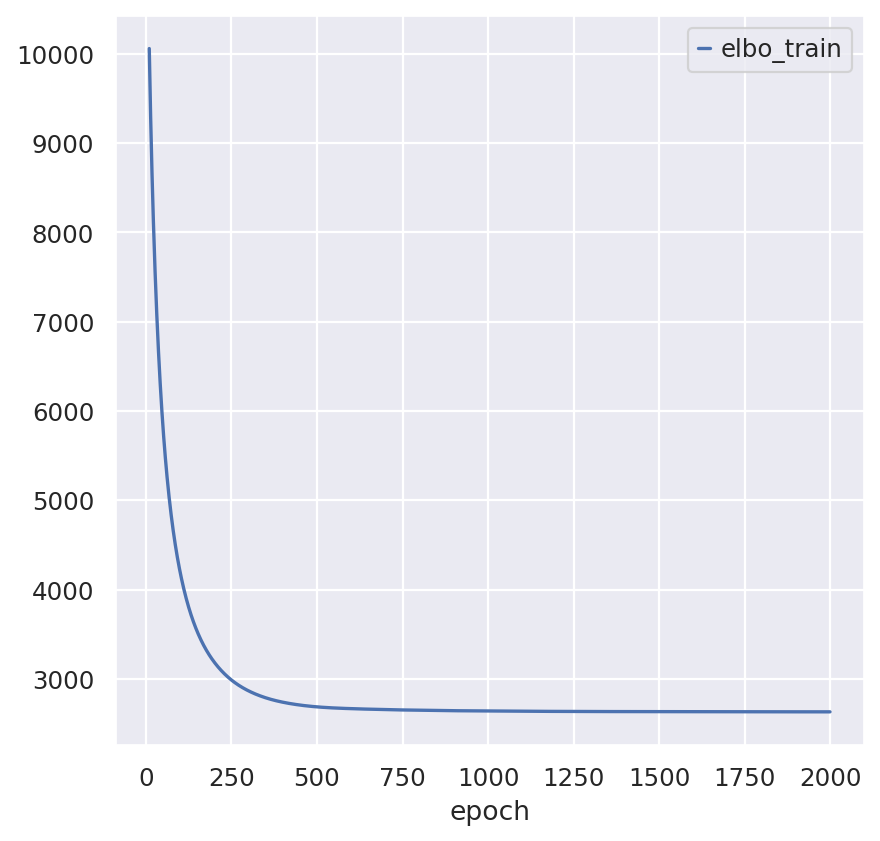

In [21]:
spatial_model_path = os.path.join(save_dir.name, "spatial_model")

spatial_model = SpatialStereoscope.from_rna_model(st_adata, sc_model)
spatial_model.train(max_epochs=2000)
spatial_model.history["elbo_train"][10:].plot()
spatial_model.save(spatial_model_path, overwrite=True)

## Deconvolution results

In [22]:
st_adata.obsm["deconvolution"] = spatial_model.get_proportions()

# also copy as single field in the anndata for visualization
for ct in st_adata.obsm["deconvolution"].columns:
    st_adata.obs[ct] = st_adata.obsm["deconvolution"][ct]

### Visualise populations

Et voilá, we have now an anndata object that contains the inferred proportions on each Visium spot for each cell type in our single cell reference dataset.

In this example we can observe how nicely the arterial endotehlial cells (EC5_art) and the venous endothelial cells (EC6_ven) are highlighted in the areas were we expect to see cardiac vessels based on the histology of the sample.

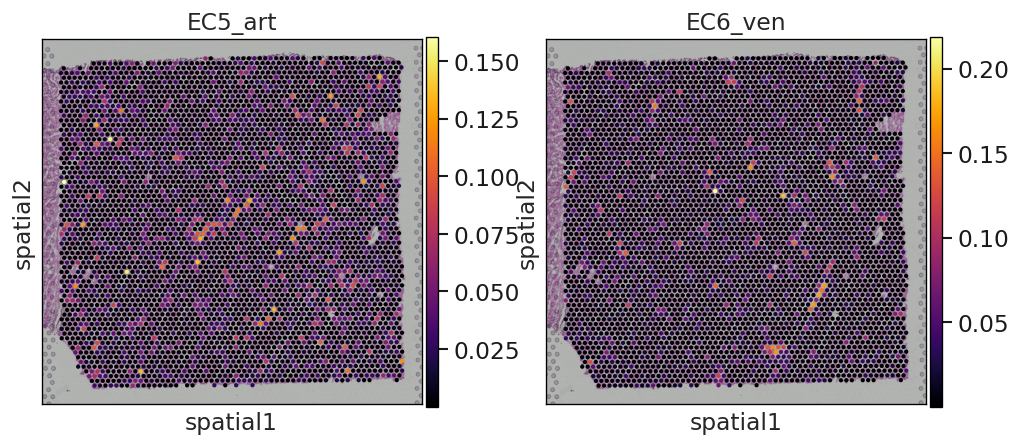

In [23]:
# low dpi for uploading to github
sc.settings.set_figure_params(
    dpi=60, color_map="RdPu", dpi_save=200, vector_friendly=True, format="svg"
)
sc.pl.spatial(
    st_adata,
    img_key="hires",
    color=["EC5_art", "EC6_ven"],
    size=1.2,
    color_map="inferno",
)